In [1]:
#!pip install tensorflow


In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences   
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Input, Bidirectional,SimpleRNN, Embedding, Conv1D, LSTM, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split



from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HARYS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HARYS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2.8.0


In [3]:
#!pip install emot

In [4]:
from __future__ import unicode_literals
import csv
from io import open

# Import the datatset
#data = pd.read_csv('C:/Users/HARYS/OneDrive/Documents/senego/twitter/twittertwo/twitterdatacomb2trans.csv', encoding = "UTF-8")
data = pd.read_excel('C:/Users/HARYS/OneDrive/Documents/senego/twitter/twitterthree/twittercomb3.xlsx', sheet_name='Sheet1')
columns = ['score', 'textr'] 
dataset = pd.DataFrame(data, columns=columns)
#dataset = dataset[col]

# Drop rows with missing labels
dataset.dropna(subset=["textr"], inplace=True)

# Rename column
dataset.columns=['Product', 'ConsumerComplaint'] 

# Only include the following products
dataset=dataset[dataset['Product'].isin(['poverty', 
                                         'hunger', 
                                         'covid',
                                         'neutral'])]

#dataset["ConsumerComplaint"] = dataset["ConsumerComplaint"].apply(convert_emoji).apply(convert_emoticons)

# Print the top
dataset.head()


Product                                  ConsumerComplaint
0  poverty  I spent time in Senegal back in 2005. One thin...
1  poverty  is 21st most poor country in the world? Who to...
2  poverty  When I lived in S��n��gal - \nw/folks living i...
3  poverty  Sandwitched by Guinea and ; Guinea-Bissau is o...
4  poverty  I don���t like how more policing is the only a...

In [66]:
import neattext as nt
import neattext.functions as nfx
#pd.DataFrame(dataset.Product.unique())

In [67]:
dataset['ConsumerComplaint'].apply(lambda x : nt.TextFrame(x).noise_scan()['text_noise'])

0       10.566038
1       11.500000
2       12.068966
3        9.747292
4       10.921502
          ...    
7200     7.857143
7201    11.111111
7202    13.559322
7203    12.820513
7204    15.909091
Name: ConsumerComplaint, Length: 7104, dtype: float64

In [68]:
dataset['clean_text']=dataset['ConsumerComplaint'].apply(nfx.remove_userhandles)

In [69]:
dataset['clean_text'].apply(nfx.remove_hashtags)

0       I spent time in Senegal back in 2005. One thin...
1       is 21st most poor country in the world? Who to...
2       When I lived in S��n��gal - \nw/folks living i...
3       Sandwitched by Guinea and ; Guinea-Bissau is o...
4       I don���t like how more policing is the only a...
                              ...                        
7200    RT   Vice President M. Venkaiah Naidu reaches ...
7201    I miss ablo, Senegal bread, ghana bread, dokun...
7202    RT   tell yourself that the cosplay man in gok...
7203    RT   We treat you of jealous because you have ...
7204    Contribute to the project of drilling an elect...
Name: clean_text, Length: 7104, dtype: object

In [70]:
dataset['hashtags'] = dataset['clean_text'].apply(lambda x: nfx.remove_custom_pattern(x,term_pattern=r'&#\S+'))
dataset['hashtags'].head(2)

0    I spent time in Senegal back in 2005. One thin...
1    is 21st most poor country in the world? Who to...
Name: hashtags, dtype: object

In [10]:
dataset['special'] = dataset['hashtags'].apply(nfx.remove_special_characters)
dataset['special'].head()

0    I spent time in Senegal back in 2005 One thing...
1    is 21st most poor country in the world Who tol...
2    When I lived in Sngal  wfolks living in litera...
3    Sandwitched by Guinea and  GuineaBissau is one...
4    I dont like how more policing is the only answ...
Name: special, dtype: object

In [11]:
dataset['space']= dataset['special'].apply(nfx.remove_multiple_spaces)
dataset['space'].head()

0    I spent time in Senegal back in 2005 One thing...
1    is 21st most poor country in the world Who tol...
2    When I lived in Sngal wfolks living in literal...
3    Sandwitched by Guinea and GuineaBissau is one ...
4    I dont like how more policing is the only answ...
Name: space, dtype: object

In [12]:
# Extarct stopwords
dataset['space'].apply(lambda x: nt.TextExtractor(x).extract_stopwords())

0       [i, in, back, in, one, i, at, the, was, that, ...
1       [is, most, in, the, who, you, that, why, do, a...
2       [when, i, in, in, we, were, at, they, always, ...
3       [by, and, is, one, of, the, few, with, a, from...
4       [i, how, more, is, the, only, we, to, this, in...
                              ...                        
7200                            [m, in, last, is, on, to]
7201                           [i, used, to, be, a, then]
7202               [yourself, that, the, in, is, the, to]
7203    [we, you, of, because, you, have, a, is, anyth...
7204            [to, the, of, an, well, in, through, the]
Name: space, Length: 7104, dtype: object

In [13]:
#Remove stopwords
#Method one using Textfame
dataset['stop']= dataset['space'].apply(lambda x: nt.TextFrame(x).remove_stopwords())
dataset['stop'].head()

0    spent time Senegal 2005 thing noticed time des...
1    21st poor country world told people mention Se...
2    lived Sngal wfolks living literal dirt poverty...
3    Sandwitched Guinea GuineaBissau African countr...
4    dont like policing answer find insecurity issu...
Name: stop, dtype: object

In [14]:
# remove stopwords
#Method 2 using neattext
dataset['stop2']=dataset['space'].apply(nfx.remove_stopwords)
dataset['stop2'].head()

0    spent time Senegal 2005 thing noticed time des...
1    21st poor country world told people mention Se...
2    lived Sngal wfolks living literal dirt poverty...
3    Sandwitched Guinea GuineaBissau African countr...
4    dont like policing answer find insecurity issu...
Name: stop2, dtype: object

In [15]:
dataset['stop2'].apply(lambda x: nt.TextFrame(x).noise_scan()['text_noise'])

0       0
1       0
2       0
3       0
4       0
       ..
7200    0
7201    0
7202    0
7203    0
7204    0
Name: stop2, Length: 7104, dtype: int64

In [16]:

#pd.DataFrame(dataset.Product.unique())

dataset.rename(columns={'ConsumerComplaint': 'ConsumerComplaint1', 'stop2': 'ConsumerComplaint'}, inplace=True)

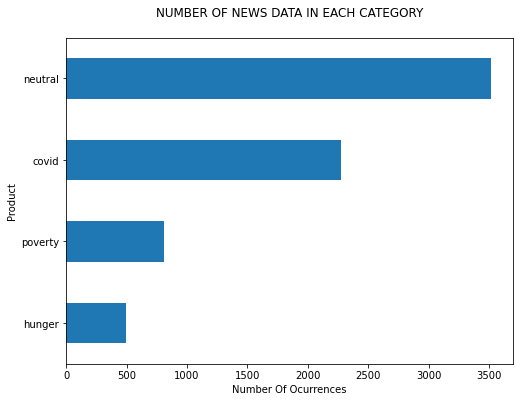

In [17]:
# The bar chart to show the number of news per category
fig = plt.figure(figsize=(8,6))
dataset.groupby('Product').ConsumerComplaint.count().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF NEWS DATA IN EACH CATEGORY\n')
plt.xlabel('Number Of Ocurrences', fontsize = 10);
plt.savefig('category_graph.png', bbox_inches='tight')

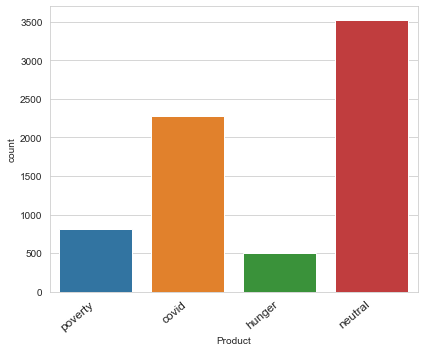

In [18]:
sns.set_style('whitegrid')
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='Product', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [19]:
#!pip install emoji


In [20]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [21]:

EMO_UNICODE = {
    u':1st_place_medal:': u'\U0001F947',
    u':2nd_place_medal:': u'\U0001F948',
    u':3rd_place_medal:': u'\U0001F949',
    u':AB_button_(blood_type):': u'\U0001F18E',
    u':ATM_sign:': u'\U0001F3E7',
    u':A_button_(blood_type):': u'\U0001F170',
    u':Afghanistan:': u'\U0001F1E6 \U0001F1EB',
    u':Albania:': u'\U0001F1E6 \U0001F1F1',
    u':Algeria:': u'\U0001F1E9 \U0001F1FF',
    u':American_Samoa:': u'\U0001F1E6 \U0001F1F8',
    u':Andorra:': u'\U0001F1E6 \U0001F1E9',
    u':Angola:': u'\U0001F1E6 \U0001F1F4',
    u':Anguilla:': u'\U0001F1E6 \U0001F1EE',
    u':Antarctica:': u'\U0001F1E6 \U0001F1F6',
    u':Antigua_&_Barbuda:': u'\U0001F1E6 \U0001F1EC',
    u':Aquarius:': u'\U00002652',
    u':Argentina:': u'\U0001F1E6 \U0001F1F7',
    u':Aries:': u'\U00002648',
    u':Armenia:': u'\U0001F1E6 \U0001F1F2',
    u':Aruba:': u'\U0001F1E6 \U0001F1FC',
    u':Ascension_Island:': u'\U0001F1E6 \U0001F1E8',
    u':Australia:': u'\U0001F1E6 \U0001F1FA',
    u':Austria:': u'\U0001F1E6 \U0001F1F9',
    u':Azerbaijan:': u'\U0001F1E6 \U0001F1FF',
    u':BACK_arrow:': u'\U0001F519',
    u':B_button_(blood_type):': u'\U0001F171',
    u':Bahamas:': u'\U0001F1E7 \U0001F1F8',
    u':Bahrain:': u'\U0001F1E7 \U0001F1ED',
    u':Bangladesh:': u'\U0001F1E7 \U0001F1E9',
    u':Barbados:': u'\U0001F1E7 \U0001F1E7',
    u':Belarus:': u'\U0001F1E7 \U0001F1FE',
    u':Belgium:': u'\U0001F1E7 \U0001F1EA',
    u':Belize:': u'\U0001F1E7 \U0001F1FF',
    u':Benin:': u'\U0001F1E7 \U0001F1EF',
    u':Bermuda:': u'\U0001F1E7 \U0001F1F2',
    u':Bhutan:': u'\U0001F1E7 \U0001F1F9',
    u':Bolivia:': u'\U0001F1E7 \U0001F1F4',
    u':Bosnia_&_Herzegovina:': u'\U0001F1E7 \U0001F1E6',
    u':Botswana:': u'\U0001F1E7 \U0001F1FC',
    u':Bouvet_Island:': u'\U0001F1E7 \U0001F1FB',
    u':Brazil:': u'\U0001F1E7 \U0001F1F7',
    u':British_Indian_Ocean_Territory:': u'\U0001F1EE \U0001F1F4',
    u':British_Virgin_Islands:': u'\U0001F1FB \U0001F1EC',
    u':Brunei:': u'\U0001F1E7 \U0001F1F3',
    u':Bulgaria:': u'\U0001F1E7 \U0001F1EC',
    u':Burkina_Faso:': u'\U0001F1E7 \U0001F1EB',
    u':Burundi:': u'\U0001F1E7 \U0001F1EE',
    u':CL_button:': u'\U0001F191',
    u':COOL_button:': u'\U0001F192',
    u':Cambodia:': u'\U0001F1F0 \U0001F1ED',
    u':Cameroon:': u'\U0001F1E8 \U0001F1F2',
    u':Canada:': u'\U0001F1E8 \U0001F1E6',
    u':Canary_Islands:': u'\U0001F1EE \U0001F1E8',
    u':Cancer:': u'\U0000264B',
    u':Cape_Verde:': u'\U0001F1E8 \U0001F1FB',
    u':Capricorn:': u'\U00002651',
    u':Caribbean_Netherlands:': u'\U0001F1E7 \U0001F1F6',
    u':Cayman_Islands:': u'\U0001F1F0 \U0001F1FE',
    u':Central_African_Republic:': u'\U0001F1E8 \U0001F1EB',
    u':Ceuta_&_Melilla:': u'\U0001F1EA \U0001F1E6',
    u':Chad:': u'\U0001F1F9 \U0001F1E9',
    u':Chile:': u'\U0001F1E8 \U0001F1F1',
    u':China:': u'\U0001F1E8 \U0001F1F3',
    u':Christmas_Island:': u'\U0001F1E8 \U0001F1FD',
    u':Christmas_tree:': u'\U0001F384',
    u':Clipperton_Island:': u'\U0001F1E8 \U0001F1F5',
    u':Cocos_(Keeling)_Islands:': u'\U0001F1E8 \U0001F1E8',
    u':Colombia:': u'\U0001F1E8 \U0001F1F4',
    u':Comoros:': u'\U0001F1F0 \U0001F1F2',
    u':Congo_-_Brazzaville:': u'\U0001F1E8 \U0001F1EC',
    u':Congo_-_Kinshasa:': u'\U0001F1E8 \U0001F1E9',
    u':Cook_Islands:': u'\U0001F1E8 \U0001F1F0',
    u':Costa_Rica:': u'\U0001F1E8 \U0001F1F7',
    u':Croatia:': u'\U0001F1ED \U0001F1F7',
    u':Cuba:': u'\U0001F1E8 \U0001F1FA',
    u':Curaçao:': u'\U0001F1E8 \U0001F1FC',
    u':Cyprus:': u'\U0001F1E8 \U0001F1FE',
    u':Czech_Republic:': u'\U0001F1E8 \U0001F1FF',
    u':Côte_d’Ivoire:': u'\U0001F1E8 \U0001F1EE',
    u':Denmark:': u'\U0001F1E9 \U0001F1F0',
    u':Diego_Garcia:': u'\U0001F1E9 \U0001F1EC',
    u':Djibouti:': u'\U0001F1E9 \U0001F1EF',
    u':Dominica:': u'\U0001F1E9 \U0001F1F2',
    u':Dominican_Republic:': u'\U0001F1E9 \U0001F1F4',
    u':END_arrow:': u'\U0001F51A',
    u':Ecuador:': u'\U0001F1EA \U0001F1E8',
    u':Egypt:': u'\U0001F1EA \U0001F1EC',
    u':El_Salvador:': u'\U0001F1F8 \U0001F1FB',
    u':Equatorial_Guinea:': u'\U0001F1EC \U0001F1F6',
    u':Eritrea:': u'\U0001F1EA \U0001F1F7',
    u':Estonia:': u'\U0001F1EA \U0001F1EA',
    u':Ethiopia:': u'\U0001F1EA \U0001F1F9',
    u':European_Union:': u'\U0001F1EA \U0001F1FA',
    u':FREE_button:': u'\U0001F193',
    u':Falkland_Islands:': u'\U0001F1EB \U0001F1F0',
    u':Faroe_Islands:': u'\U0001F1EB \U0001F1F4',
    u':Fiji:': u'\U0001F1EB \U0001F1EF',
    u':Finland:': u'\U0001F1EB \U0001F1EE',
    u':France:': u'\U0001F1EB \U0001F1F7',
    u':French_Guiana:': u'\U0001F1EC \U0001F1EB',
    u':French_Polynesia:': u'\U0001F1F5 \U0001F1EB',
    u':French_Southern_Territories:': u'\U0001F1F9 \U0001F1EB',
    u':Gabon:': u'\U0001F1EC \U0001F1E6',
    u':Gambia:': u'\U0001F1EC \U0001F1F2',
    u':Gemini:': u'\U0000264A',
    u':Georgia:': u'\U0001F1EC \U0001F1EA',
    u':Germany:': u'\U0001F1E9 \U0001F1EA',
    u':Ghana:': u'\U0001F1EC \U0001F1ED',
    u':Gibraltar:': u'\U0001F1EC \U0001F1EE',
    u':Greece:': u'\U0001F1EC \U0001F1F7',
    u':Greenland:': u'\U0001F1EC \U0001F1F1',
    u':Grenada:': u'\U0001F1EC \U0001F1E9',
    u':Guadeloupe:': u'\U0001F1EC \U0001F1F5',
    u':Guam:': u'\U0001F1EC \U0001F1FA',
    u':Guatemala:': u'\U0001F1EC \U0001F1F9',
    u':Guernsey:': u'\U0001F1EC \U0001F1EC',
    u':Guinea:': u'\U0001F1EC \U0001F1F3',
    u':Guinea-Bissau:': u'\U0001F1EC \U0001F1FC',
    u':Guyana:': u'\U0001F1EC \U0001F1FE',
    u':Haiti:': u'\U0001F1ED \U0001F1F9',
    u':Heard_&_McDonald_Islands:': u'\U0001F1ED \U0001F1F2',
    u':Honduras:': u'\U0001F1ED \U0001F1F3',
    u':Hong_Kong_SAR_China:': u'\U0001F1ED \U0001F1F0',
    u':Hungary:': u'\U0001F1ED \U0001F1FA',
    u':ID_button:': u'\U0001F194',
    u':Iceland:': u'\U0001F1EE \U0001F1F8',
    u':India:': u'\U0001F1EE \U0001F1F3',
    u':Indonesia:': u'\U0001F1EE \U0001F1E9',
    u':Iran:': u'\U0001F1EE \U0001F1F7',
    u':Iraq:': u'\U0001F1EE \U0001F1F6',
    u':Ireland:': u'\U0001F1EE \U0001F1EA',
    u':Isle_of_Man:': u'\U0001F1EE \U0001F1F2',
    u':Israel:': u'\U0001F1EE \U0001F1F1',
    u':Italy:': u'\U0001F1EE \U0001F1F9',
    u':Jamaica:': u'\U0001F1EF \U0001F1F2',
    u':Japan:': u'\U0001F1EF \U0001F1F5',
    u':Japanese_acceptable_button:': u'\U0001F251',
    u':Japanese_application_button:': u'\U0001F238',
    u':Japanese_bargain_button:': u'\U0001F250',
    u':Japanese_castle:': u'\U0001F3EF',
    u':Japanese_congratulations_button:': u'\U00003297',
    u':Japanese_discount_button:': u'\U0001F239',
    u':Japanese_dolls:': u'\U0001F38E',
    u':Japanese_free_of_charge_button:': u'\U0001F21A',
    u':Japanese_here_button:': u'\U0001F201',
    u':Japanese_monthly_amount_button:': u'\U0001F237',
    u':Japanese_no_vacancy_button:': u'\U0001F235',
    u':Japanese_not_free_of_charge_button:': u'\U0001F236',
    u':Japanese_open_for_business_button:': u'\U0001F23A',
    u':Japanese_passing_grade_button:': u'\U0001F234',
    u':Japanese_post_office:': u'\U0001F3E3',
    u':Japanese_prohibited_button:': u'\U0001F232',
    u':Japanese_reserved_button:': u'\U0001F22F',
    u':Japanese_secret_button:': u'\U00003299',
    u':Japanese_service_charge_button:': u'\U0001F202',
    u':Japanese_symbol_for_beginner:': u'\U0001F530',
    u':Japanese_vacancy_button:': u'\U0001F233',
    u':Jersey:': u'\U0001F1EF \U0001F1EA',
    u':Jordan:': u'\U0001F1EF \U0001F1F4',
    u':Kazakhstan:': u'\U0001F1F0 \U0001F1FF',
    u':Kenya:': u'\U0001F1F0 \U0001F1EA',
    u':Kiribati:': u'\U0001F1F0 \U0001F1EE',
    u':Kosovo:': u'\U0001F1FD \U0001F1F0',
    u':Kuwait:': u'\U0001F1F0 \U0001F1FC',
    u':Kyrgyzstan:': u'\U0001F1F0 \U0001F1EC',
    u':Laos:': u'\U0001F1F1 \U0001F1E6',
    u':Latvia:': u'\U0001F1F1 \U0001F1FB',
    u':Lebanon:': u'\U0001F1F1 \U0001F1E7',
    u':Leo:': u'\U0000264C',
    u':Lesotho:': u'\U0001F1F1 \U0001F1F8',
    u':Liberia:': u'\U0001F1F1 \U0001F1F7',
    u':Libra:': u'\U0000264E',
    u':Libya:': u'\U0001F1F1 \U0001F1FE',
    u':Liechtenstein:': u'\U0001F1F1 \U0001F1EE',
    u':Lithuania:': u'\U0001F1F1 \U0001F1F9',
    u':Luxembourg:': u'\U0001F1F1 \U0001F1FA',
    u':Macau_SAR_China:': u'\U0001F1F2 \U0001F1F4',
    u':Macedonia:': u'\U0001F1F2 \U0001F1F0',
    u':Madagascar:': u'\U0001F1F2 \U0001F1EC',
    u':Malawi:': u'\U0001F1F2 \U0001F1FC',
    u':Malaysia:': u'\U0001F1F2 \U0001F1FE',
    u':Maldives:': u'\U0001F1F2 \U0001F1FB',
    u':Mali:': u'\U0001F1F2 \U0001F1F1',
    u':Malta:': u'\U0001F1F2 \U0001F1F9',
    u':Marshall_Islands:': u'\U0001F1F2 \U0001F1ED',
    u':Martinique:': u'\U0001F1F2 \U0001F1F6',
    u':Mauritania:': u'\U0001F1F2 \U0001F1F7',
    u':Mauritius:': u'\U0001F1F2 \U0001F1FA',
    u':Mayotte:': u'\U0001F1FE \U0001F1F9',
    u':Mexico:': u'\U0001F1F2 \U0001F1FD',
    u':Micronesia:': u'\U0001F1EB \U0001F1F2',
    u':Moldova:': u'\U0001F1F2 \U0001F1E9',
    u':Monaco:': u'\U0001F1F2 \U0001F1E8',
    u':Mongolia:': u'\U0001F1F2 \U0001F1F3',
    u':Montenegro:': u'\U0001F1F2 \U0001F1EA',
    u':Montserrat:': u'\U0001F1F2 \U0001F1F8',
    u':Morocco:': u'\U0001F1F2 \U0001F1E6',
    u':Mozambique:': u'\U0001F1F2 \U0001F1FF',
    u':Mrs._Claus:': u'\U0001F936',
    u':Mrs._Claus_dark_skin_tone:': u'\U0001F936 \U0001F3FF',
    u':Mrs._Claus_light_skin_tone:': u'\U0001F936 \U0001F3FB',
    u':Mrs._Claus_medium-dark_skin_tone:': u'\U0001F936 \U0001F3FE',
    u':Mrs._Claus_medium-light_skin_tone:': u'\U0001F936 \U0001F3FC',
    u':Mrs._Claus_medium_skin_tone:': u'\U0001F936 \U0001F3FD',
    u':Myanmar_(Burma):': u'\U0001F1F2 \U0001F1F2',
    u':NEW_button:': u'\U0001F195',
    u':NG_button:': u'\U0001F196',
    u':Namibia:': u'\U0001F1F3 \U0001F1E6',
    u':Nauru:': u'\U0001F1F3 \U0001F1F7',
    u':Nepal:': u'\U0001F1F3 \U0001F1F5',
    u':Netherlands:': u'\U0001F1F3 \U0001F1F1',
    u':New_Caledonia:': u'\U0001F1F3 \U0001F1E8',
    u':New_Zealand:': u'\U0001F1F3 \U0001F1FF',
    u':Nicaragua:': u'\U0001F1F3 \U0001F1EE',
    u':Niger:': u'\U0001F1F3 \U0001F1EA',
    u':Nigeria:': u'\U0001F1F3 \U0001F1EC',
    u':Niue:': u'\U0001F1F3 \U0001F1FA',
    u':Norfolk_Island:': u'\U0001F1F3 \U0001F1EB',
    u':North_Korea:': u'\U0001F1F0 \U0001F1F5',
    u':Northern_Mariana_Islands:': u'\U0001F1F2 \U0001F1F5',
    u':Norway:': u'\U0001F1F3 \U0001F1F4',
    u':OK_button:': u'\U0001F197',
    u':OK_hand:': u'\U0001F44C',
    u':OK_hand_dark_skin_tone:': u'\U0001F44C \U0001F3FF',
    u':OK_hand_light_skin_tone:': u'\U0001F44C \U0001F3FB',
    u':OK_hand_medium-dark_skin_tone:': u'\U0001F44C \U0001F3FE',
    u':OK_hand_medium-light_skin_tone:': u'\U0001F44C \U0001F3FC',
    u':OK_hand_medium_skin_tone:': u'\U0001F44C \U0001F3FD',
    u':ON!_arrow:': u'\U0001F51B',
    u':O_button_(blood_type):': u'\U0001F17E',
    u':Oman:': u'\U0001F1F4 \U0001F1F2',
    u':Ophiuchus:': u'\U000026CE',
    u':P_button:': u'\U0001F17F',
    u':Pakistan:': u'\U0001F1F5 \U0001F1F0',
    u':Palau:': u'\U0001F1F5 \U0001F1FC',
    u':Palestinian_Territories:': u'\U0001F1F5 \U0001F1F8',
    u':Panama:': u'\U0001F1F5 \U0001F1E6',
    u':Papua_New_Guinea:': u'\U0001F1F5 \U0001F1EC',
    u':Paraguay:': u'\U0001F1F5 \U0001F1FE',
    u':Peru:': u'\U0001F1F5 \U0001F1EA',
    u':Philippines:': u'\U0001F1F5 \U0001F1ED',
    u':Pisces:': u'\U00002653',
    u':Pitcairn_Islands:': u'\U0001F1F5 \U0001F1F3',
    u':Poland:': u'\U0001F1F5 \U0001F1F1',
    u':Portugal:': u'\U0001F1F5 \U0001F1F9',
    u':Puerto_Rico:': u'\U0001F1F5 \U0001F1F7',
    u':Qatar:': u'\U0001F1F6 \U0001F1E6',
    u':Romania:': u'\U0001F1F7 \U0001F1F4',
    u':Russia:': u'\U0001F1F7 \U0001F1FA',
    u':Rwanda:': u'\U0001F1F7 \U0001F1FC',
    u':Réunion:': u'\U0001F1F7 \U0001F1EA',
    u':SOON_arrow:': u'\U0001F51C',
    u':SOS_button:': u'\U0001F198',
    u':Sagittarius:': u'\U00002650',
    u':Samoa:': u'\U0001F1FC \U0001F1F8',
    u':San_Marino:': u'\U0001F1F8 \U0001F1F2',
    u':Santa_Claus:': u'\U0001F385',
    u':Santa_Claus_dark_skin_tone:': u'\U0001F385 \U0001F3FF',
    u':Santa_Claus_light_skin_tone:': u'\U0001F385 \U0001F3FB',
    u':Santa_Claus_medium-dark_skin_tone:': u'\U0001F385 \U0001F3FE',
    u':Santa_Claus_medium-light_skin_tone:': u'\U0001F385 \U0001F3FC',
    u':Santa_Claus_medium_skin_tone:': u'\U0001F385 \U0001F3FD',
    u':Saudi_Arabia:': u'\U0001F1F8 \U0001F1E6',
    u':Scorpius:': u'\U0000264F',
    u':Senegal:': u'\U0001F1F8 \U0001F1F3',
    u':Serbia:': u'\U0001F1F7 \U0001F1F8',
    u':Seychelles:': u'\U0001F1F8 \U0001F1E8',
    u':Sierra_Leone:': u'\U0001F1F8 \U0001F1F1',
    u':Singapore:': u'\U0001F1F8 \U0001F1EC',
    u':Sint_Maarten:': u'\U0001F1F8 \U0001F1FD',
    u':Slovakia:': u'\U0001F1F8 \U0001F1F0',
    u':Slovenia:': u'\U0001F1F8 \U0001F1EE',
    u':Solomon_Islands:': u'\U0001F1F8 \U0001F1E7',
    u':Somalia:': u'\U0001F1F8 \U0001F1F4',
    u':South_Africa:': u'\U0001F1FF \U0001F1E6',
    u':South_Georgia_&_South_Sandwich_Islands:': u'\U0001F1EC \U0001F1F8',
    u':South_Korea:': u'\U0001F1F0 \U0001F1F7',
    u':South_Sudan:': u'\U0001F1F8 \U0001F1F8',
    u':Spain:': u'\U0001F1EA \U0001F1F8',
    u':Sri_Lanka:': u'\U0001F1F1 \U0001F1F0',
    u':St._Barthélemy:': u'\U0001F1E7 \U0001F1F1',
    u':St._Helena:': u'\U0001F1F8 \U0001F1ED',
    u':St._Kitts_&_Nevis:': u'\U0001F1F0 \U0001F1F3',
    u':St._Lucia:': u'\U0001F1F1 \U0001F1E8',
    u':St._Martin:': u'\U0001F1F2 \U0001F1EB',
    u':St._Pierre_&_Miquelon:': u'\U0001F1F5 \U0001F1F2',
    u':St._Vincent_&_Grenadines:': u'\U0001F1FB \U0001F1E8',
    u':Statue_of_Liberty:': u'\U0001F5FD',
    u':Sudan:': u'\U0001F1F8 \U0001F1E9',
    u':Suriname:': u'\U0001F1F8 \U0001F1F7',
    u':Svalbard_&_Jan_Mayen:': u'\U0001F1F8 \U0001F1EF',
    u':Swaziland:': u'\U0001F1F8 \U0001F1FF',
    u':Sweden:': u'\U0001F1F8 \U0001F1EA',
    u':Switzerland:': u'\U0001F1E8 \U0001F1ED',
    u':Syria:': u'\U0001F1F8 \U0001F1FE',
    u':São_Tomé_&_Príncipe:': u'\U0001F1F8 \U0001F1F9',
    u':TOP_arrow:': u'\U0001F51D',
    u':Taiwan:': u'\U0001F1F9 \U0001F1FC',
    u':Tajikistan:': u'\U0001F1F9 \U0001F1EF',
    u':Tanzania:': u'\U0001F1F9 \U0001F1FF',
    u':Taurus:': u'\U00002649',
    u':Thailand:': u'\U0001F1F9 \U0001F1ED',
    u':Timor-Leste:': u'\U0001F1F9 \U0001F1F1',
    u':Togo:': u'\U0001F1F9 \U0001F1EC',
    u':Tokelau:': u'\U0001F1F9 \U0001F1F0',
    u':Tokyo_tower:': u'\U0001F5FC',
    u':Tonga:': u'\U0001F1F9 \U0001F1F4',
    u':Trinidad_&_Tobago:': u'\U0001F1F9 \U0001F1F9',
    u':Tristan_da_Cunha:': u'\U0001F1F9 \U0001F1E6',
    u':Tunisia:': u'\U0001F1F9 \U0001F1F3',
    u':Turkey:': u'\U0001F1F9 \U0001F1F7',
    u':Turkmenistan:': u'\U0001F1F9 \U0001F1F2',
    u':Turks_&_Caicos_Islands:': u'\U0001F1F9 \U0001F1E8',
    u':Tuvalu:': u'\U0001F1F9 \U0001F1FB',
    u':U.S._Outlying_Islands:': u'\U0001F1FA \U0001F1F2',
    u':U.S._Virgin_Islands:': u'\U0001F1FB \U0001F1EE',
    u':UP!_button:': u'\U0001F199',
    u':Uganda:': u'\U0001F1FA \U0001F1EC',
    u':Ukraine:': u'\U0001F1FA \U0001F1E6',
    u':United_Arab_Emirates:': u'\U0001F1E6 \U0001F1EA',
    u':United_Kingdom:': u'\U0001F1EC \U0001F1E7',
    u':United_Nations:': u'\U0001F1FA \U0001F1F3',
    u':United_States:': u'\U0001F1FA \U0001F1F8',
    u':Uruguay:': u'\U0001F1FA \U0001F1FE',
    u':Uzbekistan:': u'\U0001F1FA \U0001F1FF',
    u':VS_button:': u'\U0001F19A',
    u':Vanuatu:': u'\U0001F1FB \U0001F1FA',
    u':Vatican_City:': u'\U0001F1FB \U0001F1E6',
    u':Venezuela:': u'\U0001F1FB \U0001F1EA',
    u':Vietnam:': u'\U0001F1FB \U0001F1F3',
    u':Virgo:': u'\U0000264D',
    u':Wallis_&_Futuna:': u'\U0001F1FC \U0001F1EB',
    u':Western_Sahara:': u'\U0001F1EA \U0001F1ED',
    u':Yemen:': u'\U0001F1FE \U0001F1EA',
    u':Zambia:': u'\U0001F1FF \U0001F1F2',
    u':Zimbabwe:': u'\U0001F1FF \U0001F1FC',
    u':admission_tickets:': u'\U0001F39F',
    u':aerial_tramway:': u'\U0001F6A1',
    u':airplane:': u'\U00002708',
    u':airplane_arrival:': u'\U0001F6EC',
    u':airplane_departure:': u'\U0001F6EB',
    u':alarm_clock:': u'\U000023F0',
    u':alembic:': u'\U00002697',
    u':alien:': u'\U0001F47D',
    u':alien_monster:': u'\U0001F47E',
    u':ambulance:': u'\U0001F691',
    u':american_football:': u'\U0001F3C8',
    u':amphora:': u'\U0001F3FA',
    u':anchor:': u'\U00002693',
    u':anger_symbol:': u'\U0001F4A2',
    u':angry_face:': u'\U0001F620',
    u':angry_face_with_horns:': u'\U0001F47F',
    u':anguished_face:': u'\U0001F627',
    u':ant:': u'\U0001F41C',
    u':antenna_bars:': u'\U0001F4F6',
    u':anticlockwise_arrows_button:': u'\U0001F504',
    u':articulated_lorry:': u'\U0001F69B',
    u':artist_palette:': u'\U0001F3A8',
    u':astonished_face:': u'\U0001F632',
    u':atom_symbol:': u'\U0000269B',
    u':automobile:': u'\U0001F697',
    u':avocado:': u'\U0001F951',
    u':baby:': u'\U0001F476',
    u':baby_angel:': u'\U0001F47C',
    u':baby_angel_dark_skin_tone:': u'\U0001F47C \U0001F3FF',
    u':baby_angel_light_skin_tone:': u'\U0001F47C \U0001F3FB',
    u':baby_angel_medium-dark_skin_tone:': u'\U0001F47C \U0001F3FE',
    u':baby_angel_medium-light_skin_tone:': u'\U0001F47C \U0001F3FC',
    u':baby_angel_medium_skin_tone:': u'\U0001F47C \U0001F3FD',
    u':baby_bottle:': u'\U0001F37C',
    u':baby_chick:': u'\U0001F424',
    u':baby_dark_skin_tone:': u'\U0001F476 \U0001F3FF',
    u':baby_light_skin_tone:': u'\U0001F476 \U0001F3FB',
    u':baby_medium-dark_skin_tone:': u'\U0001F476 \U0001F3FE',
    u':baby_medium-light_skin_tone:': u'\U0001F476 \U0001F3FC',
    u':baby_medium_skin_tone:': u'\U0001F476 \U0001F3FD',
    u':baby_symbol:': u'\U0001F6BC',
    u':backhand_index_pointing_down:': u'\U0001F447',
    u':backhand_index_pointing_down_dark_skin_tone:': u'\U0001F447 \U0001F3FF',
    u':backhand_index_pointing_down_light_skin_tone:': u'\U0001F447 \U0001F3FB',
    u':backhand_index_pointing_down_medium-dark_skin_tone:': u'\U0001F447 \U0001F3FE',
    u':backhand_index_pointing_down_medium-light_skin_tone:': u'\U0001F447 \U0001F3FC',
    u':backhand_index_pointing_down_medium_skin_tone:': u'\U0001F447 \U0001F3FD',
    u':backhand_index_pointing_left:': u'\U0001F448',
    u':backhand_index_pointing_left_dark_skin_tone:': u'\U0001F448 \U0001F3FF',
    u':backhand_index_pointing_left_light_skin_tone:': u'\U0001F448 \U0001F3FB',
    u':backhand_index_pointing_left_medium-dark_skin_tone:': u'\U0001F448 \U0001F3FE',
    u':backhand_index_pointing_left_medium-light_skin_tone:': u'\U0001F448 \U0001F3FC',
    u':backhand_index_pointing_left_medium_skin_tone:': u'\U0001F448 \U0001F3FD',
    u':backhand_index_pointing_right:': u'\U0001F449',
    u':backhand_index_pointing_right_dark_skin_tone:': u'\U0001F449 \U0001F3FF',
    u':backhand_index_pointing_right_light_skin_tone:': u'\U0001F449 \U0001F3FB',
    u':backhand_index_pointing_right_medium-dark_skin_tone:': u'\U0001F449 \U0001F3FE',
    u':backhand_index_pointing_right_medium-light_skin_tone:': u'\U0001F449 \U0001F3FC',
    u':backhand_index_pointing_right_medium_skin_tone:': u'\U0001F449 \U0001F3FD',
    u':backhand_index_pointing_up:': u'\U0001F446',
    u':backhand_index_pointing_up_dark_skin_tone:': u'\U0001F446 \U0001F3FF',
    u':backhand_index_pointing_up_light_skin_tone:': u'\U0001F446 \U0001F3FB',
    u':backhand_index_pointing_up_medium-dark_skin_tone:': u'\U0001F446 \U0001F3FE',
    u':backhand_index_pointing_up_medium-light_skin_tone:': u'\U0001F446 \U0001F3FC',
    u':backhand_index_pointing_up_medium_skin_tone:': u'\U0001F446 \U0001F3FD',
    u':bacon:': u'\U0001F953',
    u':badminton:': u'\U0001F3F8',
    u':baggage_claim:': u'\U0001F6C4',
    u':baguette_bread:': u'\U0001F956',
    u':balance_scale:': u'\U00002696',
    u':balloon:': u'\U0001F388',
    u':ballot_box_with_ballot:': u'\U0001F5F3',
    u':ballot_box_with_check:': u'\U00002611',
    u':banana:': u'\U0001F34C',
    u':bank:': u'\U0001F3E6',
    u':bar_chart:': u'\U0001F4CA',
    u':barber_pole:': u'\U0001F488',
    u':baseball:': u'\U000026BE',
    u':basketball:': u'\U0001F3C0',
    u':bat:': u'\U0001F987',
    u':bathtub:': u'\U0001F6C1',
    u':battery:': u'\U0001F50B',
    u':beach_with_umbrella:': u'\U0001F3D6',
    u':bear_face:': u'\U0001F43B',
    u':beating_heart:': u'\U0001F493',
    u':bed:': u'\U0001F6CF',
    u':beer_mug:': u'\U0001F37A',
    u':bell:': u'\U0001F514',
    u':bell_with_slash:': u'\U0001F515',
    u':bellhop_bell:': u'\U0001F6CE',
    u':bento_box:': u'\U0001F371',
    u':bicycle:': u'\U0001F6B2',
    u':bikini:': u'\U0001F459',
    u':biohazard:': u'\U00002623',
    u':bird:': u'\U0001F426',
    u':birthday_cake:': u'\U0001F382',
    u':black_circle:': u'\U000026AB',
    u':black_flag:': u'\U0001F3F4',
    u':black_heart:': u'\U0001F5A4',
    u':black_large_square:': u'\U00002B1B',
    u':black_medium-small_square:': u'\U000025FE',
    u':black_medium_square:': u'\U000025FC',
    u':black_nib:': u'\U00002712',
    u':black_small_square:': u'\U000025AA',
    u':black_square_button:': u'\U0001F532',
    u':blond-haired_man:': u'\U0001F471 \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_dark_skin_tone:': u'\U0001F471 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_light_skin_tone:': u'\U0001F471 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_medium-dark_skin_tone:': u'\U0001F471 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_medium-light_skin_tone:': u'\U0001F471 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_man_medium_skin_tone:': u'\U0001F471 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':blond-haired_person:': u'\U0001F471',
    u':blond-haired_person_dark_skin_tone:': u'\U0001F471 \U0001F3FF',
    u':blond-haired_person_light_skin_tone:': u'\U0001F471 \U0001F3FB',
    u':blond-haired_person_medium-dark_skin_tone:': u'\U0001F471 \U0001F3FE',
    u':blond-haired_person_medium-light_skin_tone:': u'\U0001F471 \U0001F3FC',
    u':blond-haired_person_medium_skin_tone:': u'\U0001F471 \U0001F3FD',
    u':blond-haired_woman:': u'\U0001F471 \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_dark_skin_tone:': u'\U0001F471 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_light_skin_tone:': u'\U0001F471 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_medium-dark_skin_tone:': u'\U0001F471 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_medium-light_skin_tone:': u'\U0001F471 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':blond-haired_woman_medium_skin_tone:': u'\U0001F471 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':blossom:': u'\U0001F33C',
    u':blowfish:': u'\U0001F421',
    u':blue_book:': u'\U0001F4D8',
    u':blue_circle:': u'\U0001F535',
    u':blue_heart:': u'\U0001F499',
    u':boar:': u'\U0001F417',
    u':bomb:': u'\U0001F4A3',
    u':bookmark:': u'\U0001F516',
    u':bookmark_tabs:': u'\U0001F4D1',
    u':books:': u'\U0001F4DA',
    u':bottle_with_popping_cork:': u'\U0001F37E',
    u':bouquet:': u'\U0001F490',
    u':bow_and_arrow:': u'\U0001F3F9',
    u':bowling:': u'\U0001F3B3',
    u':boxing_glove:': u'\U0001F94A',
    u':boy:': u'\U0001F466',
    u':boy_dark_skin_tone:': u'\U0001F466 \U0001F3FF',
    u':boy_light_skin_tone:': u'\U0001F466 \U0001F3FB',
    u':boy_medium-dark_skin_tone:': u'\U0001F466 \U0001F3FE',
    u':boy_medium-light_skin_tone:': u'\U0001F466 \U0001F3FC',
    u':boy_medium_skin_tone:': u'\U0001F466 \U0001F3FD',
    u':bread:': u'\U0001F35E',
    u':bride_with_veil:': u'\U0001F470',
    u':bride_with_veil_dark_skin_tone:': u'\U0001F470 \U0001F3FF',
    u':bride_with_veil_light_skin_tone:': u'\U0001F470 \U0001F3FB',
    u':bride_with_veil_medium-dark_skin_tone:': u'\U0001F470 \U0001F3FE',
    u':bride_with_veil_medium-light_skin_tone:': u'\U0001F470 \U0001F3FC',
    u':bride_with_veil_medium_skin_tone:': u'\U0001F470 \U0001F3FD',
    u':bridge_at_night:': u'\U0001F309',
    u':briefcase:': u'\U0001F4BC',
    u':bright_button:': u'\U0001F506',
    u':broken_heart:': u'\U0001F494',
    u':bug:': u'\U0001F41B',
    u':building_construction:': u'\U0001F3D7',
    u':burrito:': u'\U0001F32F',
    u':bus:': u'\U0001F68C',
    u':bus_stop:': u'\U0001F68F',
    u':bust_in_silhouette:': u'\U0001F464',
    u':busts_in_silhouette:': u'\U0001F465',
    u':butterfly:': u'\U0001F98B',
    u':cactus:': u'\U0001F335',
    u':calendar:': u'\U0001F4C5',
    u':call_me_hand:': u'\U0001F919',
    u':call_me_hand_dark_skin_tone:': u'\U0001F919 \U0001F3FF',
    u':call_me_hand_light_skin_tone:': u'\U0001F919 \U0001F3FB',
    u':call_me_hand_medium-dark_skin_tone:': u'\U0001F919 \U0001F3FE',
    u':call_me_hand_medium-light_skin_tone:': u'\U0001F919 \U0001F3FC',
    u':call_me_hand_medium_skin_tone:': u'\U0001F919 \U0001F3FD',
    u':camel:': u'\U0001F42A',
    u':camera:': u'\U0001F4F7',
    u':camera_with_flash:': u'\U0001F4F8',
    u':camping:': u'\U0001F3D5',
    u':candle:': u'\U0001F56F',
    u':candy:': u'\U0001F36C',
    u':canoe:': u'\U0001F6F6',
    u':card_file_box:': u'\U0001F5C3',
    u':card_index:': u'\U0001F4C7',
    u':card_index_dividers:': u'\U0001F5C2',
    u':carousel_horse:': u'\U0001F3A0',
    u':carp_streamer:': u'\U0001F38F',
    u':carrot:': u'\U0001F955',
    u':castle:': u'\U0001F3F0',
    u':cat:': u'\U0001F408',
    u':cat_face:': u'\U0001F431',
    u':cat_face_with_tears_of_joy:': u'\U0001F639',
    u':cat_face_with_wry_smile:': u'\U0001F63C',
    u':chains:': u'\U000026D3',
    u':chart_decreasing:': u'\U0001F4C9',
    u':chart_increasing:': u'\U0001F4C8',
    u':chart_increasing_with_yen:': u'\U0001F4B9',
    u':cheese_wedge:': u'\U0001F9C0',
    u':chequered_flag:': u'\U0001F3C1',
    u':cherries:': u'\U0001F352',
    u':cherry_blossom:': u'\U0001F338',
    u':chestnut:': u'\U0001F330',
    u':chicken:': u'\U0001F414',
    u':children_crossing:': u'\U0001F6B8',
    u':chipmunk:': u'\U0001F43F',
    u':chocolate_bar:': u'\U0001F36B',
    u':church:': u'\U000026EA',
    u':cigarette:': u'\U0001F6AC',
    u':cinema:': u'\U0001F3A6',
    u':circled_M:': u'\U000024C2',
    u':circus_tent:': u'\U0001F3AA',
    u':cityscape:': u'\U0001F3D9',
    u':cityscape_at_dusk:': u'\U0001F306',
    u':clamp:': u'\U0001F5DC',
    u':clapper_board:': u'\U0001F3AC',
    u':clapping_hands:': u'\U0001F44F',
    u':clapping_hands_dark_skin_tone:': u'\U0001F44F \U0001F3FF',
    u':clapping_hands_light_skin_tone:': u'\U0001F44F \U0001F3FB',
    u':clapping_hands_medium-dark_skin_tone:': u'\U0001F44F \U0001F3FE',
    u':clapping_hands_medium-light_skin_tone:': u'\U0001F44F \U0001F3FC',
    u':clapping_hands_medium_skin_tone:': u'\U0001F44F \U0001F3FD',
    u':classical_building:': u'\U0001F3DB',
    u':clinking_beer_mugs:': u'\U0001F37B',
    u':clinking_glasses:': u'\U0001F942',
    u':clipboard:': u'\U0001F4CB',
    u':clockwise_vertical_arrows:': u'\U0001F503',
    u':closed_book:': u'\U0001F4D5',
    u':closed_mailbox_with_lowered_flag:': u'\U0001F4EA',
    u':closed_mailbox_with_raised_flag:': u'\U0001F4EB',
    u':closed_umbrella:': u'\U0001F302',
    u':cloud:': u'\U00002601',
    u':cloud_with_lightning:': u'\U0001F329',
    u':cloud_with_lightning_and_rain:': u'\U000026C8',
    u':cloud_with_rain:': u'\U0001F327',
    u':cloud_with_snow:': u'\U0001F328',
    u':clown_face:': u'\U0001F921',
    u':club_suit:': u'\U00002663',
    u':clutch_bag:': u'\U0001F45D',
    u':cocktail_glass:': u'\U0001F378',
    u':coffin:': u'\U000026B0',
    u':collision:': u'\U0001F4A5',
    u':comet:': u'\U00002604',
    u':computer_disk:': u'\U0001F4BD',
    u':computer_mouse:': u'\U0001F5B1',
    u':confetti_ball:': u'\U0001F38A',
    u':confounded_face:': u'\U0001F616',
    u':confused_face:': u'\U0001F615',
    u':construction:': u'\U0001F6A7',
    u':construction_worker:': u'\U0001F477',
    u':construction_worker_dark_skin_tone:': u'\U0001F477 \U0001F3FF',
    u':construction_worker_light_skin_tone:': u'\U0001F477 \U0001F3FB',
    u':construction_worker_medium-dark_skin_tone:': u'\U0001F477 \U0001F3FE',
    u':construction_worker_medium-light_skin_tone:': u'\U0001F477 \U0001F3FC',
    u':construction_worker_medium_skin_tone:': u'\U0001F477 \U0001F3FD',
    u':control_knobs:': u'\U0001F39B',
    u':convenience_store:': u'\U0001F3EA',
    u':cooked_rice:': u'\U0001F35A',
    u':cookie:': u'\U0001F36A',
    u':cooking:': u'\U0001F373',
    u':copyright:': u'\U000000A9',
    u':couch_and_lamp:': u'\U0001F6CB',
    u':couple_with_heart:': u'\U0001F491',
    u':couple_with_heart_man_man:': u'\U0001F468 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F468',
    u':couple_with_heart_woman_man:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F468',
    u':couple_with_heart_woman_woman:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F469',
    u':cow:': u'\U0001F404',
    u':cow_face:': u'\U0001F42E',
    u':cowboy_hat_face:': u'\U0001F920',
    u':crab:': u'\U0001F980',
    u':crayon:': u'\U0001F58D',
    u':credit_card:': u'\U0001F4B3',
    u':crescent_moon:': u'\U0001F319',
    u':cricket:': u'\U0001F3CF',
    u':crocodile:': u'\U0001F40A',
    u':croissant:': u'\U0001F950',
    u':cross_mark:': u'\U0000274C',
    u':cross_mark_button:': u'\U0000274E',
    u':crossed_fingers:': u'\U0001F91E',
    u':crossed_fingers_dark_skin_tone:': u'\U0001F91E \U0001F3FF',
    u':crossed_fingers_light_skin_tone:': u'\U0001F91E \U0001F3FB',
    u':crossed_fingers_medium-dark_skin_tone:': u'\U0001F91E \U0001F3FE',
    u':crossed_fingers_medium-light_skin_tone:': u'\U0001F91E \U0001F3FC',
    u':crossed_fingers_medium_skin_tone:': u'\U0001F91E \U0001F3FD',
    u':crossed_flags:': u'\U0001F38C',
    u':crossed_swords:': u'\U00002694',
    u':crown:': u'\U0001F451',
    u':crying_cat_face:': u'\U0001F63F',
    u':crying_face:': u'\U0001F622',
    u':crystal_ball:': u'\U0001F52E',
    u':cucumber:': u'\U0001F952',
    u':curly_loop:': u'\U000027B0',
    u':currency_exchange:': u'\U0001F4B1',
    u':curry_rice:': u'\U0001F35B',
    u':custard:': u'\U0001F36E',
    u':customs:': u'\U0001F6C3',
    u':cyclone:': u'\U0001F300',
    u':dagger:': u'\U0001F5E1',
    u':dango:': u'\U0001F361',
    u':dark_skin_tone:': u'\U0001F3FF',
    u':dashing_away:': u'\U0001F4A8',
    u':deciduous_tree:': u'\U0001F333',
    u':deer:': u'\U0001F98C',
    u':delivery_truck:': u'\U0001F69A',
    u':department_store:': u'\U0001F3EC',
    u':derelict_house:': u'\U0001F3DA',
    u':desert:': u'\U0001F3DC',
    u':desert_island:': u'\U0001F3DD',
    u':desktop_computer:': u'\U0001F5A5',
    u':detective:': u'\U0001F575',
    u':detective_dark_skin_tone:': u'\U0001F575 \U0001F3FF',
    u':detective_light_skin_tone:': u'\U0001F575 \U0001F3FB',
    u':detective_medium-dark_skin_tone:': u'\U0001F575 \U0001F3FE',
    u':detective_medium-light_skin_tone:': u'\U0001F575 \U0001F3FC',
    u':detective_medium_skin_tone:': u'\U0001F575 \U0001F3FD',
    u':diamond_suit:': u'\U00002666',
    u':diamond_with_a_dot:': u'\U0001F4A0',
    u':dim_button:': u'\U0001F505',
    u':direct_hit:': u'\U0001F3AF',
    u':disappointed_but_relieved_face:': u'\U0001F625',
    u':disappointed_face:': u'\U0001F61E',
    u':dizzy:': u'\U0001F4AB',
    u':dizzy_face:': u'\U0001F635',
    u':dog:': u'\U0001F415',
    u':dog_face:': u'\U0001F436',
    u':dollar_banknote:': u'\U0001F4B5',
    u':dolphin:': u'\U0001F42C',
    u':door:': u'\U0001F6AA',
    u':dotted_six-pointed_star:': u'\U0001F52F',
    u':double_curly_loop:': u'\U000027BF',
    u':double_exclamation_mark:': u'\U0000203C',
    u':doughnut:': u'\U0001F369',
    u':dove:': u'\U0001F54A',
    u':down-left_arrow:': u'\U00002199',
    u':down-right_arrow:': u'\U00002198',
    u':down_arrow:': u'\U00002B07',
    u':down_button:': u'\U0001F53D',
    u':dragon:': u'\U0001F409',
    u':dragon_face:': u'\U0001F432',
    u':dress:': u'\U0001F457',
    u':drooling_face:': u'\U0001F924',
    u':droplet:': u'\U0001F4A7',
    u':drum:': u'\U0001F941',
    u':duck:': u'\U0001F986',
    u':dvd:': u'\U0001F4C0',
    u':e-mail:': u'\U0001F4E7',
    u':eagle:': u'\U0001F985',
    u':ear:': u'\U0001F442',
    u':ear_dark_skin_tone:': u'\U0001F442 \U0001F3FF',
    u':ear_light_skin_tone:': u'\U0001F442 \U0001F3FB',
    u':ear_medium-dark_skin_tone:': u'\U0001F442 \U0001F3FE',
    u':ear_medium-light_skin_tone:': u'\U0001F442 \U0001F3FC',
    u':ear_medium_skin_tone:': u'\U0001F442 \U0001F3FD',
    u':ear_of_corn:': u'\U0001F33D',
    u':egg:': u'\U0001F95A',
    u':eggplant:': u'\U0001F346',
    u':eight-pointed_star:': u'\U00002734',
    u':eight-spoked_asterisk:': u'\U00002733',
    u':eight-thirty:': u'\U0001F563',
    u':eight_o’clock:': u'\U0001F557',
    u':eject_button:': u'\U000023CF',
    u':electric_plug:': u'\U0001F50C',
    u':elephant:': u'\U0001F418',
    u':eleven-thirty:': u'\U0001F566',
    u':eleven_o’clock:': u'\U0001F55A',
    u':envelope:': u'\U00002709',
    u':envelope_with_arrow:': u'\U0001F4E9',
    u':euro_banknote:': u'\U0001F4B6',
    u':evergreen_tree:': u'\U0001F332',
    u':exclamation_mark:': u'\U00002757',
    u':exclamation_question_mark:': u'\U00002049',
    u':expressionless_face:': u'\U0001F611',
    u':eye:': u'\U0001F441',
    u':eye_in_speech_bubble:': u'\U0001F441 \U0000FE0F \U0000200D \U0001F5E8 \U0000FE0F',
    u':eyes:': u'\U0001F440',
    u':face_blowing_a_kiss:': u'\U0001F618',
    u':face_savouring_delicious_food:': u'\U0001F60B',
    u':face_screaming_in_fear:': u'\U0001F631',
    u':face_with_cold_sweat:': u'\U0001F613',
    u':face_with_head-bandage:': u'\U0001F915',
    u':face_with_medical_mask:': u'\U0001F637',
    u':face_with_open_mouth:': u'\U0001F62E',
    u':face_with_open_mouth_&_cold_sweat:': u'\U0001F630',
    u':face_with_rolling_eyes:': u'\U0001F644',
    u':face_with_steam_from_nose:': u'\U0001F624',
    u':face_with_stuck-out_tongue:': u'\U0001F61B',
    u':face_with_stuck-out_tongue_&_closed_eyes:': u'\U0001F61D',
    u':face_with_stuck-out_tongue_&_winking_eye:': u'\U0001F61C',
    u':face_with_tears_of_joy:': u'\U0001F602',
    u':face_with_thermometer:': u'\U0001F912',
    u':face_without_mouth:': u'\U0001F636',
    u':factory:': u'\U0001F3ED',
    u':fallen_leaf:': u'\U0001F342',
    u':family:': u'\U0001F46A',
    u':family_man_boy:': u'\U0001F468 \U0000200D \U0001F466',
    u':family_man_boy_boy:': u'\U0001F468 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_man_girl:': u'\U0001F468 \U0000200D \U0001F467',
    u':family_man_girl_boy:': u'\U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_man_girl_girl:': u'\U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_man_man_boy:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F466',
    u':family_man_man_boy_boy:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_man_man_girl:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F467',
    u':family_man_man_girl_boy:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_man_man_girl_girl:': u'\U0001F468 \U0000200D \U0001F468 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_man_woman_boy:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F466',
    u':family_man_woman_boy_boy:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_man_woman_girl:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F467',
    u':family_man_woman_girl_boy:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_man_woman_girl_girl:': u'\U0001F468 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_woman_boy:': u'\U0001F469 \U0000200D \U0001F466',
    u':family_woman_boy_boy:': u'\U0001F469 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_woman_girl:': u'\U0001F469 \U0000200D \U0001F467',
    u':family_woman_girl_boy:': u'\U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_woman_girl_girl:': u'\U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':family_woman_woman_boy:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F466',
    u':family_woman_woman_boy_boy:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F466 \U0000200D \U0001F466',
    u':family_woman_woman_girl:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F467',
    u':family_woman_woman_girl_boy:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F466',
    u':family_woman_woman_girl_girl:': u'\U0001F469 \U0000200D \U0001F469 \U0000200D \U0001F467 \U0000200D \U0001F467',
    u':fast-forward_button:': u'\U000023E9',
    u':fast_down_button:': u'\U000023EC',
    u':fast_reverse_button:': u'\U000023EA',
    u':fast_up_button:': u'\U000023EB',
    u':fax_machine:': u'\U0001F4E0',
    u':fearful_face:': u'\U0001F628',
    u':female_sign:': u'\U00002640',
    u':ferris_wheel:': u'\U0001F3A1',
    u':ferry:': u'\U000026F4',
    u':field_hockey:': u'\U0001F3D1',
    u':file_cabinet:': u'\U0001F5C4',
    u':file_folder:': u'\U0001F4C1',
    u':film_frames:': u'\U0001F39E',
    u':film_projector:': u'\U0001F4FD',
    u':fire:': u'\U0001F525',
    u':fire_engine:': u'\U0001F692',
    u':fireworks:': u'\U0001F386',
    u':first_quarter_moon:': u'\U0001F313',
    u':first_quarter_moon_with_face:': u'\U0001F31B',
    u':fish:': u'\U0001F41F',
    u':fish_cake_with_swirl:': u'\U0001F365',
    u':fishing_pole:': u'\U0001F3A3',
    u':five-thirty:': u'\U0001F560',
    u':five_o’clock:': u'\U0001F554',
    u':flag_in_hole:': u'\U000026F3',
    u':flashlight:': u'\U0001F526',
    u':fleur-de-lis:': u'\U0000269C',
    u':flexed_biceps:': u'\U0001F4AA',
    u':flexed_biceps_dark_skin_tone:': u'\U0001F4AA \U0001F3FF',
    u':flexed_biceps_light_skin_tone:': u'\U0001F4AA \U0001F3FB',
    u':flexed_biceps_medium-dark_skin_tone:': u'\U0001F4AA \U0001F3FE',
    u':flexed_biceps_medium-light_skin_tone:': u'\U0001F4AA \U0001F3FC',
    u':flexed_biceps_medium_skin_tone:': u'\U0001F4AA \U0001F3FD',
    u':floppy_disk:': u'\U0001F4BE',
    u':flower_playing_cards:': u'\U0001F3B4',
    u':flushed_face:': u'\U0001F633',
    u':fog:': u'\U0001F32B',
    u':foggy:': u'\U0001F301',
    u':folded_hands:': u'\U0001F64F',
    u':folded_hands_dark_skin_tone:': u'\U0001F64F \U0001F3FF',
    u':folded_hands_light_skin_tone:': u'\U0001F64F \U0001F3FB',
    u':folded_hands_medium-dark_skin_tone:': u'\U0001F64F \U0001F3FE',
    u':folded_hands_medium-light_skin_tone:': u'\U0001F64F \U0001F3FC',
    u':folded_hands_medium_skin_tone:': u'\U0001F64F \U0001F3FD',
    u':footprints:': u'\U0001F463',
    u':fork_and_knife:': u'\U0001F374',
    u':fork_and_knife_with_plate:': u'\U0001F37D',
    u':fountain:': u'\U000026F2',
    u':fountain_pen:': u'\U0001F58B',
    u':four-thirty:': u'\U0001F55F',
    u':four_leaf_clover:': u'\U0001F340',
    u':four_o’clock:': u'\U0001F553',
    u':fox_face:': u'\U0001F98A',
    u':framed_picture:': u'\U0001F5BC',
    u':french_fries:': u'\U0001F35F',
    u':fried_shrimp:': u'\U0001F364',
    u':frog_face:': u'\U0001F438',
    u':front-facing_baby_chick:': u'\U0001F425',
    u':frowning_face:': u'\U00002639',
    u':frowning_face_with_open_mouth:': u'\U0001F626',
    u':fuel_pump:': u'\U000026FD',
    u':full_moon:': u'\U0001F315',
    u':full_moon_with_face:': u'\U0001F31D',
    u':funeral_urn:': u'\U000026B1',
    u':game_die:': u'\U0001F3B2',
    u':gear:': u'\U00002699',
    u':gem_stone:': u'\U0001F48E',
    u':ghost:': u'\U0001F47B',
    u':girl:': u'\U0001F467',
    u':girl_dark_skin_tone:': u'\U0001F467 \U0001F3FF',
    u':girl_light_skin_tone:': u'\U0001F467 \U0001F3FB',
    u':girl_medium-dark_skin_tone:': u'\U0001F467 \U0001F3FE',
    u':girl_medium-light_skin_tone:': u'\U0001F467 \U0001F3FC',
    u':girl_medium_skin_tone:': u'\U0001F467 \U0001F3FD',
    u':glass_of_milk:': u'\U0001F95B',
    u':glasses:': u'\U0001F453',
    u':globe_showing_Americas:': u'\U0001F30E',
    u':globe_showing_Asia-Australia:': u'\U0001F30F',
    u':globe_showing_Europe-Africa:': u'\U0001F30D',
    u':globe_with_meridians:': u'\U0001F310',
    u':glowing_star:': u'\U0001F31F',
    u':goal_net:': u'\U0001F945',
    u':goat:': u'\U0001F410',
    u':goblin:': u'\U0001F47A',
    u':gorilla:': u'\U0001F98D',
    u':graduation_cap:': u'\U0001F393',
    u':grapes:': u'\U0001F347',
    u':green_apple:': u'\U0001F34F',
    u':green_book:': u'\U0001F4D7',
    u':green_heart:': u'\U0001F49A',
    u':green_salad:': u'\U0001F957',
    u':grimacing_face:': u'\U0001F62C',
    u':grinning_cat_face_with_smiling_eyes:': u'\U0001F638',
    u':grinning_face:': u'\U0001F600',
    u':grinning_face_with_smiling_eyes:': u'\U0001F601',
    u':growing_heart:': u'\U0001F497',
    u':guard:': u'\U0001F482',
    u':guard_dark_skin_tone:': u'\U0001F482 \U0001F3FF',
    u':guard_light_skin_tone:': u'\U0001F482 \U0001F3FB',
    u':guard_medium-dark_skin_tone:': u'\U0001F482 \U0001F3FE',
    u':guard_medium-light_skin_tone:': u'\U0001F482 \U0001F3FC',
    u':guard_medium_skin_tone:': u'\U0001F482 \U0001F3FD',
    u':guitar:': u'\U0001F3B8',
    u':hamburger:': u'\U0001F354',
    u':hammer:': u'\U0001F528',
    u':hammer_and_pick:': u'\U00002692',
    u':hammer_and_wrench:': u'\U0001F6E0',
    u':hamster_face:': u'\U0001F439',
    u':handbag:': u'\U0001F45C',
    u':handshake:': u'\U0001F91D',
    u':hatching_chick:': u'\U0001F423',
    u':headphone:': u'\U0001F3A7',
    u':hear-no-evil_monkey:': u'\U0001F649',
    u':heart_decoration:': u'\U0001F49F',
    u':heart_suit:': u'\U00002665',
    u':heart_with_arrow:': u'\U0001F498',
    u':heart_with_ribbon:': u'\U0001F49D',
    u':heavy_check_mark:': u'\U00002714',
    u':heavy_division_sign:': u'\U00002797',
    u':heavy_dollar_sign:': u'\U0001F4B2',
    u':heavy_heart_exclamation:': u'\U00002763',
    u':heavy_large_circle:': u'\U00002B55',
    u':heavy_minus_sign:': u'\U00002796',
    u':heavy_multiplication_x:': u'\U00002716',
    u':heavy_plus_sign:': u'\U00002795',
    u':helicopter:': u'\U0001F681',
    u':herb:': u'\U0001F33F',
    u':hibiscus:': u'\U0001F33A',
    u':high-heeled_shoe:': u'\U0001F460',
    u':high-speed_train:': u'\U0001F684',
    u':high-speed_train_with_bullet_nose:': u'\U0001F685',
    u':high_voltage:': u'\U000026A1',
    u':hole:': u'\U0001F573',
    u':honey_pot:': u'\U0001F36F',
    u':honeybee:': u'\U0001F41D',
    u':horizontal_traffic_light:': u'\U0001F6A5',
    u':horse:': u'\U0001F40E',
    u':horse_face:': u'\U0001F434',
    u':horse_racing:': u'\U0001F3C7',
    u':horse_racing_dark_skin_tone:': u'\U0001F3C7 \U0001F3FF',
    u':horse_racing_light_skin_tone:': u'\U0001F3C7 \U0001F3FB',
    u':horse_racing_medium-dark_skin_tone:': u'\U0001F3C7 \U0001F3FE',
    u':horse_racing_medium-light_skin_tone:': u'\U0001F3C7 \U0001F3FC',
    u':horse_racing_medium_skin_tone:': u'\U0001F3C7 \U0001F3FD',
    u':hospital:': u'\U0001F3E5',
    u':hot_beverage:': u'\U00002615',
    u':hot_dog:': u'\U0001F32D',
    u':hot_pepper:': u'\U0001F336',
    u':hot_springs:': u'\U00002668',
    u':hotel:': u'\U0001F3E8',
    u':hourglass:': u'\U0000231B',
    u':hourglass_with_flowing_sand:': u'\U000023F3',
    u':house:': u'\U0001F3E0',
    u':house_with_garden:': u'\U0001F3E1',
    u':hugging_face:': u'\U0001F917',
    u':hundred_points:': u'\U0001F4AF',
    u':hushed_face:': u'\U0001F62F',
    u':ice_cream:': u'\U0001F368',
    u':ice_hockey:': u'\U0001F3D2',
    u':ice_skate:': u'\U000026F8',
    u':inbox_tray:': u'\U0001F4E5',
    u':incoming_envelope:': u'\U0001F4E8',
    u':index_pointing_up:': u'\U0000261D',
    u':index_pointing_up_dark_skin_tone:': u'\U0000261D \U0001F3FF',
    u':index_pointing_up_light_skin_tone:': u'\U0000261D \U0001F3FB',
    u':index_pointing_up_medium-dark_skin_tone:': u'\U0000261D \U0001F3FE',
    u':index_pointing_up_medium-light_skin_tone:': u'\U0000261D \U0001F3FC',
    u':index_pointing_up_medium_skin_tone:': u'\U0000261D \U0001F3FD',
    u':information:': u'\U00002139',
    u':input_latin_letters:': u'\U0001F524',
    u':input_latin_lowercase:': u'\U0001F521',
    u':input_latin_uppercase:': u'\U0001F520',
    u':input_numbers:': u'\U0001F522',
    u':input_symbols:': u'\U0001F523',
    u':jack-o-lantern:': u'\U0001F383',
    u':jeans:': u'\U0001F456',
    u':joker:': u'\U0001F0CF',
    u':joystick:': u'\U0001F579',
    u':kaaba:': u'\U0001F54B',
    u':key:': u'\U0001F511',
    u':keyboard:': u'\U00002328',
    u':keycap_#:': u'\U00000023 \U0000FE0F \U000020E3',
    u':keycap_*:': u'\U0000002A \U0000FE0F \U000020E3',
    u':keycap_0:': u'\U00000030 \U0000FE0F \U000020E3',
    u':keycap_1:': u'\U00000031 \U0000FE0F \U000020E3',
    u':keycap_10:': u'\U0001F51F',
    u':keycap_2:': u'\U00000032 \U0000FE0F \U000020E3',
    u':keycap_3:': u'\U00000033 \U0000FE0F \U000020E3',
    u':keycap_4:': u'\U00000034 \U0000FE0F \U000020E3',
    u':keycap_5:': u'\U00000035 \U0000FE0F \U000020E3',
    u':keycap_6:': u'\U00000036 \U0000FE0F \U000020E3',
    u':keycap_7:': u'\U00000037 \U0000FE0F \U000020E3',
    u':keycap_8:': u'\U00000038 \U0000FE0F \U000020E3',
    u':keycap_9:': u'\U00000039 \U0000FE0F \U000020E3',
    u':kick_scooter:': u'\U0001F6F4',
    u':kimono:': u'\U0001F458',
    u':kiss:': u'\U0001F48F',
    u':kiss_man_man:': u'\U0001F468 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F48B \U0000200D \U0001F468',
    u':kiss_mark:': u'\U0001F48B',
    u':kiss_woman_man:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F48B \U0000200D \U0001F468',
    u':kiss_woman_woman:': u'\U0001F469 \U0000200D \U00002764 \U0000FE0F \U0000200D \U0001F48B \U0000200D \U0001F469',
    u':kissing_cat_face_with_closed_eyes:': u'\U0001F63D',
    u':kissing_face:': u'\U0001F617',
    u':kissing_face_with_closed_eyes:': u'\U0001F61A',
    u':kissing_face_with_smiling_eyes:': u'\U0001F619',
    u':kitchen_knife:': u'\U0001F52A',
    u':kiwi_fruit:': u'\U0001F95D',
    u':koala:': u'\U0001F428',
    u':label:': u'\U0001F3F7',
    u':lady_beetle:': u'\U0001F41E',
    u':laptop_computer:': u'\U0001F4BB',
    u':large_blue_diamond:': u'\U0001F537',
    u':large_orange_diamond:': u'\U0001F536',
    u':last_quarter_moon:': u'\U0001F317',
    u':last_quarter_moon_with_face:': u'\U0001F31C',
    u':last_track_button:': u'\U000023EE',
    u':latin_cross:': u'\U0000271D',
    u':leaf_fluttering_in_wind:': u'\U0001F343',
    u':ledger:': u'\U0001F4D2',
    u':left-facing_fist:': u'\U0001F91B',
    u':left-facing_fist_dark_skin_tone:': u'\U0001F91B \U0001F3FF',
    u':left-facing_fist_light_skin_tone:': u'\U0001F91B \U0001F3FB',
    u':left-facing_fist_medium-dark_skin_tone:': u'\U0001F91B \U0001F3FE',
    u':left-facing_fist_medium-light_skin_tone:': u'\U0001F91B \U0001F3FC',
    u':left-facing_fist_medium_skin_tone:': u'\U0001F91B \U0001F3FD',
    u':left-pointing_magnifying_glass:': u'\U0001F50D',
    u':left-right_arrow:': u'\U00002194',
    u':left_arrow:': u'\U00002B05',
    u':left_arrow_curving_right:': u'\U000021AA',
    u':left_luggage:': u'\U0001F6C5',
    u':left_speech_bubble:': u'\U0001F5E8',
    u':lemon:': u'\U0001F34B',
    u':leopard:': u'\U0001F406',
    u':level_slider:': u'\U0001F39A',
    u':light_bulb:': u'\U0001F4A1',
    u':light_rail:': u'\U0001F688',
    u':light_skin_tone:': u'\U0001F3FB',
    u':link:': u'\U0001F517',
    u':linked_paperclips:': u'\U0001F587',
    u':lion_face:': u'\U0001F981',
    u':lipstick:': u'\U0001F484',
    u':litter_in_bin_sign:': u'\U0001F6AE',
    u':lizard:': u'\U0001F98E',
    u':locked:': u'\U0001F512',
    u':locked_with_key:': u'\U0001F510',
    u':locked_with_pen:': u'\U0001F50F',
    u':locomotive:': u'\U0001F682',
    u':lollipop:': u'\U0001F36D',
    u':loudly_crying_face:': u'\U0001F62D',
    u':loudspeaker:': u'\U0001F4E2',
    u':love_hotel:': u'\U0001F3E9',
    u':love_letter:': u'\U0001F48C',
    u':lying_face:': u'\U0001F925',
    u':mahjong_red_dragon:': u'\U0001F004',
    u':male_sign:': u'\U00002642',
    u':man:': u'\U0001F468',
    u':man_and_woman_holding_hands:': u'\U0001F46B',
    u':man_artist:': u'\U0001F468 \U0000200D \U0001F3A8',
    u':man_artist_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3A8',
    u':man_artist_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3A8',
    u':man_artist_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3A8',
    u':man_artist_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3A8',
    u':man_artist_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3A8',
    u':man_astronaut:': u'\U0001F468 \U0000200D \U0001F680',
    u':man_astronaut_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F680',
    u':man_astronaut_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F680',
    u':man_astronaut_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F680',
    u':man_astronaut_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F680',
    u':man_astronaut_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F680',
    u':man_biking:': u'\U0001F6B4 \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_dark_skin_tone:': u'\U0001F6B4 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_light_skin_tone:': u'\U0001F6B4 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_medium-dark_skin_tone:': u'\U0001F6B4 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_medium-light_skin_tone:': u'\U0001F6B4 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_biking_medium_skin_tone:': u'\U0001F6B4 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball:': u'\U000026F9 \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_dark_skin_tone:': u'\U000026F9 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_light_skin_tone:': u'\U000026F9 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_medium-dark_skin_tone:': u'\U000026F9 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_medium-light_skin_tone:': u'\U000026F9 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_bouncing_ball_medium_skin_tone:': u'\U000026F9 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing:': u'\U0001F647 \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_dark_skin_tone:': u'\U0001F647 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_light_skin_tone:': u'\U0001F647 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_medium-dark_skin_tone:': u'\U0001F647 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_medium-light_skin_tone:': u'\U0001F647 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_bowing_medium_skin_tone:': u'\U0001F647 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling:': u'\U0001F938 \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_dark_skin_tone:': u'\U0001F938 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_light_skin_tone:': u'\U0001F938 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_medium-dark_skin_tone:': u'\U0001F938 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_medium-light_skin_tone:': u'\U0001F938 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_cartwheeling_medium_skin_tone:': u'\U0001F938 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker:': u'\U0001F477 \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_dark_skin_tone:': u'\U0001F477 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_light_skin_tone:': u'\U0001F477 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_medium-dark_skin_tone:': u'\U0001F477 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_medium-light_skin_tone:': u'\U0001F477 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_construction_worker_medium_skin_tone:': u'\U0001F477 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_cook:': u'\U0001F468 \U0000200D \U0001F373',
    u':man_cook_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F373',
    u':man_cook_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F373',
    u':man_cook_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F373',
    u':man_cook_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F373',
    u':man_cook_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F373',
    u':man_dancing:': u'\U0001F57A',
    u':man_dancing_dark_skin_tone:': u'\U0001F57A \U0001F3FF',
    u':man_dancing_light_skin_tone:': u'\U0001F57A \U0001F3FB',
    u':man_dancing_medium-dark_skin_tone:': u'\U0001F57A \U0001F3FE',
    u':man_dancing_medium-light_skin_tone:': u'\U0001F57A \U0001F3FC',
    u':man_dancing_medium_skin_tone:': u'\U0001F57A \U0001F3FD',
    u':man_dark_skin_tone:': u'\U0001F468 \U0001F3FF',
    u':man_detective:': u'\U0001F575 \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_dark_skin_tone:': u'\U0001F575 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_light_skin_tone:': u'\U0001F575 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_medium-dark_skin_tone:': u'\U0001F575 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_medium-light_skin_tone:': u'\U0001F575 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_detective_medium_skin_tone:': u'\U0001F575 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming:': u'\U0001F926 \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_dark_skin_tone:': u'\U0001F926 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_light_skin_tone:': u'\U0001F926 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_medium-dark_skin_tone:': u'\U0001F926 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_medium-light_skin_tone:': u'\U0001F926 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_facepalming_medium_skin_tone:': u'\U0001F926 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_factory_worker:': u'\U0001F468 \U0000200D \U0001F3ED',
    u':man_factory_worker_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3ED',
    u':man_factory_worker_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3ED',
    u':man_factory_worker_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3ED',
    u':man_factory_worker_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3ED',
    u':man_factory_worker_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3ED',
    u':man_farmer:': u'\U0001F468 \U0000200D \U0001F33E',
    u':man_farmer_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F33E',
    u':man_farmer_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F33E',
    u':man_farmer_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F33E',
    u':man_farmer_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F33E',
    u':man_farmer_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F33E',
    u':man_firefighter:': u'\U0001F468 \U0000200D \U0001F692',
    u':man_firefighter_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F692',
    u':man_firefighter_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F692',
    u':man_firefighter_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F692',
    u':man_firefighter_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F692',
    u':man_firefighter_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F692',
    u':man_frowning:': u'\U0001F64D \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_dark_skin_tone:': u'\U0001F64D \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_light_skin_tone:': u'\U0001F64D \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_medium-dark_skin_tone:': u'\U0001F64D \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_medium-light_skin_tone:': u'\U0001F64D \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_frowning_medium_skin_tone:': u'\U0001F64D \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO:': u'\U0001F645 \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_dark_skin_tone:': u'\U0001F645 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_light_skin_tone:': u'\U0001F645 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_medium-dark_skin_tone:': u'\U0001F645 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_medium-light_skin_tone:': u'\U0001F645 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_NO_medium_skin_tone:': u'\U0001F645 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK:': u'\U0001F646 \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_dark_skin_tone:': u'\U0001F646 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_light_skin_tone:': u'\U0001F646 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_medium-dark_skin_tone:': u'\U0001F646 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_medium-light_skin_tone:': u'\U0001F646 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_gesturing_OK_medium_skin_tone:': u'\U0001F646 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut:': u'\U0001F487 \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_dark_skin_tone:': u'\U0001F487 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_light_skin_tone:': u'\U0001F487 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_medium-dark_skin_tone:': u'\U0001F487 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_medium-light_skin_tone:': u'\U0001F487 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_haircut_medium_skin_tone:': u'\U0001F487 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage:': u'\U0001F486 \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_dark_skin_tone:': u'\U0001F486 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_light_skin_tone:': u'\U0001F486 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_medium-dark_skin_tone:': u'\U0001F486 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_medium-light_skin_tone:': u'\U0001F486 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_getting_massage_medium_skin_tone:': u'\U0001F486 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing:': u'\U0001F3CC \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_dark_skin_tone:': u'\U0001F3CC \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_light_skin_tone:': u'\U0001F3CC \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_medium-dark_skin_tone:': u'\U0001F3CC \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_medium-light_skin_tone:': u'\U0001F3CC \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_golfing_medium_skin_tone:': u'\U0001F3CC \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_guard:': u'\U0001F482 \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_dark_skin_tone:': u'\U0001F482 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_light_skin_tone:': u'\U0001F482 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_medium-dark_skin_tone:': u'\U0001F482 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_medium-light_skin_tone:': u'\U0001F482 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_guard_medium_skin_tone:': u'\U0001F482 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_health_worker:': u'\U0001F468 \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U00002695 \U0000FE0F',
    u':man_health_worker_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U00002695 \U0000FE0F',
    u':man_in_business_suit_levitating:': u'\U0001F574',
    u':man_in_business_suit_levitating_dark_skin_tone:': u'\U0001F574 \U0001F3FF',
    u':man_in_business_suit_levitating_light_skin_tone:': u'\U0001F574 \U0001F3FB',
    u':man_in_business_suit_levitating_medium-dark_skin_tone:': u'\U0001F574 \U0001F3FE',
    u':man_in_business_suit_levitating_medium-light_skin_tone:': u'\U0001F574 \U0001F3FC',
    u':man_in_business_suit_levitating_medium_skin_tone:': u'\U0001F574 \U0001F3FD',
    u':man_in_tuxedo:': u'\U0001F935',
    u':man_in_tuxedo_dark_skin_tone:': u'\U0001F935 \U0001F3FF',
    u':man_in_tuxedo_light_skin_tone:': u'\U0001F935 \U0001F3FB',
    u':man_in_tuxedo_medium-dark_skin_tone:': u'\U0001F935 \U0001F3FE',
    u':man_in_tuxedo_medium-light_skin_tone:': u'\U0001F935 \U0001F3FC',
    u':man_in_tuxedo_medium_skin_tone:': u'\U0001F935 \U0001F3FD',
    u':man_judge:': u'\U0001F468 \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U00002696 \U0000FE0F',
    u':man_judge_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U00002696 \U0000FE0F',
    u':man_juggling:': u'\U0001F939 \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_dark_skin_tone:': u'\U0001F939 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_light_skin_tone:': u'\U0001F939 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_medium-dark_skin_tone:': u'\U0001F939 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_medium-light_skin_tone:': u'\U0001F939 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_juggling_medium_skin_tone:': u'\U0001F939 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights:': u'\U0001F3CB \U0000FE0F \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_dark_skin_tone:': u'\U0001F3CB \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_light_skin_tone:': u'\U0001F3CB \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_medium-dark_skin_tone:': u'\U0001F3CB \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_medium-light_skin_tone:': u'\U0001F3CB \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_lifting_weights_medium_skin_tone:': u'\U0001F3CB \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_light_skin_tone:': u'\U0001F468 \U0001F3FB',
    u':man_mechanic:': u'\U0001F468 \U0000200D \U0001F527',
    u':man_mechanic_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F527',
    u':man_mechanic_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F527',
    u':man_mechanic_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F527',
    u':man_mechanic_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F527',
    u':man_mechanic_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F527',
    u':man_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE',
    u':man_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC',
    u':man_medium_skin_tone:': u'\U0001F468 \U0001F3FD',
    u':man_mountain_biking:': u'\U0001F6B5 \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_dark_skin_tone:': u'\U0001F6B5 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_light_skin_tone:': u'\U0001F6B5 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_medium-dark_skin_tone:': u'\U0001F6B5 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_medium-light_skin_tone:': u'\U0001F6B5 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_mountain_biking_medium_skin_tone:': u'\U0001F6B5 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_office_worker:': u'\U0001F468 \U0000200D \U0001F4BC',
    u':man_office_worker_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F4BC',
    u':man_office_worker_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F4BC',
    u':man_office_worker_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F4BC',
    u':man_office_worker_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F4BC',
    u':man_office_worker_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F4BC',
    u':man_pilot:': u'\U0001F468 \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U00002708 \U0000FE0F',
    u':man_pilot_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U00002708 \U0000FE0F',
    u':man_playing_handball:': u'\U0001F93E \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_dark_skin_tone:': u'\U0001F93E \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_light_skin_tone:': u'\U0001F93E \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_medium-dark_skin_tone:': u'\U0001F93E \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_medium-light_skin_tone:': u'\U0001F93E \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_handball_medium_skin_tone:': u'\U0001F93E \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo:': u'\U0001F93D \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_dark_skin_tone:': u'\U0001F93D \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_light_skin_tone:': u'\U0001F93D \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_medium-dark_skin_tone:': u'\U0001F93D \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_medium-light_skin_tone:': u'\U0001F93D \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_playing_water_polo_medium_skin_tone:': u'\U0001F93D \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer:': u'\U0001F46E \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_dark_skin_tone:': u'\U0001F46E \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_light_skin_tone:': u'\U0001F46E \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_medium-dark_skin_tone:': u'\U0001F46E \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_medium-light_skin_tone:': u'\U0001F46E \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_police_officer_medium_skin_tone:': u'\U0001F46E \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting:': u'\U0001F64E \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_dark_skin_tone:': u'\U0001F64E \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_light_skin_tone:': u'\U0001F64E \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_medium-dark_skin_tone:': u'\U0001F64E \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_medium-light_skin_tone:': u'\U0001F64E \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_pouting_medium_skin_tone:': u'\U0001F64E \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand:': u'\U0001F64B \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_dark_skin_tone:': u'\U0001F64B \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_light_skin_tone:': u'\U0001F64B \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_medium-dark_skin_tone:': u'\U0001F64B \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_medium-light_skin_tone:': u'\U0001F64B \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_raising_hand_medium_skin_tone:': u'\U0001F64B \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat:': u'\U0001F6A3 \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_dark_skin_tone:': u'\U0001F6A3 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_light_skin_tone:': u'\U0001F6A3 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_medium-dark_skin_tone:': u'\U0001F6A3 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_medium-light_skin_tone:': u'\U0001F6A3 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_rowing_boat_medium_skin_tone:': u'\U0001F6A3 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_running:': u'\U0001F3C3 \U0000200D \U00002642 \U0000FE0F',
    u':man_running_dark_skin_tone:': u'\U0001F3C3 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_running_light_skin_tone:': u'\U0001F3C3 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_running_medium-dark_skin_tone:': u'\U0001F3C3 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_running_medium-light_skin_tone:': u'\U0001F3C3 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_running_medium_skin_tone:': u'\U0001F3C3 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_scientist:': u'\U0001F468 \U0000200D \U0001F52C',
    u':man_scientist_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F52C',
    u':man_scientist_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F52C',
    u':man_scientist_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F52C',
    u':man_scientist_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F52C',
    u':man_scientist_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F52C',
    u':man_shrugging:': u'\U0001F937 \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_dark_skin_tone:': u'\U0001F937 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_light_skin_tone:': u'\U0001F937 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_medium-dark_skin_tone:': u'\U0001F937 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_medium-light_skin_tone:': u'\U0001F937 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_shrugging_medium_skin_tone:': u'\U0001F937 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_singer:': u'\U0001F468 \U0000200D \U0001F3A4',
    u':man_singer_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3A4',
    u':man_singer_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3A4',
    u':man_singer_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3A4',
    u':man_singer_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3A4',
    u':man_singer_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3A4',
    u':man_student:': u'\U0001F468 \U0000200D \U0001F393',
    u':man_student_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F393',
    u':man_student_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F393',
    u':man_student_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F393',
    u':man_student_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F393',
    u':man_student_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F393',
    u':man_surfing:': u'\U0001F3C4 \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_dark_skin_tone:': u'\U0001F3C4 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_light_skin_tone:': u'\U0001F3C4 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_medium-dark_skin_tone:': u'\U0001F3C4 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_medium-light_skin_tone:': u'\U0001F3C4 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_surfing_medium_skin_tone:': u'\U0001F3C4 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming:': u'\U0001F3CA \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_dark_skin_tone:': u'\U0001F3CA \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_light_skin_tone:': u'\U0001F3CA \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_medium-dark_skin_tone:': u'\U0001F3CA \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_medium-light_skin_tone:': u'\U0001F3CA \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_swimming_medium_skin_tone:': u'\U0001F3CA \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_teacher:': u'\U0001F468 \U0000200D \U0001F3EB',
    u':man_teacher_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F3EB',
    u':man_teacher_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F3EB',
    u':man_teacher_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F3EB',
    u':man_teacher_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F3EB',
    u':man_teacher_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F3EB',
    u':man_technologist:': u'\U0001F468 \U0000200D \U0001F4BB',
    u':man_technologist_dark_skin_tone:': u'\U0001F468 \U0001F3FF \U0000200D \U0001F4BB',
    u':man_technologist_light_skin_tone:': u'\U0001F468 \U0001F3FB \U0000200D \U0001F4BB',
    u':man_technologist_medium-dark_skin_tone:': u'\U0001F468 \U0001F3FE \U0000200D \U0001F4BB',
    u':man_technologist_medium-light_skin_tone:': u'\U0001F468 \U0001F3FC \U0000200D \U0001F4BB',
    u':man_technologist_medium_skin_tone:': u'\U0001F468 \U0001F3FD \U0000200D \U0001F4BB',
    u':man_tipping_hand:': u'\U0001F481 \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_dark_skin_tone:': u'\U0001F481 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_light_skin_tone:': u'\U0001F481 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_medium-dark_skin_tone:': u'\U0001F481 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_medium-light_skin_tone:': u'\U0001F481 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_tipping_hand_medium_skin_tone:': u'\U0001F481 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_walking:': u'\U0001F6B6 \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_dark_skin_tone:': u'\U0001F6B6 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_light_skin_tone:': u'\U0001F6B6 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_medium-dark_skin_tone:': u'\U0001F6B6 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_medium-light_skin_tone:': u'\U0001F6B6 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_walking_medium_skin_tone:': u'\U0001F6B6 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban:': u'\U0001F473 \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_dark_skin_tone:': u'\U0001F473 \U0001F3FF \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_light_skin_tone:': u'\U0001F473 \U0001F3FB \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_medium-dark_skin_tone:': u'\U0001F473 \U0001F3FE \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_medium-light_skin_tone:': u'\U0001F473 \U0001F3FC \U0000200D \U00002642 \U0000FE0F',
    u':man_wearing_turban_medium_skin_tone:': u'\U0001F473 \U0001F3FD \U0000200D \U00002642 \U0000FE0F',
    u':man_with_Chinese_cap:': u'\U0001F472',
    u':man_with_Chinese_cap_dark_skin_tone:': u'\U0001F472 \U0001F3FF',
    u':man_with_Chinese_cap_light_skin_tone:': u'\U0001F472 \U0001F3FB',
    u':man_with_Chinese_cap_medium-dark_skin_tone:': u'\U0001F472 \U0001F3FE',
    u':man_with_Chinese_cap_medium-light_skin_tone:': u'\U0001F472 \U0001F3FC',
    u':man_with_Chinese_cap_medium_skin_tone:': u'\U0001F472 \U0001F3FD',
    u':mantelpiece_clock:': u'\U0001F570',
    u':man’s_shoe:': u'\U0001F45E',
    u':map_of_Japan:': u'\U0001F5FE',
    u':maple_leaf:': u'\U0001F341',
    u':martial_arts_uniform:': u'\U0001F94B',
    u':meat_on_bone:': u'\U0001F356',
    u':medical_symbol:': u'\U00002695',
    u':medium-dark_skin_tone:': u'\U0001F3FE',
    u':medium-light_skin_tone:': u'\U0001F3FC',
    u':medium_skin_tone:': u'\U0001F3FD',
    u':megaphone:': u'\U0001F4E3',
    u':melon:': u'\U0001F348',
    u':memo:': u'\U0001F4DD',
    u':men_with_bunny_ears_partying:': u'\U0001F46F \U0000200D \U00002642 \U0000FE0F',
    u':men_wrestling:': u'\U0001F93C \U0000200D \U00002642 \U0000FE0F',
    u':menorah:': u'\U0001F54E',
    u':men’s_room:': u'\U0001F6B9',
    u':metro:': u'\U0001F687',
    u':microphone:': u'\U0001F3A4',
    u':microscope:': u'\U0001F52C',
    u':middle_finger:': u'\U0001F595',
    u':middle_finger_dark_skin_tone:': u'\U0001F595 \U0001F3FF',
    u':middle_finger_light_skin_tone:': u'\U0001F595 \U0001F3FB',
    u':middle_finger_medium-dark_skin_tone:': u'\U0001F595 \U0001F3FE',
    u':middle_finger_medium-light_skin_tone:': u'\U0001F595 \U0001F3FC',
    u':middle_finger_medium_skin_tone:': u'\U0001F595 \U0001F3FD',
    u':military_medal:': u'\U0001F396',
    u':milky_way:': u'\U0001F30C',
    u':minibus:': u'\U0001F690',
    u':moai:': u'\U0001F5FF',
    u':mobile_phone:': u'\U0001F4F1',
    u':mobile_phone_off:': u'\U0001F4F4',
    u':mobile_phone_with_arrow:': u'\U0001F4F2',
    u':money-mouth_face:': u'\U0001F911',
    u':money_bag:': u'\U0001F4B0',
    u':money_with_wings:': u'\U0001F4B8',
    u':monkey:': u'\U0001F412',
    u':monkey_face:': u'\U0001F435',
    u':monorail:': u'\U0001F69D',
    u':moon_viewing_ceremony:': u'\U0001F391',
    u':mosque:': u'\U0001F54C',
    u':motor_boat:': u'\U0001F6E5',
    u':motor_scooter:': u'\U0001F6F5',
    u':motorcycle:': u'\U0001F3CD',
    u':motorway:': u'\U0001F6E3',
    u':mount_fuji:': u'\U0001F5FB',
    u':mountain:': u'\U000026F0',
    u':mountain_cableway:': u'\U0001F6A0',
    u':mountain_railway:': u'\U0001F69E',
    u':mouse:': u'\U0001F401',
    u':mouse_face:': u'\U0001F42D',
    u':mouth:': u'\U0001F444',
    u':movie_camera:': u'\U0001F3A5',
    u':mushroom:': u'\U0001F344',
    u':musical_keyboard:': u'\U0001F3B9',
    u':musical_note:': u'\U0001F3B5',
    u':musical_notes:': u'\U0001F3B6',
    u':musical_score:': u'\U0001F3BC',
    u':muted_speaker:': u'\U0001F507',
    u':nail_polish:': u'\U0001F485',
    u':nail_polish_dark_skin_tone:': u'\U0001F485 \U0001F3FF',
    u':nail_polish_light_skin_tone:': u'\U0001F485 \U0001F3FB',
    u':nail_polish_medium-dark_skin_tone:': u'\U0001F485 \U0001F3FE',
    u':nail_polish_medium-light_skin_tone:': u'\U0001F485 \U0001F3FC',
    u':nail_polish_medium_skin_tone:': u'\U0001F485 \U0001F3FD',
    u':name_badge:': u'\U0001F4DB',
    u':national_park:': u'\U0001F3DE',
    u':nauseated_face:': u'\U0001F922',
    u':necktie:': u'\U0001F454',
    u':nerd_face:': u'\U0001F913',
    u':neutral_face:': u'\U0001F610',
    u':new_moon:': u'\U0001F311',
    u':new_moon_face:': u'\U0001F31A',
    u':newspaper:': u'\U0001F4F0',
    u':next_track_button:': u'\U000023ED',
    u':night_with_stars:': u'\U0001F303',
    u':nine-thirty:': u'\U0001F564',
    u':nine_o’clock:': u'\U0001F558',
    u':no_bicycles:': u'\U0001F6B3',
    u':no_entry:': u'\U000026D4',
    u':no_littering:': u'\U0001F6AF',
    u':no_mobile_phones:': u'\U0001F4F5',
    u':no_one_under_eighteen:': u'\U0001F51E',
    u':no_pedestrians:': u'\U0001F6B7',
    u':no_smoking:': u'\U0001F6AD',
    u':non-potable_water:': u'\U0001F6B1',
    u':nose:': u'\U0001F443',
    u':nose_dark_skin_tone:': u'\U0001F443 \U0001F3FF',
    u':nose_light_skin_tone:': u'\U0001F443 \U0001F3FB',
    u':nose_medium-dark_skin_tone:': u'\U0001F443 \U0001F3FE',
    u':nose_medium-light_skin_tone:': u'\U0001F443 \U0001F3FC',
    u':nose_medium_skin_tone:': u'\U0001F443 \U0001F3FD',
    u':notebook:': u'\U0001F4D3',
    u':notebook_with_decorative_cover:': u'\U0001F4D4',
    u':nut_and_bolt:': u'\U0001F529',
    u':octopus:': u'\U0001F419',
    u':oden:': u'\U0001F362',
    u':office_building:': u'\U0001F3E2',
    u':ogre:': u'\U0001F479',
    u':oil_drum:': u'\U0001F6E2',
    u':old_key:': u'\U0001F5DD',
    u':old_man:': u'\U0001F474',
    u':old_man_dark_skin_tone:': u'\U0001F474 \U0001F3FF',
    u':old_man_light_skin_tone:': u'\U0001F474 \U0001F3FB',
    u':old_man_medium-dark_skin_tone:': u'\U0001F474 \U0001F3FE',
    u':old_man_medium-light_skin_tone:': u'\U0001F474 \U0001F3FC',
    u':old_man_medium_skin_tone:': u'\U0001F474 \U0001F3FD',
    u':old_woman:': u'\U0001F475',
    u':old_woman_dark_skin_tone:': u'\U0001F475 \U0001F3FF',
    u':old_woman_light_skin_tone:': u'\U0001F475 \U0001F3FB',
    u':old_woman_medium-dark_skin_tone:': u'\U0001F475 \U0001F3FE',
    u':old_woman_medium-light_skin_tone:': u'\U0001F475 \U0001F3FC',
    u':old_woman_medium_skin_tone:': u'\U0001F475 \U0001F3FD',
    u':om:': u'\U0001F549',
    u':oncoming_automobile:': u'\U0001F698',
    u':oncoming_bus:': u'\U0001F68D',
    u':oncoming_fist:': u'\U0001F44A',
    u':oncoming_fist_dark_skin_tone:': u'\U0001F44A \U0001F3FF',
    u':oncoming_fist_light_skin_tone:': u'\U0001F44A \U0001F3FB',
    u':oncoming_fist_medium-dark_skin_tone:': u'\U0001F44A \U0001F3FE',
    u':oncoming_fist_medium-light_skin_tone:': u'\U0001F44A \U0001F3FC',
    u':oncoming_fist_medium_skin_tone:': u'\U0001F44A \U0001F3FD',
    u':oncoming_police_car:': u'\U0001F694',
    u':oncoming_taxi:': u'\U0001F696',
    u':one-thirty:': u'\U0001F55C',
    u':one_o’clock:': u'\U0001F550',
    u':open_book:': u'\U0001F4D6',
    u':open_file_folder:': u'\U0001F4C2',
    u':open_hands:': u'\U0001F450',
    u':open_hands_dark_skin_tone:': u'\U0001F450 \U0001F3FF',
    u':open_hands_light_skin_tone:': u'\U0001F450 \U0001F3FB',
    u':open_hands_medium-dark_skin_tone:': u'\U0001F450 \U0001F3FE',
    u':open_hands_medium-light_skin_tone:': u'\U0001F450 \U0001F3FC',
    u':open_hands_medium_skin_tone:': u'\U0001F450 \U0001F3FD',
    u':open_mailbox_with_lowered_flag:': u'\U0001F4ED',
    u':open_mailbox_with_raised_flag:': u'\U0001F4EC',
    u':optical_disk:': u'\U0001F4BF',
    u':orange_book:': u'\U0001F4D9',
    u':orthodox_cross:': u'\U00002626',
    u':outbox_tray:': u'\U0001F4E4',
    u':owl:': u'\U0001F989',
    u':ox:': u'\U0001F402',
    u':package:': u'\U0001F4E6',
    u':page_facing_up:': u'\U0001F4C4',
    u':page_with_curl:': u'\U0001F4C3',
    u':pager:': u'\U0001F4DF',
    u':paintbrush:': u'\U0001F58C',
    u':palm_tree:': u'\U0001F334',
    u':pancakes:': u'\U0001F95E',
    u':panda_face:': u'\U0001F43C',
    u':paperclip:': u'\U0001F4CE',
    u':part_alternation_mark:': u'\U0000303D',
    u':party_popper:': u'\U0001F389',
    u':passenger_ship:': u'\U0001F6F3',
    u':passport_control:': u'\U0001F6C2',
    u':pause_button:': u'\U000023F8',
    u':paw_prints:': u'\U0001F43E',
    u':peace_symbol:': u'\U0000262E',
    u':peach:': u'\U0001F351',
    u':peanuts:': u'\U0001F95C',
    u':pear:': u'\U0001F350',
    u':pen:': u'\U0001F58A',
    u':pencil:': u'\U0000270F',
    u':penguin:': u'\U0001F427',
    u':pensive_face:': u'\U0001F614',
    u':people_with_bunny_ears_partying:': u'\U0001F46F',
    u':people_wrestling:': u'\U0001F93C',
    u':performing_arts:': u'\U0001F3AD',
    u':persevering_face:': u'\U0001F623',
    u':person_biking:': u'\U0001F6B4',
    u':person_biking_dark_skin_tone:': u'\U0001F6B4 \U0001F3FF',
    u':person_biking_light_skin_tone:': u'\U0001F6B4 \U0001F3FB',
    u':person_biking_medium-dark_skin_tone:': u'\U0001F6B4 \U0001F3FE',
    u':person_biking_medium-light_skin_tone:': u'\U0001F6B4 \U0001F3FC',
    u':person_biking_medium_skin_tone:': u'\U0001F6B4 \U0001F3FD',
    u':person_bouncing_ball:': u'\U000026F9',
    u':person_bouncing_ball_dark_skin_tone:': u'\U000026F9 \U0001F3FF',
    u':person_bouncing_ball_light_skin_tone:': u'\U000026F9 \U0001F3FB',
    u':person_bouncing_ball_medium-dark_skin_tone:': u'\U000026F9 \U0001F3FE',
    u':person_bouncing_ball_medium-light_skin_tone:': u'\U000026F9 \U0001F3FC',
    u':person_bouncing_ball_medium_skin_tone:': u'\U000026F9 \U0001F3FD',
    u':person_bowing:': u'\U0001F647',
    u':person_bowing_dark_skin_tone:': u'\U0001F647 \U0001F3FF',
    u':person_bowing_light_skin_tone:': u'\U0001F647 \U0001F3FB',
    u':person_bowing_medium-dark_skin_tone:': u'\U0001F647 \U0001F3FE',
    u':person_bowing_medium-light_skin_tone:': u'\U0001F647 \U0001F3FC',
    u':person_bowing_medium_skin_tone:': u'\U0001F647 \U0001F3FD',
    u':person_cartwheeling:': u'\U0001F938',
    u':person_cartwheeling_dark_skin_tone:': u'\U0001F938 \U0001F3FF',
    u':person_cartwheeling_light_skin_tone:': u'\U0001F938 \U0001F3FB',
    u':person_cartwheeling_medium-dark_skin_tone:': u'\U0001F938 \U0001F3FE',
    u':person_cartwheeling_medium-light_skin_tone:': u'\U0001F938 \U0001F3FC',
    u':person_cartwheeling_medium_skin_tone:': u'\U0001F938 \U0001F3FD',
    u':person_facepalming:': u'\U0001F926',
    u':person_facepalming_dark_skin_tone:': u'\U0001F926 \U0001F3FF',
    u':person_facepalming_light_skin_tone:': u'\U0001F926 \U0001F3FB',
    u':person_facepalming_medium-dark_skin_tone:': u'\U0001F926 \U0001F3FE',
    u':person_facepalming_medium-light_skin_tone:': u'\U0001F926 \U0001F3FC',
    u':person_facepalming_medium_skin_tone:': u'\U0001F926 \U0001F3FD',
    u':person_fencing:': u'\U0001F93A',
    u':person_frowning:': u'\U0001F64D',
    u':person_frowning_dark_skin_tone:': u'\U0001F64D \U0001F3FF',
    u':person_frowning_light_skin_tone:': u'\U0001F64D \U0001F3FB',
    u':person_frowning_medium-dark_skin_tone:': u'\U0001F64D \U0001F3FE',
    u':person_frowning_medium-light_skin_tone:': u'\U0001F64D \U0001F3FC',
    u':person_frowning_medium_skin_tone:': u'\U0001F64D \U0001F3FD',
    u':person_gesturing_NO:': u'\U0001F645',
    u':person_gesturing_NO_dark_skin_tone:': u'\U0001F645 \U0001F3FF',
    u':person_gesturing_NO_light_skin_tone:': u'\U0001F645 \U0001F3FB',
    u':person_gesturing_NO_medium-dark_skin_tone:': u'\U0001F645 \U0001F3FE',
    u':person_gesturing_NO_medium-light_skin_tone:': u'\U0001F645 \U0001F3FC',
    u':person_gesturing_NO_medium_skin_tone:': u'\U0001F645 \U0001F3FD',
    u':person_gesturing_OK:': u'\U0001F646',
    u':person_gesturing_OK_dark_skin_tone:': u'\U0001F646 \U0001F3FF',
    u':person_gesturing_OK_light_skin_tone:': u'\U0001F646 \U0001F3FB',
    u':person_gesturing_OK_medium-dark_skin_tone:': u'\U0001F646 \U0001F3FE',
    u':person_gesturing_OK_medium-light_skin_tone:': u'\U0001F646 \U0001F3FC',
    u':person_gesturing_OK_medium_skin_tone:': u'\U0001F646 \U0001F3FD',
    u':person_getting_haircut:': u'\U0001F487',
    u':person_getting_haircut_dark_skin_tone:': u'\U0001F487 \U0001F3FF',
    u':person_getting_haircut_light_skin_tone:': u'\U0001F487 \U0001F3FB',
    u':person_getting_haircut_medium-dark_skin_tone:': u'\U0001F487 \U0001F3FE',
    u':person_getting_haircut_medium-light_skin_tone:': u'\U0001F487 \U0001F3FC',
    u':person_getting_haircut_medium_skin_tone:': u'\U0001F487 \U0001F3FD',
    u':person_getting_massage:': u'\U0001F486',
    u':person_getting_massage_dark_skin_tone:': u'\U0001F486 \U0001F3FF',
    u':person_getting_massage_light_skin_tone:': u'\U0001F486 \U0001F3FB',
    u':person_getting_massage_medium-dark_skin_tone:': u'\U0001F486 \U0001F3FE',
    u':person_getting_massage_medium-light_skin_tone:': u'\U0001F486 \U0001F3FC',
    u':person_getting_massage_medium_skin_tone:': u'\U0001F486 \U0001F3FD',
    u':person_golfing:': u'\U0001F3CC',
    u':person_golfing_dark_skin_tone:': u'\U0001F3CC \U0001F3FF',
    u':person_golfing_light_skin_tone:': u'\U0001F3CC \U0001F3FB',
    u':person_golfing_medium-dark_skin_tone:': u'\U0001F3CC \U0001F3FE',
    u':person_golfing_medium-light_skin_tone:': u'\U0001F3CC \U0001F3FC',
    u':person_golfing_medium_skin_tone:': u'\U0001F3CC \U0001F3FD',
    u':person_in_bed:': u'\U0001F6CC',
    u':person_in_bed_dark_skin_tone:': u'\U0001F6CC \U0001F3FF',
    u':person_in_bed_light_skin_tone:': u'\U0001F6CC \U0001F3FB',
    u':person_in_bed_medium-dark_skin_tone:': u'\U0001F6CC \U0001F3FE',
    u':person_in_bed_medium-light_skin_tone:': u'\U0001F6CC \U0001F3FC',
    u':person_in_bed_medium_skin_tone:': u'\U0001F6CC \U0001F3FD',
    u':person_juggling:': u'\U0001F939',
    u':person_juggling_dark_skin_tone:': u'\U0001F939 \U0001F3FF',
    u':person_juggling_light_skin_tone:': u'\U0001F939 \U0001F3FB',
    u':person_juggling_medium-dark_skin_tone:': u'\U0001F939 \U0001F3FE',
    u':person_juggling_medium-light_skin_tone:': u'\U0001F939 \U0001F3FC',
    u':person_juggling_medium_skin_tone:': u'\U0001F939 \U0001F3FD',
    u':person_lifting_weights:': u'\U0001F3CB',
    u':person_lifting_weights_dark_skin_tone:': u'\U0001F3CB \U0001F3FF',
    u':person_lifting_weights_light_skin_tone:': u'\U0001F3CB \U0001F3FB',
    u':person_lifting_weights_medium-dark_skin_tone:': u'\U0001F3CB \U0001F3FE',
    u':person_lifting_weights_medium-light_skin_tone:': u'\U0001F3CB \U0001F3FC',
    u':person_lifting_weights_medium_skin_tone:': u'\U0001F3CB \U0001F3FD',
    u':person_mountain_biking:': u'\U0001F6B5',
    u':person_mountain_biking_dark_skin_tone:': u'\U0001F6B5 \U0001F3FF',
    u':person_mountain_biking_light_skin_tone:': u'\U0001F6B5 \U0001F3FB',
    u':person_mountain_biking_medium-dark_skin_tone:': u'\U0001F6B5 \U0001F3FE',
    u':person_mountain_biking_medium-light_skin_tone:': u'\U0001F6B5 \U0001F3FC',
    u':person_mountain_biking_medium_skin_tone:': u'\U0001F6B5 \U0001F3FD',
    u':person_playing_handball:': u'\U0001F93E',
    u':person_playing_handball_dark_skin_tone:': u'\U0001F93E \U0001F3FF',
    u':person_playing_handball_light_skin_tone:': u'\U0001F93E \U0001F3FB',
    u':person_playing_handball_medium-dark_skin_tone:': u'\U0001F93E \U0001F3FE',
    u':person_playing_handball_medium-light_skin_tone:': u'\U0001F93E \U0001F3FC',
    u':person_playing_handball_medium_skin_tone:': u'\U0001F93E \U0001F3FD',
    u':person_playing_water_polo:': u'\U0001F93D',
    u':person_playing_water_polo_dark_skin_tone:': u'\U0001F93D \U0001F3FF',
    u':person_playing_water_polo_light_skin_tone:': u'\U0001F93D \U0001F3FB',
    u':person_playing_water_polo_medium-dark_skin_tone:': u'\U0001F93D \U0001F3FE',
    u':person_playing_water_polo_medium-light_skin_tone:': u'\U0001F93D \U0001F3FC',
    u':person_playing_water_polo_medium_skin_tone:': u'\U0001F93D \U0001F3FD',
    u':person_pouting:': u'\U0001F64E',
    u':person_pouting_dark_skin_tone:': u'\U0001F64E \U0001F3FF',
    u':person_pouting_light_skin_tone:': u'\U0001F64E \U0001F3FB',
    u':person_pouting_medium-dark_skin_tone:': u'\U0001F64E \U0001F3FE',
    u':person_pouting_medium-light_skin_tone:': u'\U0001F64E \U0001F3FC',
    u':person_pouting_medium_skin_tone:': u'\U0001F64E \U0001F3FD',
    u':person_raising_hand:': u'\U0001F64B',
    u':person_raising_hand_dark_skin_tone:': u'\U0001F64B \U0001F3FF',
    u':person_raising_hand_light_skin_tone:': u'\U0001F64B \U0001F3FB',
    u':person_raising_hand_medium-dark_skin_tone:': u'\U0001F64B \U0001F3FE',
    u':person_raising_hand_medium-light_skin_tone:': u'\U0001F64B \U0001F3FC',
    u':person_raising_hand_medium_skin_tone:': u'\U0001F64B \U0001F3FD',
    u':person_rowing_boat:': u'\U0001F6A3',
    u':person_rowing_boat_dark_skin_tone:': u'\U0001F6A3 \U0001F3FF',
    u':person_rowing_boat_light_skin_tone:': u'\U0001F6A3 \U0001F3FB',
    u':person_rowing_boat_medium-dark_skin_tone:': u'\U0001F6A3 \U0001F3FE',
    u':person_rowing_boat_medium-light_skin_tone:': u'\U0001F6A3 \U0001F3FC',
    u':person_rowing_boat_medium_skin_tone:': u'\U0001F6A3 \U0001F3FD',
    u':person_running:': u'\U0001F3C3',
    u':person_running_dark_skin_tone:': u'\U0001F3C3 \U0001F3FF',
    u':person_running_light_skin_tone:': u'\U0001F3C3 \U0001F3FB',
    u':person_running_medium-dark_skin_tone:': u'\U0001F3C3 \U0001F3FE',
    u':person_running_medium-light_skin_tone:': u'\U0001F3C3 \U0001F3FC',
    u':person_running_medium_skin_tone:': u'\U0001F3C3 \U0001F3FD',
    u':person_shrugging:': u'\U0001F937',
    u':person_shrugging_dark_skin_tone:': u'\U0001F937 \U0001F3FF',
    u':person_shrugging_light_skin_tone:': u'\U0001F937 \U0001F3FB',
    u':person_shrugging_medium-dark_skin_tone:': u'\U0001F937 \U0001F3FE',
    u':person_shrugging_medium-light_skin_tone:': u'\U0001F937 \U0001F3FC',
    u':person_shrugging_medium_skin_tone:': u'\U0001F937 \U0001F3FD',
    u':person_surfing:': u'\U0001F3C4',
    u':person_surfing_dark_skin_tone:': u'\U0001F3C4 \U0001F3FF',
    u':person_surfing_light_skin_tone:': u'\U0001F3C4 \U0001F3FB',
    u':person_surfing_medium-dark_skin_tone:': u'\U0001F3C4 \U0001F3FE',
    u':person_surfing_medium-light_skin_tone:': u'\U0001F3C4 \U0001F3FC',
    u':person_surfing_medium_skin_tone:': u'\U0001F3C4 \U0001F3FD',
    u':person_swimming:': u'\U0001F3CA',
    u':person_swimming_dark_skin_tone:': u'\U0001F3CA \U0001F3FF',
    u':person_swimming_light_skin_tone:': u'\U0001F3CA \U0001F3FB',
    u':person_swimming_medium-dark_skin_tone:': u'\U0001F3CA \U0001F3FE',
    u':person_swimming_medium-light_skin_tone:': u'\U0001F3CA \U0001F3FC',
    u':person_swimming_medium_skin_tone:': u'\U0001F3CA \U0001F3FD',
    u':person_taking_bath:': u'\U0001F6C0',
    u':person_taking_bath_dark_skin_tone:': u'\U0001F6C0 \U0001F3FF',
    u':person_taking_bath_light_skin_tone:': u'\U0001F6C0 \U0001F3FB',
    u':person_taking_bath_medium-dark_skin_tone:': u'\U0001F6C0 \U0001F3FE',
    u':person_taking_bath_medium-light_skin_tone:': u'\U0001F6C0 \U0001F3FC',
    u':person_taking_bath_medium_skin_tone:': u'\U0001F6C0 \U0001F3FD',
    u':person_tipping_hand:': u'\U0001F481',
    u':person_tipping_hand_dark_skin_tone:': u'\U0001F481 \U0001F3FF',
    u':person_tipping_hand_light_skin_tone:': u'\U0001F481 \U0001F3FB',
    u':person_tipping_hand_medium-dark_skin_tone:': u'\U0001F481 \U0001F3FE',
    u':person_tipping_hand_medium-light_skin_tone:': u'\U0001F481 \U0001F3FC',
    u':person_tipping_hand_medium_skin_tone:': u'\U0001F481 \U0001F3FD',
    u':person_walking:': u'\U0001F6B6',
    u':person_walking_dark_skin_tone:': u'\U0001F6B6 \U0001F3FF',
    u':person_walking_light_skin_tone:': u'\U0001F6B6 \U0001F3FB',
    u':person_walking_medium-dark_skin_tone:': u'\U0001F6B6 \U0001F3FE',
    u':person_walking_medium-light_skin_tone:': u'\U0001F6B6 \U0001F3FC',
    u':person_walking_medium_skin_tone:': u'\U0001F6B6 \U0001F3FD',
    u':person_wearing_turban:': u'\U0001F473',
    u':person_wearing_turban_dark_skin_tone:': u'\U0001F473 \U0001F3FF',
    u':person_wearing_turban_light_skin_tone:': u'\U0001F473 \U0001F3FB',
    u':person_wearing_turban_medium-dark_skin_tone:': u'\U0001F473 \U0001F3FE',
    u':person_wearing_turban_medium-light_skin_tone:': u'\U0001F473 \U0001F3FC',
    u':person_wearing_turban_medium_skin_tone:': u'\U0001F473 \U0001F3FD',
    u':pick:': u'\U000026CF',
    u':pig:': u'\U0001F416',
    u':pig_face:': u'\U0001F437',
    u':pig_nose:': u'\U0001F43D',
    u':pile_of_poo:': u'\U0001F4A9',
    u':pill:': u'\U0001F48A',
    u':pine_decoration:': u'\U0001F38D',
    u':pineapple:': u'\U0001F34D',
    u':ping_pong:': u'\U0001F3D3',
    u':pistol:': u'\U0001F52B',
    u':pizza:': u'\U0001F355',
    u':place_of_worship:': u'\U0001F6D0',
    u':play_button:': u'\U000025B6',
    u':play_or_pause_button:': u'\U000023EF',
    u':police_car:': u'\U0001F693',
    u':police_car_light:': u'\U0001F6A8',
    u':police_officer:': u'\U0001F46E',
    u':police_officer_dark_skin_tone:': u'\U0001F46E \U0001F3FF',
    u':police_officer_light_skin_tone:': u'\U0001F46E \U0001F3FB',
    u':police_officer_medium-dark_skin_tone:': u'\U0001F46E \U0001F3FE',
    u':police_officer_medium-light_skin_tone:': u'\U0001F46E \U0001F3FC',
    u':police_officer_medium_skin_tone:': u'\U0001F46E \U0001F3FD',
    u':poodle:': u'\U0001F429',
    u':pool_8_ball:': u'\U0001F3B1',
    u':popcorn:': u'\U0001F37F',
    u':post_office:': u'\U0001F3E4',
    u':postal_horn:': u'\U0001F4EF',
    u':postbox:': u'\U0001F4EE',
    u':pot_of_food:': u'\U0001F372',
    u':potable_water:': u'\U0001F6B0',
    u':potato:': u'\U0001F954',
    u':poultry_leg:': u'\U0001F357',
    u':pound_banknote:': u'\U0001F4B7',
    u':pouting_cat_face:': u'\U0001F63E',
    u':pouting_face:': u'\U0001F621',
    u':prayer_beads:': u'\U0001F4FF',
    u':pregnant_woman:': u'\U0001F930',
    u':pregnant_woman_dark_skin_tone:': u'\U0001F930 \U0001F3FF',
    u':pregnant_woman_light_skin_tone:': u'\U0001F930 \U0001F3FB',
    u':pregnant_woman_medium-dark_skin_tone:': u'\U0001F930 \U0001F3FE',
    u':pregnant_woman_medium-light_skin_tone:': u'\U0001F930 \U0001F3FC',
    u':pregnant_woman_medium_skin_tone:': u'\U0001F930 \U0001F3FD',
    u':prince:': u'\U0001F934',
    u':prince_dark_skin_tone:': u'\U0001F934 \U0001F3FF',
    u':prince_light_skin_tone:': u'\U0001F934 \U0001F3FB',
    u':prince_medium-dark_skin_tone:': u'\U0001F934 \U0001F3FE',
    u':prince_medium-light_skin_tone:': u'\U0001F934 \U0001F3FC',
    u':prince_medium_skin_tone:': u'\U0001F934 \U0001F3FD',
    u':princess:': u'\U0001F478',
    u':princess_dark_skin_tone:': u'\U0001F478 \U0001F3FF',
    u':princess_light_skin_tone:': u'\U0001F478 \U0001F3FB',
    u':princess_medium-dark_skin_tone:': u'\U0001F478 \U0001F3FE',
    u':princess_medium-light_skin_tone:': u'\U0001F478 \U0001F3FC',
    u':princess_medium_skin_tone:': u'\U0001F478 \U0001F3FD',
    u':printer:': u'\U0001F5A8',
    u':prohibited:': u'\U0001F6AB',
    u':purple_heart:': u'\U0001F49C',
    u':purse:': u'\U0001F45B',
    u':pushpin:': u'\U0001F4CC',
    u':question_mark:': u'\U00002753',
    u':rabbit:': u'\U0001F407',
    u':rabbit_face:': u'\U0001F430',
    u':racing_car:': u'\U0001F3CE',
    u':radio:': u'\U0001F4FB',
    u':radio_button:': u'\U0001F518',
    u':radioactive:': u'\U00002622',
    u':railway_car:': u'\U0001F683',
    u':railway_track:': u'\U0001F6E4',
    u':rainbow:': u'\U0001F308',
    u':rainbow_flag:': u'\U0001F3F3 \U0000FE0F \U0000200D \U0001F308',
    u':raised_back_of_hand:': u'\U0001F91A',
    u':raised_back_of_hand_dark_skin_tone:': u'\U0001F91A \U0001F3FF',
    u':raised_back_of_hand_light_skin_tone:': u'\U0001F91A \U0001F3FB',
    u':raised_back_of_hand_medium-dark_skin_tone:': u'\U0001F91A \U0001F3FE',
    u':raised_back_of_hand_medium-light_skin_tone:': u'\U0001F91A \U0001F3FC',
    u':raised_back_of_hand_medium_skin_tone:': u'\U0001F91A \U0001F3FD',
    u':raised_fist:': u'\U0000270A',
    u':raised_fist_dark_skin_tone:': u'\U0000270A \U0001F3FF',
    u':raised_fist_light_skin_tone:': u'\U0000270A \U0001F3FB',
    u':raised_fist_medium-dark_skin_tone:': u'\U0000270A \U0001F3FE',
    u':raised_fist_medium-light_skin_tone:': u'\U0000270A \U0001F3FC',
    u':raised_fist_medium_skin_tone:': u'\U0000270A \U0001F3FD',
    u':raised_hand:': u'\U0000270B',
    u':raised_hand_dark_skin_tone:': u'\U0000270B \U0001F3FF',
    u':raised_hand_light_skin_tone:': u'\U0000270B \U0001F3FB',
    u':raised_hand_medium-dark_skin_tone:': u'\U0000270B \U0001F3FE',
    u':raised_hand_medium-light_skin_tone:': u'\U0000270B \U0001F3FC',
    u':raised_hand_medium_skin_tone:': u'\U0000270B \U0001F3FD',
    u':raised_hand_with_fingers_splayed:': u'\U0001F590',
    u':raised_hand_with_fingers_splayed_dark_skin_tone:': u'\U0001F590 \U0001F3FF',
    u':raised_hand_with_fingers_splayed_light_skin_tone:': u'\U0001F590 \U0001F3FB',
    u':raised_hand_with_fingers_splayed_medium-dark_skin_tone:': u'\U0001F590 \U0001F3FE',
    u':raised_hand_with_fingers_splayed_medium-light_skin_tone:': u'\U0001F590 \U0001F3FC',
    u':raised_hand_with_fingers_splayed_medium_skin_tone:': u'\U0001F590 \U0001F3FD',
    u':raising_hands:': u'\U0001F64C',
    u':raising_hands_dark_skin_tone:': u'\U0001F64C \U0001F3FF',
    u':raising_hands_light_skin_tone:': u'\U0001F64C \U0001F3FB',
    u':raising_hands_medium-dark_skin_tone:': u'\U0001F64C \U0001F3FE',
    u':raising_hands_medium-light_skin_tone:': u'\U0001F64C \U0001F3FC',
    u':raising_hands_medium_skin_tone:': u'\U0001F64C \U0001F3FD',
    u':ram:': u'\U0001F40F',
    u':rat:': u'\U0001F400',
    u':record_button:': u'\U000023FA',
    u':recycling_symbol:': u'\U0000267B',
    u':red_apple:': u'\U0001F34E',
    u':red_circle:': u'\U0001F534',
    u':red_heart:': u'\U00002764',
    u':red_paper_lantern:': u'\U0001F3EE',
    u':red_triangle_pointed_down:': u'\U0001F53B',
    u':red_triangle_pointed_up:': u'\U0001F53A',
    u':registered:': u'\U000000AE',
    u':relieved_face:': u'\U0001F60C',
    u':reminder_ribbon:': u'\U0001F397',
    u':repeat_button:': u'\U0001F501',
    u':repeat_single_button:': u'\U0001F502',
    u':rescue_worker’s_helmet:': u'\U000026D1',
    u':restroom:': u'\U0001F6BB',
    u':reverse_button:': u'\U000025C0',
    u':revolving_hearts:': u'\U0001F49E',
    u':rhinoceros:': u'\U0001F98F',
    u':ribbon:': u'\U0001F380',
    u':rice_ball:': u'\U0001F359',
    u':rice_cracker:': u'\U0001F358',
    u':right-facing_fist:': u'\U0001F91C',
    u':right-facing_fist_dark_skin_tone:': u'\U0001F91C \U0001F3FF',
    u':right-facing_fist_light_skin_tone:': u'\U0001F91C \U0001F3FB',
    u':right-facing_fist_medium-dark_skin_tone:': u'\U0001F91C \U0001F3FE',
    u':right-facing_fist_medium-light_skin_tone:': u'\U0001F91C \U0001F3FC',
    u':right-facing_fist_medium_skin_tone:': u'\U0001F91C \U0001F3FD',
    u':right-pointing_magnifying_glass:': u'\U0001F50E',
    u':right_anger_bubble:': u'\U0001F5EF',
    u':right_arrow:': u'\U000027A1',
    u':right_arrow_curving_down:': u'\U00002935',
    u':right_arrow_curving_left:': u'\U000021A9',
    u':right_arrow_curving_up:': u'\U00002934',
    u':ring:': u'\U0001F48D',
    u':roasted_sweet_potato:': u'\U0001F360',
    u':robot_face:': u'\U0001F916',
    u':rocket:': u'\U0001F680',
    u':rolled-up_newspaper:': u'\U0001F5DE',
    u':roller_coaster:': u'\U0001F3A2',
    u':rolling_on_the_floor_laughing:': u'\U0001F923',
    u':rooster:': u'\U0001F413',
    u':rose:': u'\U0001F339',
    u':rosette:': u'\U0001F3F5',
    u':round_pushpin:': u'\U0001F4CD',
    u':rugby_football:': u'\U0001F3C9',
    u':running_shirt:': u'\U0001F3BD',
    u':running_shoe:': u'\U0001F45F',
    u':sailboat:': u'\U000026F5',
    u':sake:': u'\U0001F376',
    u':satellite:': u'\U0001F6F0',
    u':satellite_antenna:': u'\U0001F4E1',
    u':saxophone:': u'\U0001F3B7',
    u':school:': u'\U0001F3EB',
    u':school_backpack:': u'\U0001F392',
    u':scissors:': u'\U00002702',
    u':scorpion:': u'\U0001F982',
    u':scroll:': u'\U0001F4DC',
    u':seat:': u'\U0001F4BA',
    u':see-no-evil_monkey:': u'\U0001F648',
    u':seedling:': u'\U0001F331',
    u':selfie:': u'\U0001F933',
    u':selfie_dark_skin_tone:': u'\U0001F933 \U0001F3FF',
    u':selfie_light_skin_tone:': u'\U0001F933 \U0001F3FB',
    u':selfie_medium-dark_skin_tone:': u'\U0001F933 \U0001F3FE',
    u':selfie_medium-light_skin_tone:': u'\U0001F933 \U0001F3FC',
    u':selfie_medium_skin_tone:': u'\U0001F933 \U0001F3FD',
    u':seven-thirty:': u'\U0001F562',
    u':seven_o’clock:': u'\U0001F556',
    u':shallow_pan_of_food:': u'\U0001F958',
    u':shamrock:': u'\U00002618',
    u':shark:': u'\U0001F988',
    u':shaved_ice:': u'\U0001F367',
    u':sheaf_of_rice:': u'\U0001F33E',
    u':sheep:': u'\U0001F411',
    u':shield:': u'\U0001F6E1',
    u':shinto_shrine:': u'\U000026E9',
    u':ship:': u'\U0001F6A2',
    u':shooting_star:': u'\U0001F320',
    u':shopping_bags:': u'\U0001F6CD',
    u':shopping_cart:': u'\U0001F6D2',
    u':shortcake:': u'\U0001F370',
    u':shower:': u'\U0001F6BF',
    u':shrimp:': u'\U0001F990',
    u':shuffle_tracks_button:': u'\U0001F500',
    u':sign_of_the_horns:': u'\U0001F918',
    u':sign_of_the_horns_dark_skin_tone:': u'\U0001F918 \U0001F3FF',
    u':sign_of_the_horns_light_skin_tone:': u'\U0001F918 \U0001F3FB',
    u':sign_of_the_horns_medium-dark_skin_tone:': u'\U0001F918 \U0001F3FE',
    u':sign_of_the_horns_medium-light_skin_tone:': u'\U0001F918 \U0001F3FC',
    u':sign_of_the_horns_medium_skin_tone:': u'\U0001F918 \U0001F3FD',
    u':six-thirty:': u'\U0001F561',
    u':six_o’clock:': u'\U0001F555',
    u':skier:': u'\U000026F7',
    u':skis:': u'\U0001F3BF',
    u':skull:': u'\U0001F480',
    u':skull_and_crossbones:': u'\U00002620',
    u':sleeping_face:': u'\U0001F634',
    u':sleepy_face:': u'\U0001F62A',
    u':slightly_frowning_face:': u'\U0001F641',
    u':slightly_smiling_face:': u'\U0001F642',
    u':slot_machine:': u'\U0001F3B0',
    u':small_airplane:': u'\U0001F6E9',
    u':small_blue_diamond:': u'\U0001F539',
    u':small_orange_diamond:': u'\U0001F538',
    u':smiling_cat_face_with_heart-eyes:': u'\U0001F63B',
    u':smiling_cat_face_with_open_mouth:': u'\U0001F63A',
    u':smiling_face:': u'\U0000263A',
    u':smiling_face_with_halo:': u'\U0001F607',
    u':smiling_face_with_heart-eyes:': u'\U0001F60D',
    u':smiling_face_with_horns:': u'\U0001F608',
    u':smiling_face_with_open_mouth:': u'\U0001F603',
    u':smiling_face_with_open_mouth_&_closed_eyes:': u'\U0001F606',
    u':smiling_face_with_open_mouth_&_cold_sweat:': u'\U0001F605',
    u':smiling_face_with_open_mouth_&_smiling_eyes:': u'\U0001F604',
    u':smiling_face_with_smiling_eyes:': u'\U0001F60A',
    u':smiling_face_with_sunglasses:': u'\U0001F60E',
    u':smirking_face:': u'\U0001F60F',
    u':snail:': u'\U0001F40C',
    u':snake:': u'\U0001F40D',
    u':sneezing_face:': u'\U0001F927',
    u':snow-capped_mountain:': u'\U0001F3D4',
    u':snowboarder:': u'\U0001F3C2',
    u':snowboarder_dark_skin_tone:': u'\U0001F3C2 \U0001F3FF',
    u':snowboarder_light_skin_tone:': u'\U0001F3C2 \U0001F3FB',
    u':snowboarder_medium-dark_skin_tone:': u'\U0001F3C2 \U0001F3FE',
    u':snowboarder_medium-light_skin_tone:': u'\U0001F3C2 \U0001F3FC',
    u':snowboarder_medium_skin_tone:': u'\U0001F3C2 \U0001F3FD',
    u':snowflake:': u'\U00002744',
    u':snowman:': u'\U00002603',
    u':snowman_without_snow:': u'\U000026C4',
    u':soccer_ball:': u'\U000026BD',
    u':soft_ice_cream:': u'\U0001F366',
    u':spade_suit:': u'\U00002660',
    u':spaghetti:': u'\U0001F35D',
    u':sparkle:': u'\U00002747',
    u':sparkler:': u'\U0001F387',
    u':sparkles:': u'\U00002728',
    u':sparkling_heart:': u'\U0001F496',
    u':speak-no-evil_monkey:': u'\U0001F64A',
    u':speaker_high_volume:': u'\U0001F50A',
    u':speaker_low_volume:': u'\U0001F508',
    u':speaker_medium_volume:': u'\U0001F509',
    u':speaking_head:': u'\U0001F5E3',
    u':speech_balloon:': u'\U0001F4AC',
    u':speedboat:': u'\U0001F6A4',
    u':spider:': u'\U0001F577',
    u':spider_web:': u'\U0001F578',
    u':spiral_calendar:': u'\U0001F5D3',
    u':spiral_notepad:': u'\U0001F5D2',
    u':spiral_shell:': u'\U0001F41A',
    u':spoon:': u'\U0001F944',
    u':sport_utility_vehicle:': u'\U0001F699',
    u':sports_medal:': u'\U0001F3C5',
    u':spouting_whale:': u'\U0001F433',
    u':squid:': u'\U0001F991',
    u':stadium:': u'\U0001F3DF',
    u':star_and_crescent:': u'\U0000262A',
    u':star_of_David:': u'\U00002721',
    u':station:': u'\U0001F689',
    u':steaming_bowl:': u'\U0001F35C',
    u':stop_button:': u'\U000023F9',
    u':stop_sign:': u'\U0001F6D1',
    u':stopwatch:': u'\U000023F1',
    u':straight_ruler:': u'\U0001F4CF',
    u':strawberry:': u'\U0001F353',
    u':studio_microphone:': u'\U0001F399',
    u':stuffed_flatbread:': u'\U0001F959',
    u':sun:': u'\U00002600',
    u':sun_behind_cloud:': u'\U000026C5',
    u':sun_behind_large_cloud:': u'\U0001F325',
    u':sun_behind_rain_cloud:': u'\U0001F326',
    u':sun_behind_small_cloud:': u'\U0001F324',
    u':sun_with_face:': u'\U0001F31E',
    u':sunflower:': u'\U0001F33B',
    u':sunglasses:': u'\U0001F576',
    u':sunrise:': u'\U0001F305',
    u':sunrise_over_mountains:': u'\U0001F304',
    u':sunset:': u'\U0001F307',
    u':sushi:': u'\U0001F363',
    u':suspension_railway:': u'\U0001F69F',
    u':sweat_droplets:': u'\U0001F4A6',
    u':synagogue:': u'\U0001F54D',
    u':syringe:': u'\U0001F489',
    u':t-shirt:': u'\U0001F455',
    u':taco:': u'\U0001F32E',
    u':tanabata_tree:': u'\U0001F38B',
    u':tangerine:': u'\U0001F34A',
    u':taxi:': u'\U0001F695',
    u':teacup_without_handle:': u'\U0001F375',
    u':tear-off_calendar:': u'\U0001F4C6',
    u':telephone:': u'\U0000260E',
    u':telephone_receiver:': u'\U0001F4DE',
    u':telescope:': u'\U0001F52D',
    u':television:': u'\U0001F4FA',
    u':ten-thirty:': u'\U0001F565',
    u':ten_o’clock:': u'\U0001F559',
    u':tennis:': u'\U0001F3BE',
    u':tent:': u'\U000026FA',
    u':thermometer:': u'\U0001F321',
    u':thinking_face:': u'\U0001F914',
    u':thought_balloon:': u'\U0001F4AD',
    u':three-thirty:': u'\U0001F55E',
    u':three_o’clock:': u'\U0001F552',
    u':thumbs_down:': u'\U0001F44E',
    u':thumbs_down_dark_skin_tone:': u'\U0001F44E \U0001F3FF',
    u':thumbs_down_light_skin_tone:': u'\U0001F44E \U0001F3FB',
    u':thumbs_down_medium-dark_skin_tone:': u'\U0001F44E \U0001F3FE',
    u':thumbs_down_medium-light_skin_tone:': u'\U0001F44E \U0001F3FC',
    u':thumbs_down_medium_skin_tone:': u'\U0001F44E \U0001F3FD',
    u':thumbs_up:': u'\U0001F44D',
    u':thumbs_up_dark_skin_tone:': u'\U0001F44D \U0001F3FF',
    u':thumbs_up_light_skin_tone:': u'\U0001F44D \U0001F3FB',
    u':thumbs_up_medium-dark_skin_tone:': u'\U0001F44D \U0001F3FE',
    u':thumbs_up_medium-light_skin_tone:': u'\U0001F44D \U0001F3FC',
    u':thumbs_up_medium_skin_tone:': u'\U0001F44D \U0001F3FD',
    u':ticket:': u'\U0001F3AB',
    u':tiger:': u'\U0001F405',
    u':tiger_face:': u'\U0001F42F',
    u':timer_clock:': u'\U000023F2',
    u':tired_face:': u'\U0001F62B',
    u':toilet:': u'\U0001F6BD',
    u':tomato:': u'\U0001F345',
    u':tongue:': u'\U0001F445',
    u':top_hat:': u'\U0001F3A9',
    u':tornado:': u'\U0001F32A',
    u':trackball:': u'\U0001F5B2',
    u':tractor:': u'\U0001F69C',
    u':trade_mark:': u'\U00002122',
    u':train:': u'\U0001F686',
    u':tram:': u'\U0001F68A',
    u':tram_car:': u'\U0001F68B',
    u':triangular_flag:': u'\U0001F6A9',
    u':triangular_ruler:': u'\U0001F4D0',
    u':trident_emblem:': u'\U0001F531',
    u':trolleybus:': u'\U0001F68E',
    u':trophy:': u'\U0001F3C6',
    u':tropical_drink:': u'\U0001F379',
    u':tropical_fish:': u'\U0001F420',
    u':trumpet:': u'\U0001F3BA',
    u':tulip:': u'\U0001F337',
    u':tumbler_glass:': u'\U0001F943',
    u':turkey:': u'\U0001F983',
    u':turtle:': u'\U0001F422',
    u':twelve-thirty:': u'\U0001F567',
    u':twelve_o’clock:': u'\U0001F55B',
    u':two-hump_camel:': u'\U0001F42B',
    u':two-thirty:': u'\U0001F55D',
    u':two_hearts:': u'\U0001F495',
    u':two_men_holding_hands:': u'\U0001F46C',
    u':two_o’clock:': u'\U0001F551',
    u':two_women_holding_hands:': u'\U0001F46D',
    u':umbrella:': u'\U00002602',
    u':umbrella_on_ground:': u'\U000026F1',
    u':umbrella_with_rain_drops:': u'\U00002614',
    u':unamused_face:': u'\U0001F612',
    u':unicorn_face:': u'\U0001F984',
    u':unlocked:': u'\U0001F513',
    u':up-down_arrow:': u'\U00002195',
    u':up-left_arrow:': u'\U00002196',
    u':up-right_arrow:': u'\U00002197',
    u':up_arrow:': u'\U00002B06',
    u':up_button:': u'\U0001F53C',
    u':upside-down_face:': u'\U0001F643',
    u':vertical_traffic_light:': u'\U0001F6A6',
    u':vibration_mode:': u'\U0001F4F3',
    u':victory_hand:': u'\U0000270C',
    u':victory_hand_dark_skin_tone:': u'\U0000270C \U0001F3FF',
    u':victory_hand_light_skin_tone:': u'\U0000270C \U0001F3FB',
    u':victory_hand_medium-dark_skin_tone:': u'\U0000270C \U0001F3FE',
    u':victory_hand_medium-light_skin_tone:': u'\U0000270C \U0001F3FC',
    u':victory_hand_medium_skin_tone:': u'\U0000270C \U0001F3FD',
    u':video_camera:': u'\U0001F4F9',
    u':video_game:': u'\U0001F3AE',
    u':videocassette:': u'\U0001F4FC',
    u':violin:': u'\U0001F3BB',
    u':volcano:': u'\U0001F30B',
    u':volleyball:': u'\U0001F3D0',
    u':vulcan_salute:': u'\U0001F596',
    u':vulcan_salute_dark_skin_tone:': u'\U0001F596 \U0001F3FF',
    u':vulcan_salute_light_skin_tone:': u'\U0001F596 \U0001F3FB',
    u':vulcan_salute_medium-dark_skin_tone:': u'\U0001F596 \U0001F3FE',
    u':vulcan_salute_medium-light_skin_tone:': u'\U0001F596 \U0001F3FC',
    u':vulcan_salute_medium_skin_tone:': u'\U0001F596 \U0001F3FD',
    u':waning_crescent_moon:': u'\U0001F318',
    u':waning_gibbous_moon:': u'\U0001F316',
    u':warning:': u'\U000026A0',
    u':wastebasket:': u'\U0001F5D1',
    u':watch:': u'\U0000231A',
    u':water_buffalo:': u'\U0001F403',
    u':water_closet:': u'\U0001F6BE',
    u':water_wave:': u'\U0001F30A',
    u':watermelon:': u'\U0001F349',
    u':waving_hand:': u'\U0001F44B',
    u':waving_hand_dark_skin_tone:': u'\U0001F44B \U0001F3FF',
    u':waving_hand_light_skin_tone:': u'\U0001F44B \U0001F3FB',
    u':waving_hand_medium-dark_skin_tone:': u'\U0001F44B \U0001F3FE',
    u':waving_hand_medium-light_skin_tone:': u'\U0001F44B \U0001F3FC',
    u':waving_hand_medium_skin_tone:': u'\U0001F44B \U0001F3FD',
    u':wavy_dash:': u'\U00003030',
    u':waxing_crescent_moon:': u'\U0001F312',
    u':waxing_gibbous_moon:': u'\U0001F314',
    u':weary_cat_face:': u'\U0001F640',
    u':weary_face:': u'\U0001F629',
    u':wedding:': u'\U0001F492',
    u':whale:': u'\U0001F40B',
    u':wheel_of_dharma:': u'\U00002638',
    u':wheelchair_symbol:': u'\U0000267F',
    u':white_circle:': u'\U000026AA',
    u':white_exclamation_mark:': u'\U00002755',
    u':white_flag:': u'\U0001F3F3',
    u':white_flower:': u'\U0001F4AE',
    u':white_heavy_check_mark:': u'\U00002705',
    u':white_large_square:': u'\U00002B1C',
    u':white_medium-small_square:': u'\U000025FD',
    u':white_medium_square:': u'\U000025FB',
    u':white_medium_star:': u'\U00002B50',
    u':white_question_mark:': u'\U00002754',
    u':white_small_square:': u'\U000025AB',
    u':white_square_button:': u'\U0001F533',
    u':wilted_flower:': u'\U0001F940',
    u':wind_chime:': u'\U0001F390',
    u':wind_face:': u'\U0001F32C',
    u':wine_glass:': u'\U0001F377',
    u':winking_face:': u'\U0001F609',
    u':wolf_face:': u'\U0001F43A',
    u':woman:': u'\U0001F469',
    u':woman_artist:': u'\U0001F469 \U0000200D \U0001F3A8',
    u':woman_artist_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3A8',
    u':woman_artist_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3A8',
    u':woman_artist_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3A8',
    u':woman_artist_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3A8',
    u':woman_artist_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3A8',
    u':woman_astronaut:': u'\U0001F469 \U0000200D \U0001F680',
    u':woman_astronaut_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F680',
    u':woman_astronaut_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F680',
    u':woman_astronaut_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F680',
    u':woman_astronaut_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F680',
    u':woman_astronaut_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F680',
    u':woman_biking:': u'\U0001F6B4 \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_dark_skin_tone:': u'\U0001F6B4 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_light_skin_tone:': u'\U0001F6B4 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_medium-dark_skin_tone:': u'\U0001F6B4 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_medium-light_skin_tone:': u'\U0001F6B4 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_biking_medium_skin_tone:': u'\U0001F6B4 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball:': u'\U000026F9 \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_dark_skin_tone:': u'\U000026F9 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_light_skin_tone:': u'\U000026F9 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_medium-dark_skin_tone:': u'\U000026F9 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_medium-light_skin_tone:': u'\U000026F9 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_bouncing_ball_medium_skin_tone:': u'\U000026F9 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing:': u'\U0001F647 \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_dark_skin_tone:': u'\U0001F647 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_light_skin_tone:': u'\U0001F647 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_medium-dark_skin_tone:': u'\U0001F647 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_medium-light_skin_tone:': u'\U0001F647 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_bowing_medium_skin_tone:': u'\U0001F647 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling:': u'\U0001F938 \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_dark_skin_tone:': u'\U0001F938 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_light_skin_tone:': u'\U0001F938 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_medium-dark_skin_tone:': u'\U0001F938 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_medium-light_skin_tone:': u'\U0001F938 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_cartwheeling_medium_skin_tone:': u'\U0001F938 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker:': u'\U0001F477 \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_dark_skin_tone:': u'\U0001F477 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_light_skin_tone:': u'\U0001F477 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_medium-dark_skin_tone:': u'\U0001F477 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_medium-light_skin_tone:': u'\U0001F477 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_construction_worker_medium_skin_tone:': u'\U0001F477 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_cook:': u'\U0001F469 \U0000200D \U0001F373',
    u':woman_cook_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F373',
    u':woman_cook_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F373',
    u':woman_cook_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F373',
    u':woman_cook_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F373',
    u':woman_cook_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F373',
    u':woman_dancing:': u'\U0001F483',
    u':woman_dancing_dark_skin_tone:': u'\U0001F483 \U0001F3FF',
    u':woman_dancing_light_skin_tone:': u'\U0001F483 \U0001F3FB',
    u':woman_dancing_medium-dark_skin_tone:': u'\U0001F483 \U0001F3FE',
    u':woman_dancing_medium-light_skin_tone:': u'\U0001F483 \U0001F3FC',
    u':woman_dancing_medium_skin_tone:': u'\U0001F483 \U0001F3FD',
    u':woman_dark_skin_tone:': u'\U0001F469 \U0001F3FF',
    u':woman_detective:': u'\U0001F575 \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_dark_skin_tone:': u'\U0001F575 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_light_skin_tone:': u'\U0001F575 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_medium-dark_skin_tone:': u'\U0001F575 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_medium-light_skin_tone:': u'\U0001F575 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_detective_medium_skin_tone:': u'\U0001F575 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming:': u'\U0001F926 \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_dark_skin_tone:': u'\U0001F926 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_light_skin_tone:': u'\U0001F926 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_medium-dark_skin_tone:': u'\U0001F926 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_medium-light_skin_tone:': u'\U0001F926 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_facepalming_medium_skin_tone:': u'\U0001F926 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_factory_worker:': u'\U0001F469 \U0000200D \U0001F3ED',
    u':woman_factory_worker_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3ED',
    u':woman_factory_worker_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3ED',
    u':woman_factory_worker_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3ED',
    u':woman_factory_worker_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3ED',
    u':woman_factory_worker_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3ED',
    u':woman_farmer:': u'\U0001F469 \U0000200D \U0001F33E',
    u':woman_farmer_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F33E',
    u':woman_farmer_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F33E',
    u':woman_farmer_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F33E',
    u':woman_farmer_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F33E',
    u':woman_farmer_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F33E',
    u':woman_firefighter:': u'\U0001F469 \U0000200D \U0001F692',
    u':woman_firefighter_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F692',
    u':woman_firefighter_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F692',
    u':woman_firefighter_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F692',
    u':woman_firefighter_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F692',
    u':woman_firefighter_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F692',
    u':woman_frowning:': u'\U0001F64D \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_dark_skin_tone:': u'\U0001F64D \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_light_skin_tone:': u'\U0001F64D \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_medium-dark_skin_tone:': u'\U0001F64D \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_medium-light_skin_tone:': u'\U0001F64D \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_frowning_medium_skin_tone:': u'\U0001F64D \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO:': u'\U0001F645 \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_dark_skin_tone:': u'\U0001F645 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_light_skin_tone:': u'\U0001F645 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_medium-dark_skin_tone:': u'\U0001F645 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_medium-light_skin_tone:': u'\U0001F645 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_NO_medium_skin_tone:': u'\U0001F645 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK:': u'\U0001F646 \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_dark_skin_tone:': u'\U0001F646 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_light_skin_tone:': u'\U0001F646 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_medium-dark_skin_tone:': u'\U0001F646 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_medium-light_skin_tone:': u'\U0001F646 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_gesturing_OK_medium_skin_tone:': u'\U0001F646 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut:': u'\U0001F487 \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_dark_skin_tone:': u'\U0001F487 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_light_skin_tone:': u'\U0001F487 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_medium-dark_skin_tone:': u'\U0001F487 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_medium-light_skin_tone:': u'\U0001F487 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_haircut_medium_skin_tone:': u'\U0001F487 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage:': u'\U0001F486 \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_dark_skin_tone:': u'\U0001F486 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_light_skin_tone:': u'\U0001F486 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_medium-dark_skin_tone:': u'\U0001F486 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_medium-light_skin_tone:': u'\U0001F486 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_getting_massage_medium_skin_tone:': u'\U0001F486 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing:': u'\U0001F3CC \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_dark_skin_tone:': u'\U0001F3CC \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_light_skin_tone:': u'\U0001F3CC \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_medium-dark_skin_tone:': u'\U0001F3CC \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_medium-light_skin_tone:': u'\U0001F3CC \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_golfing_medium_skin_tone:': u'\U0001F3CC \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard:': u'\U0001F482 \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_dark_skin_tone:': u'\U0001F482 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_light_skin_tone:': u'\U0001F482 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_medium-dark_skin_tone:': u'\U0001F482 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_medium-light_skin_tone:': u'\U0001F482 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_guard_medium_skin_tone:': u'\U0001F482 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_health_worker:': u'\U0001F469 \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U00002695 \U0000FE0F',
    u':woman_health_worker_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U00002695 \U0000FE0F',
    u':woman_judge:': u'\U0001F469 \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U00002696 \U0000FE0F',
    u':woman_judge_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U00002696 \U0000FE0F',
    u':woman_juggling:': u'\U0001F939 \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_dark_skin_tone:': u'\U0001F939 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_light_skin_tone:': u'\U0001F939 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_medium-dark_skin_tone:': u'\U0001F939 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_medium-light_skin_tone:': u'\U0001F939 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_juggling_medium_skin_tone:': u'\U0001F939 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights:': u'\U0001F3CB \U0000FE0F \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_dark_skin_tone:': u'\U0001F3CB \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_light_skin_tone:': u'\U0001F3CB \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_medium-dark_skin_tone:': u'\U0001F3CB \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_medium-light_skin_tone:': u'\U0001F3CB \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_lifting_weights_medium_skin_tone:': u'\U0001F3CB \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_light_skin_tone:': u'\U0001F469 \U0001F3FB',
    u':woman_mechanic:': u'\U0001F469 \U0000200D \U0001F527',
    u':woman_mechanic_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F527',
    u':woman_mechanic_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F527',
    u':woman_mechanic_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F527',
    u':woman_mechanic_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F527',
    u':woman_mechanic_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F527',
    u':woman_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE',
    u':woman_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC',
    u':woman_medium_skin_tone:': u'\U0001F469 \U0001F3FD',
    u':woman_mountain_biking:': u'\U0001F6B5 \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_dark_skin_tone:': u'\U0001F6B5 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_light_skin_tone:': u'\U0001F6B5 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_medium-dark_skin_tone:': u'\U0001F6B5 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_medium-light_skin_tone:': u'\U0001F6B5 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_mountain_biking_medium_skin_tone:': u'\U0001F6B5 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_office_worker:': u'\U0001F469 \U0000200D \U0001F4BC',
    u':woman_office_worker_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F4BC',
    u':woman_office_worker_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F4BC',
    u':woman_office_worker_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F4BC',
    u':woman_office_worker_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F4BC',
    u':woman_office_worker_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F4BC',
    u':woman_pilot:': u'\U0001F469 \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U00002708 \U0000FE0F',
    u':woman_pilot_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U00002708 \U0000FE0F',
    u':woman_playing_handball:': u'\U0001F93E \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_dark_skin_tone:': u'\U0001F93E \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_light_skin_tone:': u'\U0001F93E \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_medium-dark_skin_tone:': u'\U0001F93E \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_medium-light_skin_tone:': u'\U0001F93E \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_handball_medium_skin_tone:': u'\U0001F93E \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo:': u'\U0001F93D \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_dark_skin_tone:': u'\U0001F93D \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_light_skin_tone:': u'\U0001F93D \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_medium-dark_skin_tone:': u'\U0001F93D \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_medium-light_skin_tone:': u'\U0001F93D \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_playing_water_polo_medium_skin_tone:': u'\U0001F93D \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer:': u'\U0001F46E \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_dark_skin_tone:': u'\U0001F46E \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_light_skin_tone:': u'\U0001F46E \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_medium-dark_skin_tone:': u'\U0001F46E \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_medium-light_skin_tone:': u'\U0001F46E \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_police_officer_medium_skin_tone:': u'\U0001F46E \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting:': u'\U0001F64E \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_dark_skin_tone:': u'\U0001F64E \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_light_skin_tone:': u'\U0001F64E \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_medium-dark_skin_tone:': u'\U0001F64E \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_medium-light_skin_tone:': u'\U0001F64E \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_pouting_medium_skin_tone:': u'\U0001F64E \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand:': u'\U0001F64B \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_dark_skin_tone:': u'\U0001F64B \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_light_skin_tone:': u'\U0001F64B \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_medium-dark_skin_tone:': u'\U0001F64B \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_medium-light_skin_tone:': u'\U0001F64B \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_raising_hand_medium_skin_tone:': u'\U0001F64B \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat:': u'\U0001F6A3 \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_dark_skin_tone:': u'\U0001F6A3 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_light_skin_tone:': u'\U0001F6A3 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_medium-dark_skin_tone:': u'\U0001F6A3 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_medium-light_skin_tone:': u'\U0001F6A3 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_rowing_boat_medium_skin_tone:': u'\U0001F6A3 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_running:': u'\U0001F3C3 \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_dark_skin_tone:': u'\U0001F3C3 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_light_skin_tone:': u'\U0001F3C3 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_medium-dark_skin_tone:': u'\U0001F3C3 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_medium-light_skin_tone:': u'\U0001F3C3 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_running_medium_skin_tone:': u'\U0001F3C3 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_scientist:': u'\U0001F469 \U0000200D \U0001F52C',
    u':woman_scientist_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F52C',
    u':woman_scientist_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F52C',
    u':woman_scientist_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F52C',
    u':woman_scientist_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F52C',
    u':woman_scientist_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F52C',
    u':woman_shrugging:': u'\U0001F937 \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_dark_skin_tone:': u'\U0001F937 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_light_skin_tone:': u'\U0001F937 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_medium-dark_skin_tone:': u'\U0001F937 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_medium-light_skin_tone:': u'\U0001F937 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_shrugging_medium_skin_tone:': u'\U0001F937 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_singer:': u'\U0001F469 \U0000200D \U0001F3A4',
    u':woman_singer_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3A4',
    u':woman_singer_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3A4',
    u':woman_singer_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3A4',
    u':woman_singer_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3A4',
    u':woman_singer_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3A4',
    u':woman_student:': u'\U0001F469 \U0000200D \U0001F393',
    u':woman_student_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F393',
    u':woman_student_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F393',
    u':woman_student_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F393',
    u':woman_student_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F393',
    u':woman_student_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F393',
    u':woman_surfing:': u'\U0001F3C4 \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_dark_skin_tone:': u'\U0001F3C4 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_light_skin_tone:': u'\U0001F3C4 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_medium-dark_skin_tone:': u'\U0001F3C4 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_medium-light_skin_tone:': u'\U0001F3C4 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_surfing_medium_skin_tone:': u'\U0001F3C4 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming:': u'\U0001F3CA \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_dark_skin_tone:': u'\U0001F3CA \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_light_skin_tone:': u'\U0001F3CA \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_medium-dark_skin_tone:': u'\U0001F3CA \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_medium-light_skin_tone:': u'\U0001F3CA \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_swimming_medium_skin_tone:': u'\U0001F3CA \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_teacher:': u'\U0001F469 \U0000200D \U0001F3EB',
    u':woman_teacher_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F3EB',
    u':woman_teacher_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F3EB',
    u':woman_teacher_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F3EB',
    u':woman_teacher_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F3EB',
    u':woman_teacher_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F3EB',
    u':woman_technologist:': u'\U0001F469 \U0000200D \U0001F4BB',
    u':woman_technologist_dark_skin_tone:': u'\U0001F469 \U0001F3FF \U0000200D \U0001F4BB',
    u':woman_technologist_light_skin_tone:': u'\U0001F469 \U0001F3FB \U0000200D \U0001F4BB',
    u':woman_technologist_medium-dark_skin_tone:': u'\U0001F469 \U0001F3FE \U0000200D \U0001F4BB',
    u':woman_technologist_medium-light_skin_tone:': u'\U0001F469 \U0001F3FC \U0000200D \U0001F4BB',
    u':woman_technologist_medium_skin_tone:': u'\U0001F469 \U0001F3FD \U0000200D \U0001F4BB',
    u':woman_tipping_hand:': u'\U0001F481 \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_dark_skin_tone:': u'\U0001F481 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_light_skin_tone:': u'\U0001F481 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_medium-dark_skin_tone:': u'\U0001F481 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_medium-light_skin_tone:': u'\U0001F481 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_tipping_hand_medium_skin_tone:': u'\U0001F481 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking:': u'\U0001F6B6 \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_dark_skin_tone:': u'\U0001F6B6 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_light_skin_tone:': u'\U0001F6B6 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_medium-dark_skin_tone:': u'\U0001F6B6 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_medium-light_skin_tone:': u'\U0001F6B6 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_walking_medium_skin_tone:': u'\U0001F6B6 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban:': u'\U0001F473 \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_dark_skin_tone:': u'\U0001F473 \U0001F3FF \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_light_skin_tone:': u'\U0001F473 \U0001F3FB \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_medium-dark_skin_tone:': u'\U0001F473 \U0001F3FE \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_medium-light_skin_tone:': u'\U0001F473 \U0001F3FC \U0000200D \U00002640 \U0000FE0F',
    u':woman_wearing_turban_medium_skin_tone:': u'\U0001F473 \U0001F3FD \U0000200D \U00002640 \U0000FE0F',
    u':woman’s_boot:': u'\U0001F462',
    u':woman’s_clothes:': u'\U0001F45A',
    u':woman’s_hat:': u'\U0001F452',
    u':woman’s_sandal:': u'\U0001F461',
    u':women_with_bunny_ears_partying:': u'\U0001F46F \U0000200D \U00002640 \U0000FE0F',
    u':women_wrestling:': u'\U0001F93C \U0000200D \U00002640 \U0000FE0F',
    u':women’s_room:': u'\U0001F6BA',
    u':world_map:': u'\U0001F5FA',
    u':worried_face:': u'\U0001F61F',
    u':wrapped_gift:': u'\U0001F381',
    u':wrench:': u'\U0001F527',
    u':writing_hand:': u'\U0000270D',
    u':writing_hand_dark_skin_tone:': u'\U0000270D \U0001F3FF',
    u':writing_hand_light_skin_tone:': u'\U0000270D \U0001F3FB',
    u':writing_hand_medium-dark_skin_tone:': u'\U0000270D \U0001F3FE',
    u':writing_hand_medium-light_skin_tone:': u'\U0000270D \U0001F3FC',
    u':writing_hand_medium_skin_tone:': u'\U0000270D \U0001F3FD',
    u':yellow_heart:': u'\U0001F49B',
    u':yen_banknote:': u'\U0001F4B4',
    u':yin_yang:': u'\U0000262F',
    u':zipper-mouth_face:': u'\U0001F910',
    u':zzz:': u'\U0001F4A4',
    u':Åland_Islands:': u'\U0001F1E6 \U0001F1FD',
}

UNICODE_EMO = {v: k for k, v in EMO_UNICODE.items()}

In [22]:
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text

dataset['ConsumerComplaint'] = dataset['ConsumerComplaint'].astype(str)
dataset['ConsumerComplaint'] = dataset['ConsumerComplaint'].apply(convert_emojis)
dataset['ConsumerComplaint'].head()

0    spent time Senegal 2005 thing noticed time des...
1    21st poor country world told people mention Se...
2    lived Sngal wfolks living literal dirt poverty...
3    Sandwitched Guinea GuineaBissau African countr...
4    dont like policing answer find insecurity issu...
Name: ConsumerComplaint, dtype: object

In [23]:
#from emot import EMOTICONS
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text
dataset['ConsumerComplaint'] = dataset['ConsumerComplaint'].astype(str)
dataset['ConsumerComplaint'] = dataset['ConsumerComplaint'].apply(convert_emoticons)
dataset.to_csv('output.csv',index=False, encoding='utf-8')
dataset['ConsumerComplaint'].head()

0    spent time Senegal 2005 thing noticed time des...
1    21st poor country world told people mention Se...
2    lived Sngal wfolks living literal dirt poverty...
3    Sandwitched Guinea GuineaBissau African countr...
4    dont like policing answer find insecurity issu...
Name: ConsumerComplaint, dtype: object

# Data Preprocessing 

Removal of URL’s

In [24]:
# Function for url's
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#Passing the function to 'text_rare'
dataset['ConsumerComplaint'] = dataset['ConsumerComplaint'].apply(remove_urls)

In [25]:
# Print the first 5 lines
print(dataset["ConsumerComplaint"].to_list()[:5])

# Store original text for later use
original_text = dataset["ConsumerComplaint"].to_list()[:30]

['spent time Senegal 2005 thing noticed time despite poverty especially rural areas mobile phone premiership football cellular network great coverage prime place', '21st poor country world told people mention Senegal talking africa mention success moving Disgusting poverty', 'lived Sngal wfolks living literal dirt poverty anytime anothers house offered food drink Didnt matter little themselvesThat richest nations world taken aback courtesy damning', 'Sandwitched Guinea GuineaBissau African countries Latin taste Despite struggling Senegal riotous politics country cool destiny blends African Portuese cultures beautiful country poverty', 'dont like policing answer find insecurity issue Senegal dj going big differenceThe policecourts criminal justice system scare people offending true nightmares poverty inequality']


# Data transformation 
Normalization of data This is important beacuse we dont want two elements in our word list with the same maeaning, since these words are considered to be non related by machine learning, and this increases the vector size. Activities performed are done at sentence and word level, they include:

Convert all text to the same case
Remove punctuation
Remove whie spaces
Convert abbreviations/slangs/chatwords to words
Remove stop words
Remove rare words
Spelling correction

In [26]:
#Lower Casing
dataset['text_lower']  = dataset['ConsumerComplaint'].str.lower()
dataset['text_lower'].head()

0    spent time senegal 2005 thing noticed time des...
1    21st poor country world told people mention se...
2    lived sngal wfolks living literal dirt poverty...
3    sandwitched guinea guineabissau african countr...
4    dont like policing answer find insecurity issu...
Name: text_lower, dtype: object

In [27]:
#Removal of Punctuations
#dataset['text_punct'] = dataset['text_lower'].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~]','')
#dataset['text_punct'].head()
import string
punc_list = string.punctuation  # you can self define list of punctuation to remove here

def remove_punctuation(text):
    translator = str.maketrans("", "", punc_list)
    return text.translate(translator)

dataset['text_punct'] = dataset['text_lower'].apply(remove_punctuation)
dataset['text_punct'].head()

0    spent time senegal 2005 thing noticed time des...
1    21st poor country world told people mention se...
2    lived sngal wfolks living literal dirt poverty...
3    sandwitched guinea guineabissau african countr...
4    dont like policing answer find insecurity issu...
Name: text_punct, dtype: object

In [28]:
#Remove mentions
#def remove_mentions(text):
 #   mentions = re.compile(r"@\w+ ?")
  #  return mentions.sub(r"", text)

def extract_mentions(text):
    mentions = [i[1:] for i in text.split() if i.startswith("@")]
    sentence = re.compile(r"@\w+ ?").sub(r"", text)
    return sentence, mentions


dataset["text_mentions"] = dataset["text_punct"].apply(extract_mentions)
dataset["text_mentions"].head()

0    (spent time senegal 2005 thing noticed time de...
1    (21st poor country world told people mention s...
2    (lived sngal wfolks living literal dirt povert...
3    (sandwitched guinea guineabissau african count...
4    (dont like policing answer find insecurity iss...
Name: text_mentions, dtype: object

 Tokenization and Segmentation there is need to split sentences into short sences or tokens(words).

Stop-word removal Stop words are common words that does not contribute to the meaning of a sentence, such as ‘the’, ‘a’, ‘his’.

In [29]:
#Importing stopwords from nltk library
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
# Function to remove the stopwords
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# Applying the stopwords to 'text_punct' and store into 'text_stop'
dataset["text_stop"] = dataset["text_mentions"].apply(stopwords)
dataset["text_stop"].head()

0    ('spent time senegal 2005 thing noticed time d...
1    ('21st poor country world told people mention ...
2    ('lived sngal wfolks living literal dirt pover...
3    ('sandwitched guinea guineabissau african coun...
4    ('dont like policing answer find insecurity is...
Name: text_stop, dtype: object

In [30]:
#Common word display
# Checking the first 10 most frequent words
from collections import Counter
cnt = Counter()
for text in dataset["text_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('[])', 7104),
 ('senegal', 5437),
 ("('rt", 2519),
 ('covid19', 2187),
 ('people', 937),
 ('africa', 853),
 ('poverty', 780),
 ('world', 634),
 ("senegal',", 620),
 ('vaccine', 607),
 ('new', 595),
 ('test', 493),
 ('ghana', 469),
 ('rwanda', 465),
 ('family', 451),
 ('african', 443),
 ('registered', 422),
 ('countries', 409),
 ('hunger', 404),
 ("('senegal", 401)]

In [31]:
#!pip install textblob

In [32]:
#Spelling Correction
# Spell check using text blob for the first 5 records
from textblob import TextBlob
dataset['text_stop'][:5].apply(lambda x: str(TextBlob(x).correct()))

dataset['text_bolb'] = dataset['text_stop'].apply(remove_punctuation)
dataset['text_bolb'].head()


0    spent time senegal 2005 thing noticed time des...
1    21st poor country world told people mention se...
2    lived sngal wfolks living literal dirt poverty...
3    sandwitched guinea guineabissau african countr...
4    dont like policing answer find insecurity issu...
Name: text_bolb, dtype: object

Stemming and Lemmatization Stemming is the process of removing affixes from a word to get a word stem, and lemmatization can in principle select the appropriate lemma depending on the context. 

The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words that have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.

In [33]:
from bs4 import BeautifulSoup
#Function for removing html
def html(text):
    return BeautifulSoup(text, "lxml").text

print(html(text))
# Passing the function to 'text_rare'
dataset['text_rare'] = dataset['text_bolb'].apply(html)

('contribute project drilling electric senegal linkhttpstco03jvmnom3d httpstcowzthoijlwj', [])


In [34]:
#Stemming and Lemmatization
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV} # Pos tag, used Noun, Verb, Adjective and Adverb
# Function for lemmatization using POS tag
def lemmatize_words(text):
  pos_tagged_text = nltk.pos_tag(text.split())
  return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
# Passing the function to 'text_rare' and store in 'text_lemma'
dataset['ConsumerComplaint'] = dataset["text_rare"].apply(lemmatize_words)
dataset['ConsumerComplaint'].head()

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


0    spent time senegal 2005 thing notice time desp...
1    21st poor country world tell people mention se...
2    lived sngal wfolks live literal dirt poverty a...
3    sandwitched guinea guineabissau african countr...
4    dont like police answer find insecurity issue ...
Name: ConsumerComplaint, dtype: object

In [35]:
# Shuffel the dataset to make sure we get an equal distribution of the data before splitting into train and test sets
dataset = dataset.sample(frac=1)

In [36]:
dataset.head()

Product                                 ConsumerComplaint1  \
3548   hunger  But wait won't green energy save Senegal ? I m...   
6383  neutral  Senegal | The largest Civil Hospital of the Wo...   
4685  neutral  RT @SamRamani2: Senegal possesses 425 million ...   
5701  neutral  @Maaaralaw @Maroutanetiraoui @_befoot is that ...   
3033    covid  How Senegal stretched its health care system t...   

                                             clean_text  \
3548  But wait won't green energy save Senegal ? I m...   
6383  Senegal | The largest Civil Hospital of the Wo...   
4685  RT   Senegal possesses 425 million cubic meter...   
5701        is that I was going to say Algeria and s...   
3033  How Senegal stretched its health care system t...   

                                               hashtags  \
3548  But wait won't green energy save Senegal ? I m...   
6383  Senegal | The largest Civil Hospital of the Wo...   
4685  RT   Senegal possesses 425 million cubic meter...   
5701        is that I was going to say Algeria and s...   
3033  How Senegal stretched its health care system t...   

                                                special  \
3548  But wait wont green energy save Senegal  I mea...   
6383  Senegal  The largest Civil Hospital of the Wor...   
4685  RT   Senegal possesses 425 million cubic meter...   
5701        is that I was going to say Algeria and s...   
3033  How Senegal stretched its health care system t...   

                                                  space  \
3548  But wait wont green energy save Senegal I mean...   
6383  Senegal The largest Civil Hospital of the Worl...   
4685  RT Senegal possesses 425 million cubic meters ...   
5701   is that I was going to say Algeria and should...   
3033  How Senegal stretched its health care system t...   

                                                   stop  \
3548  wait wont green energy save Senegal mean thats...   
6383  Senegal largest Civil Hospital World Hittps Ht...   
4685  RT Senegal possesses 425 million cubic meters ...   
5701               going Algeria forget Morocco Senegal   
3033  Senegal stretched health care system stop Covi...   

                                      ConsumerComplaint  \
3548  wait wont green energy save senegal mean thats...   
6383  senegal large civil hospital world hittps http...   
4685  rt senegal posse 425 million cubic meter natur...   
5701                  go algeria forget morocco senegal   
3033  senegal stretch health care system stop covid1...   

                                             text_lower  \
3548  wait wont green energy save senegal mean thats...   
6383  senegal largest civil hospital world hittps ht...   
4685  rt senegal possesses 425 million cubic meters ...   
5701               going algeria forget morocco senegal   
3033  senegal stretched health care system stop covi...   

                                             text_punct  \
3548  wait wont green energy save senegal mean thats...   
6383  senegal largest civil hospital world hittps ht...   
4685  rt senegal possesses 425 million cubic meters ...   
5701               going algeria forget morocco senegal   
3033  senegal stretched health care system stop covi...   

                                          text_mentions  \
3548  (wait wont green energy save senegal mean that...   
6383  (senegal largest civil hospital world hittps h...   
4685  (rt senegal possesses 425 million cubic meters...   
5701         (going algeria forget morocco senegal, [])   
3033  (senegal stretched health care system stop cov...   

                                              text_stop  \
3548  ('wait wont green energy save senegal mean tha...   
6383  ('senegal largest civil hospital world hittps ...   
4685  ('rt senegal possesses 425 million cubic meter...   
5701       ('going algeria forget morocco senegal', [])   
3033  ('senegal stretched health care system stop co...   

                                              t

In [37]:
dataset.tail()

Product                                 ConsumerComplaint1  \
5184  neutral  RT @brfootball: World Cup home kits for Urugua...   
3375    covid  to re-open mosques Senegal ease other and rest...   
1800    covid  : and Africa: Covid-19 Will Host Africa's Firs...   
5036  neutral  From #Senegal to #Nigeria, people in the #Sahe...   
5999  neutral  RT @EMY_FIVE: The illiterate people of my fami...   

                                             clean_text  \
5184  RT   World Cup home kits for Uruguay, Senegal,...   
3375  to re-open mosques Senegal ease other and rest...   
1800  : and Africa: Covid-19 Will Host Africa's Firs...   
5036  From #Senegal to #Nigeria, people in the #Sahe...   
5999  RT   The illiterate people of my family in Sen...   

                                               hashtags  \
5184  RT   World Cup home kits for Uruguay, Senegal,...   
3375  to re-open mosques Senegal ease other and rest...   
1800  : and Africa: Covid-19 Will Host Africa's Firs...   
5036  From #Senegal to #Nigeria, people in the #Sahe...   
5999  RT   The illiterate people of my family in Sen...   

                                                special  \
5184  RT   World Cup home kits for Uruguay Senegal M...   
3375  to reopen mosques Senegal ease other and restr...   
1800   and Africa Covid19 Will Host Africas First Va...   
5036  From Senegal to Nigeria people in the Sahel ar...   
5999  RT   The illiterate people of my family in Sen...   

                                                  space  \
5184  RT World Cup home kits for Uruguay Senegal Mor...   
3375  to reopen mosques Senegal ease other and restr...   
1800   and Africa Covid19 Will Host Africas First Va...   
5036  From Senegal to Nigeria people in the Sahel ar...   
5999  RT The illiterate people of my family in Seneg...   

                                                   stop  \
5184  RT World Cup home kits Uruguay Senegal Morocco...   
3375  reopen mosques Senegal ease restrictions jump ...   
1800  Africa Covid19 Host Africas Vaccine Plants Wha...   
5036  Senegal Nigeria people Sahel taking action add...   
5999  RT illiterate people family Senegal registered...   

                                      ConsumerComplaint  \
5184  rt world cup home kit uruguay senegal morocco ...   
3375  reopen mosque senegal ease restriction jump co...   
1800  africa covid19 host africas vaccine plant what...   
5036  senegal nigeria people sahel take action addre...   
5999  rt illiterate people family senegal register c...   

                                             text_lower  \
5184  rt world cup home kits uruguay senegal morocco...   
3375  reopen mosques senegal ease restrictions jump ...   
1800  africa covid19 host africas vaccine plants wha...   
5036  senegal nigeria people sahel taking action add...   
5999  rt illiterate people family senegal registered...   

                                             text_punct  \
5184  rt world cup home kits uruguay senegal morocco...   
3375  reopen mosques senegal ease restrictions jump ...   
1800  africa covid19 host africas vaccine plants wha...   
5036  senegal nigeria people sahel taking action add...   
5999  rt illiterate people family senegal registered...   

                                          text_mentions  \
5184  (rt world cup home kits uruguay senegal morocc...   
3375  (reopen mosques senegal ease restrictions jump...   
1800  (africa covid19 host africas vaccine plants wh...   
5036  (senegal nigeria people sahel taking action ad...   
5999  (rt illiterate people family senegal registere...   

                                              text_stop  \
5184  ('rt world cup home kits uruguay senegal moroc...   
3375  ('reopen mosques senegal ease restrictions jum...   
1800  ('africa covid19 host africas vaccine plants w...   
5036  ('senegal nigeria people sahel taking action a...   
5999  ('rt illiterate people family senegal register...   

                                              t

In [38]:
dataset['polarity'] = dataset['ConsumerComplaint'].apply(lambda x: TextBlob(x).sentiment.polarity)
dataset['subjectivity'] = dataset['ConsumerComplaint'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
dataset.head()

Product                                 ConsumerComplaint1  \
3548   hunger  But wait won't green energy save Senegal ? I m...   
6383  neutral  Senegal | The largest Civil Hospital of the Wo...   
4685  neutral  RT @SamRamani2: Senegal possesses 425 million ...   
5701  neutral  @Maaaralaw @Maroutanetiraoui @_befoot is that ...   
3033    covid  How Senegal stretched its health care system t...   

                                             clean_text  \
3548  But wait won't green energy save Senegal ? I m...   
6383  Senegal | The largest Civil Hospital of the Wo...   
4685  RT   Senegal possesses 425 million cubic meter...   
5701        is that I was going to say Algeria and s...   
3033  How Senegal stretched its health care system t...   

                                               hashtags  \
3548  But wait won't green energy save Senegal ? I m...   
6383  Senegal | The largest Civil Hospital of the Wo...   
4685  RT   Senegal possesses 425 million cubic meter...   
5701        is that I was going to say Algeria and s...   
3033  How Senegal stretched its health care system t...   

                                                special  \
3548  But wait wont green energy save Senegal  I mea...   
6383  Senegal  The largest Civil Hospital of the Wor...   
4685  RT   Senegal possesses 425 million cubic meter...   
5701        is that I was going to say Algeria and s...   
3033  How Senegal stretched its health care system t...   

                                                  space  \
3548  But wait wont green energy save Senegal I mean...   
6383  Senegal The largest Civil Hospital of the Worl...   
4685  RT Senegal possesses 425 million cubic meters ...   
5701   is that I was going to say Algeria and should...   
3033  How Senegal stretched its health care system t...   

                                                   stop  \
3548  wait wont green energy save Senegal mean thats...   
6383  Senegal largest Civil Hospital World Hittps Ht...   
4685  RT Senegal possesses 425 million cubic meters ...   
5701               going Algeria forget Morocco Senegal   
3033  Senegal stretched health care system stop Covi...   

                                      ConsumerComplaint  \
3548  wait wont green energy save senegal mean thats...   
6383  senegal large civil hospital world hittps http...   
4685  rt senegal posse 425 million cubic meter natur...   
5701                  go algeria forget morocco senegal   
3033  senegal stretch health care system stop covid1...   

                                             text_lower  \
3548  wait wont green energy save senegal mean thats...   
6383  senegal largest civil hospital world hittps ht...   
4685  rt senegal possesses 425 million cubic meters ...   
5701               going algeria forget morocco senegal   
3033  senegal stretched health care system stop covi...   

                                             text_punct  \
3548  wait wont green energy save senegal mean thats...   
6383  senegal largest civil hospital world hittps ht...   
4685  rt senegal possesses 425 million cubic meters ...   
5701               going algeria forget morocco senegal   
3033  senegal stretched health care system stop covi...   

                                          text_mentions  \
3548  (wait wont green energy save senegal mean that...   
6383  (senegal largest civil hospital world hittps h...   
4685  (rt senegal possesses 425 million cubic meters...   
5701         (going algeria forget morocco senegal, [])   
3033  (senegal stretched health care system stop cov...   

                                              text_stop  \
3548  ('wait wont green energy save senegal mean tha...   
6383  ('senegal largest civil hospital world hittps ...   
4685  ('rt senegal possesses 425 million cubic meter...   
5701       ('going algeria forget morocco senegal', [])   
3033  ('senegal stretched health care system stop co...   

                                              t

In [39]:

covid_dat = dataset[(dataset["Product"] == "covid")]
covid_dat.head(2)

Product                                 ConsumerComplaint1  \
3033   covid  How Senegal stretched its health care system t...   
2795   covid  2022 Break COVID Now Summit co-hosted by Gavi;...   

                                             clean_text  \
3033  How Senegal stretched its health care system t...   
2795  2022 Break COVID Now Summit co-hosted by Gavi;...   

                                               hashtags  \
3033  How Senegal stretched its health care system t...   
2795  2022 Break COVID Now Summit co-hosted by Gavi;...   

                                                special  \
3033  How Senegal stretched its health care system t...   
2795  2022 Break COVID Now Summit cohosted by Gavi a...   

                                                  space  \
3033  How Senegal stretched its health care system t...   
2795  2022 Break COVID Now Summit cohosted by Gavi a...   

                                                   stop  \
3033  Senegal stretched health care system stop Covi...   
2795  2022 Break COVID Summit cohosted Gavi alongsid...   

                                      ConsumerComplaint  \
3033  senegal stretch health care system stop covid1...   
2795  2022 break covid summit cohosted gavi alongsid...   

                                             text_lower  \
3033  senegal stretched health care system stop covi...   
2795  2022 break covid summit cohosted gavi alongsid...   

                                             text_punct  \
3033  senegal stretched health care system stop covi...   
2795  2022 break covid summit cohosted gavi alongsid...   

                                          text_mentions  \
3033  (senegal stretched health care system stop cov...   
2795  (2022 break covid summit cohosted gavi alongsi...   

                                              text_stop  \
3033  ('senegal stretched health care system stop co...   
2795  ('2022 break covid summit cohosted gavi alongs...   

                                              text_bolb  \
3033  senegal stretched health care system stop covi...   
2795  2022 break covid summit cohosted gavi alongsid...   

                                              text_rare  polarity  \
3033  senegal stretched health care system stop covi...       0.0   
2795  2022 break covid summit cohosted gavi alongsid...       0.0   

      subjectivity  
3033           0.0  
2795           0.0

In [40]:
covid_dat.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/coviddatatwitter.csv", index=False)


In [41]:
covid_data = pd.read_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/coviddatatwitter.csv", encoding = "UTF-8")

In [42]:
from collections import Counter
cnt = Counter()
for text in covid_data["ConsumerComplaint"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('covid19', 2574),
 ('senegal', 2562),
 ('vaccine', 1107),
 ('test', 861),
 ('africa', 553),
 ('1', 495),
 ('country', 460),
 ('case', 457),
 ('kit', 412),
 ('pandemic', 363),
 ('health', 344),
 ('new', 332),
 ('rwanda', 317),
 ('coronavirus', 306),
 ('produce', 259),
 ('african', 254),
 ('covid', 234),
 ('race', 229),
 ('plant', 220),
 ('nigeria', 210)]

In [43]:
remove_words =  ['covid19',
 'senegal', 
 'vaccine',
 'test', 
 'africa', 
 '1',
 'country',
 'case', 
 'kit', 
 'pandemic', 
 'health',
 'new', 
 'rwanda', 
 'coronavirus', 
 'produce', 
 'african', 
 'covid', 
 'race', 
 'plant', 
 'nigeria' ]

In [44]:
pat = r'\b(?:{})\b'.format('|'.join(remove_words))

In [45]:
 pat

'\\b(?:covid19|senegal|vaccine|test|africa|1|country|case|kit|pandemic|health|new|rwanda|coronavirus|produce|african|covid|race|plant|nigeria)\\b'

In [46]:
covid_data['ConsumerComplaint'] = covid_data['ConsumerComplaint'].str.replace(pat, '')

C:\Users\HARYS\AppData\Local\Temp\ipykernel_16884\1858397199.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  covid_data['ConsumerComplaint'] = covid_data['ConsumerComplaint'].str.replace(pat, '')


In [47]:
data_polarity = covid_data[['ConsumerComplaint','polarity','subjectivity']].copy()
data_polarity

ConsumerComplaint  polarity  \
0      stretch  care system stop   local  stretch  c...       0.0   
1     2022 break  summit cohosted gavi alongside ger...       0.0   
2      summary page travel advice  update informatio...       0.0   
3                               60 ventilator go viral        0.0   
4     kenya  heighten exist vulnerability  inequalit...      -0.3   
...                                                 ...       ...   
2269  16th february 2022for immediate release ghana ...       0.0   
2270                                  projecthopetravel       0.0   
2271  nigerian factorpart lead wayghana  adopt group...       0.0   
2272             reopen mosque  ease restriction jump         0.0   
2273    host africas   whats know farsource  rss  la...      -0.3   

      subjectivity  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.6  
...            ...  
2269           0.0  
2270           0.0  
2271           0.0  
2272           0.0  
2273           0.6  

[2274 rows x 3 columns]

In [48]:
polarity=[]
def text_category(pol):
    for p in pol:
        if p > 0:
            score = '1'
        elif p == 0:
            score = '0'
        else:
            score = '0'
        polarity.append(score)
    return polarity

In [49]:
data_polarity['score']=text_category(data_polarity['polarity'])
data_polarity.head()

ConsumerComplaint  polarity  subjectivity  \
0   stretch  care system stop   local  stretch  c...       0.0           0.0   
1  2022 break  summit cohosted gavi alongside ger...       0.0           0.0   
2   summary page travel advice  update informatio...       0.0           0.0   
3                            60 ventilator go viral        0.0           0.0   
4  kenya  heighten exist vulnerability  inequalit...      -0.3           0.6   

  score  
0     0  
1     0  
2     0  
3     0  
4     0

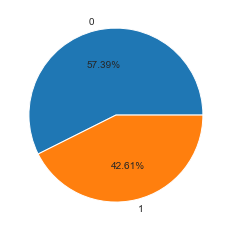

In [50]:
#Piechart visualisation
plt.pie(data_polarity['score'].value_counts(),labels=data_polarity['score'].unique(),autopct='%1.2f%%')
plt.show()

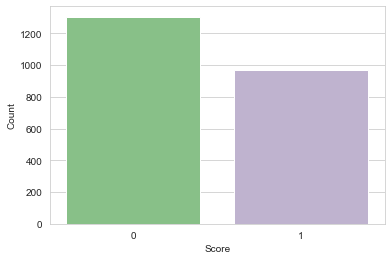

In [51]:
#Barchart Visualisation
sns.barplot(x=data_polarity['score'].unique(),y=data_polarity['score'].value_counts(),data=data_polarity,palette='Accent')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

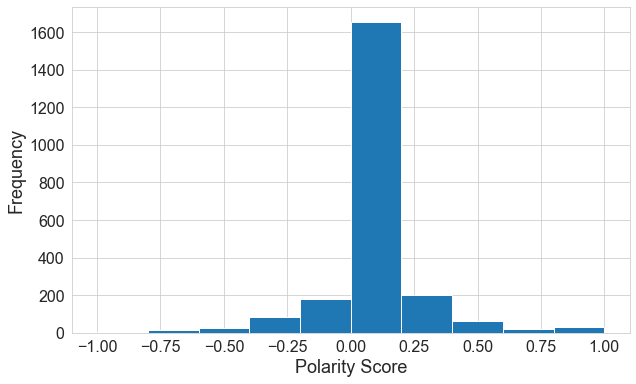

In [52]:
fig = plt.figure(figsize=(10, 6))
covid_data['polarity'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig.savefig("./figures/polarity_hist.png")

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

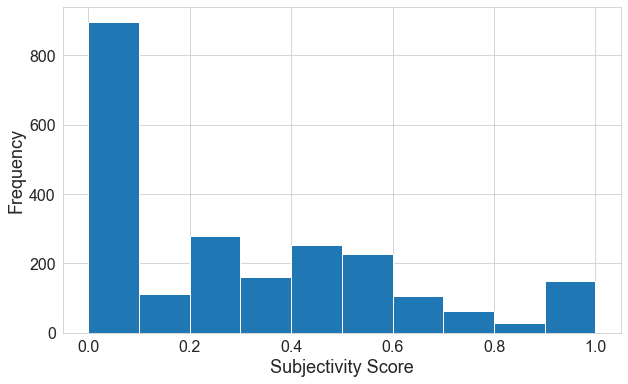

In [53]:

fig = plt.figure(figsize=(10, 6))
covid_data['subjectivity'].hist()
plt.xlabel('Subjectivity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig.savefig("./figures/subjectivity_hist.png")

Inspection

In [54]:
# inspect the most negatively charged tweets
covid_data.sort_values(by='polarity', ascending=True)[['ConsumerComplaint', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

ConsumerComplaint  polarity  subjectivity
0  reopen mosque  ease restriction jumpthis terri... -1.000000      1.000000
1  confirm  worst affect region date swift transp... -1.000000      1.000000
2   discard outrageous  expire   discard heap exp... -1.000000      1.000000
3  dfc ifc eib afd boost   production  base  manu... -0.800000      1.000000
4  hate motherland ngal fatherland manage  verge ... -0.800000      0.900000
5  chiefstick law roast ask sensitivity specifici... -0.800000      1.000000
6  hiringvacancy operation officer emergency  res... -0.800000      1.000000
7   232  surpass malta mauritius climb 100 infect... -0.714286      0.857143
8  look  model eliminate  19  isolate infect  sic... -0.714286      0.857143
9  painful thing rant rant recover cause statisti... -0.700000      0.900000

In [55]:
# inspect the most positively charged tweets
covid_data.sort_values(by='polarity', ascending=False)[['ConsumerComplaint', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

ConsumerComplaint  polarity  subjectivity
0  excellent news  team europe agree build manufa...       1.0          1.00
1  7 doctor 100000 people best world handle   sho...       1.0          0.30
2              mosque school business reopen  best         1.0          0.30
3  excellent news  team europe agree build manufa...       1.0          1.00
4  impressive thing happen   254 fire  director d...       1.0          1.00
5  mr mwenda think collective effort government c...       1.0          0.30
6  7 doctor 100000  best world handle people  sho...       1.0          0.30
7  doctor nurse care worker brilliant jobbut comp...       0.9          1.00
8  great relief  amid  19 biontech company develo...       0.8          0.75
9  republic  team europe agree build manufacturin...       0.8          0.90

In [56]:
# inspect the most subjective content (NOTE: subjectivity scale ranges from 0 to 1)
covid_data.sort_values(by='subjectivity', ascending=True)[['ConsumerComplaint', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

ConsumerComplaint  polarity  subjectivity
0   stretch  care system stop   local  stretch  c...       0.0           0.0
1  antony blinken visit  kenya  secretary state a...       0.0           0.0
2   faster  usa government covid2019 melanie wildman       0.0           0.0
3  republic  team europe agree build manufacturin...       0.0           0.0
4                                                          0.0           0.0
5                                                          0.0           0.0
6                                                          0.0           0.0
7               shock develop   cost   60ventilator        0.0           0.0
8  subsaharan  act stem spread  south  impose mil...       0.0           0.0
9                           biontech build     2022        0.0           0.0

In [57]:

# inspect the most objective tweets
covid_data.sort_values(by='subjectivity', ascending=False)[['ConsumerComplaint', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

ConsumerComplaint  polarity  subjectivity
0   host africas    whats know far    host africa...       0.1           1.0
1   host africas   whats know far     host africa...       0.1           1.0
2   host africas   whats know far     host africa...       0.1           1.0
3   host africas    whats know far    host africa...       0.1           1.0
4   host africas    whats know far     host     w...       0.1           1.0
5  reality   fight try leverage resource experien...       0.3           1.0
6   host africas    whats know far    host africa...       0.1           1.0
7  ecowas union didnt leadership  theyve contain ...      -0.5           1.0
8   budget  showcasing possible model curb  work ...       0.0           1.0
9    giant  import spare part     assemble selling         0.0           1.0

Time-Series Sentiment Analysis

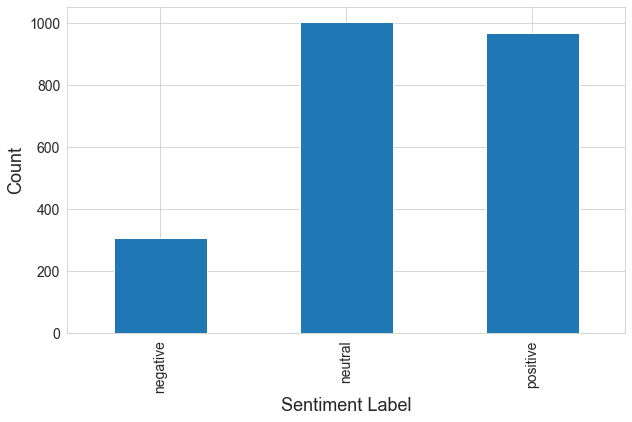

<Figure size 432x288 with 0 Axes>

In [58]:
# polarity values ranging from -1 to 1 are really useful for sentiment analysis
# but let's convert our data to 3 classes (negative, neutral, and positive) so that we can visualize it
criteria = [covid_data['polarity'].between(-1, -0.01), covid_data['polarity'].between(-0.01, 0.01), covid_data['polarity'].between(0.01, 1)]
values = ['negative', 'neutral', 'positive']
covid_data['sentiment'] = np.select(criteria, values, 0)

# plot sentiment counts
fig = plt.figure(figsize=(10, 6))
covid_data['sentiment'].value_counts().sort_index().plot.bar()
plt.xlabel('Sentiment Label', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.tight_layout()
#fig.savefig("./figures/sentiment_value_counts", bbox_inches='tight');

In [59]:
#!pip install plotly

In [60]:
#!pip install wordcloud

In [61]:
#!pip install gensim
#!pip install gensim
#!pip install gensim==3.8.3

In [62]:
#!pip install pyLDAvis

In [71]:
# Import the following libraries


# Visualization libraries
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
from PIL import Image # for world cloud image


# To change date to datetime
from datetime import datetime
import re 

from collections import Counter
import string
import scipy.sparse

# Gensim libraries
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis
from gensim.models import CoherenceModel
from gensim import matutils

# To show all the columns
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)

# to pickle dataframe
import pickle
# Avoid warnings
import warnings
warnings.filterwarnings("ignore")


# Enable logging for gensim - optional but important
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [64]:
#  Let's pickle it for later use
clean_review = covid_data['ConsumerComplaint']

In [65]:
clean_review

0                                                                                                                                                                              stretch  care system stop   local  stretch  care system stop 
1       2022 break  summit cohosted gavi alongside germany g7 president ghana indonesia g20 president  union chair reaffirm support covax  global solidarity fight  akufoaddo lead world leader commit 48 billion help break  amaghanaonlin 
2                                                                                                                                                              summary page travel advice  update information advice  follow  travel advice 
3                                                                                                                                                                                                                    60 ventilator go viral 
4                                                   

In [66]:
#!pip install spacy

In [72]:
import spacy
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#stop_words.extend(['covid19','pandemic','people','poverty','hunger'])
nlp = spacy.load('en_core_web_sm')

def lematized_review(text): # text
    rev_text = nlp(text)
    # Extract lematized words in lower case format if not digits, not punctuation, not stopword, and length not less than 2
    rev_text = ([token.lemma_.lower() for token in rev_text if not token.is_stop and token.text not in STOPWORDS and not token.is_punct and len(token.text) > 3])
    return rev_text

In [68]:
%%time
# Applying the function on the reviews 

clean_brand_review = clean_review.apply(lematized_review)

CPU times: total: 18.5 s
Wall time: 18.9 s


In [69]:
clean_brand_review

0                                                                                                                                                                                      [stretch, care, system, stop, local, stretch, care, system, stop]
1       [2022, break, summit, cohoste, gavi, alongside, germany, president, ghana, indonesia, president, union, chair, reaffirm, support, covax, global, solidarity, fight, akufoaddo, lead, world, leader, commit, billion, help, break, amaghanaonlin]
2                                                                                                                                                                   [summary, page, travel, advice, update, information, advice, follow, travel, advice]
3                                                                                                                                                                                                                              [    , ventilator, viral]
4   

In [70]:

%%time
# Create Dictionary
id2word_1 = corpora.Dictionary(clean_brand_review)

# Create Corpus: Term Document Frequency
corpus_1 = [id2word_1.doc2bow(review) for review in clean_brand_review]

 # Build LDA model
ldamodel = LdaMulticore(corpus= corpus_1, num_topics =30, id2word=id2word_1,chunksize=2000, passes=50,per_word_topics=True)

CPU times: total: 30.3 s
Wall time: 30.9 s


chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory. passes controls how often we train the model on the entire corpus

In [71]:
from pprint import pprint

pprint(ldamodel.show_topics(formatted=False))

[(12,
  [('mendy', 0.05843244),
   ('positive', 0.056716047),
   ('koulibaly', 0.041447915),
   ('edouard', 0.03722495),
   ('kalidou', 0.033265352),
   ('goalkeeper', 0.020316504),
   ('afcon', 0.019295186),
   ('zimbabwe', 0.015378179),
   ('chelsea', 0.014754235),
   ('match', 0.013504514)]),
 (10,
  [('state', 0.05699937),
   ('united', 0.056788318),
   ('germany', 0.04957531),
   ('indonesia', 0.046042103),
   ('belize', 0.043304335),
   ('global', 0.038298823),
   ('summit', 0.037508313),
   ('joint', 0.0255663),
   ('statement', 0.024831079),
   ('second', 0.023658644)]),
 (22,
  [('partner', 0.075747035),
   ('ghana', 0.06740755),
   ('malaria', 0.053075813),
   ('biontech', 0.05175237),
   ('johnson', 0.021415908),
   ('miss', 0.016811205),
   ('game', 0.013787547),
   ('nation', 0.011968176),
   ('151200', 0.011962995),
   ('world', 0.0111851115)]),
 (23,
  [('faso', 0.030966096),
   ('burkina', 0.030380186),
   ('mali', 0.025435997),
   ('hard', 0.020884221),
   ('worker', 0

In [72]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value

print('\nPerplexity: ', ldamodel.log_perplexity(corpus_1))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=clean_brand_review, dictionary=id2word_1, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Basic Ldamodel Coherence Score: ', coherence_lda)


Perplexity:  -7.451030223556772

 Basic Ldamodel Coherence Score:  0.4094337591368393


### Notes

perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.

The coherence score is used in assessing the quality of the learned topics, the closer to 1 the better

In [73]:
"""
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'}) 

import gensim
#os.environ['MALLET_HOME'] = r'C:/mallet-2.0.8/'

#You should update this path as per the path of Mallet directory on your system.
mallet_path ='C:\\mallet-2.0.8\\bin\\mallet' 
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_1, num_topics=20, id2word=id2word_1)

#pprint(ldamallet.show_topics(formatted=False))
"""

"\nimport os\nfrom gensim.models.wrappers import LdaMallet\nos.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'}) \n\nimport gensim\n#os.environ['MALLET_HOME'] = r'C:/mallet-2.0.8/'\n\n#You should update this path as per the path of Mallet directory on your system.\nmallet_path ='C:\\mallet-2.0.8\\bin\\mallet' \n#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_1, num_topics=20, id2word=id2word_1)\n\n#pprint(ldamallet.show_topics(formatted=False))\n"

In [74]:
import gensim
#!python -m pip install -U gensim
#!pip3 install gensim==3.8.3

In [75]:
import os
from gensim.models.wrappers import LdaMallet

from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = 'C:/mallet-2.0.8/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.


In [76]:
#conda install -c conda-forge mallet

In [77]:
import gensim
ldamallet = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=corpus_1, num_topics=20, id2word=id2word_1
)
pprint(ldamallet.show_topics(formatted=False))

[(5,
  [('announce', 0.05183199285075961),
   ('count', 0.05093833780160858),
   ('manufacture', 0.040214477211796246),
   ('jazeera', 0.032171581769437),
   ('effort', 0.029490616621983913),
   ('early', 0.02323503127792672),
   ('home', 0.021447721179624665),
   ('press', 0.01876675603217158),
   ('rapid', 0.017873100983020553),
   ('diagnostic', 0.0160857908847185)]),
 (7,
  [('west', 0.06398687448728466),
   ('burkina', 0.04019688269073011),
   ('worker', 0.03773584905660377),
   ('gambia', 0.03691550451189499),
   ('faso', 0.03527481542247744),
   ('mali', 0.031173092698933553),
   ('region', 0.029532403609515995),
   ('2020', 0.02789171452009844),
   ('spread', 0.02789171452009844),
   ('hard', 0.027071369975389663)]),
 (9,
  [('month', 0.04247787610619469),
   ('high', 0.04247787610619469),
   ('rate', 0.03982300884955752),
   ('expire', 0.03893805309734513),
   ('200000', 0.034513274336283185),
   ('recovery', 0.033628318584070796),
   ('record', 0.030973451327433628),
   ('loc

In [78]:
### Show Topics
#from pprint import pprint
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=clean_brand_review, dictionary=id2word_1, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\n Mallet Coherence Score: ', coherence_ldamallet)


 Mallet Coherence Score:  0.4149703787243385


In [79]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=ldamallet, texts=clean_brand_review, dictionary=id2word_1, coherence="u_mass")
coherence_lda = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4149703787243385


### To find the optimum number of topics

In [80]:
# Defining a function to get coherence score
def my_coherence_vals(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus_1, num_topics=num_topics, id2word=id2word_1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [81]:
# To get the coherence values
model_list, coherence_values = my_coherence_vals(dictionary=id2word_1, corpus=corpus_1, 
                                                 texts=clean_brand_review, start=2, limit=26, step=6)

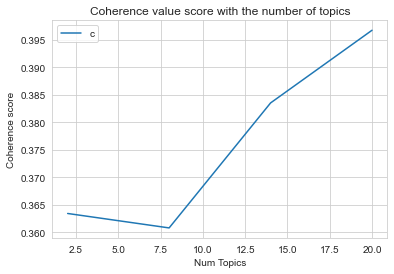

In [82]:
# Show graph for the coherence value scores vs number of topics
limit=26; start=2; step=6;
topics = range(start, limit, step)
plt.plot(topics, coherence_values)
plt.title("Coherence value score with the number of topics")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Print the coherence scores
for best, cv in zip(topics, coherence_values):
    print("Topic ", best, " has Coherence Value of", round(cv, 4))

In [83]:
# printing the best topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.052*"host" + 0.045*"africa" + 0.033*"positive" + 0.033*"news" + '
  '0.028*"nation" + 0.024*"mendy" + 0.017*"koulibaly" + 0.015*"gambia" + '
  '0.015*"edouard" + 0.014*"kalidou"'),
 (1,
  '0.067*"world" + 0.038*"confirm" + 0.037*"kenya" + 0.032*"ministry" + '
  '0.031*"woman" + 0.029*"response" + 0.024*"thursday" + 0.023*"good" + '
  '0.018*"positive" + 0.018*"dakar"'),
 (2,
  '0.040*"fight" + 0.019*"senegalese" + 0.018*"virus" + 0.017*"access" + '
  '0.016*"leader" + 0.015*"restriction" + 0.015*"child" + 0.011*"vaccination" '
  '+ 0.010*"reopen" + 0.010*"launch"'),
 (3,
  '0.052*"state" + 0.041*"global" + 0.034*"united" + 0.027*"year" + '
  '0.023*"germany" + 0.021*"2021" + 0.021*"indonesia" + 0.019*"summit" + '
  '0.019*"belize" + 0.019*"government"'),
 (4,
  '0.050*"people" + 0.041*"cost" + 0.039*"develop" + 0.034*"result" + '
  '0.028*"minute" + 0.028*"million" + 0.022*"ventilator" + 0.018*"count" + '
  '0.017*"begin" + 0.016*"madagascar"'),
 (5,
  '0.025*"west" + 0.022*"

In [84]:
"""
#Visualize the topic
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel, corpus=corpus_1, dictionary=id2word_1,sort_topics=False)
LDAvis_prepared
"""

'\n#Visualize the topic\npyLDAvis.enable_notebook()\nLDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel, corpus=corpus_1, dictionary=id2word_1,sort_topics=False)\nLDAvis_prepared\n'

In [85]:
"""
# Save the visulaization to html
pyLDAvis.save_html(LDAvis_prepared, 'LdaModel_viz.html')
"""

"\n# Save the visulaization to html\npyLDAvis.save_html(LDAvis_prepared, 'LdaModel_viz.html')\n"

### EXTRACTING MORE MEANING FROM THE REVIEWS

In [86]:
# Define the sentence topics
def sentence_topics(ldamodel=None, corpus=corpus_1, texts=clean_brand_review):
    # Init output
    topics_df = pd.DataFrame()

    # Looping through the documents to find the main topics
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        # look for the Dominant topic, % contribution and Keywords 
        for j, (topic_num, prop_topic) in enumerate(row):
            
            # Diplay the dominant topics
            if j == 0:  
                dom = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in dom])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,2)*100, topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Review_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Concatenate the text and the topics_df
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)


df_topic_sents_keywords = sentence_topics(ldamodel=ldamodel, corpus=corpus_1, texts=clean_brand_review)

# Format
dominant_review_topic = df_topic_sents_keywords.reset_index()
dominant_review_topic.columns = ['Review_No', 'Dominant_Review_Topic', 'Percent_contr_per_topic', 'Review_Keywords', 'Original review']

# Show
dominant_review_topic.head(10)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
0          0                     28                89.999998   
1          1                     21                60.000002   
2          2                     26                91.000003   
3          3                     27                75.999999   
4          4                      6                94.999999   
5          5                      6                51.999998   
6          6                     27                38.999999   
7          7                     22                58.999997   
8          8                     29                49.000001   
9          9                      8                68.000001   

                                                                      Review_Keywords  \
0           food, stretch, information, entry, care, fight, stop, system, news, price   
1     need, president, expose, fish, industry, visit, south, build, ghana, production   
2          travel, virus, total, summary, coast, care, death, ivory, lockdown, people   
3        develop, ventilator,     , fund, world, local, begin, trial, weekly, include   
4             cost, result, minute,      , hour, trial, success, develop, lead, death   
5             cost, result, minute,      , hour, trial, success, develop, lead, death   
6        develop, ventilator,     , fund, world, local, begin, trial, weekly, include   
7       partner, ghana, malaria, biontech, johnson, miss, game, nation, 151200, world   
8            good, global, news, update, death, support, football, sport, late, total   
9          , jazeera, region, cheap, death, confirm, arrive, morning, burkina, gambia   

                                                                                                                                                                                                                                                                                    Original review  
0                                                                                                                                                                                                                                 [stretch, care, system, stop, local, stretch, care, system, stop]  
1                                                  [2022, break, summit, cohoste, gavi, alongside, germany, president, ghana, indonesia, president, union, chair, reaffirm, support, covax, global, solidarity, fight, akufoaddo, lead, world, leader, commit, billion, help, break, amaghanaonlin]  
2                                                                                                                                                                                                              [summary, page, travel, advice, update, information, advice, follow, travel, advice]  
3                                                                                                                                                                                                                                                                         [    , ventilator, viral]  
4                                                                                                              [kenya, heighten, exist, vulnerability, inequality, lead, increase, longterm, risk, exploitation, today, launch, late, research, summary, impact, resilience, thread, modernslavery]  
5                                                                                                                                                                                                                                                                                           [     ]  
6                                                                                                                                                                                               [week, start, notemadagascar, launch, africa, cure, death, record,  

In [87]:
dominant_review_topic.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/reviewstwitter.csv", index=False)

<AxesSubplot:xlabel='Dominant_Review_Topic', ylabel='Percent_contr_per_topic'>

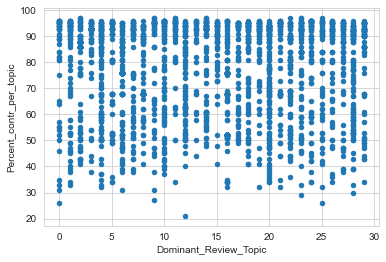

In [88]:
dominant_review_topic[dominant_review_topic['Dominant_Review_Topic'] < 100].plot.scatter(x='Dominant_Review_Topic', y='Percent_contr_per_topic')

In [89]:


# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

# The Dataframe
sent_topics_df = pd.DataFrame()

topics_out = df_topic_sents_keywords.groupby('Dominant_Review_Topic')

for i, j in topics_out:
    sent_topics_df = pd.concat([sent_topics_df,j.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

    
sent_topics_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_df.columns = ['Topic_Num', "Percent_contr_per_topic", "Review_Keywords", "Original review"]

# Display the 8 topics
sent_topics_df.head(8)

Topic_Num  Percent_contr_per_topic  \
0          0                95.999998   
1          1                95.999998   
2          2                97.000003   
3          3                95.999998   
4          4                95.999998   
5          5                95.999998   
6          6                94.999999   
7          7                95.999998   

                                                                         Review_Keywords  \
0       response, education, access, start, kenya, program, egypt, impact, join, biotech   
1             expire, 200000, month, record, ghana, past, monday, demand, december, head   
2                  know, host, africa,     , africas, news, fact, president,      , late   
3  confirm, ministry, thursday, positive, woman, world, second, husband, province, fifth   
4        develop, ventilator, madagascar, cure, recovery, need, world, rate, come, print   
5      report,        , tunisia, arabia, saudi, latvia, state, morocco, sequence, jordan   
6                cost, result, minute,      , hour, trial, success, develop, lead, death   
7      south, develop, system, capacity, india, future, partnership, stop, sierra, boost   

                                                                                                                                                                                                                                          Original review  
0        [videoconference, parliamentary, delegation, cuba, discuss, tuesday, prevention, confrontation, international, cooperation, havana, cuba, videoconference, parliamentary, delegation, cuba, discuss, tuesday, prevention, confrontation, intern]  
1                                                                 [200000, expire, past, month, 200000, expire, december, demand, slow, head, immunisation, programme, monday, 200000, expire, past, month, 200000, expire, december, demand, slow, head]  
2  [president, positive, finish, visit, west, state, include, cote, divoire, ghana, follow, late, news, ramaphosa, south, president, cyril, ramaphosa, receive, treatment, mild, symptom, positive, virus, presidency, statement, release, sunday, night]  
3                                                                       [reopen, mosque, ease, restriction, jump, confirm, senegalese, president, macky, sall, announce, reopen, mosque, church, ease, restriction, impose, contain, large, oneday, jump]  
4                                                 [white, house, continue, tremendous, effort, donate, global, supply, today, announce, million, johnson, johnson, head, gambia, zambia, press, brief, press, secretary, psaki, july, 2021, white, house]  
5                                                                  [year, todayandorra, indonesia, jordan, latvia, morocco, portugal, saudi, arabia, tunisia, report, report, local, transmission, cite, increase, european, increase, risk, level, high]  
6                                                                    [kenya, heighten, exist, vulnerability, inequality, lead, increase, longterm, risk, exploitation, today, launch, late, research, summary, impact, resilience, thread, modernslavery]  
7                                                                      [ebola, decimate, west, 2014, community, leader, learn, outbreak, establish, permanent, emergency, response, systemthat, mean, ready, tackle, arrive, stretch, care, system, stop]

In [90]:
sent_topics_df.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/sentencestwitter.csv", index=False)

In [91]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Review_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Review_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

Dominant_Topic  \
0              28   
1              21   
2              26   
3              27   
4               6   
5               6   
6              27   
7              22   
8              29   
9               8   

                                                                       Topic_Keywords  \
0           food, stretch, information, entry, care, fight, stop, system, news, price   
1     need, president, expose, fish, industry, visit, south, build, ghana, production   
2          travel, virus, total, summary, coast, care, death, ivory, lockdown, people   
3        develop, ventilator,     , fund, world, local, begin, trial, weekly, include   
4             cost, result, minute,      , hour, trial, success, develop, lead, death   
5             cost, result, minute,      , hour, trial, success, develop, lead, death   
6        develop, ventilator,     , fund, world, local, begin, trial, weekly, include   
7       partner, ghana, malaria, biontech, johnson, miss, game, nation, 151200, world   
8            good, global, news, update, death, support, football, sport, late, total   
9          , jazeera, region, cheap, death, confirm, arrive, morning, burkina, gambia   

   Num_Documents  Perc_Documents  
0           47.0          0.0207  
1           75.0          0.0330  
2          105.0          0.0462  
3           86.0          0.0378  
4          106.0          0.0466  
5           60.0          0.0264  
6          107.0          0.0471  
7           65.0          0.0286  
8           74.0          0.0325  
9           52.0          0.0229

In [92]:
df_dominant_topics.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/dominantstwitter.csv", index=False)


In [93]:
# Modify Dataframe 2 by reseting the Index and adding a new column EmpID
data_polarity['EmpID'] = data_polarity.index
data_polarity.reset_index(inplace=True)

In [117]:
data_merge = dominant_review_topic.merge(data_polarity, left_index=True, right_on='EmpID')
data_merge = data_merge.set_index('EmpID')
data_merge.head(10)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
0              0                     28                89.999998   
1              1                     21                60.000002   
2              2                     26                91.000003   
3              3                     27                75.999999   
4              4                      6                94.999999   
5              5                      6                51.999998   
6              6                     27                38.999999   
7              7                     22                58.999997   
8              8                     29                49.000001   
9              9                      8                68.000001   

                                                                          Review_Keywords  \
EmpID                                                                                       
0               food, stretch, information, entry, care, fight, stop, system, news, price   
1         need, president, expose, fish, industry, visit, south, build, ghana, production   
2              travel, virus, total, summary, coast, care, death, ivory, lockdown, people   
3            develop, ventilator,     , fund, world, local, begin, trial, weekly, include   
4                 cost, result, minute,      , hour, trial, success, develop, lead, death   
5                 cost, result, minute,      , hour, trial, success, develop, lead, death   
6            develop, ventilator,     , fund, world, local, begin, trial, weekly, include   
7           partner, ghana, malaria, biontech, johnson, miss, game, nation, 151200, world   
8                good, global, news, update, death, support, football, sport, late, total   
9              , jazeera, region, cheap, death, confirm, arrive, morning, burkina, gambia   

                                                                                                                                                                                                                                                                                        Original review  \
EmpID                                                                                                                                                                                                                                                                                                     
0                                                                                                                                                                                                                                     [stretch, care, system, stop, local, stretch, care, system, stop]   
1                                                      [2022, break, summit, cohoste, gavi, alongside, germany, president, ghana, indonesia, president, union, chair, reaffirm, support, covax, global, solidarity, fight, akufoaddo, lead, world, leader, commit, billion, help, break, amaghanaonlin]   
2                                                                                                                                                                                                                  [summary, page, travel, advice, update, information, advice, follow, travel, advice]   
3                                                                                                                                                                                                                                                                             [    , ventilator, viral]   
4                                                                                                                  [kenya, heighten, exist, vulnerability, inequality, lead, increase, longterm, risk, exploitation, today, launch, late, research, summary, impact, resilience, thread

In [ ]:
tt

In [118]:
data_merge.to_excel("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/mergestwitter.xlsx", index=False)

In [119]:
#C:\Users\harys\OneDrive\Documents\covid
dat_merge = data_merge

In [123]:
#dat_merge2 = pd.read_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/mergestwitter.csv", encoding = "UTF-8")
#dat_merge21 = pd.read_excel('C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/mergestwitter.xlsx', sheet_name='Sheet1')

In [124]:
dat_merge21.head()

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
0          0                     28                89.999998   
1          1                     21                60.000002   
2          2                     26                91.000003   
3          3                     27                75.999999   
4          4                      6                94.999999   

                                                                   Review_Keywords  \
0        food, stretch, information, entry, care, fight, stop, system, news, price   
1  need, president, expose, fish, industry, visit, south, build, ghana, production   
2       travel, virus, total, summary, coast, care, death, ivory, lockdown, people   
3     develop, ventilator,     , fund, world, local, begin, trial, weekly, include   
4          cost, result, minute,      , hour, trial, success, develop, lead, death   

                                                                                                                                                                                                                                                                                            Original review  \
0                                                                                                                                                                                                                       ['stretch', 'care', 'system', 'stop', 'local', 'stretch', 'care', 'system', 'stop']   
1  ['2022', 'break', 'summit', 'cohoste', 'gavi', 'alongside', 'germany', 'president', 'ghana', 'indonesia', 'president', 'union', 'chair', 'reaffirm', 'support', 'covax', 'global', 'solidarity', 'fight', 'akufoaddo', 'lead', 'world', 'leader', 'commit', 'billion', 'help', 'break', 'amaghanaonlin']   
2                                                                                                                                                                                                  ['summary', 'page', 'travel', 'advice', 'update', 'information', 'advice', 'follow', 'travel', 'advice']   
3                                                                                                                                                                                                                                                                           ['    ', 'ventilator', 'viral']   
4                                                                                ['kenya', 'heighten', 'exist', 'vulnerability', 'inequality', 'lead', 'increase', 'longterm', 'risk', 'exploitation', 'today', 'launch', 'late', 'research', 'summary', 'impact', 'resilience', 'thread', 'modernslavery']   

   index  \
0      0   
1      1   
2      2   
3      3   
4      4   

                                                                                                                                                                                                                      ConsumerComplaint  \
0                                                                                                                                                                         stretch  care system stop   local  stretch  care system stop    
1  2022 break  summit cohosted gavi alongside germany g7 president ghana indonesia g20 president  union chair reaffirm support covax  global solidarity fight  akufoaddo lead world leader commit 48 billion help break  amaghanaonlin    
2                                                                                                                                                         summary page travel advice  update information advice  follow  travel advice    
3                                                                                                                                                                                                               60 ventilator go viral    
4                                 

In [121]:
dat_merge.head()

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
0              0                     28                89.999998   
1              1                     21                60.000002   
2              2                     26                91.000003   
3              3                     27                75.999999   
4              4                      6                94.999999   

                                                                       Review_Keywords  \
EmpID                                                                                    
0            food, stretch, information, entry, care, fight, stop, system, news, price   
1      need, president, expose, fish, industry, visit, south, build, ghana, production   
2           travel, virus, total, summary, coast, care, death, ivory, lockdown, people   
3         develop, ventilator,     , fund, world, local, begin, trial, weekly, include   
4              cost, result, minute,      , hour, trial, success, develop, lead, death   

                                                                                                                                                                                                                                        Original review  \
EmpID                                                                                                                                                                                                                                                     
0                                                                                                                                                                                     [stretch, care, system, stop, local, stretch, care, system, stop]   
1      [2022, break, summit, cohoste, gavi, alongside, germany, president, ghana, indonesia, president, union, chair, reaffirm, support, covax, global, solidarity, fight, akufoaddo, lead, world, leader, commit, billion, help, break, amaghanaonlin]   
2                                                                                                                                                                  [summary, page, travel, advice, update, information, advice, follow, travel, advice]   
3                                                                                                                                                                                                                             [    , ventilator, viral]   
4                                                                  [kenya, heighten, exist, vulnerability, inequality, lead, increase, longterm, risk, exploitation, today, launch, late, research, summary, impact, resilience, thread, modernslavery]   

       index  \
EmpID          
0          0   
1          1   
2          2   
3          3   
4          4   

                                                                                                                                                                                                                          ConsumerComplaint  \
EmpID                                                                                                                                                                                                                                         
0                                                                                                                                                                             stretch  care system stop   local  stretch  care system stop    
1      2022 break  summit cohosted gavi alongside germany g7 president ghana indonesia g20 president  union chair reaffirm support covax  global solidarity fight  akufoaddo lead world leader commit 48 billion help break  amaghanaonlin    
2                                                                       

In [125]:
a = dat_merge['Review_Keywords'].unique()
#a.sort()
print(a)


['food, stretch, information, entry, care, fight, stop, system, news, price'
 'need, president, expose, fish, industry, visit, south, build, ghana, production'
 'travel, virus, total, summary, coast, care, death, ivory, lockdown, people'
 'develop, ventilator,     , fund, world, local, begin, trial, weekly, include'
 'cost, result, minute,      , hour, trial, success, develop, lead, death'
 'partner, ghana, malaria, biontech, johnson, miss, game, nation, 151200, world'
 'good, global, news, update, death, support, football, sport, late, total'
 '        , jazeera, region, cheap, death, confirm, arrive, morning, burkina, gambia'
 'state, united, germany, indonesia, belize, global, summit, joint, statement, second'
 'know, host, africa,     , africas, news, fact, president,      , late'
 '      , count, cost, thecost, jazeera, development, sign, agreement,         , response'
 'transfer, sign, deal, global, boost, tech, agency, capacity, 2022, early'
 'mendy, positive, koulibaly, edouard

In [157]:
dat_merge2 = dat_merge.copy()
Topicsw = {'food, stretch, information, entry, care, fight, stop, system, news, price':'hunger report',
 'need, president, expose, fish, industry, visit, south, build, ghana, production':'government policy',
 'travel, virus, total, summary, coast, care, death, ivory, lockdown, people':'public protect',
 'develop, ventilator,     , fund, world, local, begin, trial, weekly, include':'fund policy',
 'cost, result, minute,      , hour, trial, success, develop, lead, death':'news report',
 'partner, ghana, malaria, biontech, johnson, miss, game, nation, 151200, world':'vaccination report',
 'good, global, news, update, death, support, football, sport, late, total':'news report',
 '        , jazeera, region, cheap, death, confirm, arrive, morning, burkina, gambia':'news report',
 'state, united, germany, indonesia, belize, global, summit, joint, statement, second':'world report',
 'know, host, africa,     , africas, news, fact, president,      , late':'news report',
 '      , count, cost, thecost, jazeera, development, sign, agreement,         , response':'news report',
 'transfer, sign, deal, global, boost, tech, agency, capacity, 2022, early':'vaccination report',
 'mendy, positive, koulibaly, edouard, kalidou, goalkeeper, afcon, zimbabwe, chelsea, match':'news report',
 'south, develop, system, capacity, india, future, partnership, stop, sierra, boost':'world report',
 'people, start, child, family, medium, italy, kill, senegalese, chad, sant':'public protect',
 'kenya, egypt, south, production, mrna, tunisia, receive, technology, continent, facility':'health industry',
 'develop, ventilator, madagascar, cure, recovery, need, world, rate, come, print':'vaccination report',
 'faso, burkina, mali, hard, worker, informal, reopen, restriction, mosque, ease':'public potect',
 'expire, 200000, month, record, ghana, past, monday, demand, december, head':'news report',
 'people, manufacture, doctor, help, 100000, announce, handle, kenya, seven, tackle':'health industry',
 'people, state, report, path, fight, worker, impact, crisis, woman, datum':'public protect',
 '2021, year, myanmar, colombiahaiti, freenigeria, march, dakar, fight, forum, technical':'news report',
 'patient, lack, hospital, work, west, capacity, production, doctor, surge, woman':'healthcare policy',
 'confirm, ministry, thursday, positive, woman, world, second, husband, province, fifth':'news report',
 'biontech, company, german, mrna, ghana, finish, fill, biotechnology, package, manufacture':'health industry',
 'response, education, access, start, kenya, program, egypt, impact, join, biotech':'health industry',
 'report,        , tunisia, arabia, saudi, latvia, state, morocco, sequence, jordan':'world report',
 'manufacture, europe, build, team, agree, republic, endemic, disease, support, credit':'fund policy',
 'kenya, state, week, secretary, blinken, begin, antony, change, expect, president':'world report',
 'economic, johnson, million, want, people, send, affect, response, good, system':'public protect'}          
        

dat_merge2["Topics"]=dat_merge2["Review_Keywords"]
dat_merge2.Topics = dat_merge2.Topics.map(Topicsw).fillna(dat_merge2.Topics)
#df = pd.DataFrame(dic)
#df.name = df.name.map({'red': 0, 'blue': 1}).fillna(df.name)

dat_merge2["Topics1"]=dat_merge2["Dominant_Review_Topic"]
dat_merge2.Topics1 = dat_merge2.Topics1.map(Topicsw).fillna(dat_merge2.Topics)





dat_merge2.head(10)


Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
0              0                     28                89.999998   
1              1                     21                60.000002   
2              2                     26                91.000003   
3              3                     27                75.999999   
4              4                      6                94.999999   
5              5                      6                51.999998   
6              6                     27                38.999999   
7              7                     22                58.999997   
8              8                     29                49.000001   
9              9                      8                68.000001   

                                                                          Review_Keywords  \
EmpID                                                                                       
0               food, stretch, information, entry, care, fight, stop, system, news, price   
1         need, president, expose, fish, industry, visit, south, build, ghana, production   
2              travel, virus, total, summary, coast, care, death, ivory, lockdown, people   
3            develop, ventilator,     , fund, world, local, begin, trial, weekly, include   
4                 cost, result, minute,      , hour, trial, success, develop, lead, death   
5                 cost, result, minute,      , hour, trial, success, develop, lead, death   
6            develop, ventilator,     , fund, world, local, begin, trial, weekly, include   
7           partner, ghana, malaria, biontech, johnson, miss, game, nation, 151200, world   
8                good, global, news, update, death, support, football, sport, late, total   
9              , jazeera, region, cheap, death, confirm, arrive, morning, burkina, gambia   

                                                                                                                                                                                                                                                                                        Original review  \
EmpID                                                                                                                                                                                                                                                                                                     
0                                                                                                                                                                                                                                     [stretch, care, system, stop, local, stretch, care, system, stop]   
1                                                      [2022, break, summit, cohoste, gavi, alongside, germany, president, ghana, indonesia, president, union, chair, reaffirm, support, covax, global, solidarity, fight, akufoaddo, lead, world, leader, commit, billion, help, break, amaghanaonlin]   
2                                                                                                                                                                                                                  [summary, page, travel, advice, update, information, advice, follow, travel, advice]   
3                                                                                                                                                                                                                                                                             [    , ventilator, viral]   
4                                                                                                                  [kenya, heighten, exist, vulnerability, inequality, lead, increase, longterm, risk, exploitation, today, launch, late, research, summary, impact, resilience, thread

<AxesSubplot:xlabel='polarity', ylabel='Percent_contr_per_topic'>

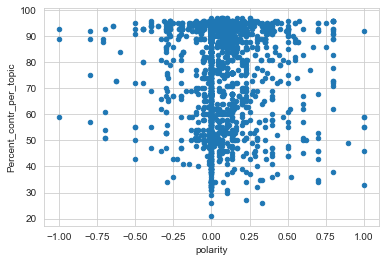

In [158]:
dat_merge[dat_merge['Dominant_Review_Topic'] < 100].plot.scatter(x='polarity', y='Percent_contr_per_topic')

In [159]:
poke = dat_merge2.groupby(['Topics']).mean()[['subjectivity', 'polarity']]

<AxesSubplot:xlabel='Topics'>

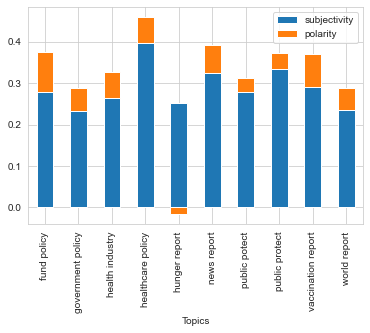

In [160]:
poke.plot.bar(stacked=True)

<AxesSubplot:xlabel='Topics'>

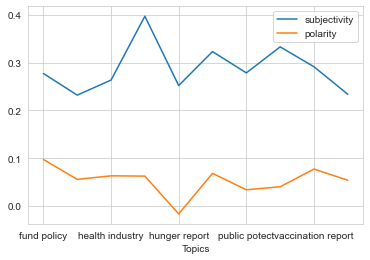

In [161]:
poke.plot.line()

In [162]:
poke2 = dat_merge.groupby('Dominant_Review_Topic').mean()[['subjectivity', 'polarity','Percent_contr_per_topic']]

<AxesSubplot:xlabel='Dominant_Review_Topic'>

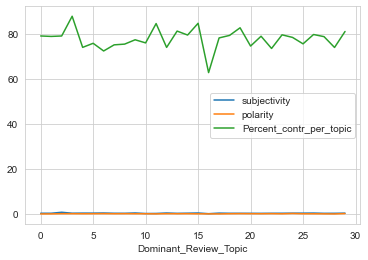

In [163]:
poke2.plot.line()

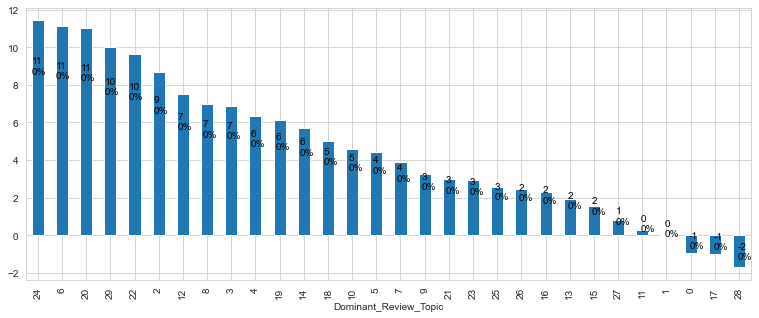

In [164]:
x = dat_merge.groupby(['Dominant_Review_Topic']).sum().copy()
ax = x.polarity.sort_values(ascending=False).plot(kind='bar', figsize=(13, 5));

for p in ax.patches:
    ax.annotate(str( round( p.get_height() ) ) + "\n" + str(round( p.get_height() /89.170) )+ "%", 
                (p.get_x() * 1.007, p.get_height() * 0.75),
                color='black')

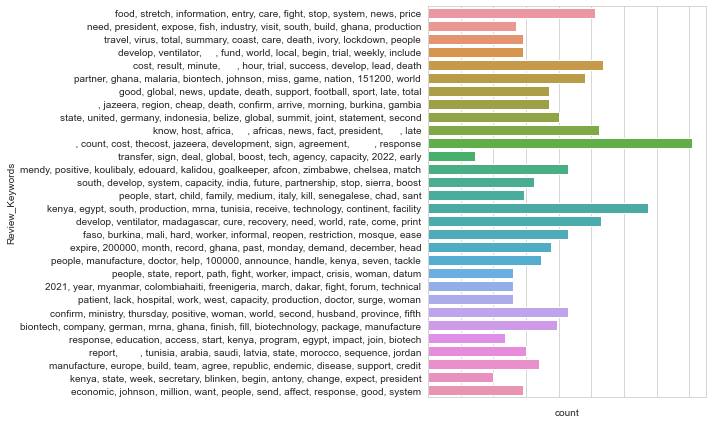

In [165]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='Review_Keywords', data=dat_merge)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

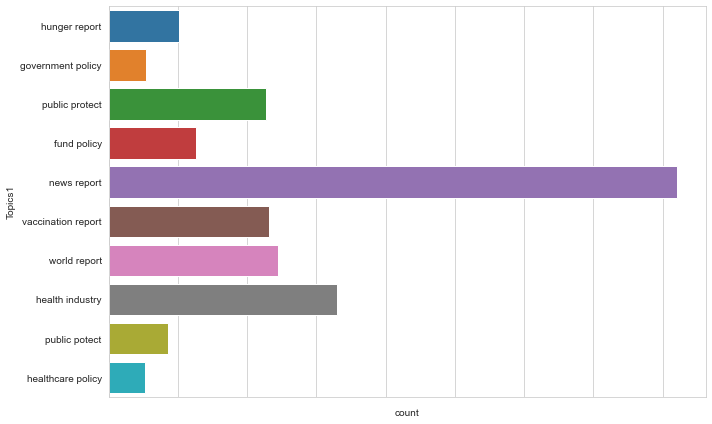

In [167]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='Topics1', data=dat_merge2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [168]:
data_merge.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
0              0                     28                89.999998   
1              1                     21                60.000002   

                                                                       Review_Keywords  \
EmpID                                                                                    
0            food, stretch, information, entry, care, fight, stop, system, news, price   
1      need, president, expose, fish, industry, visit, south, build, ghana, production   

                                                                                                                                                                                                                                        Original review  \
EmpID                                                                                                                                                                                                                                                     
0                                                                                                                                                                                     [stretch, care, system, stop, local, stretch, care, system, stop]   
1      [2022, break, summit, cohoste, gavi, alongside, germany, president, ghana, indonesia, president, union, chair, reaffirm, support, covax, global, solidarity, fight, akufoaddo, lead, world, leader, commit, billion, help, break, amaghanaonlin]   

       index  \
EmpID          
0          0   
1          1   

                                                                                                                                                                                                                          ConsumerComplaint  \
EmpID                                                                                                                                                                                                                                         
0                                                                                                                                                                             stretch  care system stop   local  stretch  care system stop    
1      2022 break  summit cohosted gavi alongside germany g7 president ghana indonesia g20 president  union chair reaffirm support covax  global solidarity fight  akufoaddo lead world leader commit 48 billion help break  amaghanaonlin    

       polarity  subjectivity score  
EmpID                                
0           0.0           0.0     0  
1           0.0           0.0     0

In [169]:
dat_government = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'government')]
dat_government.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
88            88                      2                46.000001   
93            93                     23                91.000003   

                                                                      Review_Keywords  \
EmpID                                                                                   
88              know, host, africa,     , africas, news, fact, president,      , late   
93     faso, burkina, mali, hard, worker, informal, reopen, restriction, mosque, ease   

                                                                                                                                                                Original review  \
EmpID                                                                                                                                                                             
88     [government, 200000, dose, synopharm, wife, president, friend, vaccinate, people, high, risk, seventy, year, freesenegal, simple, sngalaise, colre, contre, macky, sall]   
93                                                                 [lifeworld, crisis, governmental, restriction, chad, argument, lifeworld, crisis, governmental, restriction]   

       index  \
EmpID          
88        88   
93        93   

                                                                                                                                                            ConsumerComplaint  \
EmpID                                                                                                                                                                           
88      government get 200000  dose synopharm  wife president friends get vaccinate people high risk seventy year age freesenegal simple sngalaise en colre contre macky sall   
93                                                                   lifeworlds crisis  governmental restriction  chad  argument lifeworlds crisis  governmental restriction    

       polarity  subjectivity score         Topics        Topics1  
EmpID                                                              
88         0.08      0.448571     1    news report    news report  
93         0.00      0.000000     0  public potect  public potect

In [170]:
dat_transport = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'travel')]
dat_transport.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
2              2                     26                91.000003   
189          189                     26                50.000000   

                                                                  Review_Keywords  \
EmpID                                                                               
2      travel, virus, total, summary, coast, care, death, ivory, lockdown, people   
189    travel, virus, total, summary, coast, care, death, ivory, lockdown, people   

                                                                            Original review  \
EmpID                                                                                         
2      [summary, page, travel, advice, update, information, advice, follow, travel, advice]   
189    [travel, advisory, march, 2020, information, travel, restriction, relation, summary]   

       index  \
EmpID          
2          2   
189      189   

                                                                       ConsumerComplaint  \
EmpID                                                                                      
2          summary page travel advice  update information advice  follow  travel advice    
189    travel advisory march 17 2020  information travel restriction relation   summary    

       polarity  subjectivity score          Topics         Topics1  
EmpID                                                                
2           0.0           0.0     0  public protect  public protect  
189         0.0           0.0     0  public protect  public protect

In [171]:
dat_pharmacy = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'pharmacy')]
dat_pharmacy.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
1685        1685                     27                     94.0   

                                                                    Review_Keywords  \
EmpID                                                                                 
1685   develop, ventilator,     , fund, world, local, begin, trial, weekly, include   

                                                                                                                                           Original review  \
EmpID                                                                                                                                                        
1685   [access, analysis, chronicle, pharmacy, ndeye, toutane, ngom, pharmacistowner, pharmacie, pasteur, ponder, france, embargo, pharmaceutical, export]   

       index  \
EmpID          
1685    1685   

                                                                                                                                 ConsumerComplaint  \
EmpID                                                                                                                                                
1685    access   analysis chronicle pharmacy  dr ndeye toutane ngom pharmacistowner pharmacie pasteur ponder  france embargo pharmaceutical export   

       polarity  subjectivity score       Topics      Topics1  
EmpID                                                          
1685        0.0           0.0     0  fund policy  fund policy

In [172]:
dat_security = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'security')]
dat_security.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
132          132                     28                88.000000   
151          151                      1                91.000003   

                                                                  Review_Keywords  \
EmpID                                                                               
132     food, stretch, information, entry, care, fight, stop, system, news, price   
151    expire, 200000, month, record, ghana, past, monday, demand, december, head   

                                                                                 Original review  \
EmpID                                                                                              
132                                [worsen, issue, help, visualize, datum, like, foodinsecurity]   
151    [head, state, government, meet, monday, tuesday, security, discus, fight, trendingstorie]   

       index  \
EmpID          
132      132   
151      151   

                                                                        ConsumerComplaint  \
EmpID                                                                                       
132                              worsen issue   help visualize data  like  foodinsecurity   
151     head state government meet monday tuesday  security  discus fight trendingstories   

       polarity  subjectivity score         Topics        Topics1  
EmpID                                                              
132    0.136364      0.454545     1  hunger report  hunger report  
151    0.000000      0.000000     0    news report    news report

In [173]:
dat_media = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'media')]
dat_media.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
26            26                     22                     69.0   
139          139                     22                     69.0   

                                                                     Review_Keywords  \
EmpID                                                                                  
26     partner, ghana, malaria, biontech, johnson, miss, game, nation, 151200, world   
139    partner, ghana, malaria, biontech, johnson, miss, game, nation, 151200, world   

                                                                        Original review  \
EmpID                                                                                     
26     [16th, february, 2022for, immediate, release, ghana, partner, biontech, malaria]   
139    [16th, february, 2022for, immediate, release, ghana, partner, biontech, malaria]   

       index  \
EmpID          
26        26   
139      139   

                                                                     ConsumerComplaint  \
EmpID                                                                                    
26     16th february 2022for immediate release ghana   partner biontech   tb malaria     
139     16th february 2022for immediate release ghana   partner biontech   tb malaria    

       polarity  subjectivity score              Topics             Topics1  
EmpID                                                                        
26          0.0           0.0     0  vaccination report  vaccination report  
139         0.0           0.0     0  vaccination report  vaccination report

In [174]:
dat_business = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'business')]
dat_business.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
265          265                      2                58.999997   
717          717                     29                89.999998   

                                                                Review_Keywords  \
EmpID                                                                             
265       know, host, africa,     , africas, news, fact, president,      , late   
717    good, global, news, update, death, support, football, sport, late, total   

                                                                                 Original review  \
EmpID                                                                                              
265                [cost, minute, result, know, business, opportunity, know, need, accept, need]   
717    [support, development, business, manufacture, south, morocco, help, catalyse, investment]   

       index  \
EmpID          
265      265   
717      717   

                                                                                   ConsumerComplaint  \
EmpID                                                                                                  
265                    cost  10 minute result  know business opportunity know isnt need accept  need   
717    uk gov support development business   manufacture  south  morocco help catalyse investment      

       polarity  subjectivity score       Topics      Topics1  
EmpID                                                          
265    0.136364      0.454545     1  news report  news report  
717    0.000000      0.000000     0  news report  news report

In [138]:
dat_education = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'school')]
dat_education.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
133          133                     18                92.000002   
313          313                     10                69.000000   

                                                                                 Review_Keywords  \
EmpID                                                                                              
133    biontech, company, german, mrna, ghana, finish, fill, biotechnology, package, manufacture   
313          state, united, germany, indonesia, belize, global, summit, joint, statement, second   

                                                                                                                                                      Original review  \
EmpID                                                                                                                                                                   
133                                                                     [despite, restriction, continue, find, donate, 5000, online, child, safety, school, notebook]   
313    [away, nation, know, uganda, county, police, station, close, early, rampant, insecuritytheyve, open, school, year, closure, 2020disclaimervideo, teamzimbabwe]   

       index  \
EmpID          
133      133   
313      313   

                                                                                                                                                     ConsumerComplaint  \
EmpID                                                                                                                                                                    
133                                                                            despite   restriction continue find   donate 5000 online child safety school notebooks    
313    away  cup nation know uganda  county police station close early rampant insecuritytheyve open school 3 year closure coz 2020disclaimervideo ug  19 teamzimbabwe   

       polarity  subjectivity score          Topics         Topics1  
EmpID                                                                
133    0.136364      0.454545     1  healh industry  healh industry  
313    0.050000      0.400000     1    world report    world report

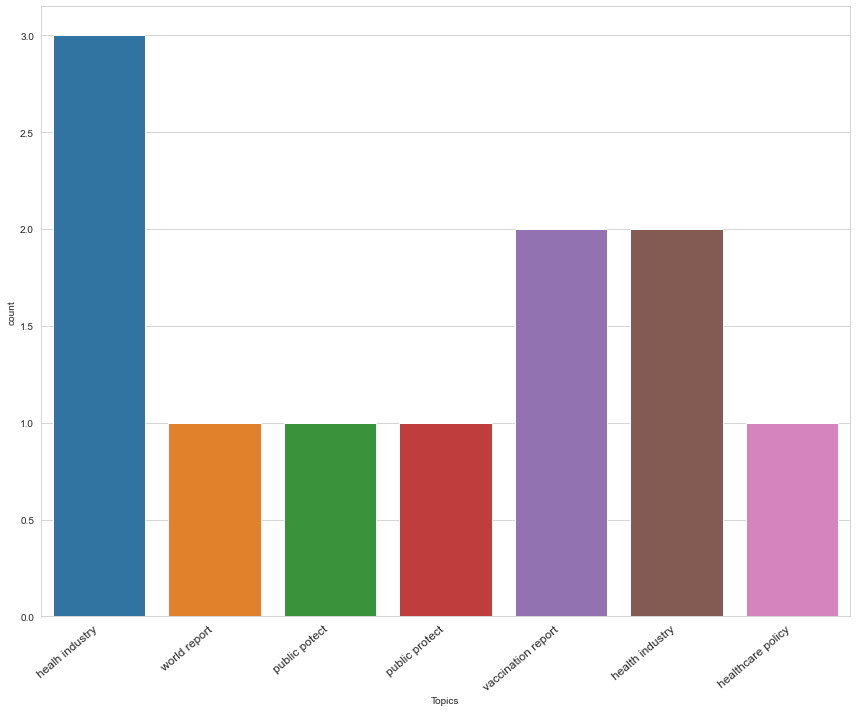

In [139]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Topics', data=dat_education)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

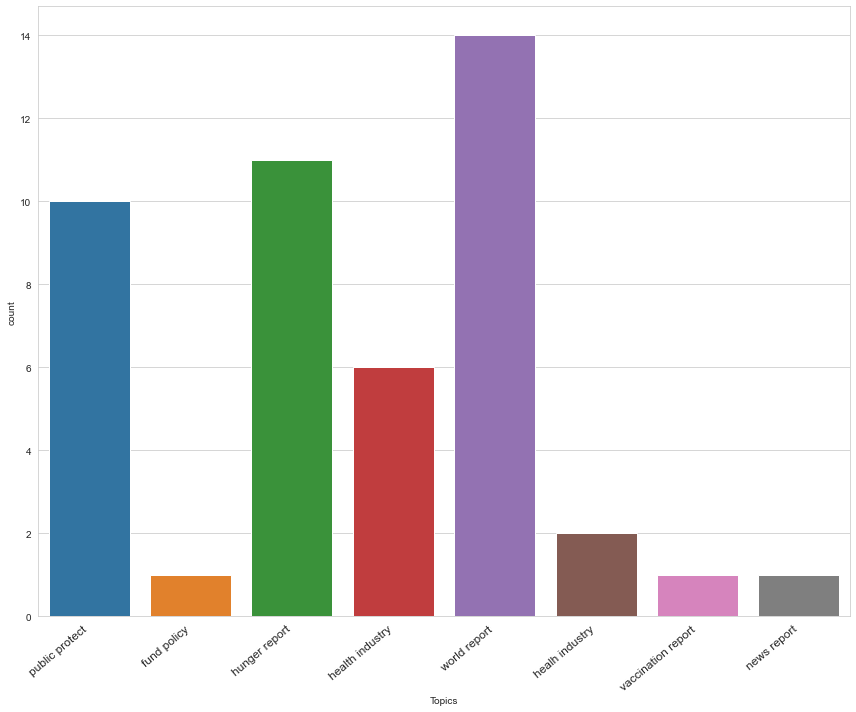

In [140]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Topics', data=dat_transport)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [141]:
dat_poverty = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'poverty'and 'country'and'child'and'live'and'world'and'poor'and'development'and 'corruption' and 'economic')]
dat_poverty.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
114          114                     19                92.000002   
138          138                     26                89.999998   

                                                                      Review_Keywords  \
EmpID                                                                                   
114    economic, johnson, million, want, people, send, affect, response, good, system   
138        travel, virus, total, summary, coast, care, death, ivory, lockdown, people   

                                                                                         Original review  \
EmpID                                                                                                      
114    [good, news, explain, effective, response, economic, challenge, remain, listen, webinar, economy]   
138                     [president, helm, union, economic, recovery, youth, employment, dsir, assogbavi]   

       index  \
EmpID          
114      114   
138      138   

                                                                               ConsumerComplaint  \
EmpID                                                                                              
114    good news explains effective response economic challenge remain listen  webinar  economy    
138               president  take helm  union  economic recovery youth employment dsir assogbavi   

       polarity  subjectivity score          Topics         Topics1  
EmpID                                                                
114       0.375           0.4     1  public protect  public protect  
138       0.100           0.1     1  public protect  public protect

In [145]:
dat_hunger = dat_merge2[dat_merge2['ConsumerComplaint'].str.contains(r'hunger'or'food'or'eat'or'famine'or 'thirst'or'world' or 'like' or'child' or 'weight')]
dat_hunger.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
EmpID                                                              
725          725                     16                67.000002   
882          882                     28                73.000002   

                                                                               Review_Keywords  \
EmpID                                                                                            
725          , count, cost, thecost, jazeera, development, sign, agreement,         , response   
882                  food, stretch, information, entry, care, fight, stop, system, news, price   

                                                                                                                               Original review  \
EmpID                                                                                                                                            
725    [surprise, nigerian, government, ventilator, organic, madagascarwe, prefer, spend, money, need, claim, giant, kill, poor, mass, hunger]   
882                              [ordinary,      , kitlow, cost, ventilator, producedhere, lockdown, strategy, death, miserable, hunger, food]   

       index  \
EmpID          
725      725   
882      882   

                                                                                                                                         ConsumerComplaint  \
EmpID                                                                                                                                                        
725    let surprise nigerian government buy   ventilator  wouldnt buy  organic madagascarwe prefer spend money dont need claim giant kill poor mass hunger   
882                                                     ordinary      kitlow cost ventilator producedhere   lockdown strategy  death miserable hunger food   

       polarity  subjectivity score         Topics        Topics1  
EmpID                                                              
725      -0.200          0.80     0    news report    news report  
882      -0.625          0.75     0  hunger report  hunger report

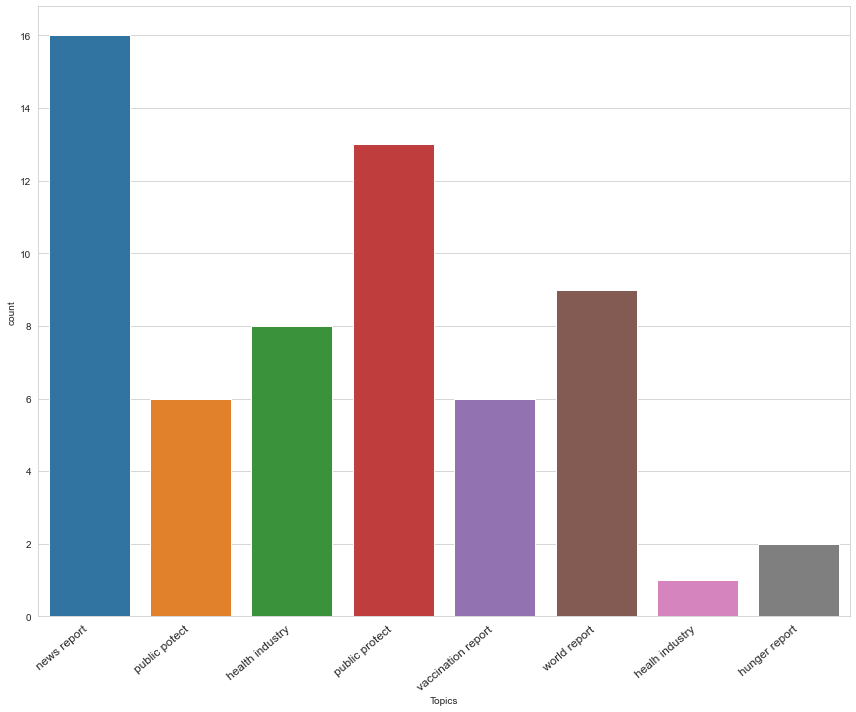

In [146]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Topics', data=dat_government)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

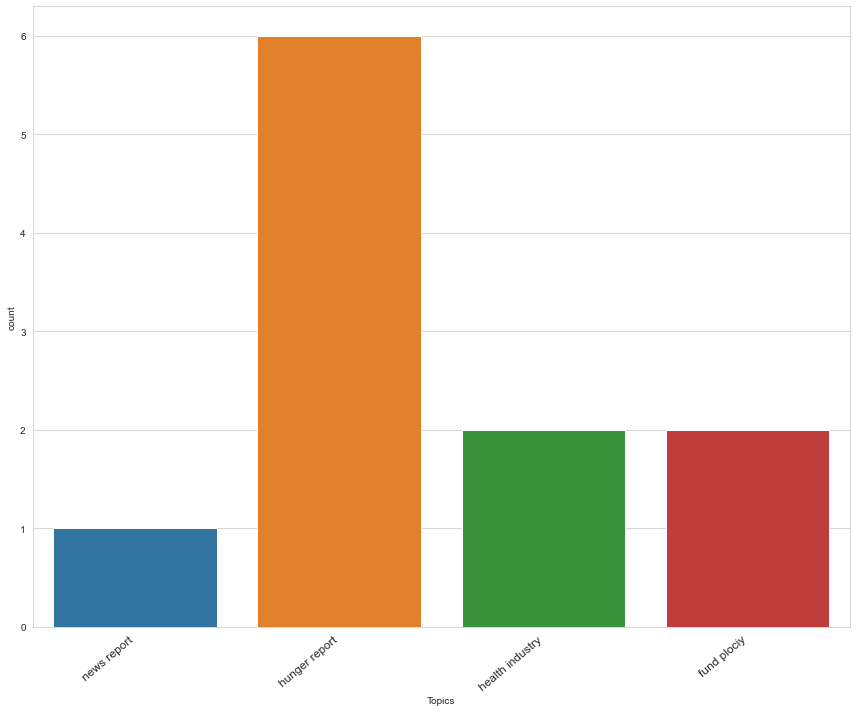

In [147]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Topics', data=dat_hunger)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

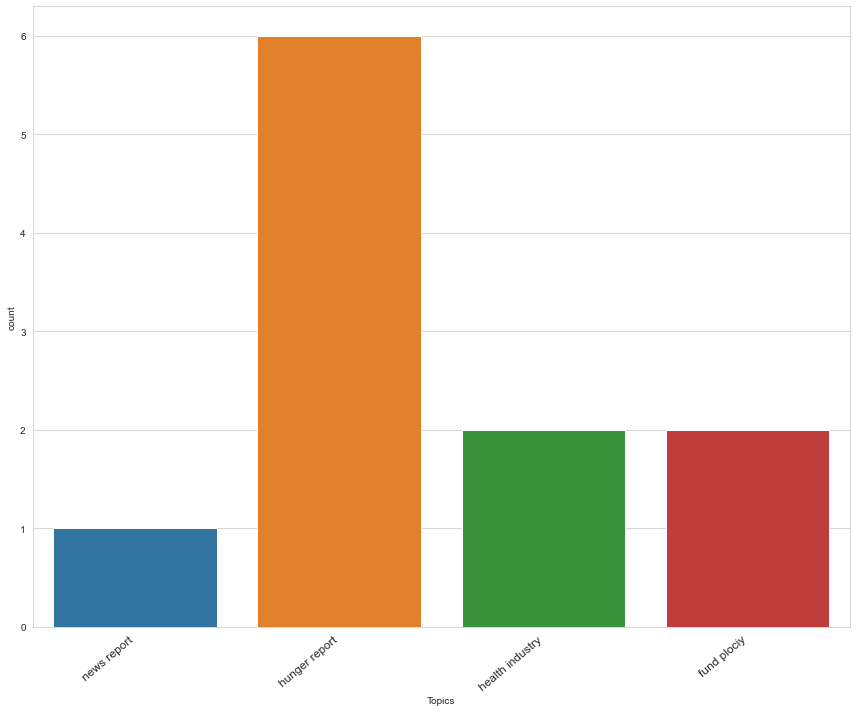

In [148]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Topics', data=dat_hunger)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [149]:
tt

NameError: name 'tt' is not defined

In [175]:
dat_security.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/securitytwitter.csv", index=False)
dat_media.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/mediatwitter.csv", index=False)
dat_business.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/businesstwitter.csv", index=False)
dat_pharmacy.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/pharmacytwitter.csv", index=False)


In [176]:
dat_education.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/educationtwitter.csv", index=False)

In [177]:
dat_transport.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/transporttwitter.csv", index=False)

In [178]:
dat_government.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/governmenttwitter.csv", index=False)


In [179]:
dat_poverty.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/povertytwitter.csv", index=False)

In [180]:
dat_hunger.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twittertopics/hungertwitter.csv", index=False)

In [3]:
#datastudy = pd.read_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/sampleone.csv", encoding = "UTF-8")
datastudy = pd.read_excel('C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/sampleone2.xlsx', sheet_name='Sheet1')
#datastudy.dropna()
datastudy.head(2)

tool  count  impact            topics
0  facebook      4  hunger  education policy
1  facebook      4  hunger  education policy

In [4]:
#datastudy.head(2)

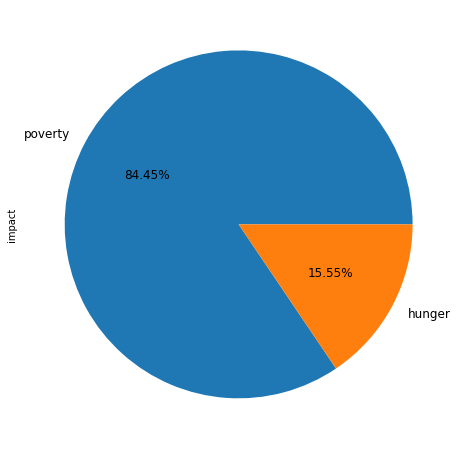

In [5]:
#Piechart visualisation
#plt.pie(datastudy['impact'].value_counts(),labels=datastudy['impact'])#,autopct='%1.2f%%')
datastudy.impact.value_counts().plot(kind='pie', figsize=(10, 8), autopct='%1.2f%%', fontsize = 12)
#plt.figure(figsize=(12, 10))
plt.show()

In [3]:
datastudy2 = pd.read_excel('C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/sampleall2.xlsx', sheet_name='Sheet1')
#datastudy2 = pd.read_csv("C:/Users/harys/Downloads/covid3/covid/twitter/sampleone.csv", encoding = "UTF-8")
#datastudy.dropna()
datastudy2.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
0        197                     21                93.000001   
1        202                      4                99.000001   

                                     Review_Keywords  \
0  group; china; senegal; pandemic; people; watch...   
1  senegal; pandemic; medical; hospital; chief; w...   

                                     Original review  index  \
0  ['senegal'; 'beach'; 'resort'; 'business'; 'ha...    197   
1  ['hunger'; 'poverty'; 'unemployment'; 'feed'; ...    202   

                                   ConsumerComplaint  polarity  subjectivity  \
0  senegal beach resort business hit hard  econom... -0.127778      0.427778   
1  hunger poverty unemployment feed poor hungry n... -0.066667      0.400000   

   score        topics    impact  code      tool  
0      0  covid report  business     1  facebook  
1      0  covid report  business     1  facebook

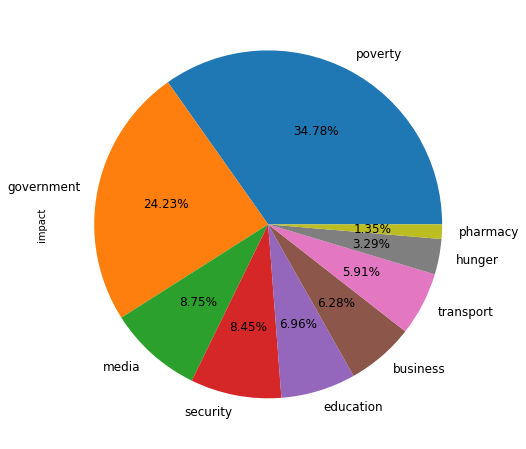

In [4]:
#Piechart visualisation
datastudy2.impact.value_counts().plot(kind='pie', figsize=(10, 8), autopct='%1.2f%%', fontsize = 12)
#plt.pie(datastudy2['impact'].value_counts(),labels=datastudy2['impact'],autopct='%1.2f%%')
#plt.figure(figsize=(10, 8))
plt.show()

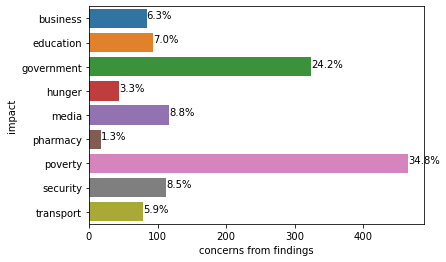

In [5]:
ax = sns.countplot(y="impact", data=datastudy2)
#plt.title('Distribution of  Configurations')
plt.xlabel('concerns from findings')

total = len(datastudy2['impact'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [6]:
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.2f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12, rotation = 90)
    plt.show()

C:\Users\HARYS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


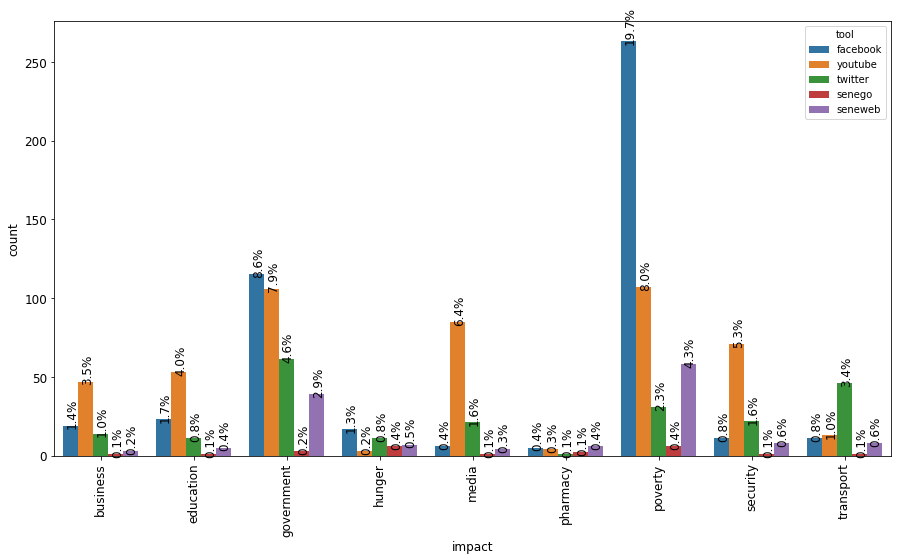

In [7]:
plt.figure(figsize =(15,8))
ax =sns.countplot('impact', hue='tool', data=datastudy2)
plt.xticks(size=12,rotation=90 )
plt.xlabel('impact', size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax,datastudy2)

C:\Users\HARYS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


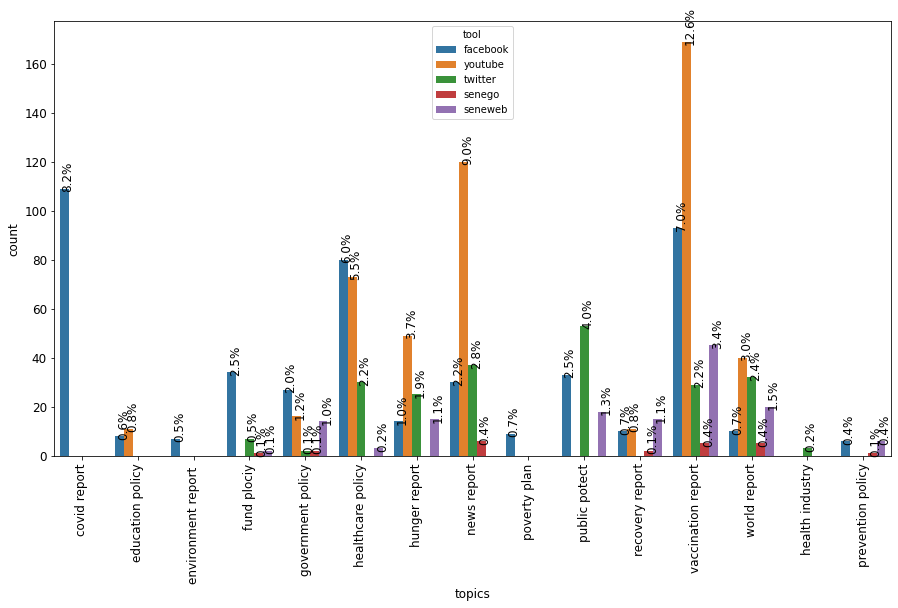

In [8]:
plt.figure(figsize =(15,8))
ax =sns.countplot('topics', hue='tool', data=datastudy2)
plt.xticks(size=12,rotation=90 )
plt.xlabel('topics', size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax,datastudy2)

In [9]:

poke2 = datastudy2.groupby(['impact']).mean()[['subjectivity', 'polarity']]

<AxesSubplot:xlabel='impact'>

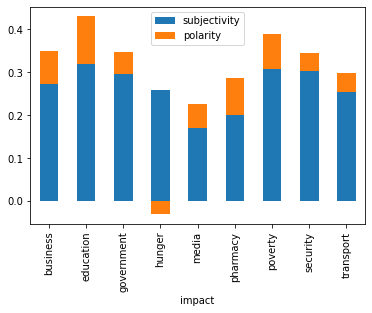

In [10]:
poke2.plot.bar(stacked=True)

C:\Users\HARYS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


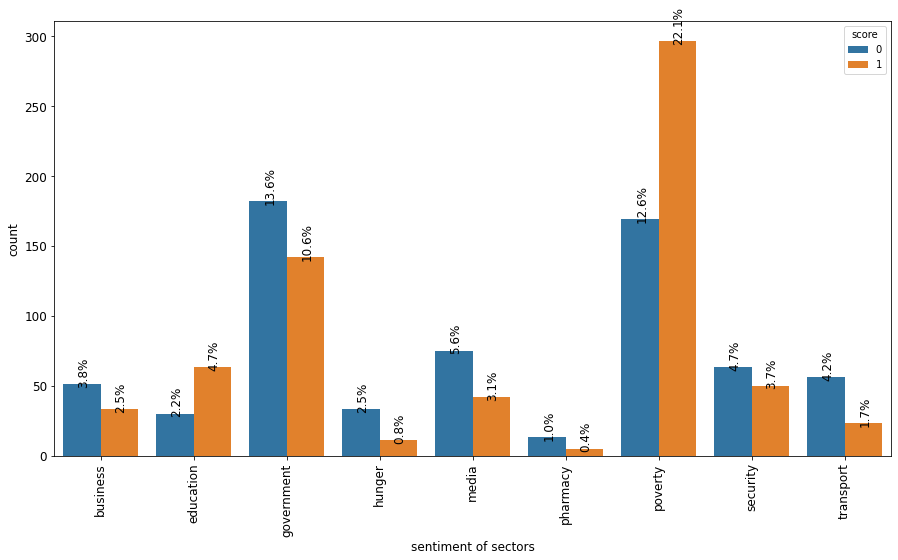

In [11]:

plt.figure(figsize =(15,8))
ax =sns.countplot('impact', hue='score', data=datastudy2)
plt.xticks(size=12,rotation=90 )
plt.xlabel('sentiment of sectors', size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax,datastudy2)

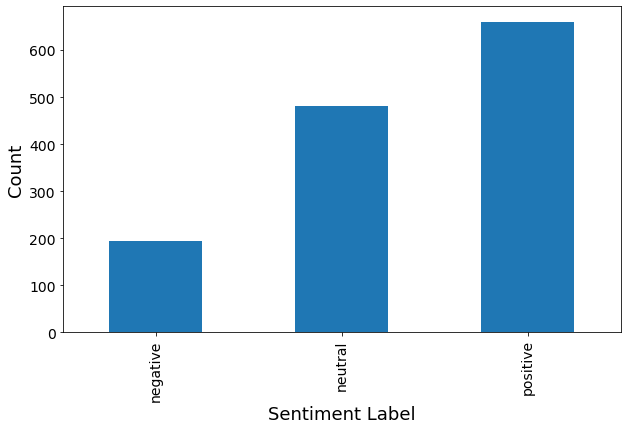

<Figure size 432x288 with 0 Axes>

In [12]:
# polarity values ranging from -1 to 1 are really useful for sentiment analysis
# but let's convert our data to 3 classes (negative, neutral, and positive) so that we can visualize it
criteria2 = [datastudy2['polarity'].between(-1, -0.01), datastudy2['polarity'].between(-0.01, 0.01), 
             datastudy2['polarity'].between(0.01, 1)]
values = ['negative', 'neutral', 'positive']
datastudy2['sentiment'] = np.select(criteria2, values, 0)

# plot sentiment counts
fig = plt.figure(figsize=(10, 6))
datastudy2['sentiment'].value_counts().sort_index().plot.bar()
plt.xlabel('Sentiment Label', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.tight_layout()

C:\Users\HARYS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


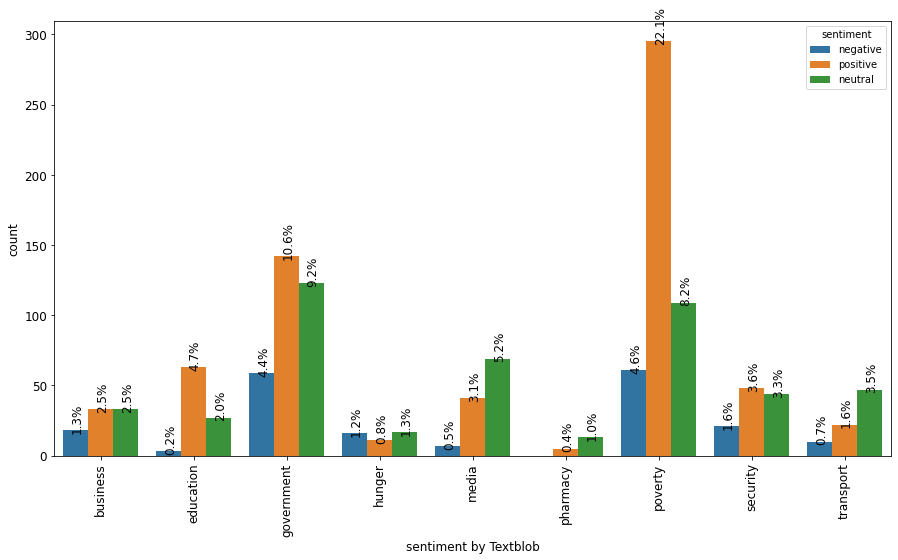

In [13]:
plt.figure(figsize =(15,8))
ax =sns.countplot('impact', hue='sentiment', data=datastudy2)
plt.xticks(size=12,rotation=90 )
plt.xlabel('sentiment by Textblob', size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax,datastudy2)

In [14]:
#!pip install colorlover

C:\Users\HARYS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


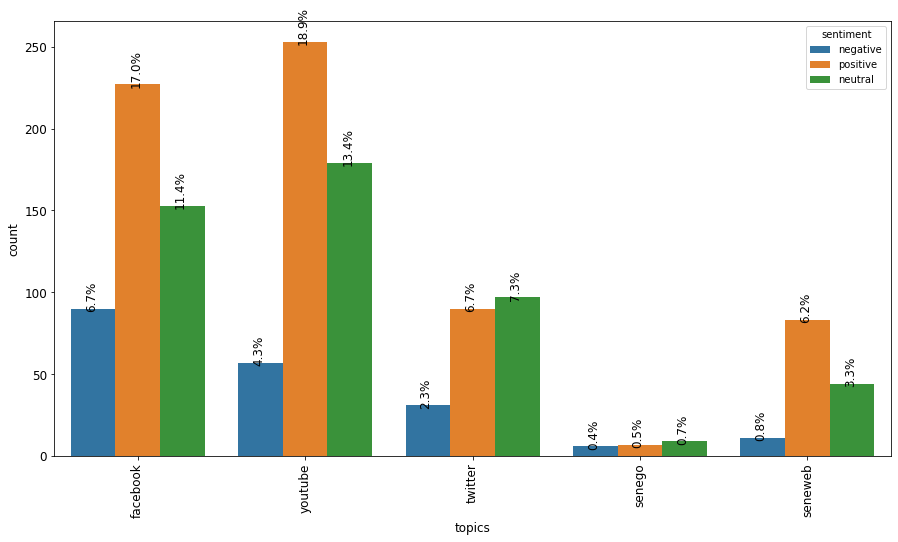

In [15]:
plt.figure(figsize =(15,8))
ax =sns.countplot('tool', hue='sentiment', data=datastudy2)
plt.xticks(size=12,rotation=90 )
plt.xlabel('topics', size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax,datastudy2)


<AxesSubplot:xlabel='polarity', ylabel='impact'>

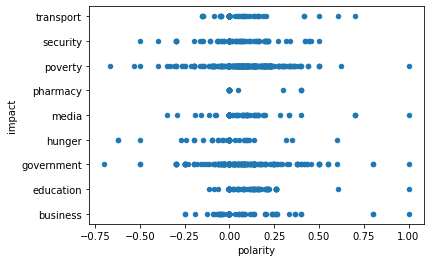

In [16]:
datastudy2[datastudy2['code'] < 100].plot.scatter(x='polarity', y='impact')

In [17]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HARYS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
"""
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
datastudy2['vadersent']=datastudy2['ConsumerComplaint'].apply(lambda ConsumerComplaint: sid.polarity_scores(ConsumerComplaint))
datastudy2['compound'] = datastudy2['vadersent'].apply(lambda score_dict: score_dict['compound'])
datastudy2['sentiment_type']=''
datastudy2.loc[datastudy2.compound>0,'sentiment_type']='POSITIVE'
datastudy2.loc[datastudy2.compound==0,'sentiment_type']='NEUTRAL'
datastudy2.loc[datastudy2.compound<0,'sentiment_type']='NEGATIVE'
"""

"\nfrom nltk.sentiment.vader import SentimentIntensityAnalyzer\nsid = SentimentIntensityAnalyzer()\ndatastudy2['vadersent']=datastudy2['ConsumerComplaint'].apply(lambda ConsumerComplaint: sid.polarity_scores(ConsumerComplaint))\ndatastudy2['compound'] = datastudy2['vadersent'].apply(lambda score_dict: score_dict['compound'])\ndatastudy2['sentiment_type']=''\ndatastudy2.loc[datastudy2.compound>0,'sentiment_type']='POSITIVE'\ndatastudy2.loc[datastudy2.compound==0,'sentiment_type']='NEUTRAL'\ndatastudy2.loc[datastudy2.compound<0,'sentiment_type']='NEGATIVE'\n"

In [19]:
datastudy2['vadersent'] = datastudy2['ConsumerComplaint'].apply(lambda ConsumerComplaint: sid.polarity_scores(ConsumerComplaint))
datastudy2.head()

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
0        197                     21                93.000001   
1        202                      4                99.000001   
2        261                     21               100.000000   
3        459                      4                99.000001   
4        505                     22                81.999999   

                                     Review_Keywords  \
0  group; china; senegal; pandemic; people; watch...   
1  senegal; pandemic; medical; hospital; chief; w...   
2  group; china; senegal; pandemic; people; watch...   
3  senegal; pandemic; medical; hospital; chief; w...   
4  pandemic; expect; state; situation; white; hou...   

                                     Original review  index  \
0  ['senegal'; 'beach'; 'resort'; 'business'; 'ha...    197   
1  ['hunger'; 'poverty'; 'unemployment'; 'feed'; ...    202   
2  ['founder'; 'president'; 'sedima'; 'group'; 'b...    261   
3  ['hunger'; 'poverty'; 'unemployment'; 'feed'; ...    459   
4  ['globalink'; 'shanghai'; 'maintain'; 'export'...    505   

                                   ConsumerComplaint  polarity  subjectivity  \
0  senegal beach resort business hit hard  econom... -0.127778      0.427778   
1  hunger poverty unemployment feed poor hungry n... -0.066667      0.400000   
2  founder president sedima group mr babacar ngom...  0.112821      0.402564   
3  hunger poverty unemployment feed poor hungry n... -0.066667      0.400000   
4  globalink shanghai maintain car export despite...  0.123958      0.370833   

   score        topics    impact  code      tool sentiment  \
0      0  covid report  business     1  facebook  negative   
1      0  covid report  business     1  facebook  negative   
2      1  covid report  business     1  facebook  positive   
3      0  covid report  business     1  facebook  negative   
4      1  covid report  business     1  facebook  positive   

                                           vadersent  
0  {'neg': 0.177, 'neu': 0.823, 'pos': 0.0, 'comp...  
1  {'neg': 0.287, 'neu': 0.564, 'pos': 0.149, 'co...  
2  {'neg': 0.0, 'neu': 0.906, 'pos': 0.094, 'comp...  
3  {'neg': 0.287, 'neu': 0.564, 'pos': 0.149, 'co...  
4  {'neg': 0.0, 'neu': 0.898, 'pos': 0.102, 'comp...

In [20]:
datastudy2['compound'] = datastudy2['vadersent'].apply(lambda score_dict: score_dict['compound'])
datastudy2['sentiment_type']=''
datastudy2.loc[datastudy2.compound>0,'sentiment_type']='POSITIVE'
datastudy2.loc[datastudy2.compound==0,'sentiment_type']='NEUTRAL'
datastudy2.loc[datastudy2.compound<0,'sentiment_type']='NEGATIVE'

<AxesSubplot:title={'center':'sentiment analysis'}>

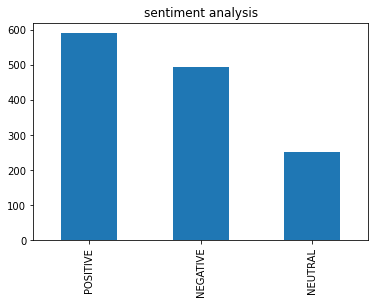

In [21]:
datastudy2.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")


In [22]:
datastudy2.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
0        197                     21                93.000001   
1        202                      4                99.000001   

                                     Review_Keywords  \
0  group; china; senegal; pandemic; people; watch...   
1  senegal; pandemic; medical; hospital; chief; w...   

                                     Original review  index  \
0  ['senegal'; 'beach'; 'resort'; 'business'; 'ha...    197   
1  ['hunger'; 'poverty'; 'unemployment'; 'feed'; ...    202   

                                   ConsumerComplaint  polarity  subjectivity  \
0  senegal beach resort business hit hard  econom... -0.127778      0.427778   
1  hunger poverty unemployment feed poor hungry n... -0.066667      0.400000   

   score        topics    impact  code      tool sentiment  \
0      0  covid report  business     1  facebook  negative   
1      0  covid report  business     1  facebook  negative   

                                           vadersent  compound sentiment_type  
0  {'neg': 0.177, 'neu': 0.823, 'pos': 0.0, 'comp...   -0.2023       NEGATIVE  
1  {'neg': 0.287, 'neu': 0.564, 'pos': 0.149, 'co...   -0.9260       NEGATIVE

In [23]:
poke3 = datastudy2.groupby(['code']).mean()[['polarity', 'subjectivity','compound']]

<AxesSubplot:xlabel='code'>

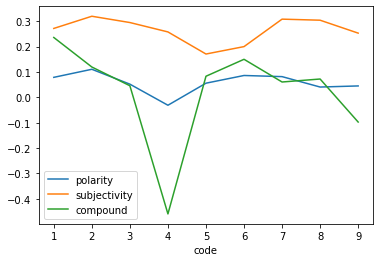

In [24]:
poke3.plot.line()

<AxesSubplot:xlabel='code'>

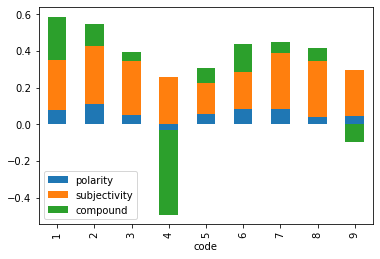

In [25]:
poke3.plot.bar(stacked=True)

In [26]:
poke4 = datastudy2.groupby(['code']).mean()[['polarity', 'subjectivity']]

<AxesSubplot:xlabel='code'>

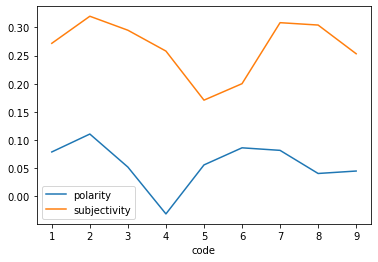

In [27]:
poke4.plot.line()

C:\Users\HARYS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


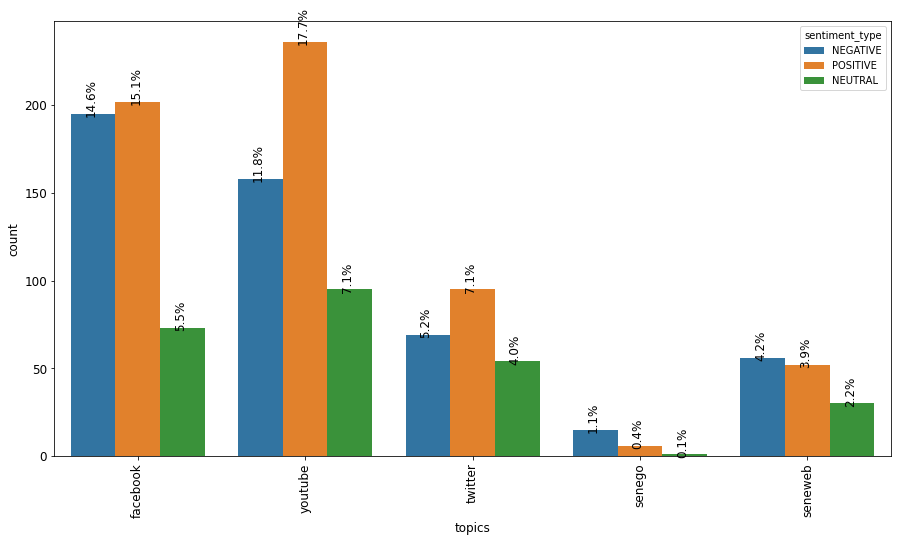

In [28]:
plt.figure(figsize =(15,8))
ax =sns.countplot('tool', hue='sentiment_type', data=datastudy2)
plt.xticks(size=12,rotation=90 )
plt.xlabel('topics', size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax,datastudy2)


C:\Users\HARYS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


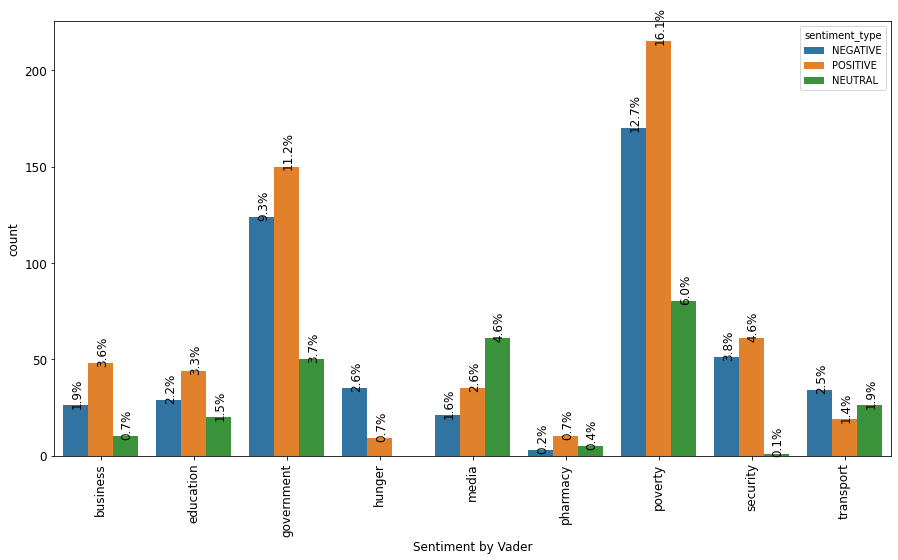

In [29]:
plt.figure(figsize =(15,8))
ax =sns.countplot('impact', hue='sentiment_type', data=datastudy2)
plt.xticks(size=12,rotation=90 )
plt.xlabel('Sentiment by Vader', size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)

without_hue(ax,datastudy2)

In [30]:
datastudy2.to_excel("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/sentiments.xlsx", index=False)

In [3]:
datastudy21 = pd.read_excel('C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/sentiments.xlsx', sheet_name='Sheet1')
datastudy21.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
0        197                     21                93.000001   
1        202                      4                99.000001   

                                     Review_Keywords  \
0  group; china; senegal; pandemic; people; watch...   
1  senegal; pandemic; medical; hospital; chief; w...   

                                     Original review  index  \
0  ['senegal'; 'beach'; 'resort'; 'business'; 'ha...    197   
1  ['hunger'; 'poverty'; 'unemployment'; 'feed'; ...    202   

                                   ConsumerComplaint  polarity  subjectivity  \
0  senegal beach resort business hit hard  econom... -0.127778      0.427778   
1  hunger poverty unemployment feed poor hungry n... -0.066667      0.400000   

   score        topics    impact  code      tool sentiment  \
0      0  covid report  business     1  facebook  negative   
1      0  covid report  business     1  facebook  negative   

                                           vadersent  compound sentiment_type  
0  {'neg': 0.177, 'neu': 0.823, 'pos': 0.0, 'comp...   -0.2023       NEGATIVE  
1  {'neg': 0.287, 'neu': 0.564, 'pos': 0.149, 'co...   -0.9260       NEGATIVE

In [4]:

df1 = datastudy21.sort_values(by=["Percent_contr_per_topic"], ascending=False)
#df2 = df1.groupby(['impact'=='government'],as_index=True)
# Choose entries with impact as government
df2 = df1[df1['impact'] == 'government']
df2.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
201        604                     20               100.000000   
454       4012                      3                99.000001   

                                       Review_Keywords  \
201  health; minister; vaccination; country; techno...   
454  food; pandemic; inequality; global; country; p...   

                                       Original review  index  \
201  ['vikram'; 'jeet'; 'duggal'; 'assume'; 'office...    604   
454  ['food'; 'insecurity'; 'effect'; 'vulnerable';...   4012   

                                     ConsumerComplaint  polarity  \
201  vikram jeet duggal assume office ssp patialase...  0.068056   
454  food insecurity effect  vulnerable  begin 2020... -0.066814   

     subjectivity  score             topics      impact  code      tool  \
201      0.527778      1  government policy  government     3  facebook   
454      0.490343      0      hunger report  government     3   youtube   

    sentiment                                          vadersent  compound  \
201  positive  {'neg': 0.058, 'neu': 0.855, 'pos': 0.088, 'co...    0.7650   
454  negative  {'neg': 0.201, 'neu': 0.628, 'pos': 0.17, 'com...   -0.6124   

    sentiment_type  
201       POSITIVE  
454       NEGATIVE

In [5]:
datastudy22 = pd.read_excel('C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/governmentonly2.xlsx', sheet_name='Sheet1')
datastudy22.head(2)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
0         44                     22                99.000001   
1        864                     22                81.999999   

                                     Review_Keywords  \
0  pandemic; expect; state; situation; white; hou...   
1  pandemic; expect; state; situation; white; hou...   

                                     Original review  index  \
0  ['clarification'; 'dennis'; 'statement'; 'mini...     44   
1  ['govt'; 'prepare'; 'face'; 'fourth'; 'wave'; ...    864   

                                   ConsumerComplaint  polarity  subjectivity  \
0  clarification dennis tan  statement minister h...  0.123333           0.2   
1   govt prepare face fourth wave say aaron gover...  0.000000           0.0   

   score            topics      impact  code      tool sentiment  \
0      1  education policy  government     3  facebook  positive   
1      0  education policy  government     3  facebook   neutral   

                                           vadersent  compound sentiment_type  
0  {'neg': 0.073, 'neu': 0.836, 'pos': 0.09, 'com...    0.3612       POSITIVE  
1  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000        NEUTRAL

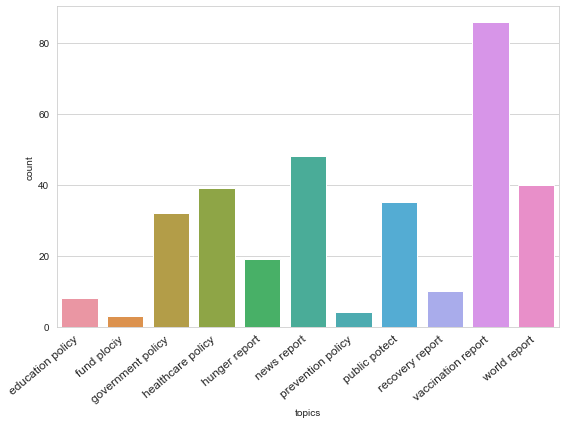

In [6]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='topics', data=datastudy22)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()


In [7]:
## dataframe creation - for plotting
# create new pandas dataframe which contains all counts filtered 
govdf = (
    datastudy21.loc[datastudy21["impact"] == "government"]
    .groupby(["topics"])
    .size()
    .reset_index(name="Counts")
    .sort_values(by=["topics"])
)
povdf = (
    datastudy21.loc[datastudy21["impact"] == "poverty"]
    .groupby(["topics"])
    .size()
    .reset_index(name="Counts")
    .sort_values(by=["topics"])
)
# create new pandas dataframe which contains all counts filtered 
hungdf = (
    datastudy21.loc[datastudy21["impact"] == "hunger"]
    .groupby(["topics"])
    .size()
    .reset_index(name="Counts")
    .sort_values(by=["topics"])
)
# get unique values from the just created pandas dataframes and store them in an array
#labels_government_sectors = govdf["topics"].unique()
#labels_poverty_sectors = povdf["topics"].unique()
#labels_hunger_sectors = hungdf["topics"].unique()
    
# get all the counts from the created pandas dataframes and store them in an array
#values_government_topics = povdf["Counts"]
#values_poverty_topics = povdf["Counts"]
#values_hunger_topics = hungdf["Counts"]

In [19]:
import plotly.graph_objects as go
## Creating a pie chart
# create labels using all unique values in the column named "population"
labels = govdf["topics"].unique()
# group by count of the "population" column.
values = govdf["Counts"]
# Custom define a list of colors to be used for the pie chart.
# Note that the same number of colors are specified as there are unique populations. It is not mandatory, but
# will avoid a single color to be used multiple times.
earth_colors = [
    "rgb(210,180,140)",
    "rgb(218,165,32)",
    "rgb(139,69,19)",
    "rgb(175, 51, 21)",
    "rgb(35, 36, 21)",
    "rgb(188,143,143)",
]
# defining the actual figure using the dimension: population
# Note that a pull keyword was specified to explode pie pieces out of the center
fig = go.Figure(
    data=[
        go.Pie(
            labels=labels,
            values=values,
            # pull is given as a fraction of the pie radius
            pull=[0, 0, 0.07, 0.08, 0.02, 0.2],
            # iterate through earth_colors list to color individual pie pieces
            marker_colors=earth_colors,
        )
    ]
)
# Update layout to show a title
fig.update_layout(title_text="Topics about govermnet from Covid-19 data")
# display the figure
fig.show()

C:\Users\HARYS\AppData\Local\Temp\ipykernel_9864\929594731.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\HARYS\AppData\Local\Temp\ipykernel_9864\929594731.py:7: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



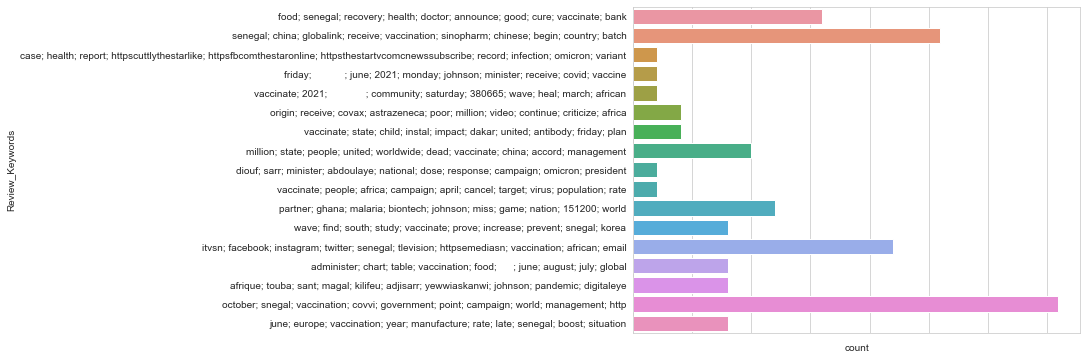

In [20]:
datastudy21gov = datastudy21[datastudy21["impact"]=="government"]
datastudy21govvac = datastudy21gov[datastudy21gov["topics"]=="vaccination report"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21govvac)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()


C:\Users\HARYS\AppData\Local\Temp\ipykernel_9864\327076059.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



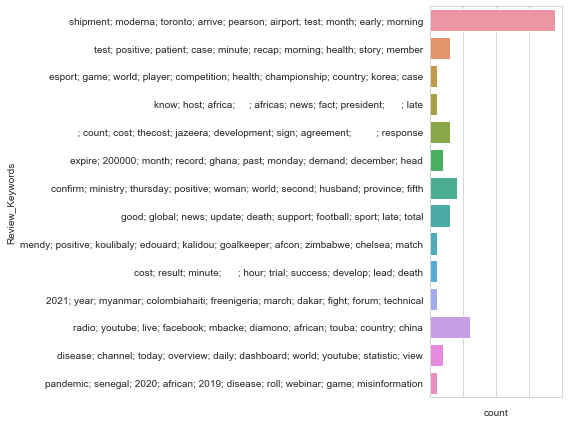

In [21]:
#datastudy21gov = datastudy21[datastudy21["impact"]=="government"]
datastudy21govnews = datastudy21gov[datastudy21gov["topics"]=="news report"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21govnews)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

C:\Users\HARYS\AppData\Local\Temp\ipykernel_9864\1915755641.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



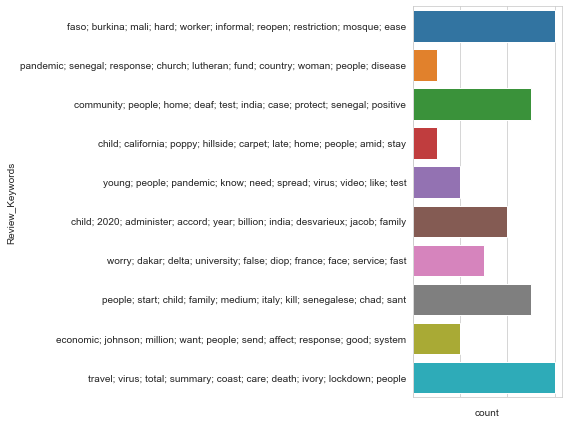

In [23]:
#datastudy21gov = datastudy21[datastudy21["impact"]=="government"]
datastudy21govpub = datastudy21gov[datastudy21gov["topics"]=="public protect"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21govpub)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [24]:

## Creating a pie chart
# create labels using all unique values in the column named "population"
labels = povdf["topics"].unique()
# group by count of the "population" column.
values = povdf["Counts"]
# Custom define a list of colors to be used for the pie chart.
# Note that the same number of colors are specified as there are unique populations. It is not mandatory, but
# will avoid a single color to be used multiple times.
earth_colors = [
    "rgb(210,180,140)",
    "rgb(218,165,32)",
    "rgb(139,69,19)",
    "rgb(175, 51, 21)",
    "rgb(35, 36, 21)",
    "rgb(188,143,143)",
]
# defining the actual figure using the dimension: population
# Note that a pull keyword was specified to explode pie pieces out of the center
fig = go.Figure(
    data=[
        go.Pie(
            labels=labels,
            values=values,
            # pull is given as a fraction of the pie radius
            pull=[0, 0, 0.07, 0.08, 0.02, 0.2],
            # iterate through earth_colors list to color individual pie pieces
            marker_colors=earth_colors,
        )
    ]
)
# Update layout to show a title
fig.update_layout(title_text="Topics about poverty from Covid-19 data")
# display the figure
fig.show()


C:\Users\HARYS\AppData\Local\Temp\ipykernel_9864\406928622.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\HARYS\AppData\Local\Temp\ipykernel_9864\406928622.py:7: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



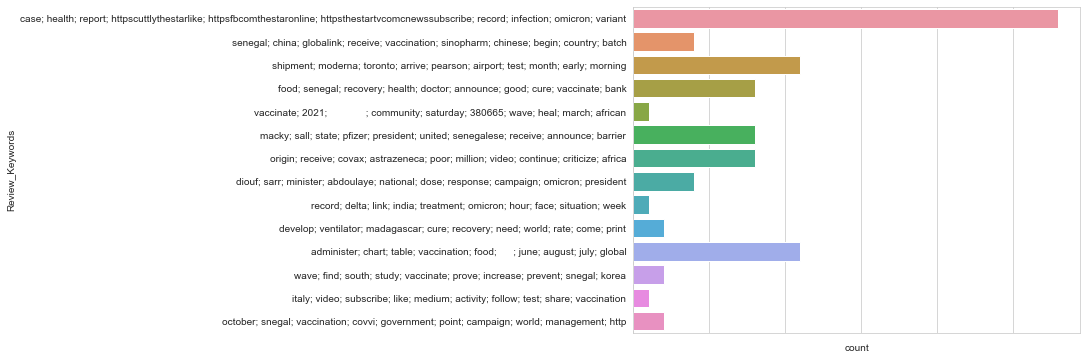

In [25]:
datastudy21pov = datastudy21[datastudy21["impact"]=="poverty"]
datastudy21povvac = datastudy21pov[datastudy21pov["topics"]=="vaccination report"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21povvac)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

C:\Users\HARYS\AppData\Local\Temp\ipykernel_9864\1781205822.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



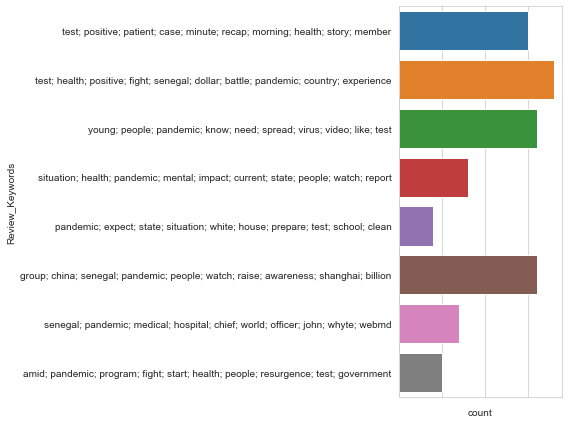

In [26]:
#datastudy21pov = datastudy21[datastudy21["impact"]=="poverty"]
datastudy21povcov = datastudy21pov[datastudy21pov["topics"]=="covid report"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21povcov)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

C:\Users\HARYS\AppData\Local\Temp\ipykernel_9864\4046857131.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



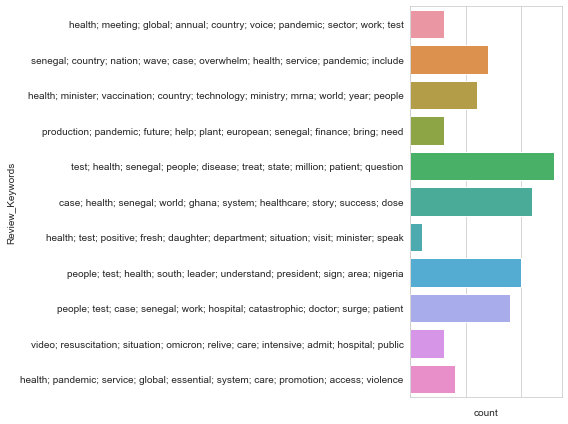

In [27]:
#datastudy21pov = datastudy21[datastudy21["impact"]=="poverty"]
datastudy21povhealth = datastudy21pov[datastudy21pov["topics"]=="healthcare policy"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21povhealth)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

C:\Users\HARYS\AppData\Local\Temp\ipykernel_9864\556578376.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



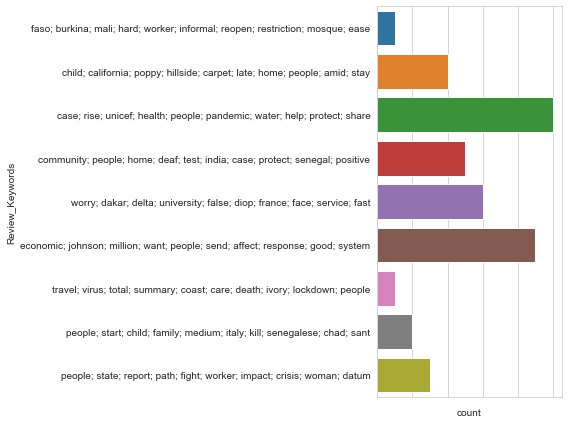

In [29]:
#datastudy21pov = datastudy21[datastudy21["impact"]=="poverty"]
datastudy21povpub = datastudy21pov[datastudy21pov["topics"]=="public protect"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21povpub)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [30]:
## Creating a pie chart
# create labels using all unique values in the column named "population"
labels = hungdf["topics"].unique()
# group by count of the "population" column.
values = hungdf["Counts"]
# Custom define a list of colors to be used for the pie chart.
# Note that the same number of colors are specified as there are unique populations. It is not mandatory, but
# will avoid a single color to be used multiple times.
earth_colors = [
    "rgb(210,180,140)",
    "rgb(218,165,32)",
    "rgb(139,69,19)",
    "rgb(175, 51, 21)",
    "rgb(35, 36, 21)",
    "rgb(188,143,143)",
]
# defining the actual figure using the dimension: population
# Note that a pull keyword was specified to explode pie pieces out of the center
fig = go.Figure(
    data=[
        go.Pie(
            labels=labels,
            values=values,
            # pull is given as a fraction of the pie radius
            pull=[0, 0, 0.07, 0.08, 0.02, 0.2],
            # iterate through earth_colors list to color individual pie pieces
            marker_colors=earth_colors,
        )
    ]
)
# Update layout to show a title
fig.update_layout(title_text="Topics about hunger from Covid-19 data")
# display the figure
fig.show()

C:\Users\HARYS\AppData\Local\Temp\ipykernel_9864\2862796268.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



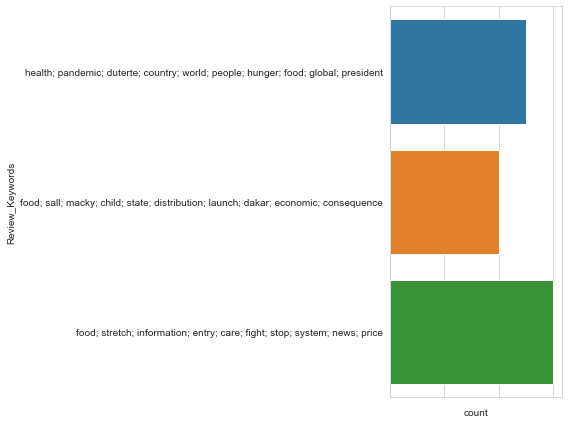

In [31]:
datastudy21hung = datastudy21[datastudy21["impact"]=="hunger"]
datastudy21hunghun = datastudy21hung[datastudy21hung["topics"]=="hunger report"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21hunghun)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

C:\Users\HARYS\AppData\Local\Temp\ipykernel_12656\46611220.py:5: UserWarning:

FixedFormatter should only be used together with FixedLocator



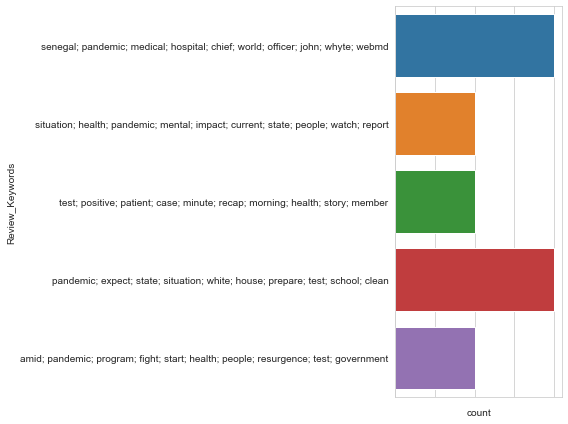

In [66]:
datastudy21hungcov = datastudy21hung[datastudy21hung["topics"]=="covid report"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21hungcov)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

C:\Users\HARYS\AppData\Local\Temp\ipykernel_12656\1501962478.py:5: UserWarning:

FixedFormatter should only be used together with FixedLocator



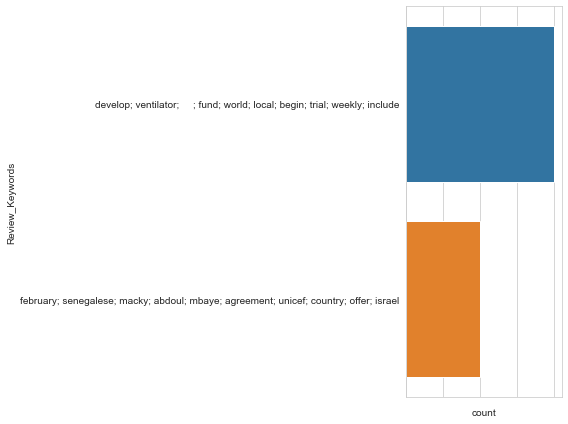

In [68]:
datastudy21hungfund = datastudy21hung[datastudy21hung["topics"]=="fund plociy"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21hungfund)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

C:\Users\HARYS\AppData\Local\Temp\ipykernel_12656\3958006685.py:5: UserWarning:

FixedFormatter should only be used together with FixedLocator



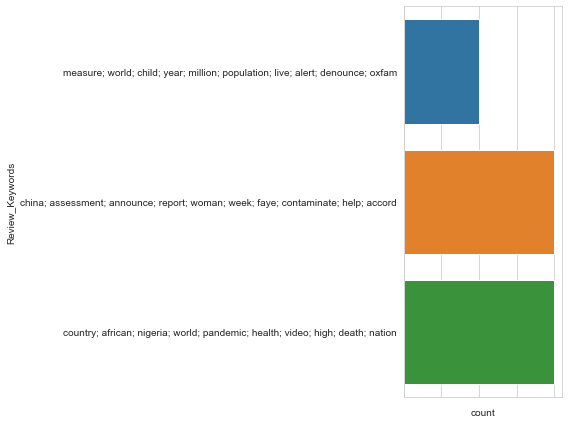

In [69]:
datastudy21hungwor = datastudy21hung[datastudy21hung["topics"]=="world report"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21hungwor)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

C:\Users\HARYS\AppData\Local\Temp\ipykernel_9864\1906803148.py:5: UserWarning:

FixedFormatter should only be used together with FixedLocator



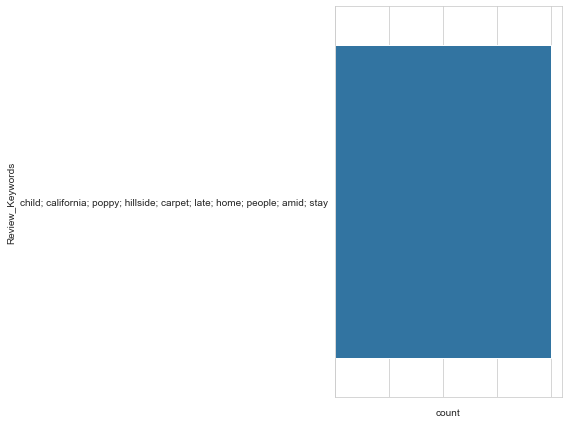

In [32]:
datastudy21hungpub = datastudy21hung[datastudy21hung["topics"]=="public protect"]
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Review_Keywords', data=datastudy21hungpub)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

# Keyphrase Extraction

***Keyphrase extraction*** is a textual information processing task concerned with the automatic extraction of representative and characteristic phrases from a document that express all the key aspects of its content. Keyphrases constitute a succinct conceptual summary of a document, which is very useful in digital information management systems for semantic indexing, faceted search, document clustering and classification.

There exist both supervised and unsupervised keyphrase extraction methods. Unsupervised methods are popular because they are domain independent and do not need labeled training data so I use unsupervised methode. The most important merit of unsupervised models is that they can work in a new area or language with little or no adjustments. We can divide the unsupervised techniques into two subsets statistical models and graphbased models

***Statistical models:*** are models that select candidates based on their statistical features Such as TF and IDF,Sentence Position, Word Position and etc. The most popular statistical algorithm is TFIDF, Kpminer, Yake and etc.

***Graph-based Models:*** These approaches typically consist of two steps: (1) building a graph representation of the document with words as nodes and semantic relation between them as edges; (2) ranking nodes using a graph-theoretic measure and using the top-ranked ones as keyphrases .The most popular Graph-based algorithm is Text Rank, Single Rank, Topic Rank, Multipartiti Rank, Scake and etc. Most of unsupervised models are implemented using PKE (an open source python-based keyphrase extraction toolkit) and I use PKE toolkit

In [89]:
df = pd.read_excel('C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/sampleall2.xlsx', sheet_name='Sheet1')
df.head(5)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
0        197                     21                93.000001   
1        202                      4                99.000001   
2        261                     21               100.000000   
3        459                      4                99.000001   
4        505                     22                81.999999   

                                     Review_Keywords  \
0  group; china; senegal; pandemic; people; watch...   
1  senegal; pandemic; medical; hospital; chief; w...   
2  group; china; senegal; pandemic; people; watch...   
3  senegal; pandemic; medical; hospital; chief; w...   
4  pandemic; expect; state; situation; white; hou...   

                                     Original review  index  \
0  ['senegal'; 'beach'; 'resort'; 'business'; 'ha...    197   
1  ['hunger'; 'poverty'; 'unemployment'; 'feed'; ...    202   
2  ['founder'; 'president'; 'sedima'; 'group'; 'b...    261   
3  ['hunger'; 'poverty'; 'unemployment'; 'feed'; ...    459   
4  ['globalink'; 'shanghai'; 'maintain'; 'export'...    505   

                                   ConsumerComplaint  polarity  subjectivity  \
0  senegal beach resort business hit hard  econom... -0.127778      0.427778   
1  hunger poverty unemployment feed poor hungry n... -0.066667      0.400000   
2  founder president sedima group mr babacar ngom...  0.112821      0.402564   
3  hunger poverty unemployment feed poor hungry n... -0.066667      0.400000   
4  globalink shanghai maintain car export despite...  0.123958      0.370833   

   score        topics    impact  code      tool  
0      0  covid report  business     1  facebook  
1      0  covid report  business     1  facebook  
2      1  covid report  business     1  facebook  
3      0  covid report  business     1  facebook  
4      1  covid report  business     1  facebook

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Review_No                1337 non-null   int64  
 1   Dominant_Review_Topic    1337 non-null   int64  
 2   Percent_contr_per_topic  1337 non-null   float64
 3   Review_Keywords          1337 non-null   object 
 4   Original review          1337 non-null   object 
 5   index                    1337 non-null   int64  
 6   ConsumerComplaint        1337 non-null   object 
 7   polarity                 1337 non-null   float64
 8   subjectivity             1337 non-null   float64
 9   score                    1337 non-null   int64  
 10  topics                   1337 non-null   object 
 11  impact                   1337 non-null   object 
 12  code                     1337 non-null   int64  
 13  tool                     1337 non-null   object 
dtypes: float64(3), int64(5),

In [91]:
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
##Creating a list of custom stopwords
new_words = ["fig","figure","image","sample","using", 
             "show", "result", "large", 
             "also", "one", "two", "three", 
             "four", "five", "seven","eight","nine"]
stop_words = list(stop_words.union(new_words))

def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    # remove stopwords
    text = [word for word in text if word not in stop_words]

    # remove words less than three letters
    text = [word for word in text if len(word) >= 3]

    # lemmatize
    lmtzr = WordNetLemmatizer()
    text = [lmtzr.lemmatize(word) for word in text]
    
    return ' '.join(text)

In [34]:
docs = df['ConsumerComplaint'].apply(lambda x:pre_process(x))

In [35]:
docs[1][0:103]

'hunger poverty unemployment feed poor hungry needy people team tarasankar charity youtube link httpsyou'

## 1.TF-IDF and Scikit-learn


TF-IDF stands for Text Frequency Inverse Document Frequency. The importance of each word increases proportionally to the number of times a word appears in the document (Text Frequency - TF) but is offset by the frequency of the word in the corpus (Inverse Document Frequency - IDF). Using the tf-idf weighting scheme, the keywords are the words with the higherst TF-IDF score.

### 1.1 CountVectorizer to create a vocabulary and generate word counts

In [36]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
#docs = docs.tolist()
#create a vocabulary of words, 
cv=CountVectorizer(max_df=0.95,         # ignore words that appear in 95% of documents
                   max_features=10000,  # the size of the vocabulary
                   ngram_range=(1,3)    # vocabulary contains single words, bigrams, trigrams
                  )
word_count_vector=cv.fit_transform(docs)

CPU times: total: 203 ms
Wall time: 221 ms


### 1.2 TfidfTransformer to Compute Inverse Document Frequency (IDF)

In [37]:
%%time
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

CPU times: total: 0 ns
Wall time: 11.3 ms


TfidfTransformer()

Once we have our IDF computed, we are now ready to compute TF-IDF and extract the top keywords.

In [38]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [39]:
# get feature names
feature_names=cv.get_feature_names()

def get_keywords(idx, docs):

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([docs[idx]]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords

def print_results(idx,keywords, df):
    # now print the results
    print("\n=====text=====")
    print(df['ConsumerComplaint'][idx])
    #print("\n=========")
    #print(df['abstract'][idx])
    print("\n===Keywords===")
    for k in keywords:
        print(k,keywords[k])

C:\Users\HARYS\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
idx=941
keywords=get_keywords(idx, docs)
print_results(idx,keywords, df)


=====text=====
respond global shock manage uncertainty wbg spring meeting  spring meeting take place shadow war ukraine rise global challenge conflict  welcome respond global shock manage uncertainty world economic outlook forecast macroeconomic perspective supply chain food fertilizer energy production reversal education literacy market access develop country reconstruction ukraine assistance response challenge ahead ukraine interest rate debt level inequality transparency debt expectation wbgimf spring meeting  close remark world economic outlook forecast macroeconomic perspective

===Keywords===
spring meeting 0.191
spring 0.185
ukraine 0.163
meeting 0.143
world economic outlook 0.127
shock manage uncertainty 0.127
shock manage 0.127
respond global shock 0.127
respond global 0.127
outlook forecast macroeconomic 0.127


I am not happy with result. I would like to add a filter that will remove similar keywords, or short keywords inside of complex ones. For instance, non-negative matrix factorization meets us 5 time: non negative matrix, negative matrix, nmf, matrix factorization, matrix. Adding a 4-grams does not change the situation. Similar keywords appears due to the fact that TF-IDF does not take into account the context, the keywords importance comes only from their frequencies relationship. Thus, TF-IDF is a quick, intuitive, but not the best way to extract keywords from the text. Let's look at other ways.

## 2. Gensim implementation of TextRank summarization algorithm

Gensim is a free Python library designed to automatically extract semantic topics from documents. The gensim implementation is based on the popular TextRank algorithm. 

[Documentation](https://radimrehurek.com/gensim/summarization/keywords.html)

[Tutorial](https://rare-technologies.com/text-summarization-with-gensim/)

### 2.1 Small text

In [41]:
import gensim
text = "Non-negative matrix factorization (NMF) has previously been shown to " + \
"be a useful decomposition for multivariate data. Two different multiplicative " + \
"algorithms for NMF are analyzed. They differ only slightly in the " + \
"multiplicative factor used in the update rules. One algorithm can be shown to " + \
"minimize the conventional least squares error while the other minimizes the  " + \
"generalized Kullback-Leibler divergence. The monotonic convergence of both  " + \
"algorithms can be proven using an auxiliary function analogous to that used " + \
"for proving convergence of the Expectation-Maximization algorithm. The algorithms  " + \
"can also be interpreted as diagonally rescaled gradient descent, where the  " + \
"rescaling factor is optimally chosen to ensure convergence."
gensim.summarization.keywords(text, 
         ratio=0.5,               # use 50% of original text
         words=None,              # Number of returned words
         split=True,              # Whether split keywords
         scores=False,            # Whether score of keyword
         pos_filter=('NN', 'JJ'), # Part of speech (nouns, adjectives etc.) filters
         lemmatize=True,         # If True - lemmatize words
         deacc=True)              # If True - remove accentuation

['factor',
 'convergence',
 'rescaling',
 'multiplicative',
 'function',
 'kullback',
 'gradient',
 'algorithm',
 'matrix',
 'rules',
 'update',
 'optimally chosen',
 'decomposition']

In [42]:
print("SUMMARY: ", gensim.summarization.summarize(text,
                                                  ratio = 0.5,
                                                  split = True))

SUMMARY:  ['Non-negative matrix factorization (NMF) has previously been shown to be a useful decomposition for multivariate data.', 'Two different multiplicative algorithms for NMF are analyzed.', 'They differ only slightly in the multiplicative factor used in the update rules.']


### 2.2 Large text

In [43]:
def get_keywords_gensim(idx, docs):
    
    keywords=gensim.summarization.keywords(docs[idx], 
                                  ratio=None, 
                                  words=10,         
                                  split=True,             
                                  scores=False,           
                                  pos_filter=None, 
                                  lemmatize=True,         
                                  deacc=True)              
    
    return keywords

def print_results_gensim(idx,keywords, df):
    # now print the results
    print("\n=====Title=====")
    print(df['ConsumerComplaint'][idx])
    #print("\n=====Abstract=====")
    #print(df['abstract'][idx])
    print("\n===Keywords===")
    for k in keywords:
        print(k)

In [44]:
idx=941
keywords=get_keywords_gensim(idx, docs)
print_results_gensim(idx,keywords, df)


=====Title=====
respond global shock manage uncertainty wbg spring meeting  spring meeting take place shadow war ukraine rise global challenge conflict  welcome respond global shock manage uncertainty world economic outlook forecast macroeconomic perspective supply chain food fertilizer energy production reversal education literacy market access develop country reconstruction ukraine assistance response challenge ahead ukraine interest rate debt level inequality transparency debt expectation wbgimf spring meeting  close remark world economic outlook forecast macroeconomic perspective

===Keywords===
ukraine
debt
global
challenge
spring
world
uncertainty
shadow
fertilizer energy


In [45]:
import gensim 
from gensim.summarization import summarize 
from gensim.summarization import keywords 

for i in range(0, df.shape[0]):
    text = df.iloc[i]['ConsumerComplaint']
def summary_answer(text):
    try:
        return summarize(text)
    except ValueError:
        return text
df['summary_answer'] = df['ConsumerComplaint'].apply(summary_answer)


df.head(5)

Review_No  Dominant_Review_Topic  Percent_contr_per_topic  \
0        197                     21                93.000001   
1        202                      4                99.000001   
2        261                     21               100.000000   
3        459                      4                99.000001   
4        505                     22                81.999999   

                                     Review_Keywords  \
0  group; china; senegal; pandemic; people; watch...   
1  senegal; pandemic; medical; hospital; chief; w...   
2  group; china; senegal; pandemic; people; watch...   
3  senegal; pandemic; medical; hospital; chief; w...   
4  pandemic; expect; state; situation; white; hou...   

                                     Original review  index  \
0  ['senegal'; 'beach'; 'resort'; 'business'; 'ha...    197   
1  ['hunger'; 'poverty'; 'unemployment'; 'feed'; ...    202   
2  ['founder'; 'president'; 'sedima'; 'group'; 'b...    261   
3  ['hunger'; 'poverty'; 'unemployment'; 'feed'; ...    459   
4  ['globalink'; 'shanghai'; 'maintain'; 'export'...    505   

                                   ConsumerComplaint  polarity  subjectivity  \
0  senegal beach resort business hit hard  econom... -0.127778      0.427778   
1  hunger poverty unemployment feed poor hungry n... -0.066667      0.400000   
2  founder president sedima group mr babacar ngom...  0.112821      0.402564   
3  hunger poverty unemployment feed poor hungry n... -0.066667      0.400000   
4  globalink shanghai maintain car export despite...  0.123958      0.370833   

   score        topics    impact  code      tool  \
0      0  covid report  business     1  facebook   
1      0  covid report  business     1  facebook   
2      1  covid report  business     1  facebook   
3      0  covid report  business     1  facebook   
4      1  covid report  business     1  facebook   

                                      summary_answer  
0  senegal beach resort business hit hard  econom...  
1  hunger poverty unemployment feed poor hungry n...  
2  founder president sedima group mr babacar ngom...  
3  hunger poverty unemployment feed poor hungry n...  
4  globalink shanghai maintain car export despite...

In [52]:
df.to_excel("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/keyphrasettwo.xlsx", index=False)


The keywords highlight the main point , but still miss valuable information

## 3. Python implementation of the Rapid Automatic Keyword Extraction algorithm (RAKE) using NLTK

[Documentation](https://github.com/csurfer/rake-nltk)

### Setup using pip

In [33]:
!pip install rake-nltk

### or directly from the repository

In [34]:
 #!git clone https://github.com/csurfer/rake-nltk.git
# !python rake-nltk/setup.py install

### 3.1 Small text

In [35]:
text = "Non-negative matrix factorization (NMF) has previously been shown to " + \
"be a useful decomposition for multivariate data. Two different multiplicative " + \
"algorithms for NMF are analyzed. They differ only slightly in the " + \
"multiplicative factor used in the update rules. One algorithm can be shown to " + \
"minimize the conventional least squares error while the other minimizes the  " + \
"generalized Kullback-Leibler divergence. The monotonic convergence of both  " + \
"algorithms can be proven using an auxiliary function analogous to that used " + \
"for proving convergence of the Expectation-Maximization algorithm. The algorithms  " + \
"can also be interpreted as diagonally rescaled gradient descent, where the  " + \
"rescaling factor is optimally chosen to ensure convergence."

In [36]:
from rake_nltk import Rake
r = Rake()
r.extract_keywords_from_text(text)
r.get_ranked_phrases_with_scores()[:10]

[(16.0, 'diagonally rescaled gradient descent'),
 (16.0, 'conventional least squares error'),
 (13.5, 'two different multiplicative algorithms'),
 (9.0, 'negative matrix factorization'),
 (9.0, 'auxiliary function analogous'),
 (8.0, 'multiplicative factor used'),
 (4.5, 'rescaling factor'),
 (4.0, 'useful decomposition'),
 (4.0, 'update rules'),
 (4.0, 'proving convergence')]

Wow! We see well interbretable machine learning terminology! But why diagonally rescaled gradient descent is more important than negative matrix factorization? 

### 3.2 Large Text


In [37]:
def get_keywords_rake(idx, docs, n=10):
    # Uses stopwords for english from NLTK, and all puntuation characters by default
    r = Rake()
    
    # Extraction given the text.
    r.extract_keywords_from_text(docs[idx][1000:2000])
    
    # To get keyword phrases ranked highest to lowest.
    keywords = r.get_ranked_phrases()[0:n]
    
    return keywords

def print_results(idx,keywords, df):
    # now print the results
    print("\n=====Title=====")
    print(df['ConsumerComplaint'][idx])
   # print("\n=====Abstract=====")
   # print(df['abstract'][idx])
    print("\n===Keywords===")
    for k in keywords:
        print(k)

idx=941
keywords = get_keywords_rake(idx, docs, n=10)
print_results(idx, keywords, df)


=====Title=====
respond global shock manage uncertainty wbg spring meeting  spring meeting take place shadow war ukraine rise global challenge conflict  welcome respond global shock manage uncertainty world economic outlook forecast macroeconomic perspective supply chain food fertilizer energy production reversal education literacy market access develop country reconstruction ukraine assistance response challenge ahead ukraine interest rate debt level inequality transparency debt expectation wbgimf spring meeting  close remark world economic outlook forecast macroeconomic perspective

===Keywords===


Oups! Something goes wrong! Algorithm does not work for the preprocessed text without punctuations. Let's treat the raw text.

In [38]:
idx=941
keywords = get_keywords_rake(idx, df['ConsumerComplaint'], n=10)
print_results(idx, keywords, df)


=====Title=====
respond global shock manage uncertainty wbg spring meeting  spring meeting take place shadow war ukraine rise global challenge conflict  welcome respond global shock manage uncertainty world economic outlook forecast macroeconomic perspective supply chain food fertilizer energy production reversal education literacy market access develop country reconstruction ukraine assistance response challenge ahead ukraine interest rate debt level inequality transparency debt expectation wbgimf spring meeting  close remark world economic outlook forecast macroeconomic perspective

===Keywords===


Presented implementation works well on sentences, but it is not flexible enough for large text. However, those who are interested in RANK can expand the capabilities of this code to their needs. We will consider next options.

## 4. Yet Another Keyword Extractor (Yake)

[Documentation](https://github.com/LIAAD/yake)

In [39]:
#!pip install git+https://github.com/LIAAD/yake

  Running command git clone -q https://github.com/LIAAD/yake 'C:\Users\HARYS\AppData\Local\Temp\pip-req-build-2wabiks2'



  Cloning https://github.com/LIAAD/yake to c:\users\harys\appdata\local\temp\pip-req-build-2wabiks2
  Resolved https://github.com/LIAAD/yake to commit 4f82feb2dfcf1a313621ecf6e4b2eeda6035d73c


In [40]:
import yake

def get_keywords_yake(idx, docs):
    y = yake.KeywordExtractor(lan='en',          # language
                             n = 3,              # n-gram size
                             dedupLim = 0.9,     # deduplicationthresold
                             dedupFunc = 'seqm', #  deduplication algorithm
                             windowsSize = 1,
                             top = 10,           # number of keys
                             features=None)           
    
    keywords = y.extract_keywords(text)
    return keywords

idx=941
keywords = get_keywords_yake(idx, docs[idx])
print_results(idx, keywords, df)


=====Title=====
respond global shock manage uncertainty wbg spring meeting  spring meeting take place shadow war ukraine rise global challenge conflict  welcome respond global shock manage uncertainty world economic outlook forecast macroeconomic perspective supply chain food fertilizer energy production reversal education literacy market access develop country reconstruction ukraine assistance response challenge ahead ukraine interest rate debt level inequality transparency debt expectation wbgimf spring meeting  close remark world economic outlook forecast macroeconomic perspective

===Keywords===
('Non-negative matrix factorization', 0.0041066275750552455)
('Non-negative matrix', 0.026529705128479162)
('matrix factorization', 0.026529705128479162)
('multivariate data', 0.026529705128479162)
('decomposition for multivariate', 0.03127464030655176)
('NMF', 0.06699743201311577)
('NMF are analyzed', 0.11148839518508058)
('algorithms', 0.13323194577601624)
('previously been shown', 0.137

Key phrases are repeated, and the text needs pre-processing to remove stop words

In [44]:
import yake

def get_keywords_yake(idx, docs):
    y = yake.KeywordExtractor(lan='en',          # language
                             n = 3,              # n-gram size
                             dedupLim = 0.9,     # deduplicationthresold
                             dedupFunc = 'seqm', #  deduplication algorithm
                             windowsSize = 1,
                             top = 10,           # number of keys
                             features=None)           
    
    keywords = y.extract_keywords(df['ConsumerComplaint'])
    return keywords

idx=941
keywords = get_keywords_yake(idx, docs[idx])
print_results(idx, keywords, df)

Warning! Exception: 'Series' object has no attribute 'split' generated by the following text: '0       senegal beach resort business hit hard  econom...
1       hunger poverty unemployment feed poor hungry n...
2       founder president sedima group mr babacar ngom...
3       hunger poverty unemployment feed poor hungry n...
4       globalink shanghai maintain car export despite...
                              ...                        
1332                                    projecthopetravel
1333                                    projecthopetravel
1334    secretary state antony blinken travel kenya  w...
1335     committee advise citizen travel upcoming isla...
1336                                    projecthopetravel
Name: ConsumerComplaint, Length: 1337, dtype: object' 

=====Title=====
respond global shock manage uncertainty wbg spring meeting  spring meeting take place shadow war ukraine rise global challenge conflict  welcome respond global shock manage uncertainty world econ

In [18]:
datastudy3 = pd.read_csv("C:/Users/harys/Downloads/covid3/covid/twitter/sampleoneall.csv", encoding = "UTF-8")
#datastudy.dropna()
datastudy3.head(2)

impact  nos           concern      tool
0  hunger    3       news report  facebook
1  hunger    3  education report  facebook

In [ ]:
#Piechart visualisation
plt.pie(datastudy3['impact'].value_counts(),labels=datastudy3['impact'].unique(),autopct='%1.2f%%')
#plt.figure(figsize=(10, 8))
plt.show()

In [ ]:
datastudy4 = pd.read_csv("C:/Users/harys/Downloads/covid3/covid/twitter/sampleone.csv", encoding = "UTF-8")
#datastudy.dropna()
datastudy4.head(2)

In [ ]:
#Piechart visualisation
plt.pie(datastudy4['impact'].value_counts(),labels=datastudy4['impact'].unique(),autopct='%1.2f%%')
#plt.figure(figsize=(10, 8))
plt.show()

In [53]:
tet = df['ConsumerComplaint']

In [54]:
import yake

def get_keywords_yake(idx, docs):
    y = yake.KeywordExtractor(lan='en',          # language
                             n = 3,              # n-gram size
                             dedupLim = 0.9,     # deduplicationthresold
                             dedupFunc = 'seqm', #  deduplication algorithm
                             windowsSize = 1,
                             top = 10,           # number of keys
                             features=None)           
    
    keywords = y.extract_keywords(tet)
    return keywords

idx=941
keywords = get_keywords_yake(idx, docs[idx])
print_results(idx, keywords, df)

Warning! Exception: 'Series' object has no attribute 'split' generated by the following text: '0       ['senegal'; 'beach'; 'resort'; 'business'; 'ha...
1       ['hunger'; 'poverty'; 'unemployment'; 'feed'; ...
2       ['founder'; 'president'; 'sedima'; 'group'; 'b...
3       ['hunger'; 'poverty'; 'unemployment'; 'feed'; ...
4       ['globalink'; 'shanghai'; 'maintain'; 'export'...
                              ...                        
1332                     ['       '; 'projecthopetravel']
1333                     ['       '; 'projecthopetravel']
1334    ['secretary'; 'state'; 'antony'; 'blinken'; 't...
1335    ['committee'; 'advise'; 'citizen'; 'travel'; '...
1336                     ['       '; 'projecthopetravel']
Name: Original review, Length: 1337, dtype: object' 

=====Title=====
respond global shock manage uncertainty wbg spring meeting  spring meeting take place shadow war ukraine rise global challenge conflict  welcome respond global shock manage uncertainty world econom

Key phrases are repeated, and the text needs pre-processing to remove stop words

## 5. Keyphrases extraction using pke

`pke` an open source python-based keyphrase extraction toolkit. It provides an end-to-end keyphrase extraction pipeline in which each component can be easily modified or extended to develop new models.

`pke` currently implements the following keyphrase extraction models:

* Unsupervised models
  * Statistical models
    * TfIdf [[documentation](https://boudinfl.github.io/pke/build/html/unsupervised.html#tfidf)]
    * KPMiner [[documentation](https://boudinfl.github.io/pke/build/html/unsupervised.html#kpminer), [article by (El-Beltagy and Rafea, 2010)](http://www.aclweb.org/anthology/S10-1041.pdf)]
    * YAKE [[documentation](https://boudinfl.github.io/pke/build/html/unsupervised.html#yake), [article by (Campos et al., 2020)](https://doi.org/10.1016/j.ins.2019.09.013)]
  * Graph-based models
    * TextRank [[documentation](https://boudinfl.github.io/pke/build/html/unsupervised.html#textrank), [article by (Mihalcea and Tarau, 2004)](http://www.aclweb.org/anthology/W04-3252.pdf)]
    * SingleRank  [[documentation](https://boudinfl.github.io/pke/build/html/unsupervised.html#singlerank), [article by (Wan and Xiao, 2008)](http://www.aclweb.org/anthology/C08-1122.pdf)]
    * TopicRank [[documentation](https://boudinfl.github.io/pke/build/html/unsupervised.html#topicrank), [article by (Bougouin et al., 2013)](http://aclweb.org/anthology/I13-1062.pdf)]
    * TopicalPageRank [[documentation](https://boudinfl.github.io/pke/build/html/unsupervised.html#topicalpagerank), [article by (Sterckx et al., 2015)](http://users.intec.ugent.be/cdvelder/papers/2015/sterckx2015wwwb.pdf)]
    * PositionRank [[documentation](https://boudinfl.github.io/pke/build/html/unsupervised.html#positionrank), [article by (Florescu and Caragea, 2017)](http://www.aclweb.org/anthology/P17-1102.pdf)]
    * MultipartiteRank [[documentation](https://boudinfl.github.io/pke/build/html/unsupervised.html#multipartiterank), [article by (Boudin, 2018)](https://arxiv.org/abs/1803.08721)]
* Supervised models
  * Feature-based models
    * Kea [[documentation](https://boudinfl.github.io/pke/build/html/supervised.html#kea), [article by (Witten et al., 2005)](https://www.cs.waikato.ac.nz/ml/publications/2005/chap_Witten-et-al_Windows.pdf)]
    * WINGNUS [[documentation](https://boudinfl.github.io/pke/build/html/supervised.html#wingnus), [article by (Nguyen and Luong, 2010)](http://www.aclweb.org/anthology/S10-1035.pdf)]


In [56]:
#!pip install git+https://github.com/boudinfl/pke.git

In [46]:
import pke

### 5.1  SingleRank

This model is an extension of the TextRank model that uses the number of co-occurrences to weigh edges in the graph.

In [47]:
text

'Non-negative matrix factorization (NMF) has previously been shown to be a useful decomposition for multivariate data. Two different multiplicative algorithms for NMF are analyzed. They differ only slightly in the multiplicative factor used in the update rules. One algorithm can be shown to minimize the conventional least squares error while the other minimizes the  generalized Kullback-Leibler divergence. The monotonic convergence of both  algorithms can be proven using an auxiliary function analogous to that used for proving convergence of the Expectation-Maximization algorithm. The algorithms  can also be interpreted as diagonally rescaled gradient descent, where the  rescaling factor is optimally chosen to ensure convergence.'

In [50]:
#!conda install -c conda-forge nipype=1.6.0 scipy=1.8.0

# Kpminer Compute Covid-19 Articles words DF 
Compute Document Frequency (DF) counts from a collection of documents. 
N-grams up to 3-grams are extracted and converted to their n-stems forms.
Those containing a token that occurs in a stoplist are filtered out.
Output file is in compressed (gzip) tab-separated-values format (tsv.gz)

In [56]:
#articles = df['ConsumerComplaint']
frames  = [df[['index','ConsumerComplaint']]]
articles = pd.concat(frames)
articles.head(5)


index                                  ConsumerComplaint
0    197  senegal beach resort business hit hard  econom...
1    202  hunger poverty unemployment feed poor hungry n...
2    261  founder president sedima group mr babacar ngom...
3    459  hunger poverty unemployment feed poor hungry n...
4    505  globalink shanghai maintain car export despite...

In [57]:
#!pip install git+https://github.com/boudinfl/pke.git

In [58]:
from pke.base import LoadFile
from string import punctuation
from nltk.corpus import stopwords
import string
from collections import defaultdict
import os
import sys
import gzip

stoplist = list(stopwords.words('english')) + list(string.punctuation)

In [59]:



frequencies = defaultdict(int)
delimiter='\t'

# initialize number of documents
nb_documents = 0


#Note: im limit this item becuase is very time consumed task for my notebook
limite_dataset_article = 50
if limite_dataset_article is not None:
    my_df_articles = articles.head(limite_dataset_article)
else :
    my_df_articles = articles

output_file = 'df.tsv.gz'
for index,article in my_df_articles.iterrows():
    content = str(article.ConsumerComplaint)
    doc = LoadFile()
    doc.load_document(input=str(content))
    # n is number of n-gram
    doc.ngram_selection(n=3)
    #doc.candidate_filtering(stoplist=stoplist)
     # loop through candidates
    for lexical_form in doc.candidates:
        frequencies[lexical_form] += 1
    nb_documents += 1

    if nb_documents % 10 == 0:
        print("{} docs, memory used: {} mb".format(nb_documents,
                                                          sys.getsizeof(
                                                              frequencies)
                                                          / 1024 / 1024))
# create directories from path if not exists
if os.path.dirname(output_file):
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

# dump the df container
with gzip.open(output_file, 'wb') as f:
    # add the number of documents as special token
    first_line = '--NB_DOC--' + delimiter + str(nb_documents)
    f.write(first_line.encode('utf-8') + b'\n')
    for ngram in frequencies:
        line = ngram + delimiter + str(frequencies[ngram])
        f.write(line.encode('utf-8') + b'\n')



10 docs, memory used: 0.03525543212890625 mb
20 docs, memory used: 0.070404052734375 mb
30 docs, memory used: 0.070404052734375 mb
40 docs, memory used: 0.14072418212890625 mb
50 docs, memory used: 0.14072418212890625 mb


In [60]:
from pke.unsupervised import KPMiner
from pke import load_document_frequency_file

def phrase_extraction(input_text):
    extractor = KPMiner()
    extractor.load_document(input=input_text, language='en')
    lasf = 1
    cutoff = 400
    extractor.candidate_selection(lasf=lasf, cutoff=cutoff)#, stoplist=stoplist)

    # load document frequency file
    df = load_document_frequency_file(input_file='df.tsv.gz')
    alpha = 2.3
    sigma = 3.0
    try:
        extractor.candidate_weighting( alpha=alpha, sigma=sigma,df=df)
    except Exception as es :
        print(es)
    keyphrases = extractor.get_n_best(n=20)
    return keyphrases


#Note: im limit this item becuase is very time consumed task for my notebook
limite_dataset_article = None
if limite_dataset_article is not None:
    my_df_articles = articles.head(limite_dataset_article)
else :
    my_df_articles = articles

for index,article in my_df_articles.iterrows():
    content = str(article.ConsumerComplaint)
    print('ArticleId: ' , article.index)
    key_phrases = phrase_extraction(content)
    print(key_phrases)
    #print('*'*100)
    
df2 = pd.DataFrame(key_phrases)


ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('beach', 9.34485068394299), ('resort', 9.34485068394299), ('hard', 9.34485068394299), ('hit', 7.34485068394299), ('senegal beach', 6.9877703488054665), ('senegal beach resort', 6.9877703488054665), ('senegal beach resort business', 6.9877703488054665), ('beach resort', 6.9877703488054665), ('beach resort business', 6.9877703488054665), ('resort business', 6.9877703488054665), ('senegal', 6.174925682500679), ('downturn', 4.672425341971495), ('economic', 4.08746284125034), ('senegal beach resort business hit', 3.4938851744027333), ('beach resort business hit', 3.4938851744027333), ('beach resort business hit hard', 3.4938851744027333), ('resort business hit', 3.4938851744027333), ('resort business hit hard', 3.4938851744027333), ('business hit', 3.4938851744027333), ('business hit hard', 3.4938851744027333)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('people', 11.017276025914486), ('needy', 8.174

[('httpsafricabusinessinsider', 9.34485068394299), ('comscienceonechart', 9.34485068394299), ('vaccinesworkagainstthe3', 9.34485068394299), ('source httpsafricabusinessinsider', 8.878578796129299), ('source httpsafricabusinessinsider comscienceonechart', 8.878578796129299), ('httpsafricabusinessinsider comscienceonechart', 8.878578796129299), ('source', 6.700994494168266), ('cobreg', 4.672425341971495), ('webinar', 4.672425341971495), ('series', 4.672425341971495), ('perspective', 4.672425341971495), ('cobreg webinar', 4.439289398064649), ('cobreg webinar series', 4.439289398064649), ('webinar series', 4.439289398064649), ('perspective source', 4.439289398064649), ('perspective source httpsafricabusinessinsider', 4.439289398064649), ('perspective source httpsafricabusinessinsider comscienceonechart', 4.439289398064649), ('vaccinesworkagainstthe3 source', 4.439289398064649), ('vaccinesworkagainstthe3 source httpsafricabusinessinsider', 4.439289398064649), ('vaccinesworkagainstthe3 sourc

[('snegal', 3.350497247084133), ('hpitals', 3.350497247084133), ('submerge', 3.350497247084133), ('vague', 3.350497247084133), ('place', 3.350497247084133), ('occupy', 3.350497247084133), ('communication', 3.350497247084133), ('strategy', 3.350497247084133), ('hpitals submerge', 3.2883625170849253), ('vague aware', 3.2883625170849253), ('vague aware place', 3.2883625170849253), ('vague aware place occupy', 3.2883625170849253), ('vague aware place occupy communication', 3.2883625170849253), ('aware place', 3.2883625170849253), ('aware place occupy', 3.2883625170849253), ('aware place occupy communication', 3.2883625170849253), ('aware place occupy communication strategy', 3.2883625170849253), ('place occupy', 3.2883625170849253), ('place occupy communication', 3.2883625170849253), ('place occupy communication strategy', 3.2883625170849253)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('place', 6.700994494168266), ('occupy', 6.700994494168266), ('communication', 6.

[('increase', 8.017276025914487), ('trade', 7.507501021587551), ('pandemic farreaching', 6.403115832957293), ('pandemic farreaching socioeconomic', 6.403115832957293), ('pandemic farreaching socioeconomic effect', 6.403115832957293), ('pandemic farreaching socioeconomic effect increase', 6.403115832957293), ('farreaching socioeconomic', 6.403115832957293), ('farreaching socioeconomic effect', 6.403115832957293), ('farreaching socioeconomic effect increase', 6.403115832957293), ('farreaching socioeconomic effect increase poverty', 6.403115832957293), ('socioeconomic effect', 6.403115832957293), ('socioeconomic effect increase', 6.403115832957293), ('socioeconomic effect increase poverty', 6.403115832957293), ('socioeconomic effect increase poverty deepened', 6.403115832957293), ('effect increase', 6.403115832957293), ('effect increase poverty', 6.403115832957293), ('effect increase poverty deepened', 6.403115832957293), ('effect increase poverty deepened inequality', 6.403115832957293),

[('ford', 4.672425341971495), ('uk gov', 4.161833810685609), ('uk gov support', 4.161833810685609), ('uk gov support development', 4.161833810685609), ('uk gov support development business', 4.161833810685609), ('gov support', 4.161833810685609), ('gov support development', 4.161833810685609), ('gov support development business', 4.161833810685609), ('support development', 4.161833810685609), ('support development business', 4.161833810685609), ('development business', 4.161833810685609), ('morocco help', 4.161833810685609), ('morocco help catalyse', 4.161833810685609), ('morocco help catalyse investment', 4.161833810685609), ('help catalyse', 4.161833810685609), ('help catalyse investment', 4.161833810685609), ('catalyse investment', 4.161833810685609), ('gov', 4.08746284125034), ('manufacture', 4.08746284125034), ('morocco', 4.08746284125034)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('know', 6.174925682500679), ('10 minute', 4.521498460991773), ('10 minute 

[('nigerian', 17.017276025914487), ('welcome', 17.017276025914487), ('reopening', 17.017276025914487), ('land', 17.017276025914487), ('desk', 17.017276025914487), ('28322', 17.017276025914487), ('ghana', 14.017276025914486), ('border', 12.26238852375102), ('joynews', 11.344850683942992), ('19pandemic', 11.344850683942992), ('nigerian business', 10.089294086510566), ('nigerian business ghana', 10.089294086510566), ('nigerian business ghana welcome', 10.089294086510566), ('nigerian business ghana welcome reopening', 10.089294086510566), ('business ghana', 10.089294086510566), ('business ghana welcome', 10.089294086510566), ('business ghana welcome reopening', 10.089294086510566), ('business ghana welcome reopening land', 10.089294086510566), ('ghana welcome', 10.089294086510566), ('ghana welcome reopening', 10.089294086510566)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('category', 16.34985136500136), ('trailblazer', 8.17492568250068), ('right', 7.34485068394299)

[('happen', 11.344850683942992), ('closely', 9.34485068394299), ('watch', 9.34485068394299), ('employer', 9.34485068394299), ('closely watch', 6.9877703488054665), ('closely watch happen', 6.9877703488054665), ('closely watch happen employer', 6.9877703488054665), ('closely watch happen employer business', 6.9877703488054665), ('watch happen', 6.9877703488054665), ('watch happen employer', 6.9877703488054665), ('watch happen employer business', 6.9877703488054665), ('happen employer', 6.9877703488054665), ('happen employer business', 6.9877703488054665), ('employer business', 6.9877703488054665), ('entrepreneurship', 5.672425341971496), ('effect', 4.700994494168267), ('economic', 4.08746284125034), ('crisis', 4.08746284125034), ('entrepreneurship economic', 3.4938851744027333), ('entrepreneurship economic crisis', 3.4938851744027333)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('confession', 5.672425341971496), ('cond', 5.672425341971496), ('consecration', 5.672

[('food', 47.74152944562944), ('system', 28.03455205182897), ('change', 18.68970136788598), ('consider', 17.017276025914487), ('diet', 17.017276025914487), ('climate', 16.34985136500136), ('food system', 12.509178415305822), ('limate', 11.344850683942992), ('net', 11.344850683942992), ('adverse', 11.344850683942992), ('crop', 11.344850683942992), ('yield', 11.344850683942992), ('transformation', 11.344850683942992), ('ethically', 11.344850683942992), ('eat', 11.344850683942992), ('achieve', 9.34485068394299), ('project', 9.34485068394299), ('production', 9.34485068394299), ('disease', 8.17492568250068), ('people', 7.34485068394299)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('singapore', 28.36212670985748), ('open', 17.017276025914487), ('new business', 11.70045267706962), ('new business opportunity', 11.70045267706962), ('business opportunity', 11.70045267706962), ('singapore company', 11.70045267706962), ('enterprise', 11.344850683942992), ('company', 10.0514

[('sport', 11.344850683942992), ('rotusoddiri', 11.344850683942992), ('adesuwaomoruan', 11.344850683942992), ('michaelwilson', 11.344850683942992), ('aronakerejola', 11.344850683942992), ('pdp', 8.17492568250068), ('subscribe', 8.17492568250068), ('politics', 7.34485068394299), ('business politics', 6.433752750818332), ('business politics sport', 6.433752750818332), ('politics sport', 6.433752750818332), ('rotusoddiri adesuwaomoruan', 6.433752750818332), ('rotusoddiri adesuwaomoruan michaelwilson', 6.433752750818332), ('rotusoddiri adesuwaomoruan michaelwilson aronakerejola', 6.433752750818332), ('rotusoddiri adesuwaomoruan michaelwilson aronakerejola subscribe', 6.433752750818332), ('adesuwaomoruan michaelwilson', 6.433752750818332), ('adesuwaomoruan michaelwilson aronakerejola', 6.433752750818332), ('adesuwaomoruan michaelwilson aronakerejola subscribe', 6.433752750818332), ('michaelwilson aronakerejola', 6.433752750818332), ('michaelwilson aronakerejola subscribe', 6.433752750818332

[('education', 11.344850683942992), ('actor', 5.672425341971496), ('spar', 5.672425341971496), ('system', 4.672425341971495), ('sector', 4.672425341971495), ('crisis', 4.08746284125034), ('african actor', 4.0620948740460845), ('african actor look', 4.0620948740460845), ('african actor look resilient', 4.0620948740460845), ('african actor look resilient education', 4.0620948740460845), ('actor look', 4.0620948740460845), ('actor look resilient', 4.0620948740460845), ('actor look resilient education', 4.0620948740460845), ('actor look resilient education system', 4.0620948740460845), ('look resilient', 4.0620948740460845), ('look resilient education', 4.0620948740460845), ('look resilient education system', 4.0620948740460845), ('resilient education', 4.0620948740460845), ('resilient education system', 4.0620948740460845), ('education system', 4.0620948740460845)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('5000', 5.672425341971496), ('online', 5.672425341971496)

[('school', 12.26238852375102), ('reopen', 5.672425341971496), ('elementary', 5.672425341971496), ('middle', 5.672425341971496), ('high', 5.672425341971496), ('temporarily', 5.672425341971496), ('sanitary', 5.672425341971496), ('measure', 5.672425341971496), ('distancing', 5.672425341971496), ('mean', 5.672425341971496), ('student', 5.672425341971496), ('adjust', 5.672425341971496), ('reality', 5.672425341971496), ('age', 5.672425341971496), ('close', 4.672425341971495), ('social', 4.08746284125034), ('reopen elementary', 3.7346402872607367), ('reopen elementary school', 3.7346402872607367), ('reopen elementary school middle', 3.7346402872607367), ('reopen elementary school middle school', 3.7346402872607367)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('reopen', 11.344850683942992), ('logic', 5.672425341971496), ('curve', 5.672425341971496), ('peak', 5.672425341971496), ('slop', 5.672425341971496), ('malawi', 5.672425341971496), ('albeit', 5.672425341971496), (

[('sant', 11.344850683942992), ('situation', 5.672425341971496), ('tuesday', 5.672425341971496), ('august', 5.672425341971496), ('french', 5.672425341971496), ('version', 5.672425341971496), ('sneips', 5.672425341971496), ('education', 5.672425341971496), ('direction', 5.672425341971496), ('attach', 5.672425341971496), ('day', 4.672425341971495), ('minister', 4.672425341971495), ('information', 3.672425341971495), ('service', 3.672425341971495), ('snegal', 3.350497247084133), ('communication', 3.350497247084133), ('situation day', 3.2590021374680957), ('situation day tuesday', 3.2590021374680957), ('situation day tuesday august', 3.2590021374680957), ('situation day tuesday august 10', 3.2590021374680957)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('learn', 22.689701367885984), ('centre', 11.344850683942992), ('secondary', 11.344850683942992), ('high', 11.344850683942992), ('primary', 9.34485068394299), ('impact', 7.507501021587551), ('level', 7.34485068394299)

[('homeless', 17.017276025914487), ('resource', 17.017276025914487), ('eric', 11.344850683942992), ('tarz', 11.344850683942992), ('criminalization', 11.344850683942992), ('housing', 11.344850683942992), ('right', 11.017276025914486), ('poverty', 7.507501021587551), ('eric tarz', 6.220243256875246), ('human', 6.174925682500679), ('pape', 5.672425341971496), ('djibril', 5.672425341971496), ('fall', 5.672425341971496), ('sur', 5.672425341971496), ('situation', 5.672425341971496), ('actuelle', 5.672425341971496), ('sngal', 5.672425341971496), ('education', 5.672425341971496), ('associate', 5.672425341971496), ('legal', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('homeless', 17.017276025914487), ('resource', 17.017276025914487), ('roundtable', 11.344850683942992), ('eric', 11.344850683942992), ('tarz', 11.344850683942992), ('criminalization', 11.344850683942992), ('housing', 11.344850683942992), ('right', 11.017276025914486), ('poverty', 7.5075010

[('education', 11.344850683942992), ('worsen', 5.672425341971496), ('accord', 5.672425341971496), ('unesco', 5.672425341971496), ('generate', 5.672425341971496), ('disturbance', 5.672425341971496), ('digital', 5.672425341971496), ('fracture', 5.672425341971496), ('social', 4.08746284125034), ('worsen inequality', 3.8021691603794454), ('accord unesco', 3.8021691603794454), ('generate unprecedented', 3.8021691603794454), ('generate unprecedented disturbance', 3.8021691603794454), ('generate unprecedented disturbance education', 3.8021691603794454), ('generate unprecedented disturbance education source', 3.8021691603794454), ('unprecedented disturbance', 3.8021691603794454), ('unprecedented disturbance education', 3.8021691603794454), ('unprecedented disturbance education source', 3.8021691603794454), ('unprecedented disturbance education source social', 3.8021691603794454), ('disturbance education', 3.8021691603794454)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[(

[('senegal', 18.524777047502038), ('map', 16.34985136500136), ('country', 8.17492568250068), ('school', 8.17492568250068), ('year', 8.17492568250068), ('work', 8.17492568250068), ('map map', 6.565385853076455), ('director', 5.672425341971496), ('larson', 5.672425341971496), ('holt', 5.672425341971496), ('wrap', 5.672425341971496), ('sure', 5.672425341971496), ('recognize', 5.672425341971496), ('incredible', 5.672425341971496), ('accomplish', 5.672425341971496), ('teacher', 5.672425341971496), ('past', 5.672425341971496), ('situation', 5.672425341971496), ('somewhat', 5.672425341971496), ('stable', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('senegal', 18.524777047502038), ('map', 16.34985136500136), ('country', 8.17492568250068), ('school', 8.17492568250068), ('year', 8.17492568250068), ('work', 8.17492568250068), ('map map', 6.565385853076455), ('director', 5.672425341971496), ('larson', 5.672425341971496), ('holt', 5.672425341971496), ('wra

[('food', 25.706977393800464), ('insecurity', 17.017276025914487), ('shortage', 11.344850683942992), ('compelling', 11.344850683942992), ('educational', 11.344850683942992), ('topic', 11.344850683942992), ('significant', 11.344850683942992), ('widespread', 11.344850683942992), ('increase', 10.689701367885982), ('food insecurity', 9.6506291262275), ('financial', 9.34485068394299), ('lead', 9.34485068394299), ('approach', 9.34485068394299), ('economic', 8.17492568250068), ('food shortage', 6.433752750818333), ('financial economic', 6.433752750818333), ('financial economic compelling', 6.433752750818333), ('financial economic compelling educational', 6.433752750818333), ('financial economic compelling educational topic', 6.433752750818333), ('economic compelling', 6.433752750818333)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('coincidentally', 11.344850683942992), ('return', 11.344850683942992), ('west', 11.344850683942992), ('spread', 11.344850683942992), ('bitco

[('education', 45.37940273577197), ('girl', 28.03455205182897), ('girls education', 16.169180488982636), ('priority', 14.017276025914486), ('funders', 11.344850683942992), ('body', 11.344850683942992), ('west', 11.344850683942992), ('central', 11.344850683942992), ('invest', 11.017276025914486), ('recent', 9.34485068394299), ('year', 8.17492568250068), ('recent year', 6.467672195593055), ('recent year girls', 6.467672195593055), ('recent year girls education', 6.467672195593055), ('recent year girls education priority', 6.467672195593055), ('year girls', 6.467672195593055), ('year girls education', 6.467672195593055), ('year girls education priority', 6.467672195593055), ('year girls education priority government', 6.467672195593055), ('girls education priority', 6.467672195593055)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('education', 45.37940273577197), ('girl', 28.03455205182897), ('girls education', 16.169180488982636), ('priority', 14.017276025914486), (

[('education', 28.36212670985748), ('access', 14.017276025914486), ('high', 11.344850683942992), ('upended', 11.344850683942992), ('disrupt', 11.344850683942992), ('glare', 11.344850683942992), ('internet', 11.344850683942992), ('include', 9.34485068394299), ('life', 8.17492568250068), ('way', 8.17492568250068), ('function', 8.17492568250068), ('individual', 8.17492568250068), ('gap', 8.17492568250068), ('high education', 6.297953817323552), ('upended life', 6.297953817323552), ('upended life disrupt', 6.297953817323552), ('upended life disrupt way', 6.297953817323552), ('upended life disrupt way world', 6.297953817323552), ('life disrupt', 6.297953817323552), ('life disrupt way', 6.297953817323552)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('school', 24.52477704750204), ('feed', 18.362126709857478), ('programme', 14.017276025914486), ('school feed', 12.76126004336627), ('coverage', 12.26238852375102), ('range', 11.344850683942992), ('modality', 11.34485068394

[('conservation', 11.344850683942992), ('environmental', 11.344850683942992), ('effort', 8.17492568250068), ('conservation effort', 6.440842285529978), ('government', 6.174925682500679), ('e534', 5.672425341971496), ('hurt', 5.672425341971496), ('globe', 5.672425341971496), ('ecuador', 5.672425341971496), ('cook', 5.672425341971496), ('island', 5.672425341971496), ('distraction', 5.672425341971496), ('exploit', 5.672425341971496), ('environmentas', 5.672425341971496), ('rage', 5.672425341971496), ('cnns', 5.672425341971496), ('arwa', 5.672425341971496), ('damon', 5.672425341971496), ('speaks', 5.672425341971496), ('activist', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('presidential', 17.017276025914487), ('department', 11.344850683942992), ('meet', 9.34485068394299), ('concern', 9.34485068394299), ('rodrigo', 5.672425341971496), ('roa', 5.672425341971496), ('duterte', 5.672425341971496), ('convenes', 5.672425341971496), ('cabinet', 5.6724253

[('question', 11.344850683942992), ('answer', 11.344850683942992), ('session', 11.344850683942992), ('ministry', 11.344850683942992), ('medical', 11.344850683942992), ('service', 7.34485068394299), ('question answer', 6.639962774883022), ('question answer session', 6.639962774883022), ('question answer session ministry', 6.639962774883022), ('question answer session ministry health', 6.639962774883022), ('answer session', 6.639962774883022), ('answer session ministry', 6.639962774883022), ('answer session ministry health', 6.639962774883022), ('answer session ministry health medical', 6.639962774883022), ('session ministry', 6.639962774883022), ('session ministry health', 6.639962774883022), ('session ministry health medical', 6.639962774883022), ('session ministry health medical service', 6.639962774883022), ('ministry health', 6.639962774883022), ('ministry health medical', 6.639962774883022)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('antigen', 11.344850683

[('measure', 11.344850683942992), ('5th', 5.672425341971496), ('vran', 5.672425341971496), ('announce', 5.672425341971496), ('conference', 5.672425341971496), ('thursday', 5.672425341971496), ('axes', 5.672425341971496), ('avoid', 5.672425341971496), ('return', 5.672425341971496), ('gauge', 5.672425341971496), ('fire', 5.672425341971496), ('cover', 5.672425341971496), ('confinement', 5.672425341971496), ('closing', 4.672425341971495), ('work', 4.08746284125034), ('vran announce', 3.3583276770229022), ('measure conference', 3.3583276770229022), ('measure conference thursday', 3.3583276770229022), ('measure conference thursday government', 3.3583276770229022), ('measure conference thursday government work', 3.3583276770229022)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('measure', 11.344850683942992), ('5th', 5.672425341971496), ('vran', 5.672425341971496), ('announce', 5.672425341971496), ('conference', 5.672425341971496), ('thursday', 5.672425341971496), ('axes

[('genderbased', 17.017276025914487), ('violence', 17.017276025914487), ('situation', 11.344850683942992), ('husband', 11.344850683942992), ('genderbased violence', 9.809035917440829), ('work', 8.17492568250068), ('situation husband', 6.5393572782938865), ('situation husband work', 6.5393572782938865), ('husband work', 6.5393572782938865), ('government', 6.174925682500679), ('survivor', 5.672425341971496), ('nairobi', 5.672425341971496), ('september', 5.672425341971496), ('kenyan', 5.672425341971496), ('disaster', 5.672425341971496), ('1500', 5.672425341971496), ('triple', 5.672425341971496), ('compare', 5.672425341971496), ('shelter', 5.672425341971496), ('overwhelm', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('data', 53.13701693625442), ('government', 18.524777047502038), ('potential', 16.34985136500136), ('performance', 14.68970136788598), ('data development', 12.634589589209499), ('country', 12.26238852375102), ('gap', 12.26238852375102)

[('rollouts', 17.017276025914487), ('include', 14.017276025914486), ('refugee', 14.017276025914486), ('united nation', 9.192467945487406), ('refugee include', 9.192467945487406), ('rollouts work', 9.192467945487406), ('rollouts work government', 9.192467945487406), ('work government', 9.192467945487406), ('work', 8.17492568250068), ('united', 7.34485068394299), ('government', 6.174925682500679), ('urges', 5.672425341971496), ('nation', 4.700994494168267), ('un urges', 4.596233972743703), ('un urges country', 4.596233972743703), ('un urges country include', 4.596233972743703), ('un urges country include refugee', 4.596233972743703), ('urges country', 4.596233972743703), ('urges country include', 4.596233972743703), ('urges country include refugee', 4.596233972743703)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('ppe', 17.017276025914487), ('item', 12.26238852375102), ('kindly', 11.344850683942992), ('scottish', 11.344850683942992), ('battle', 11.344850683942992),

[('america', 11.344850683942992), ('trigger', 5.672425341971496), ('protect', 5.672425341971496), ('citizens', 5.672425341971496), ('kerala', 5.672425341971496), ('asia', 5.672425341971496), ('europe', 5.672425341971496), ('north', 5.672425341971496), ('covid19africa', 5.672425341971496), ('anglophone', 5.672425341971496), ('doubly', 5.672425341971496), ('interesting', 5.672425341971496), ('failure', 5.672425341971496), ('handle', 5.672425341971496), ('coloniser', 5.672425341971496), ('britain', 5.672425341971496), ('experience', 4.672425341971495), ('safety', 4.672425341971495), ('east', 4.672425341971495), ('function', 4.08746284125034)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('america', 11.344850683942992), ('trigger', 5.672425341971496), ('protect', 5.672425341971496), ('citizen', 5.672425341971496), ('kerala', 5.672425341971496), ('asia', 5.672425341971496), ('europe', 5.672425341971496), ('north', 5.672425341971496), ('covid19africa', 5.672425341971496

[('gender', 11.344850683942992), ('protection', 11.344850683942992), ('early', 11.344850683942992), ('social', 8.17492568250068), ('policy', 8.17492568250068), ('care', 7.34485068394299), ('national', 7.0514917412524), ('challenge', 6.700994494168266), ('national social', 6.27778298716213), ('national social protection', 6.27778298716213), ('national social protection policy', 6.27778298716213), ('social protection', 6.27778298716213), ('social protection policy', 6.27778298716213), ('protection policy', 6.27778298716213), ('aot', 5.672425341971496), ('sngal', 5.672425341971496), ('187', 5.672425341971496), ('positifs', 5.672425341971496), ('graf', 5.672425341971496), ('rejoignez', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('omicron', 22.689701367885984), ('travel', 17.017276025914487), ('variant', 17.017276025914487), ('rundown', 11.344850683942992), ('british', 11.344850683942992), ('reintroduces', 11.344850683942992), ('threat', 11.344850

[('conflict', 17.017276025914487), ('democracy', 17.017276025914487), ('actor', 11.344850683942992), ('disaster', 11.344850683942992), ('experience', 9.34485068394299), ('recently', 9.34485068394299), ('emergency', 7.34485068394299), ('experience emergency', 6.346330208132054), ('experience emergency development', 6.346330208132054), ('experience emergency development actor', 6.346330208132054), ('experience emergency development actor conflict', 6.346330208132054), ('emergency development', 6.346330208132054), ('emergency development actor', 6.346330208132054), ('emergency development actor conflict', 6.346330208132054), ('emergency development actor conflict disaster', 6.346330208132054), ('development actor', 6.346330208132054), ('development actor conflict', 6.346330208132054), ('development actor conflict disaster', 6.346330208132054), ('development actor conflict disaster recently', 6.346330208132054), ('actor conflict', 6.346330208132054)]
ArticleId:  Index(['index', 'ConsumerCo

[('fdi', 56.72425341971496), ('country', 20.4373142062517), ('flow', 17.017276025914487), ('remark', 14.017276025914486), ('welcome', 11.344850683942992), ('opening', 11.344850683942992), ('role', 11.344850683942992), ('miga', 11.344850683942992), ('drive', 11.344850683942992), ('investment', 11.017276025914486), ('fdi flow', 9.819415849628596), ('sector', 9.34485068394299), ('investor', 9.34485068394299), ('project', 9.34485068394299), ('affect', 8.17492568250068), ('video', 6.700994494168266), ('welcome opening', 6.546277233085731), ('welcome opening remark', 6.546277233085731), ('opening remark', 6.546277233085731), ('senegal', 6.174925682500679)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('shipment', 17.017276025914487), ('moderna', 11.344850683942992), ('arrive', 11.344850683942992), ('toronto', 11.344850683942992), ('pearson', 11.344850683942992), ('airport', 11.344850683942992), ('arrive toronto', 6.732255693761706), ('arrive toronto pearson', 6.73225569

[('shipment', 17.017276025914487), ('moderna', 11.344850683942992), ('arrive', 11.344850683942992), ('toronto', 11.344850683942992), ('pearson', 11.344850683942992), ('airport', 11.344850683942992), ('arrive toronto', 6.732255693761706), ('arrive toronto pearson', 6.732255693761706), ('arrive toronto pearson airport', 6.732255693761706), ('toronto pearson', 6.732255693761706), ('toronto pearson airport', 6.732255693761706), ('pearson airport', 6.732255693761706), ('wednesday', 5.672425341971496), ('delay', 5.672425341971496), ('reportedly', 5.672425341971496), ('related', 5.672425341971496), ('qualityassurance', 5.672425341971496), ('federal', 5.672425341971496), ('earlier', 5.672425341971496), ('cut', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('shipment', 17.017276025914487), ('moderna', 11.344850683942992), ('arrive', 11.344850683942992), ('toronto', 11.344850683942992), ('pearson', 11.344850683942992), ('airport', 11.344850683942992), ('a

[('shipment', 17.017276025914487), ('moderna', 11.344850683942992), ('arrive', 11.344850683942992), ('toronto', 11.344850683942992), ('pearson', 11.344850683942992), ('airport', 11.344850683942992), ('arrive toronto', 6.732255693761706), ('arrive toronto pearson', 6.732255693761706), ('arrive toronto pearson airport', 6.732255693761706), ('toronto pearson', 6.732255693761706), ('toronto pearson airport', 6.732255693761706), ('pearson airport', 6.732255693761706), ('wednesday', 5.672425341971496), ('delay', 5.672425341971496), ('reportedly', 5.672425341971496), ('related', 5.672425341971496), ('qualityassurance', 5.672425341971496), ('federal', 5.672425341971496), ('earlier', 5.672425341971496), ('cut', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('shipment', 17.017276025914487), ('moderna', 11.344850683942992), ('arrive', 11.344850683942992), ('toronto', 11.344850683942992), ('pearson', 11.344850683942992), ('airport', 11.344850683942992), ('a

[('monday', 5.672425341971496), ('tuesday', 5.672425341971496), ('discus', 5.672425341971496), ('fight', 5.672425341971496), ('trendingstories', 5.672425341971496), ('meet', 4.672425341971495), ('head', 4.08746284125034), ('head state', 3.9170200571158675), ('head state government', 3.9170200571158675), ('head state government meet', 3.9170200571158675), ('head state government meet monday', 3.9170200571158675), ('state government', 3.9170200571158675), ('state government meet', 3.9170200571158675), ('state government meet monday', 3.9170200571158675), ('state government meet monday tuesday', 3.9170200571158675), ('government meet', 3.9170200571158675), ('government meet monday', 3.9170200571158675), ('government meet monday tuesday', 3.9170200571158675), ('meet monday', 3.9170200571158675), ('meet monday tuesday', 3.9170200571158675)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('sophisticated', 5.672425341971496), ('hadfor', 5.672425341971496), ('handle', 5.672

[('fond', 11.344850683942992), ('friderichantumanneforation', 11.344850683942992), ('economy', 7.34485068394299), ('fond economy', 6.412306908315605), ('fond economy friderichantumanneforation', 6.412306908315605), ('economy friderichantumanneforation', 6.412306908315605), ('liberal', 5.672425341971496), ('dialogue', 5.672425341971496), ('fondation', 5.672425341971496), ('friedrich', 5.672425341971496), ('naumann', 5.672425341971496), ('political', 3.672425341971495), ('snegal', 3.350497247084133), ('liberal forum', 3.2061534541578025), ('liberal forum political', 3.2061534541578025), ('liberal forum political dialogue', 3.2061534541578025), ('liberal forum political dialogue government', 3.2061534541578025), ('forum political', 3.2061534541578025), ('forum political dialogue', 3.2061534541578025), ('forum political dialogue government', 3.2061534541578025)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('europe', 11.344850683942992), ('centre', 11.344850683942992)

[('lifeworlds crisis', 13.153450068339701), ('governmental restriction', 13.153450068339701), ('lifeworlds', 11.344850683942992), ('governmental', 11.344850683942992), ('crisis', 8.17492568250068), ('restriction', 8.17492568250068), ('argument lifeworlds', 6.576725034169851), ('argument lifeworlds crisis', 6.576725034169851), ('chad', 5.672425341971496), ('argument', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('500', 5.672425341971496), ('naria', 5.672425341971496), ('courtesy', 5.672425341971496), ('utilized', 5.672425341971496), ('microbiologist', 5.672425341971496), ('biochemist', 5.672425341971496), ('responsible', 4.672425341971495), ('500 naria', 3.5047021563668284), ('19 courtesy', 3.5047021563668284), ('19 courtesy responsible', 3.5047021563668284), ('19 courtesy responsible government', 3.5047021563668284), ('19 courtesy responsible government utilized', 3.5047021563668284), ('courtesy responsible', 3.5047021563668284), ('courtesy re

[('good', 7.34485068394299), ('national government', 6.368600824227768), ('government', 6.174925682500679), ('measure', 5.672425341971496), ('limit', 5.672425341971496), ('spread', 5.672425341971496), ('euhowever', 5.672425341971496), ('european', 5.672425341971496), ('citizen', 5.672425341971496), ('unable', 5.672425341971496), ('travel', 5.672425341971496), ('truck', 5.672425341971496), ('carry', 5.672425341971496), ('medicine', 5.672425341971496), ('essential', 5.672425341971496), ('blockedwe', 5.672425341971496), ('situation', 5.672425341971496), ('satellite', 5.672425341971496), ('image', 5.672425341971496), ('copernicus', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('vulnerable', 11.344850683942992), ('community', 6.700994494168266), ('vulnerable community', 6.473963705510946), ('senegal', 6.174925682500679), ('foot', 5.672425341971496), ('stop', 5.672425341971496), ('negative', 5.672425341971496), ('agrifood', 5.672425341971496), ('prod

[('chad', 5.672425341971496), ('previous', 5.672425341971496), ('dictator', 5.672425341971496), ('hissene', 5.672425341971496), ('habre', 5.672425341971496), ('accuse', 5.672425341971496), ('kill', 5.672425341971496), ('thousand', 5.672425341971496), ('convict', 5.672425341971496), ('crime', 5.672425341971496), ('die', 5.672425341971496), ('hospital', 5.672425341971496), ('court', 4.672425341971495), ('head', 4.08746284125034), ('state', 3.672425341971495), ('chad previous', 3.3397431814143776), ('chad previous dictator', 3.3397431814143776), ('chad previous dictator hissene', 3.3397431814143776), ('chad previous dictator hissene habre', 3.3397431814143776), ('previous dictator', 3.3397431814143776)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('face', 11.344850683942992), ('face challenge', 6.905561285878344), ('challenge', 6.700994494168266), ('resumption', 5.672425341971496), ('2021the', 5.672425341971496), ('revive', 5.672425341971496), ('heavily', 5.67242534

[('faster', 5.672425341971496), ('usa', 5.672425341971496), ('covid2019', 5.672425341971496), ('melanie', 5.672425341971496), ('wildman', 5.672425341971496), ('usa government', 3.94603502050191), ('usa government covid2019', 3.94603502050191), ('usa government covid2019 melanie', 3.94603502050191), ('usa government covid2019 melanie wildman', 3.94603502050191), ('government covid2019', 3.94603502050191), ('government covid2019 melanie', 3.94603502050191), ('government covid2019 melanie wildman', 3.94603502050191), ('covid2019 melanie', 3.94603502050191), ('covid2019 melanie wildman', 3.94603502050191), ('melanie wildman', 3.94603502050191), ('government', 3.0874628412503395)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('cost', 6.174925682500679), ('method', 5.672425341971496), ('1per', 5.672425341971496), ('roll', 5.672425341971496), ('commerciallythe', 5.672425341971496), ('ncdc', 5.672425341971496), ('lagos', 5.672425341971496), ('patronize', 5.672425341971496

[('teacher', 11.344850683942992), ('government', 6.174925682500679), ('abdoulaye', 5.672425341971496), ('ndoye', 5.672425341971496), ('cusems', 5.672425341971496), ('die', 5.672425341971496), ('contempt', 5.672425341971496), ('responsible', 4.672425341971495), ('main', 3.672425341971495), ('abdoulaye ndoye', 3.435164415169074), ('abdoulaye ndoye cusems', 3.435164415169074), ('abdoulaye ndoye cusems 20', 3.435164415169074), ('abdoulaye ndoye cusems 20 teacher', 3.435164415169074), ('ndoye cusems', 3.435164415169074), ('ndoye cusems 20', 3.435164415169074), ('ndoye cusems 20 teacher', 3.435164415169074), ('ndoye cusems 20 teacher die', 3.435164415169074), ('cusems 20', 3.435164415169074), ('cusems 20 teacher', 3.435164415169074), ('cusems 20 teacher die', 3.435164415169074)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('protect', 11.344850683942992), ('people', 11.017276025914486), ('health', 9.262388523751019), ('global', 7.460281679655566), ('protect people', 6.3

[('vaccination', 17.017276025914487), ('health', 12.349851365001358), ('worker', 11.344850683942992), ('minister', 9.34485068394299), ('senegal', 9.262388523751019), ('country', 8.17492568250068), ('shot', 5.672425341971496), ('abdoulaye', 5.672425341971496), ('diouf', 5.672425341971496), ('sarr', 5.672425341971496), ('person', 5.672425341971496), ('shoot', 5.672425341971496), ('sinopharm', 5.672425341971496), ('kick', 5.672425341971496), ('campaign', 5.672425341971496), ('tuesday', 5.672425341971496), ('medical', 5.672425341971496), ('begin', 5.672425341971496), ('underlying', 5.672425341971496), ('condition', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('vaccination', 17.017276025914487), ('program', 11.344850683942992), ('sinopharm', 11.344850683942992), ('officially', 9.34485068394299), ('start', 8.17492568250068), ('china', 8.17492568250068), ('senegal start', 7.152188474659713), ('vaccination program', 7.152188474659713), ('vaccination p

[('february', 11.344850683942992), ('vaccination', 11.344850683942992), ('senegalese', 9.34485068394299), ('officially', 9.34485068394299), ('senegalese president', 6.773045184443578), ('macky', 5.672425341971496), ('sall', 5.672425341971496), ('receive', 5.672425341971496), ('sinopharm', 5.672425341971496), ('begin', 5.672425341971496), ('phase', 5.672425341971496), ('medical', 5.672425341971496), ('worker', 5.672425341971496), ('president', 5.344850683942991), ('chinese', 4.672425341971495), ('dose', 4.672425341971495), ('manufacture', 4.08746284125034), ('china', 4.08746284125034), ('frontline', 3.672425341971495), ('senegalese president macky', 3.386522592221789)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('johnson', 22.689701367885984), ('receive', 11.344850683942992), ('302400', 11.344850683942992), ('dos', 11.344850683942992), ('vaccine', 11.344850683942992), ('minister', 9.34485068394299), ('302400 dos', 6.694166552637171), ('johnson johnson', 6.6941665

[('white', 11.344850683942992), ('paper', 11.344850683942992), ('minister', 9.34485068394299), ('white paper', 6.977744853326549), ('prepare', 5.672425341971496), ('abdoulaye', 5.672425341971496), ('diouf', 5.672425341971496), ('sarr', 5.672425341971496), ('thursday', 5.672425341971496), ('current', 5.672425341971496), ('action', 4.672425341971495), ('report', 4.672425341971495), ('social', 4.08746284125034), ('government prepare', 3.4888724266632747), ('government prepare white', 3.4888724266632747), ('government prepare white paper', 3.4888724266632747), ('prepare white', 3.4888724266632747), ('prepare white paper', 3.4888724266632747), ('minister minister', 3.4888724266632747), ('social action', 3.4888724266632747)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('cancel', 11.344850683942992), ('2nd', 5.672425341971496), ('parade', 5.672425341971496), ('parade cancel', 4.932543775627388), ('parade cancel government', 4.932543775627388), ('parade cancel government

[('digitise', 17.017276025914487), ('oracle', 11.344850683942992), ('blair', 11.344850683942992), ('partnership', 9.34485068394299), ('senegal', 9.262388523751019), ('institute', 8.17492568250068), ('work', 8.17492568250068), ('tony', 7.34485068394299), ('oracle tony', 6.552185015385635), ('oracle tony blair', 6.552185015385635), ('oracle tony blair institute', 6.552185015385635), ('oracle tony blair institute work', 6.552185015385635), ('tony blair', 6.552185015385635), ('tony blair institute', 6.552185015385635), ('tony blair institute work', 6.552185015385635), ('tony blair institute work partnership', 6.552185015385635), ('blair institute', 6.552185015385635), ('blair institute work', 6.552185015385635), ('blair institute work partnership', 6.552185015385635), ('blair institute work partnership government', 6.552185015385635)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('digitise', 17.017276025914487), ('oracle', 11.344850683942992), ('blair', 11.34485068394

[('beef', 17.017276025914487), ('climate', 12.26238852375102), ('drug', 11.344850683942992), ('index', 11.344850683942992), ('nay', 11.344850683942992), ('christmas', 11.344850683942992), ('planet', 11.344850683942992), ('breakdown', 11.344850683942992), ('policy', 8.17492568250068), ('drug policy', 7.032852738152599), ('nay christmas', 7.032852738152599), ('climate breakdown', 7.032852738152599), ('reduction', 5.672425341971496), ('consortium', 5.672425341971496), ('composite', 5.672425341971496), ('score', 5.672425341971496), ('rank', 5.672425341971496), ('hypocrites', 5.672425341971496), ('industrial', 5.672425341971496), ('dairy', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('central', 17.017276025914487), ('receive', 17.017276025914487), ('tuesday', 11.344850683942992), ('batch', 11.344850683942992), ('donation', 11.017276025914486), ('central african', 9.998399545190653), ('central african republic', 9.998399545190653), ('african republi

[('digitise', 17.017276025914487), ('oracle', 11.344850683942992), ('blair', 11.344850683942992), ('vaccination', 11.344850683942992), ('partnership', 9.34485068394299), ('senegal', 9.262388523751019), ('institute', 8.17492568250068), ('work', 8.17492568250068), ('tony', 7.34485068394299), ('oracle tony', 6.445190533486453), ('oracle tony blair', 6.445190533486453), ('oracle tony blair institute', 6.445190533486453), ('oracle tony blair institute work', 6.445190533486453), ('tony blair', 6.445190533486453), ('tony blair institute', 6.445190533486453), ('tony blair institute work', 6.445190533486453), ('tony blair institute work partnership', 6.445190533486453), ('blair institute', 6.445190533486453), ('blair institute work', 6.445190533486453), ('blair institute work partnership', 6.445190533486453)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('malnutrition', 34.034552051828975), ('prevention', 22.689701367885984), ('treatment', 22.689701367885984), ('act', 22.6

[('significant', 11.344850683942992), ('redouble', 11.344850683942992), ('despite significant', 8.347381774138658), ('despite significant increase', 8.347381774138658), ('significant increase', 8.347381774138658), ('government redouble', 8.347381774138658), ('government redouble effort', 8.347381774138658), ('redouble effort', 8.347381774138658), ('despite', 8.17492568250068), ('effort', 8.17492568250068), ('patient', 7.34485068394299), ('government', 6.174925682500679), ('sgal', 5.672425341971496), ('open', 5.672425341971496), ('vaccination', 5.672425341971496), ('point', 5.672425341971496), ('increase', 5.344850683942991), ('sgal open', 4.173690887069329), ('sgal open vaccination', 4.173690887069329), ('sgal open vaccination point', 4.173690887069329)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('authority', 11.344850683942992), ('fourth', 11.344850683942992), ('announce', 11.344850683942992), ('snegal', 6.700994494168266), ('vaguely', 6.700994494168266), ('au

[('france', 11.344850683942992), ('pcr', 5.672425341971496), ('ngatives', 5.672425341971496), ('enter', 5.672425341971496), ('resumption', 5.672425341971496), ('theft', 5.672425341971496), ('southern', 5.672425341971496), ('condition', 5.672425341971496), ('entry', 5.672425341971496), ('harden', 5.672425341971496), ('spokesperson', 5.672425341971496), ('gabriel', 5.672425341971496), ('attal', 5.672425341971496), ('announce', 5.672425341971496), ('wednesday', 5.672425341971496), ('1st', 5.672425341971496), ('test', 3.672425341971495), ('pcr test', 3.2883625170849253), ('pcr test ngatives', 3.2883625170849253), ('pcr test ngatives enter', 3.2883625170849253)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('education', 45.37940273577197), ('girl', 28.03455205182897), ('girls education', 16.169180488982636), ('priority', 14.017276025914486), ('funders', 11.344850683942992), ('body', 11.344850683942992), ('west', 11.344850683942992), ('central', 11.344850683942992), ('i

[('measure', 22.689701367885984), ('late', 5.672425341971496), ('presidential', 5.672425341971496), ('previous', 5.672425341971496), ('impoverish', 5.672425341971496), ('late presidential', 5.206573985384465), ('late presidential measure', 5.206573985384465), ('presidential measure', 5.206573985384465), ('measure impoverish', 5.206573985384465), ('measure impoverish senegalese', 5.206573985384465), ('measure impoverish senegalese measure', 5.206573985384465), ('impoverish senegalese', 5.206573985384465), ('impoverish senegalese measure', 5.206573985384465), ('senegalese measure', 5.206573985384465), ('senegalese', 4.672425341971495), ('government', 3.0874628412503395)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('germany', 5.672425341971496), ('free', 5.672425341971496), ('encourage', 5.672425341971496), ('pace', 5.672425341971496), ('slow', 5.672425341971496), ('lot', 5.672425341971496), ('week', 5.672425341971496), ('german', 5.672425341971496), ('tuesday', 5.

[('germany', 5.672425341971496), ('free', 5.672425341971496), ('encourage', 5.672425341971496), ('pace', 5.672425341971496), ('slow', 5.672425341971496), ('lot', 5.672425341971496), ('week', 5.672425341971496), ('german', 5.672425341971496), ('end', 4.672425341971495), ('recent', 4.672425341971495), ('end free', 4.274871272210403), ('slow lot', 4.274871272210403), ('slow lot recent', 4.274871272210403), ('slow lot recent week', 4.274871272210403), ('slow lot recent week german', 4.274871272210403), ('lot recent', 4.274871272210403), ('lot recent week', 4.274871272210403), ('lot recent week german', 4.274871272210403), ('lot recent week german government', 4.274871272210403), ('recent week', 4.274871272210403)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('impose', 11.344850683942992), ('pas', 11.344850683942992), ('italy', 5.672425341971496), ('august', 5.672425341971496), ('italian', 5.672425341971496), ('thursday', 5.672425341971496), ('sanitary', 5.67242534197

[('market', 28.36212670985748), ('capital', 18.68970136788598), ('role', 17.017276025914487), ('bond', 17.017276025914487), ('recovery', 14.017276025914486), ('post', 14.017276025914486), ('capital market', 12.998703596947472), ('economic', 12.26238852375102), ('finance', 12.26238852375102), ('industry', 11.344850683942992), ('initiative', 11.344850683942992), ('municipal', 11.344850683942992), ('banking', 11.017276025914486), ('recovery post', 9.749027697710604), ('day', 9.34485068394299), ('longterm', 9.34485068394299), ('day role', 6.499351798473736), ('day role capital', 6.499351798473736), ('day role capital market', 6.499351798473736), ('day role capital market support', 6.499351798473736)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('sdg', 51.051828077743465), ('opening', 17.017276025914487), ('moment', 14.68970136788598), ('sdg moment', 12.639643425045183), ('bts', 11.344850683942992), ('segment', 11.344850683942992), ('advocate', 11.344850683942992), ('

[('sdg', 51.051828077743465), ('opening', 17.017276025914487), ('moment', 14.68970136788598), ('sdg moment', 12.639643425045183), ('bts', 11.344850683942992), ('segment', 11.344850683942992), ('advocate', 11.344850683942992), ('contribution', 8.17492568250068), ('head', 8.17492568250068), ('state', 7.34485068394299), ('sdg moment open', 6.319821712522591), ('sdg moment open segment', 6.319821712522591), ('moment open', 6.319821712522591), ('moment open segment', 6.319821712522591), ('open segment', 6.319821712522591), ('sdg advocate', 6.319821712522591), ('contribution head', 6.319821712522591), ('contribution head state', 6.319821712522591), ('contribution head state government', 6.319821712522591), ('head state', 6.319821712522591)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('people', 11.017276025914486), ('needy', 8.17492568250068), ('youtube', 8.17492568250068), ('way', 8.17492568250068), ('societys', 8.17492568250068), ('7602793101', 8.17492568250068), ('t

[('macky', 5.672425341971496), ('sall', 5.672425341971496), ('blame', 5.672425341971496), ('warning', 5.672425341971496), ('terrorist', 5.672425341971496), ('loot', 5.672425341971496), ('sure', 5.672425341971496), ('point', 5.672425341971496), ('freesenegal', 5.672425341971496), ('change', 4.672425341971495), ('fee', 4.672425341971495), ('crisis', 4.08746284125034), ('policy', 4.08746284125034), ('gov', 4.08746284125034), ('afford', 4.08746284125034), ('hunger', 3.672425341971495), ('good', 3.672425341971495), ('macky sall', 3.6457932254637218), ('macky sall blame', 3.6457932254637218), ('sall blame', 3.6457932254637218)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('zero', 22.689701367885984), ('kroger', 11.344850683942992), ('waste', 11.344850683942992), ('foundation', 11.344850683942992), ('hunger', 11.017276025914486), ('kroger zero', 6.412306908315605), ('kroger zero hunger', 6.412306908315605), ('kroger zero hunger zero', 6.412306908315605), ('kroger zero h

[('ordinary', 5.672425341971496), ('kitlow', 5.672425341971496), ('ventilator', 5.672425341971496), ('producedhere', 5.672425341971496), ('lockdown', 5.672425341971496), ('death', 5.672425341971496), ('miserable', 5.672425341971496), ('kitlow cost', 4.553117331348358), ('kitlow cost ventilator', 4.553117331348358), ('kitlow cost ventilator producedhere', 4.553117331348358), ('cost ventilator', 4.553117331348358), ('cost ventilator producedhere', 4.553117331348358), ('ventilator producedhere', 4.553117331348358), ('lockdown strategy', 4.553117331348358), ('death miserable', 4.553117331348358), ('death miserable hunger', 4.553117331348358), ('death miserable hunger food', 4.553117331348358), ('miserable hunger', 4.553117331348358), ('miserable hunger food', 4.553117331348358), ('hunger food', 4.553117331348358)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('escalate', 5.672425341971496), ('lebanon', 5.672425341971496), ('soar', 5.672425341971496), ('lockdown', 5.67

[('announces', 5.672425341971496), ('threat', 5.672425341971496), ('extreme', 5.672425341971496), ('statement', 5.672425341971496), ('publish', 5.672425341971496), ('wednesday', 5.672425341971496), ('secretary', 5.672425341971496), ('general', 5.672425341971496), ('antonio', 5.672425341971496), ('guterres', 5.672425341971496), ('aggravate', 5.672425341971496), ('exist', 5.672425341971496), ('accentuate', 5.672425341971496), ('malnutrition', 5.672425341971496), ('million', 4.672425341971495), ('fear', 3.672425341971495), ('hunger', 3.672425341971495), ('un announces', 3.236981852755474), ('un announces threat', 3.236981852755474), ('un announces threat extreme', 3.236981852755474)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('child', 17.017276025914487), ('hunger', 14.68970136788598), ('innocent', 5.672425341971496), ('kid', 5.672425341971496), ('struggle', 5.672425341971496), ('second', 5.672425341971496), ('reality', 5.672425341971496), ('timewe', 5.67242534197

[('health', 24.699702730002716), ('plenary', 11.344850683942992), ('session', 11.344850683942992), ('worker', 11.344850683942992), ('healthcare', 11.344850683942992), ('bilateral', 11.344850683942992), ('system', 9.34485068394299), ('governance', 9.262388523751019), ('provider', 8.17492568250068), ('cooperation', 8.17492568250068), ('care', 7.34485068394299), ('plenary session', 6.50069353088465), ('health system', 6.50069353088465), ('health system health', 6.50069353088465), ('health system health care', 6.50069353088465), ('health system health care worker', 6.50069353088465), ('system health', 6.50069353088465), ('system health care', 6.50069353088465), ('system health care worker', 6.50069353088465), ('health care', 6.50069353088465)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('virus', 11.344850683942992), ('share', 9.34485068394299), ('corona', 5.672425341971496), ('rudi', 5.672425341971496), ('hacker', 5.672425341971496), ('novel', 5.672425341971496), ('

[('fed', 5.672425341971496), ('personal', 5.672425341971496), ('protective', 5.672425341971496), ('trumps', 5.672425341971496), ('bad', 5.672425341971496), ('haiti', 5.672425341971496), ('disembark', 5.672425341971496), ('passenger', 5.672425341971496), ('immediately', 5.672425341971496), ('ronna', 5.672425341971496), ('mcdaniel', 5.672425341971496), ('production', 4.672425341971495), ('equipment', 4.672425341971495), ('response', 4.672425341971495), ('fed increase', 3.8755701094215196), ('fed increase production', 3.8755701094215196), ('fed increase production personal', 3.8755701094215196), ('fed increase production personal protective', 3.8755701094215196), ('increase production', 3.8755701094215196), ('increase production personal', 3.8755701094215196)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('renewable', 22.689701367885984), ('project', 14.017276025914486), ('international', 9.34485068394299), ('cooperation', 8.17492568250068), ('energy', 8.017276025914

[('radio', 11.344850683942992), ('diamono', 11.344850683942992), ('bfm', 11.344850683942992), ('live', 6.700994494168266), ('si diamono', 6.600904170324887), ('2nd', 5.672425341971496), ('match', 5.672425341971496), ('egypt', 5.672425341971496), ('dam', 5.672425341971496), ('baolmediasfm', 5.672425341971496), ('stt', 5.672425341971496), ('cover', 5.672425341971496), ('mbacke', 5.672425341971496), ('xex', 5.672425341971496), ('touba', 4.672425341971495), ('youtube', 4.08746284125034), ('facebook', 4.08746284125034), ('comment', 3.672425341971495), ('live comment', 3.3004520851624437), ('live comment 2nd', 3.3004520851624437)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('daily', 5.672425341971496), ('assessment', 5.672425341971496), ('sant', 5.672425341971496), ('mediaactu', 5.672425341971496), ('kebetu', 5.672425341971496), ('minister', 4.672425341971495), ('daily assessment', 3.425377621963464), ('daily assessment minister', 3.425377621963464), ('daily assessmen

[('daily', 17.017276025914487), ('sant', 17.017276025914487), ('minister', 14.017276025914486), ('wwwmediaactucom', 11.344850683942992), ('minister sant', 10.041249828955754), ('action', 9.34485068394299), ('social', 8.17492568250068), ('information', 7.34485068394299), ('minister sant social', 6.694166552637169), ('minister sant social action', 6.694166552637169), ('minister sant social action information', 6.694166552637169), ('sant social', 6.694166552637169), ('sant social action', 6.694166552637169), ('sant social action information', 6.694166552637169), ('sant social action information wwwmediaactucom', 6.694166552637169), ('social action', 6.694166552637169), ('social action information', 6.694166552637169), ('social action information wwwmediaactucom', 6.694166552637169), ('action information', 6.694166552637169), ('action information wwwmediaactucom', 6.694166552637169)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('radio', 17.017276025914487), ('youtube

[('daily', 17.017276025914487), ('sant', 17.017276025914487), ('minister', 14.017276025914486), ('wwwmediaactucom', 11.344850683942992), ('minister sant', 9.71094555826642), ('report', 9.34485068394299), ('action', 9.34485068394299), ('social', 8.17492568250068), ('information', 7.34485068394299), ('daily report', 6.473963705510946), ('daily report minister', 6.473963705510946), ('daily report minister sant', 6.473963705510946), ('daily report minister sant social', 6.473963705510946), ('report minister', 6.473963705510946), ('report minister sant', 6.473963705510946), ('report minister sant social', 6.473963705510946), ('report minister sant social action', 6.473963705510946), ('minister sant social', 6.473963705510946), ('minister sant social action', 6.473963705510946), ('minister sant social action information', 6.473963705510946)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('daily', 5.672425341971496), ('assessment', 5.672425341971496), ('sant', 5.672425341

[('radio', 17.017276025914487), ('youtube', 12.26238852375102), ('daf', 11.344850683942992), ('nio', 11.344850683942992), ('niou', 11.344850683942992), ('bfm', 11.344850683942992), ('tuba', 11.344850683942992), ('mbacke', 11.344850683942992), ('sur', 11.344850683942992), ('facebook', 8.17492568250068), ('daf nio', 6.311983984065557), ('daf nio niou', 6.311983984065557), ('daf nio niou st', 6.311983984065557), ('nio niou', 6.311983984065557), ('nio niou st', 6.311983984065557), ('niou st', 6.311983984065557), ('bfm tuba', 6.311983984065557), ('bfm tuba mbacke', 6.311983984065557), ('tuba mbacke', 6.311983984065557), ('sur youtube', 6.311983984065557)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('rwanda', 28.36212670985748), ('finance', 12.26238852375102), ('hortense', 11.344850683942992), ('mudenge', 11.344850683942992), ('coo', 11.344850683942992), ('limit', 11.344850683942992), ('william', 11.344850683942992), ('kabagambe', 11.344850683942992), ('director', 11.

[('16th', 5.672425341971496), ('february', 5.672425341971496), ('2022for', 5.672425341971496), ('immediate', 5.672425341971496), ('release', 5.672425341971496), ('biontech', 5.672425341971496), ('malaria', 5.672425341971496), ('ghana', 4.672425341971495), ('partner', 4.08746284125034), ('16th february', 3.853549824708897), ('16th february 2022for', 3.853549824708897), ('16th february 2022for immediate', 3.853549824708897), ('16th february 2022for immediate release', 3.853549824708897), ('february 2022for', 3.853549824708897), ('february 2022for immediate', 3.853549824708897), ('february 2022for immediate release', 3.853549824708897), ('february 2022for immediate release ghana', 3.853549824708897), ('2022for immediate', 3.853549824708897), ('2022for immediate release', 3.853549824708897), ('2022for immediate release ghana', 3.853549824708897)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('16th', 5.672425341971496), ('february', 5.672425341971496), ('2022for', 5.67

[('education', 17.017276025914487), ('pillar', 11.344850683942992), ('impa', 11.344850683942992), ('sahels', 11.344850683942992), ('approach', 9.34485068394299), ('achieve', 9.34485068394299), ('systemic', 9.34485068394299), ('challenge', 6.700994494168266), ('education approach', 6.331678788906311), ('pillar achieve', 6.331678788906311), ('pillar achieve systemic', 6.331678788906311), ('pillar achieve systemic impa', 6.331678788906311), ('achieve systemic', 6.331678788906311), ('achieve systemic impa', 6.331678788906311), ('systemic impa', 6.331678788906311), ('bilan', 5.672425341971496), ('journalier', 5.672425341971496), ('ministre', 5.672425341971496), ('sant', 5.672425341971496), ('mediaactu', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('daily', 5.672425341971496), ('assessment', 5.672425341971496), ('sant', 5.672425341971496), ('kebetu', 5.672425341971496), ('mediaactu', 5.672425341971496), ('team221', 5.672425341971496), ('minister', 4

[('adjisarr', 11.344850683942992), ('freesnegal', 11.344850683942992), ('digitaleyes', 11.344850683942992), ('afrique', 11.344850683942992), ('yewwiaskanwi', 11.344850683942992), ('magal', 11.344850683942992), ('kilifeu', 11.344850683942992), ('touba', 9.34485068394299), ('adjisarr freesnegal', 7.222653385740104), ('adjisarr freesnegal digitaleyes', 7.222653385740104), ('adjisarr freesnegal digitaleyes afrique', 7.222653385740104), ('freesnegal digitaleyes', 7.222653385740104), ('freesnegal digitaleyes afrique', 7.222653385740104), ('digitaleyes afrique', 7.222653385740104), ('yewwiaskanwi magal', 7.222653385740104), ('yewwiaskanwi magal touba', 7.222653385740104), ('yewwiaskanwi magal touba kilifeu', 7.222653385740104), ('magal touba', 7.222653385740104), ('magal touba kilifeu', 7.222653385740104), ('touba kilifeu', 7.222653385740104)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('navigate', 17.017276025914487), ('river', 17.017276025914487), ('omvs', 11.3448506

[('itv', 22.689701367885984), ('itvsn', 22.689701367885984), ('tlevision', 11.344850683942992), ('httpsemediasn', 11.344850683942992), ('twitter', 11.344850683942992), ('instagram', 11.344850683942992), ('facebook', 8.17492568250068), ('tlevision httpsemediasn', 6.439709929291311), ('tlevision httpsemediasn facebook', 6.439709929291311), ('tlevision httpsemediasn facebook itv', 6.439709929291311), ('tlevision httpsemediasn facebook itv twitter', 6.439709929291311), ('httpsemediasn facebook', 6.439709929291311), ('httpsemediasn facebook itv', 6.439709929291311), ('httpsemediasn facebook itv twitter', 6.439709929291311), ('httpsemediasn facebook itv twitter itvsn', 6.439709929291311), ('facebook itv', 6.439709929291311), ('facebook itv twitter', 6.439709929291311), ('facebook itv twitter itvsn', 6.439709929291311), ('facebook itv twitter itvsn instagram', 6.439709929291311), ('itv twitter', 6.439709929291311)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('itv', 22.

[('itv', 22.689701367885984), ('itvsn', 22.689701367885984), ('tlevision', 11.344850683942992), ('httpsemediasn', 11.344850683942992), ('twitter', 11.344850683942992), ('instagram', 11.344850683942992), ('facebook', 8.17492568250068), ('itv tlevision', 6.412306908315604), ('itv tlevision httpsemediasn', 6.412306908315604), ('itv tlevision httpsemediasn facebook', 6.412306908315604), ('itv tlevision httpsemediasn facebook itv', 6.412306908315604), ('tlevision httpsemediasn', 6.412306908315604), ('tlevision httpsemediasn facebook', 6.412306908315604), ('tlevision httpsemediasn facebook itv', 6.412306908315604), ('tlevision httpsemediasn facebook itv twitter', 6.412306908315604), ('httpsemediasn facebook', 6.412306908315604), ('httpsemediasn facebook itv', 6.412306908315604), ('httpsemediasn facebook itv twitter', 6.412306908315604), ('httpsemediasn facebook itv twitter itvsn', 6.412306908315604), ('facebook itv', 6.412306908315604)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype

[('itv', 28.36212670985748), ('itvsn', 22.689701367885984), ('tlevision', 11.344850683942992), ('httpsemediasn', 11.344850683942992), ('twitter', 11.344850683942992), ('instagram', 11.344850683942992), ('facebook', 8.17492568250068), ('tlevision httpsemediasn', 6.441321871701649), ('tlevision httpsemediasn facebook', 6.441321871701649), ('tlevision httpsemediasn facebook itv', 6.441321871701649), ('tlevision httpsemediasn facebook itv twitter', 6.441321871701649), ('httpsemediasn facebook', 6.441321871701649), ('httpsemediasn facebook itv', 6.441321871701649), ('httpsemediasn facebook itv twitter', 6.441321871701649), ('httpsemediasn facebook itv twitter itvsn', 6.441321871701649), ('facebook itv', 6.441321871701649), ('facebook itv twitter', 6.441321871701649), ('facebook itv twitter itvsn', 6.441321871701649), ('facebook itv twitter itvsn instagram', 6.441321871701649), ('itv twitter', 6.441321871701649)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('edge', 5.6

[('diy', 11.344850683942992), ('kit', 11.344850683942992), ('test', 7.34485068394299), ('test kit', 7.3440096214896675), ('singapore', 5.672425341971496), ('pharmacy', 5.672425341971496), ('like', 5.672425341971496), ('journalist', 5.672425341971496), ('timothy', 5.672425341971496), ('goh', 5.672425341971496), ('try', 5.672425341971496), ('abbott', 5.672425341971496), ('panbio', 5.672425341971496), ('antigen', 5.672425341971496), ('selftest', 5.672425341971496), ('httpsstrsg34si', 5.672425341971496), ('watch', 4.672425341971495), ('sale', 4.672425341971495), ('today', 4.672425341971495), ('use', 4.672425341971495)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('pharmacy', 11.344850683942992), ('analysis', 5.672425341971496), ('chronicle', 5.672425341971496), ('ndeye', 5.672425341971496), ('toutane', 5.672425341971496), ('pharmacistowner', 5.672425341971496), ('pasteur', 5.672425341971496), ('ponder', 5.672425341971496), ('france', 5.672425341971496), ('embargo', 5

[('pharmacy', 11.344850683942992), ('storm', 11.344850683942992), ('flu', 5.672425341971496), ('customer', 5.672425341971496), ('run', 5.672425341971496), ('downright', 5.672425341971496), ('population', 5.672425341971496), ('flu pharmacy', 4.0076918176972525), ('storm customer', 4.0076918176972525), ('storm customer time', 4.0076918176972525), ('storm customer time run', 4.0076918176972525), ('storm customer time run pharmacy', 4.0076918176972525), ('customer time', 4.0076918176972525), ('customer time run', 4.0076918176972525), ('customer time run pharmacy', 4.0076918176972525), ('customer time run pharmacy downright', 4.0076918176972525), ('time run', 4.0076918176972525), ('time run pharmacy', 4.0076918176972525), ('time run pharmacy downright', 4.0076918176972525), ('run pharmacy', 4.0076918176972525)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('pharmacy', 11.344850683942992), ('storm', 11.344850683942992), ('flu', 5.672425341971496), ('customer', 5.6724253

[('dti', 11.344850683942992), ('secretary', 11.344850683942992), ('online', 11.344850683942992), ('product', 9.34485068394299), ('advantage', 5.672425341971496), ('situation', 5.672425341971496), ('philippine', 5.672425341971496), ('ramon', 5.672425341971496), ('lopez', 5.672425341971496), ('warn', 5.672425341971496), ('consumer', 5.672425341971496), ('buy', 5.672425341971496), ('medical', 5.672425341971496), ('unscrupulous', 5.672425341971496), ('seller', 5.672425341971496), ('situationthe', 5.672425341971496), ('caution', 5.672425341971496), ('buyer', 5.672425341971496), ('shop', 5.672425341971496), ('undergone', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('300', 11.344850683942992), ('arrive', 11.344850683942992), ('filipinos', 11.344850683942992), ('boq', 11.344850683942992), ('positive', 9.34485068394299), ('day', 9.34485068394299), ('test', 7.34485068394299), ('test positive', 7.22675018289594), ('philippine', 5.672425341971496), ('bure

[('pledge', 11.344850683942992), ('billion', 11.344850683942992), ('dos', 11.344850683942992), ('china', 8.17492568250068), ('jinping', 5.672425341971496), ('speech', 5.672425341971496), ('videolink', 5.672425341971496), ('chinaafrica', 5.672425341971496), ('near', 5.672425341971496), ('dakarhttpsenglishalarabiyanetcoronavirus20211129chinaspresidentxipromisesafricaoneblncovid19vaccinedoses', 5.672425341971496), ('watch', 4.672425341971495), ('offer', 4.672425341971495), ('capital', 4.672425341971495), ('summit', 4.08746284125034), ('china pledge', 3.562392726842003), ('watch china', 3.562392726842003), ('watch china president', 3.562392726842003), ('watch china president xi', 3.562392726842003), ('watch china president xi jinping', 3.562392726842003), ('china president', 3.562392726842003)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('metro', 11.344850683942992), ('manila', 11.344850683942992), ('criticalrisk', 11.344850683942992), ('classification', 11.34485068

[('end', 9.34485068394299), ('pandemic end', 7.062505860557397), ('role', 5.672425341971496), ('mask', 5.672425341971496), ('playgordon', 5.672425341971496), ('betty', 5.672425341971496), ('moore', 5.672425341971496), ('foundation', 5.672425341971496), ('harvey', 5.672425341971496), ('fineberg', 5.672425341971496), ('covidweary', 5.672425341971496), ('distress', 5.672425341971496), ('reality', 5.672425341971496), ('check', 5.672425341971496), ('httpstribalmnsvs8o', 5.672425341971496), ('pandemic end role', 3.5312529302786984), ('end role', 3.5312529302786984), ('mask playgordon', 3.5312529302786984), ('mask playgordon betty', 3.5312529302786984), ('mask playgordon betty moore', 3.5312529302786984)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('brand', 11.344850683942992), ('govt', 5.672425341971496), ('eye', 5.672425341971496), ('limit', 5.672425341971496), ('rollout', 5.672425341971496), ('future', 5.672425341971496), ('chairperson', 5.672425341971496), ('vaccin

[('good', 7.34485068394299), ('national government', 6.368600824227768), ('government', 6.174925682500679), ('measure', 5.672425341971496), ('limit', 5.672425341971496), ('spread', 5.672425341971496), ('euhowever', 5.672425341971496), ('european', 5.672425341971496), ('citizen', 5.672425341971496), ('unable', 5.672425341971496), ('travel', 5.672425341971496), ('truck', 5.672425341971496), ('carry', 5.672425341971496), ('medicine', 5.672425341971496), ('essential', 5.672425341971496), ('blockedwe', 5.672425341971496), ('situation', 5.672425341971496), ('satellite', 5.672425341971496), ('image', 5.672425341971496), ('copernicus', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('cop', 11.344850683942992), ('duty', 11.344850683942992), ('maharashtra', 11.344850683942992), ('house', 11.344850683942992), ('positive', 9.34485068394299), ('test', 7.34485068394299), ('cop duty', 6.450249552743508), ('cop duty maharashtra', 6.450249552743508), ('cop duty m

[('situation global', 17.017276025914487), ('situation', 5.672425341971496), ('situationglobal', 5.672425341971496), ('situationcovid19', 5.672425341971496), ('global', 3.730140839827783), ('pandemic', 1.42449782852791)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('2832022', 5.672425341971496), ('2832022covid19', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('stop', 11.344850683942992), ('variant', 5.672425341971496), ('spread', 5.672425341971496), ('ahead', 5.672425341971496), ('rapidly', 5.672425341971496), ('evolve', 5.672425341971496), ('mutate', 5.672425341971496), ('learn', 5.672425341971496), ('visit', 5.672425341971496), ('httpsmedstanfordeducovid19html', 5.672425341971496), ('end', 4.672425341971495), ('stop variant', 3.889121053860056), ('stop variant stop', 3.889121053860056), ('stop variant stop spread', 3.889121053860056), ('variant stop', 3.889121053860056), ('variant stop spread', 3.889121053860056), ('sto

[('modi', 11.344850683942992), ('fruitful', 11.344850683942992), ('conversation', 11.344850683942992), ('joe', 11.344850683942992), ('biden', 11.344850683942992), ('situation', 11.344850683942992), ('pm modi', 9.556803565278065), ('fruitful conversation', 9.556803565278065), ('fruitful conversation joe', 9.556803565278065), ('fruitful conversation joe biden', 9.556803565278065), ('conversation joe', 9.556803565278065), ('conversation joe biden', 9.556803565278065), ('joe biden', 9.556803565278065), ('vaccinescovid19', 5.672425341971496), ('joebiden', 5.672425341971496), ('itvideo', 5.672425341971496), ('situation vaccinescovid19', 4.778401782639032), ('joebiden itvideo', 4.778401782639032)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('data', 8.17492568250068), ('death', 5.672425341971496), ('remove', 5.672425341971496), ('authority', 5.672425341971496), ('dashboard', 5.672425341971496), ('saskatchewan', 5.672425341971496), ('release', 5.672425341971496), ('weekl

[('spread', 11.344850683942992), ('stop', 5.672425341971496), ('minimize', 5.672425341971496), ('covid19for', 5.672425341971496), ('late', 5.672425341971496), ('situation', 5.672425341971496), ('telegram', 5.672425341971496), ('channelhttpstmessgministryofmanpower', 5.672425341971496), ('watch', 4.672425341971495), ('find', 4.672425341971495), ('subscribe', 4.08746284125034), ('play', 3.672425341971495), ('stop spread', 3.656885902620305), ('watch video', 3.656885902620305), ('watch video find', 3.656885902620305), ('watch video find play', 3.656885902620305), ('watch video find play minimize', 3.656885902620305), ('video find', 3.656885902620305), ('video find play', 3.656885902620305), ('video find play minimize', 3.656885902620305)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('pledge', 11.344850683942992), ('billion', 11.344850683942992), ('dos', 11.344850683942992), ('china', 8.17492568250068), ('jinping', 5.672425341971496), ('speech', 5.672425341971496), (

[('prince', 11.344850683942992), ('charles', 11.344850683942992), ('selfisolation', 11.344850683942992), ('positive', 9.34485068394299), ('test', 7.34485068394299), ('prince charles', 6.850755243926928), ('prince charles selfisolation', 6.850755243926928), ('prince charles selfisolation test', 6.850755243926928), ('prince charles selfisolation test positive', 6.850755243926928), ('charles selfisolation', 6.850755243926928), ('charles selfisolation test', 6.850755243926928), ('charles selfisolation test positive', 6.850755243926928), ('selfisolation test', 6.850755243926928), ('selfisolation test positive', 6.850755243926928), ('test positive', 6.850755243926928), ('covid19watch', 5.672425341971496), ('httpbitly2qorst0', 5.672425341971496), ('charles selfisolation test positive covid19watch', 3.425377621963464), ('selfisolation test positive covid19watch', 3.425377621963464), ('selfisolation test positive covid19watch republic', 3.425377621963464)]
ArticleId:  Index(['index', 'ConsumerC

[('correctional', 11.344850683942992), ('centre', 11.344850683942992), ('correctional centre', 6.711493989788086), ('saskatchewan', 5.672425341971496), ('jump', 5.672425341971496), ('infection', 5.672425341971496), ('outbreak', 5.672425341971496), ('past', 5.672425341971496), ('week', 5.672425341971496), ('provinces', 5.672425341971496), ('regina', 5.672425341971496), ('saskatoon', 5.672425341971496), ('prince', 5.672425341971496), ('albert', 5.672425341971496), ('moises', 5.672425341971496), ('canaleslavigneread', 5.672425341971496), ('httpsglobalnewscanews8541078saskjailscovid19caseincrease', 5.672425341971496), ('report', 4.672425341971495), ('watch', 4.672425341971495), ('include', 4.672425341971495)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('rappler', 11.344850683942992), ('etonguestickingoutcheekyplayfulorblowingaraspberrylainer', 5.672425341971496), ('sits', 5.672425341971496), ('lay', 5.672425341971496), ('scenario', 5.672425341971496), ('endemic', 5.

[('duque', 11.344850683942992), ('metro', 11.344850683942992), ('manila', 11.344850683942992), ('ripe', 11.344850683942992), ('alert', 11.344850683942992), ('metro manila', 7.645442852222451), ('alert level', 7.645442852222451), ('level', 7.34485068394299), ('secretary', 5.672425341971496), ('francisco', 5.672425341971496), ('iii', 5.672425341971496), ('thursday', 5.672425341971496), ('ready', 5.672425341971496), ('ease', 5.672425341971496), ('situationread', 5.672425341971496), ('httpsnewsinfoinquirernet1559251duquemetromanilaripeforcovid19alertlevel1', 5.672425341971496), ('improve', 4.08746284125034), ('duque metro', 3.8227214261112255), ('duque metro manila', 3.8227214261112255), ('duque metro manila ripe', 3.8227214261112255)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('doh', 11.344850683942992), ('alert', 11.344850683942992), ('area', 9.34485068394299), ('improve', 8.17492568250068), ('data', 8.17492568250068), ('level', 7.34485068394299), ('area new', 6.

[('result', 8.17492568250068), ('test', 7.34485068394299), ('smartphonebased', 5.672425341971496), ('accord', 5.672425341971496), ('publish', 5.672425341971496), ('journal', 5.672425341971496), ('cell', 5.672425341971496), ('diagnostic', 5.672425341971496), ('generate', 5.672425341971496), ('negative', 5.672425341971496), ('measure', 5.672425341971496), ('viral', 5.672425341971496), ('load', 5.672425341971496), ('virus', 5.672425341971496), ('sampleclick', 5.672425341971496), ('morehttpswwwmoneycontrolcomnewsindianewsmartphonebasedcovid19testgivesresultsinlessthan30minutes6199371html', 5.672425341971496), ('positive', 4.672425341971495), ('concentration', 4.672425341971495), ('minute', 4.08746284125034), ('research', 3.350497247084133)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('long', 11.344850683942992), ('hauler', 11.344850683942992), ('grow', 9.34485068394299), ('people', 7.34485068394299), ('long hauler', 6.800931569425641), ('toll', 5.672425341971496), (

[('industry', 11.344850683942992), ('600000', 5.672425341971496), ('half', 5.672425341971496), ('protein', 5.672425341971496), ('job', 5.672425341971496), ('culture', 5.672425341971496), ('struggle', 5.672425341971496), ('difficult', 5.672425341971496), ('recover', 5.672425341971496), ('employ', 4.672425341971495), ('curfew', 4.672425341971495), ('senegalese', 4.672425341971495), ('heritage', 4.672425341971495), ('cause', 4.672425341971495), ('sector', 4.672425341971495), ('fishing', 4.08746284125034), ('economic', 4.08746284125034), ('600000 employ', 3.5873045640926464), ('600000 employ industry', 3.5873045640926464), ('600000 employ industry half', 3.5873045640926464)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('recruit', 5.672425341971496), ('address', 5.672425341971496), ('economic', 4.08746284125034), ('recruit help', 3.452780642939172), ('recruit help address', 3.452780642939172), ('recruit help address economic', 3.452780642939172), ('recruit help addres

[('minister', 18.68970136788598), ('raoult', 17.017276025914487), ('discussant', 17.017276025914487), ('bon', 11.344850683942992), ('visionnage', 11.344850683942992), ('antipass', 11.344850683942992), ('httpswwwyoutubecomwatchvjscl6pb6phmt786s', 11.344850683942992), ('maker', 11.344850683942992), ('eyob', 11.344850683942992), ('tekalign', 11.344850683942992), ('tolina', 11.344850683942992), ('ethiopia', 11.344850683942992), ('policy', 8.17492568250068), ('finance', 8.17492568250068), ('state', 7.34485068394299), ('bank', 7.34485068394299), ('source', 6.700994494168266), ('bon visionnage', 6.341841997235214), ('bon visionnage raoult', 6.341841997235214), ('visionnage raoult', 6.341841997235214)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('face', 11.344850683942992), ('significant', 11.344850683942992), ('strive', 11.344850683942992), ('recover', 11.344850683942992), ('economic', 8.17492568250068), ('continent', 6.700994494168266), ('challenge', 6.700994494168266

[('economic', 8.17492568250068), ('programmatic', 5.672425341971496), ('implication', 5.672425341971496), ('roll', 5.672425341971496), ('heu', 5.672425341971496), ('prevention', 5.672425341971496), ('cdc', 5.672425341971496), ('launch', 5.672425341971496), ('center', 4.672425341971495), ('economic programmatic', 4.624259789650677), ('economic programmatic implication', 4.624259789650677), ('programmatic implication', 4.624259789650677), ('health economics', 4.624259789650677), ('health economics unit', 4.624259789650677), ('health economics unit heu', 4.624259789650677), ('economics unit', 4.624259789650677), ('economics unit heu', 4.624259789650677), ('unit heu', 4.624259789650677), ('center disease', 4.624259789650677), ('center disease control', 4.624259789650677)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('genderbased', 11.344850683942992), ('violence', 11.344850683942992), ('genderbased violence', 6.850755243926928), ('tackle', 5.672425341971496), ('conse

[('production', 14.017276025914486), ('plant', 11.344850683942992), ('future', 11.344850683942992), ('european', 11.344850683942992), ('international', 9.34485068394299), ('partnership', 9.34485068394299), ('finance', 8.17492568250068), ('help finance', 6.829675997022537), ('production plant', 6.829675997022537), ('eu international', 6.829675997022537), ('eu international partnership', 6.829675997022537), ('international partnership', 6.829675997022537), ('help', 6.174925682500679), ('senegal', 6.174925682500679), ('currently', 5.672425341971496), ('usesif', 5.672425341971496), ('learn', 5.672425341971496), ('prepared', 5.672425341971496), ('address', 5.672425341971496), ('crisesas', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('lamps', 11.344850683942992), ('light', 11.017276025914486), ('fight', 5.672425341971496), ('switch', 5.672425341971496), ('nonessential', 5.672425341971496), ('diyas', 5.672425341971496), ('earthen', 5.672425341971496)

[('brazil', 17.017276025914487), ('death', 11.344850683942992), ('face', 5.672425341971496), ('second', 5.672425341971496), ('large', 5.672425341971496), ('toll', 5.672425341971496), ('58214', 5.672425341971496), ('problem', 5.672425341971496), ('lack', 5.672425341971496), ('water', 5.672425341971496), ('population', 5.672425341971496), ('densitylearn', 5.672425341971496), ('documentary', 5.672425341971496), ('httpsamericacgtncom20200630bigstoryinfectioncovid19inlatinamericacoronavirus', 5.672425341971496), ('saopaulo', 5.672425341971496), ('center', 4.672425341971495), ('report', 4.672425341971495), ('million', 4.672425341971495), ('case', 4.672425341971495), ('access', 4.672425341971495)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('test', 22.03455205182897), ('fight', 11.344850683942992), ('test test', 10.068491418290959), ('country', 8.17492568250068), ('increase test', 6.712327612193972), ('test test test', 6.712327612193972), ('urges', 5.672425341971496), 

[('dharavi', 11.344850683942992), ('report', 9.34485068394299), ('case', 9.34485068394299), ('dharavi report', 6.576725034169851), ('dharavi report 12', 6.576725034169851), ('dharavi report 12 new', 6.576725034169851), ('dharavi report 12 new case', 6.576725034169851), ('report 12', 6.576725034169851), ('report 12 new', 6.576725034169851), ('report 12 new case', 6.576725034169851), ('12 new', 6.576725034169851), ('12 new case', 6.576725034169851), ('new case', 6.576725034169851), ('covid19watch', 5.672425341971496), ('httpbitly2qorst0', 5.672425341971496), ('new', 5.344850683942991), ('report 12 new case covid19watch', 3.2883625170849253), ('12 new case covid19watch', 3.2883625170849253), ('12 new case covid19watch republic', 3.2883625170849253), ('new case covid19watch', 3.2883625170849253)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('ghana', 9.34485068394299), ('senegal ghana', 7.058640230639194), ('senegal', 6.174925682500679), ('combatingcoronavirus', 5.672

[('worry', 11.344850683942992), ('symptoms', 11.344850683942992), ('patient', 11.017276025914486), ('mumbai', 5.672425341971496), ('hospital', 5.672425341971496), ('maharashtra', 5.672425341971496), ('healthcare', 5.672425341971496), ('worker', 5.672425341971496), ('battle', 5.672425341971496), ('asymptomatic', 5.672425341971496), ('admitted', 5.672425341971496), ('covid19read', 5.672425341971496), ('httpswwwndtvcommumbainewscoronavirusmaharashtramumbaihospitalsworriedaboutasymptomaticcovid19patients2208659', 5.672425341971496), ('case', 4.672425341971495), ('illness', 4.672425341971495), ('mumbai hospital', 3.5873045640926464), ('mumbai hospital worry', 3.5873045640926464), ('hospital worry', 3.5873045640926464), ('patient symptoms', 3.5873045640926464), ('case maharashtra', 3.5873045640926464)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('canada', 17.017276025914487), ('drop', 11.344850683942992), ('april', 9.34485068394299), ('test', 7.34485068394299), ('cana

[('young', 12.26238852375102), ('young people', 11.415315595023385), ('people', 11.017276025914486), ('ethel', 5.672425341971496), ('changa', 5.672425341971496), ('vaccinate', 5.672425341971496), ('likely', 5.672425341971496), ('sick', 5.672425341971496), ('hospital', 5.672425341971496), ('treatmentclinical', 5.672425341971496), ('nurse', 5.672425341971496), ('advisor', 5.672425341971496), ('explain', 5.672425341971496), ('nhsukcovidvaccine', 5.672425341971496), ('programme', 4.672425341971495), ('ethel changa', 3.805105198341128), ('ethel changa young', 3.805105198341128), ('ethel changa young people', 3.805105198341128), ('changa young', 3.805105198341128), ('changa young people', 3.805105198341128)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('old', 11.344850683942992), ('leo', 11.344850683942992), ('vaccinate', 11.344850683942992), ('share', 9.34485068394299), ('year', 8.17492568250068), ('10 year', 6.549771243046203), ('10 year old', 6.549771243046203), ('y

[('acdp', 5.672425341971496), ('rev', 5.672425341971496), ('kenneth', 5.672425341971496), ('meshoe', 5.672425341971496), ('fake', 5.672425341971496), ('millionaire', 5.672425341971496), ('pay', 5.672425341971496), ('october', 5.672425341971496), ('assembly', 5.672425341971496), ('debate', 5.672425341971496), ('address', 5.672425341971496), ('africas', 5.672425341971496), ('corrupt', 4.672425341971495), ('2020', 4.672425341971495), ('respond', 4.672425341971495), ('money', 4.08746284125034), ('economic', 4.08746284125034), ('acdp mp', 3.191645972464781), ('acdp mp rev', 3.191645972464781), ('acdp mp rev kenneth', 3.191645972464781)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('data', 12.26238852375102), ('implementation', 11.344850683942992), ('proposal', 11.344850683942992), ('gender', 11.344850683942992), ('action', 9.34485068394299), ('plan', 9.34485068394299), ('facility', 9.34485068394299), ('cost', 9.262388523751019), ('global', 7.460281679655566), ('global

[('tour', 5.672425341971496), ('zahra', 5.672425341971496), ('iyane', 5.672425341971496), ('thiam', 5.672425341971496), ('detractor', 5.672425341971496), ('presidential', 5.672425341971496), ('face', 5.672425341971496), ('certain', 5.672425341971496), ('allegation', 5.672425341971496), ('attest', 5.672425341971496), ('respond', 4.672425341971495), ('responsible', 4.672425341971495), ('economic', 4.08746284125034), ('head', 4.08746284125034), ('state', 3.672425341971495), ('majority', 3.350497247084133), ('economic tour', 3.1891446825177083), ('economic tour zahra', 3.1891446825177083), ('economic tour zahra iyane', 3.1891446825177083), ('economic tour zahra iyane thiam', 3.1891446825177083)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('sandiara', 5.672425341971496), ('exceptional', 5.672425341971496), ('zone', 5.672425341971496), ('accord', 5.672425341971496), ('amadou', 5.672425341971496), ('hott', 5.672425341971496), ('preparation', 5.672425341971496), ('estab

[('fragility', 17.017276025914487), ('addressing', 11.344850683942992), ('conflict', 11.344850683942992), ('international', 9.34485068394299), ('challenge', 6.700994494168266), ('community', 6.700994494168266), ('addressing challenge', 6.152128775095699), ('addressing challenge fragility', 6.152128775095699), ('addressing challenge fragility conflict', 6.152128775095699), ('challenge fragility', 6.152128775095699), ('challenge fragility conflict', 6.152128775095699), ('fragility conflict', 6.152128775095699), ('international community', 6.152128775095699), ('bilan', 5.672425341971496), ('journalier', 5.672425341971496), ('ministre', 5.672425341971496), ('sant', 5.672425341971496), ('mediaactu', 5.672425341971496), ('kebetu', 5.672425341971496), ('welcome', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('increase', 8.017276025914487), ('trade', 7.507501021587551), ('farreaching socioeconomic', 6.480008489549706), ('farreaching socioeconomic effec

[('refugee', 14.017276025914486), ('ivory', 14.017276025914486), ('coast', 14.017276025914486), ('refugee ivory', 9.650629126227496), ('refugee ivory coast', 9.650629126227496), ('ivory coast', 9.650629126227496), ('rebuild', 9.34485068394299), ('slowdown', 9.34485068394299), ('cause', 9.34485068394299), ('start', 8.17492568250068), ('affect', 8.17492568250068), ('economic', 8.17492568250068), ('refugee ivory coast start', 6.433752750818332), ('refugee ivory coast start rebuild', 6.433752750818332), ('ivory coast start', 6.433752750818332), ('ivory coast start rebuild', 6.433752750818332), ('ivory coast start rebuild business', 6.433752750818332), ('coast start', 6.433752750818332), ('coast start rebuild', 6.433752750818332), ('coast start rebuild business', 6.433752750818332)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('sta', 11.344850683942992), ('ana', 11.344850683942992), ('hospital', 11.344850683942992), ('worker', 11.344850683942992), ('manila', 11.344850

[('qatar', 11.344850683942992), ('value', 5.672425341971496), ('initiative', 5.672425341971496), ('organize', 5.672425341971496), ('bloomberg', 5.672425341971496), ('anticipate', 5.672425341971496), ('future', 5.672425341971496), ('repercussion', 5.672425341971496), ('qna', 5.672425341971496), ('power', 4.672425341971495), ('international', 4.672425341971495), ('event', 4.672425341971495), ('economic', 4.08746284125034), ('crisis', 4.08746284125034), ('stress', 3.672425341971495), ('economy', 3.672425341971495), ('value initiative', 3.370571580012048), ('value initiative qatar', 3.370571580012048), ('value initiative qatar organize', 3.370571580012048), ('value initiative qatar organize qatar', 3.370571580012048)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('applaud', 5.672425341971496), ('eca', 5.672425341971496), ('substantive', 5.672425341971496), ('current', 5.672425341971496), ('high', 5.672425341971496), ('yield', 5.672425341971496), ('include', 4.67242534

[('cost', 15.437314206251697), ('suffer', 11.344850683942992), ('lot', 11.344850683942992), ('kind', 11.344850683942992), ('cause', 9.34485068394299), ('life', 8.17492568250068), ('money', 8.17492568250068), ('cause suffer', 6.473963705510946), ('cause suffer cost', 6.473963705510946), ('cause suffer cost life', 6.473963705510946), ('cause suffer cost life cost', 6.473963705510946), ('suffer cost', 6.473963705510946), ('suffer cost life', 6.473963705510946), ('suffer cost life cost', 6.473963705510946), ('suffer cost life cost lot', 6.473963705510946), ('cost life', 6.473963705510946), ('cost life cost', 6.473963705510946), ('cost life cost lot', 6.473963705510946), ('cost life cost lot money', 6.473963705510946), ('life cost', 6.473963705510946)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('spring', 17.017276025914487), ('ukraine', 17.017276025914487), ('meeting', 14.017276025914486), ('shock', 11.344850683942992), ('uncertainty', 11.344850683942992), ('outlook

[('sector', 14.017276025914486), ('medium', 13.401988988336532), ('landscape', 12.26238852375102), ('medium landscape', 11.802872605965536), ('contrast', 11.344850683942992), ('leave', 11.344850683942992), ('mark', 9.34485068394299), ('contrast sector', 7.8685817373103575), ('contrast sector leave', 7.8685817373103575), ('contrast sector leave mark', 7.8685817373103575), ('contrast sector leave mark medium', 7.8685817373103575), ('sector leave', 7.8685817373103575), ('sector leave mark', 7.8685817373103575), ('sector leave mark medium', 7.8685817373103575), ('sector leave mark medium landscape', 7.8685817373103575), ('leave mark', 7.8685817373103575), ('leave mark medium', 7.8685817373103575), ('leave mark medium landscape', 7.8685817373103575), ('mark medium', 7.8685817373103575), ('mark medium landscape', 7.8685817373103575)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('billion', 22.689701367885984), ('dollar', 22.689701367885984), ('billion dollar', 13.474265

[('focac', 17.017276025914487), ('relation', 17.017276025914487), ('triannual', 11.344850683942992), ('chinaafrica', 11.344850683942992), ('earlier', 11.344850683942992), ('week', 11.344850683942992), ('november', 11.344850683942992), ('2930', 11.344850683942992), ('keynote', 11.344850683942992), ('speech', 11.344850683942992), ('promotion', 11.344850683942992), ('share', 9.34485068394299), ('mapping', 8.17492568250068), ('china', 8.17492568250068), ('cooperation', 8.17492568250068), ('dakar', 8.17492568250068), ('place', 6.700994494168266), ('triannual forum', 6.476844864258393), ('triannual forum chinaafrica', 6.476844864258393), ('triannual forum chinaafrica cooperation', 6.476844864258393)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('cost', 9.262388523751019), ('special', 5.672425341971496), ('suffer', 5.672425341971496), ('lot', 5.672425341971496), ('kind', 5.672425341971496), ('cause', 4.672425341971495), ('economic', 4.08746284125034), ('social', 4.08746

[('antigen', 11.344850683942992), ('infectious', 11.344850683942992), ('use', 9.34485068394299), ('disease', 8.17492568250068), ('infectious disease', 6.576725034169851), ('explain', 5.672425341971496), ('alexander', 5.672425341971496), ('wong', 5.672425341971496), ('specialist', 5.672425341971496), ('outline', 5.672425341971496), ('best', 5.672425341971496), ('rapid', 5.672425341971496), ('testread', 5.672425341971496), ('httpsglobalnewscanews8463521rapidcovid19testomicronguide', 5.672425341971496), ('test', 3.672425341971495), ('expert', 3.672425341971495), ('antigen test', 3.2883625170849253), ('antigen test infectious', 3.2883625170849253), ('antigen test infectious disease', 3.2883625170849253), ('antigen test infectious disease expert', 3.2883625170849253)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('bgyo', 11.344850683942992), ('member', 11.344850683942992), ('nate', 11.344850683942992), ('mikki', 11.344850683942992), ('positive', 9.34485068394299), ('te

[('count', 11.344850683942992), ('india', 7.34485068394299), ('snapshot', 5.672425341971496), ('row', 5.672425341971496), ('daily', 5.672425341971496), ('cross', 5.672425341971496), ('2000', 5.672425341971496), ('big', 5.672425341971496), ('jump', 5.672425341971496), ('situation', 5.672425341971496), ('week', 5.672425341971496), ('ago', 5.672425341971496), ('cent', 5.672425341971496), ('rate', 5.672425341971496), ('begin', 5.672425341971496), ('worryingly', 5.672425341971496), ('fatality', 5.672425341971496), ('updiu', 5.672425341971496), ('covidsurge', 5.672425341971496), ('day', 4.672425341971495)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('survivor', 11.344850683942992), ('reality', 5.672425341971496), ('teen', 5.672425341971496), ('19yearold', 5.672425341971496), ('covid19latest', 5.672425341971496), ('httpsglobalnewscanews6666897liveupdatescoronaviruspandemic', 5.672425341971496), ('share', 4.672425341971495), ('experience', 4.672425341971495), ('message'

[('receive', 11.344850683942992), ('people', 7.34485068394299), ('question', 5.672425341971496), ('answer', 5.672425341971496), ('second', 5.672425341971496), ('vaccinepeter', 5.672425341971496), ('piot', 5.672425341971496), ('explain', 5.672425341971496), ('belgian', 5.672425341971496), ('microbiologist', 5.672425341971496), ('codiscovered', 5.672425341971496), ('ebola', 5.672425341971496), ('virus', 5.672425341971496), ('pioneering', 5.672425341971496), ('hivaidshe', 5.672425341971496), ('special', 5.672425341971496), ('advisor', 5.672425341971496), ('ursula', 5.672425341971496), ('von', 5.672425341971496), ('der', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('vaccinationcovid', 11.344850683942992), ('viral', 11.344850683942992), ('vaccinationcovid viral', 9.865087551254776), ('vaccinationcovid viral fact', 9.865087551254776), ('viral fact', 9.865087551254776), ('fact', 7.34485068394299)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dty

[('face', 11.344850683942992), ('face challenge', 6.905561285878344), ('challenge', 6.700994494168266), ('resumption', 5.672425341971496), ('2021the', 5.672425341971496), ('revive', 5.672425341971496), ('heavily', 5.672425341971496), ('recovery', 4.672425341971495), ('project', 4.672425341971495), ('economic', 4.08746284125034), ('key', 4.08746284125034), ('crisis', 4.08746284125034), ('economy', 3.672425341971495), ('face challenge economic', 3.452780642939172), ('face challenge economic recovery', 3.452780642939172), ('face challenge economic recovery resumption', 3.452780642939172), ('challenge economic', 3.452780642939172), ('challenge economic recovery', 3.452780642939172), ('challenge economic recovery resumption', 3.452780642939172), ('challenge economic recovery resumption key', 3.452780642939172)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('online', 5.672425341971496), ('panelist', 5.672425341971496), ('discuss', 5.672425341971496), ('address', 5.67242

[('significant', 5.672425341971496), ('damage', 5.672425341971496), ('specifically', 5.672425341971496), ('promise', 5.672425341971496), ('industry', 5.672425341971496), ('smokestack', 5.672425341971496), ('iwoss', 5.672425341971496), ('adversely', 5.672425341971496), ('dramatic', 5.672425341971496), ('reduction', 5.672425341971496), ('turnover', 5.672425341971496), ('cause', 4.672425341971495), ('economic', 4.08746284125034), ('countrys', 4.08746284125034), ('investment', 3.672425341971495), ('cause significant', 3.1970191138325665), ('cause significant economic', 3.1970191138325665), ('cause significant economic damage', 3.1970191138325665), ('cause significant economic damage specifically', 3.1970191138325665), ('significant economic', 3.1970191138325665)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('ventilator', 5.672425341971496), ('quick', 5.672425341971496), ('friendly', 5.672425341971496), ('rateghana', 5.672425341971496), ('ensure', 5.672425341971496), 

[('woman', 6.174925682500679), ('ministry', 5.672425341971496), ('131', 5.672425341971496), ('pikine', 5.672425341971496), ('gender', 5.672425341971496), ('child', 5.672425341971496), ('protection', 5.672425341971496), ('tour', 5.672425341971496), ('million', 4.672425341971495), ('minister', 4.672425341971495), ('continue', 4.672425341971495), ('unlock', 4.08746284125034), ('economic', 4.08746284125034), ('family', 4.08746284125034), ('unit', 3.672425341971495), ('ministry woman', 3.138891493581065), ('ministry woman unlock', 3.138891493581065), ('ministry woman unlock 65', 3.138891493581065), ('ministry woman unlock 65 million', 3.138891493581065), ('woman unlock', 3.138891493581065)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('asecna', 11.344850683942992), ('link', 8.17492568250068), ('difficulty', 5.672425341971496), ('reach', 5.672425341971496), ('hand', 5.672425341971496), ('macky', 5.672425341971496), ('sall', 5.672425341971496), ('spar', 5.67242534197149

[('kick', 11.344850683942992), ('inoculation', 11.344850683942992), ('campaign', 11.344850683942992), ('zimbabwe', 11.344850683942992), ('country', 8.17492568250068), ('senegal zimbabwe', 7.2775236033846715), ('senegal', 6.174925682500679), ('vaccination', 5.672425341971496), ('mistrust', 5.672425341971496), ('efficacy', 5.672425341971496), ('shot', 5.672425341971496), ('voas', 5.672425341971496), ('mariama', 5.672425341971496), ('diallo', 5.672425341971496), ('begin', 5.672425341971496), ('population', 5.672425341971496), ('sinopharm', 5.672425341971496), ('chinesemade', 5.672425341971496), ('vaccinecovid19', 5.672425341971496), ('chinese', 4.672425341971495)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('uae', 11.344850683942992), ('381', 11.344850683942992), ('death', 11.344850683942992), ('389', 11.344850683942992), ('recoverieshttpsgulfnewscomuaehealthuaereports381newcovid19cases0deathsand389recoveries11653987958868', 11.344850683942992), ('report', 9.344850

[('gamers', 11.344850683942992), ('reality', 5.672425341971496), ('learn', 5.672425341971496), ('understand', 5.672425341971496), ('covid19watch', 5.672425341971496), ('globalnewreality', 5.672425341971496), ('saturday', 5.672425341971496), ('httpsglobalnewscanationalprogramthenewreality', 5.672425341971496), ('unite', 3.672425341971495), ('new reality', 3.481795606325216), ('gamers gamers', 3.481795606325216), ('gamers gamers unite', 3.481795606325216), ('gamers gamers unite learn', 3.481795606325216), ('gamers gamers unite learn help', 3.481795606325216), ('gamers unite', 3.481795606325216), ('gamers unite learn', 3.481795606325216), ('gamers unite learn help', 3.481795606325216), ('gamers unite learn help researcher', 3.481795606325216), ('unite learn', 3.481795606325216), ('unite learn help', 3.481795606325216)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('claim', 17.017276025914487), ('false', 11.344850683942992), ('unnecessary', 5.672425341971496), ('page'

[('delta', 11.344850683942992), ('variant', 11.344850683942992), ('tuguegarao', 11.344850683942992), ('city', 9.34485068394299), ('delta variant', 6.726196057673711), ('tuguegarao city', 6.726196057673711), ('detect', 5.672425341971496), ('confirm', 5.672425341971496), ('mayor', 5.672425341971496), ('announce', 5.672425341971496), ('saturday', 5.672425341971496), ('httpsnewsinfoinquirernet1473550covid19deltavariantdetectedintuguegaraocity', 5.672425341971496), ('case', 4.672425341971495), ('read', 4.672425341971495), ('delta variant detect', 3.3630980288368555), ('delta variant detect tuguegarao', 3.3630980288368555), ('delta variant detect tuguegarao city', 3.3630980288368555), ('variant detect', 3.3630980288368555), ('variant detect tuguegarao', 3.3630980288368555), ('variant detect tuguegarao city', 3.3630980288368555)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('gamers', 11.344850683942992), ('reality', 5.672425341971496), ('learn', 5.672425341971496), ('un

[('david', 11.344850683942992), ('sky', 11.344850683942992), ('book', 11.344850683942992), ('hospital', 5.672425341971496), ('vaccinate', 5.672425341971496), ('probably', 5.672425341971496), ('fit', 5.672425341971496), ('39yearold', 5.672425341971496), ('reduce', 5.672425341971496), ('seriously', 5.672425341971496), ('die', 5.672425341971496), ('adult', 5.672425341971496), ('booster', 5.672425341971496), ('jab', 5.672425341971496), ('second', 5.672425341971496), ('ago', 5.672425341971496), ('httpnhsukcovidbooster', 5.672425341971496), ('ill', 4.672425341971495), ('dose', 4.672425341971495), ('david talk', 4.452990908552503)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('case', 9.34485068394299), ('bangladesh', 5.672425341971496), ('15527', 5.672425341971496), ('fresh', 5.672425341971496), ('miss', 5.672425341971496), ('it17', 5.672425341971496), ('die', 5.672425341971496), ('hourswant', 5.672425341971496), ('linkhttpswwwdhakatribunecombangladesh20220126covid19ban

[('routine', 11.344850683942992), ('service', 7.34485068394299), ('routine health', 6.8668746680302855), ('routine health service', 6.8668746680302855), ('health service', 6.8668746680302855), ('health', 6.174925682500679), ('unicef', 5.672425341971496), ('gavi', 5.672425341971496), ('alliance', 5.672425341971496), ('ensure', 5.672425341971496), ('immunisation', 5.672425341971496), ('covid19watch', 5.672425341971496), ('learn', 5.672425341971496), ('moreforeverychild', 5.672425341971496), ('vaccineswork', 5.672425341971496), ('kenya', 4.672425341971495), ('continue', 4.672425341971495), ('work', 4.08746284125034), ('unicef kenya', 3.4334373340151427), ('unicef kenya support', 3.4334373340151427)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('kick', 11.344850683942992), ('inoculation', 11.344850683942992), ('campaign', 11.344850683942992), ('zimbabwe', 11.344850683942992), ('country', 8.17492568250068), ('senegal zimbabwe', 7.2775236033846715), ('senegal', 6.17492

[('mackys', 11.344850683942992), ('fight', 5.672425341971496), ('inconsistency', 5.672425341971496), ('socalled', 5.672425341971496), ('drain', 5.672425341971496), ('tour', 5.672425341971496), ('sall', 5.672425341971496), ('invite', 5.672425341971496), ('respect', 5.672425341971496), ('senegalese', 4.672425341971495), ('economic', 4.08746284125034), ('mackys inconsistency', 3.993011627888838), ('socalled economic', 3.993011627888838), ('socalled economic drain', 3.993011627888838), ('socalled economic drain tour', 3.993011627888838), ('economic drain', 3.993011627888838), ('economic drain tour', 3.993011627888838), ('drain tour', 3.993011627888838), ('macky sall', 3.993011627888838), ('macky sall invite', 3.993011627888838)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('mackys', 11.344850683942992), ('fight', 5.672425341971496), ('inconsistency', 5.672425341971496), ('socalled', 5.672425341971496), ('drain', 5.672425341971496), ('tour', 5.672425341971496), ('sall

[('remembers', 11.344850683942992), ('tour', 5.672425341971496), ('macky', 5.672425341971496), ('sall', 5.672425341971496), ('face', 5.672425341971496), ('3rd', 5.672425341971496), ('invite', 5.672425341971496), ('closed', 4.672425341971495), ('minister', 4.672425341971495), ('economic', 4.08746284125034), ('closed economic', 3.7450795333467206), ('closed economic tour', 3.7450795333467206), ('closed economic tour macky', 3.7450795333467206), ('closed economic tour macky sall', 3.7450795333467206), ('economic tour', 3.7450795333467206), ('economic tour macky', 3.7450795333467206), ('economic tour macky sall', 3.7450795333467206), ('economic tour macky sall remembers', 3.7450795333467206), ('tour macky', 3.7450795333467206), ('tour macky sall', 3.7450795333467206)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('minister', 9.34485068394299), ('amadou', 5.672425341971496), ('hott', 5.672425341971496), ('open', 5.672425341971496), ('award', 5.672425341971496), ('civil

[('food', 25.706977393800464), ('insecurity', 17.017276025914487), ('shortage', 11.344850683942992), ('compelling', 11.344850683942992), ('educational', 11.344850683942992), ('topic', 11.344850683942992), ('significant', 11.344850683942992), ('widespread', 11.344850683942992), ('increase', 10.689701367885982), ('food insecurity', 9.6506291262275), ('financial', 9.34485068394299), ('lead', 9.34485068394299), ('approach', 9.34485068394299), ('economic', 8.17492568250068), ('food shortage', 6.433752750818333), ('financial economic', 6.433752750818333), ('financial economic compelling', 6.433752750818333), ('financial economic compelling educational', 6.433752750818333), ('financial economic compelling educational topic', 6.433752750818333), ('economic compelling', 6.433752750818333)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('food', 44.06910410365794), ('system', 23.362126709857478), ('change', 18.68970136788598), ('climate', 12.26238852375102), ('verde', 11.3448

[('food', 25.706977393800464), ('insecurity', 17.017276025914487), ('shortage', 11.344850683942992), ('compelling', 11.344850683942992), ('educational', 11.344850683942992), ('topic', 11.344850683942992), ('significant', 11.344850683942992), ('widespread', 11.344850683942992), ('increase', 10.689701367885982), ('food insecurity', 9.6506291262275), ('financial', 9.34485068394299), ('lead', 9.34485068394299), ('approach', 9.34485068394299), ('economic', 8.17492568250068), ('food shortage', 6.433752750818333), ('financial economic', 6.433752750818333), ('financial economic compelling', 6.433752750818333), ('financial economic compelling educational', 6.433752750818333), ('financial economic compelling educational topic', 6.433752750818333), ('economic compelling', 6.433752750818333)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('eradication', 11.344850683942992), ('justice', 11.344850683942992), ('apply', 11.344850683942992), ('intersectional', 11.344850683942992), 

[('macky', 11.344850683942992), ('sall', 11.344850683942992), ('february', 11.344850683942992), ('macky sall', 7.218356744820568), ('inherit', 5.672425341971496), ('press', 5.672425341971496), ('forevertransition', 5.672425341971496), ('pandemicvia', 5.672425341971496), ('union', 5.672425341971496), ('issue', 4.672425341971495), ('include', 4.672425341971495), ('recovery', 4.672425341971495), ('manage', 4.672425341971495), ('priority', 4.672425341971495), ('economic', 4.08746284125034), ('president macky', 3.609178372410284), ('president macky sall', 3.609178372410284), ('february inherit', 3.609178372410284), ('february inherit press', 3.609178372410284), ('february inherit press issue', 3.609178372410284)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('greenpeaceafric', 5.672425341971496), ('wait', 5.672425341971496), ('devastate', 5.672425341971496), ('consequence', 5.672425341971496), ('unfold', 5.672425341971496), ('west', 5.672425341971496), ('reserve', 5.67

[('debate', 11.344850683942992), ('africas', 11.344850683942992), ('inclusion', 11.344850683942992), ('ongoing', 11.344850683942992), ('recovery', 9.34485068394299), ('financial', 9.34485068394299), ('response', 9.34485068394299), ('country', 8.17492568250068), ('economic', 8.17492568250068), ('country debate', 6.42725401066599), ('country debate africas', 6.42725401066599), ('country debate africas economic', 6.42725401066599), ('country debate africas economic recovery', 6.42725401066599), ('debate africas', 6.42725401066599), ('debate africas economic', 6.42725401066599), ('debate africas economic recovery', 6.42725401066599), ('debate africas economic recovery financial', 6.42725401066599), ('africas economic', 6.42725401066599), ('africas economic recovery', 6.42725401066599), ('africas economic recovery financial', 6.42725401066599)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('wilmot', 11.344850683942992), ('james', 11.344850683942992), ('phd', 11.3448506

[('hunger', 7.34485068394299), ('reality', 5.672425341971496), ('check', 5.672425341971496), ('cookbook', 5.672425341971496), ('soar', 5.672425341971496), ('popularity', 5.672425341971496), ('west', 5.672425341971496), ('street', 5.672425341971496), ('desperate', 5.672425341971496), ('attempt', 5.672425341971496), ('stave', 5.672425341971496), ('prevent', 5.672425341971496), ('find', 4.672425341971495), ('protest', 4.08746284125034), ('solution', 4.08746284125034), ('crisis', 4.08746284125034), ('food', 3.672425341971495), ('security', 3.672425341971495), ('12 reality', 3.481795606325215), ('12 reality check', 3.481795606325215)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('france', 11.344850683942992), ('tunisia', 11.344850683942992), ('compromise', 11.344850683942992), ('wish', 5.672425341971496), ('vote', 5.672425341971496), ('tuesday', 5.672425341971496), ('council', 5.672425341971496), ('security', 3.672425341971495), ('france tunisia', 3.5514315184517193),

[('post', 14.017276025914486), ('harvest', 11.344850683942992), ('loss', 11.344850683942992), ('event', 9.34485068394299), ('post harvest', 6.708259534853248), ('post harvest loss', 6.708259534853248), ('harvest loss', 6.708259534853248), ('lse', 5.672425341971496), ('online', 5.672425341971496), ('conversation', 5.672425341971496), ('brought', 5.672425341971496), ('high', 5.672425341971496), ('speaker', 5.672425341971496), ('discuss', 5.672425341971496), ('stephanie', 5.672425341971496), ('levy', 5.672425341971496), ('host', 4.672425341971495), ('agriculture', 4.08746284125034), ('year', 4.08746284125034), ('solution', 4.08746284125034)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('fragility', 17.017276025914487), ('addressing', 11.344850683942992), ('conflict', 11.344850683942992), ('international', 9.34485068394299), ('challenge', 6.700994494168266), ('community', 6.700994494168266), ('addressing challenge', 6.152128775095699), ('addressing challenge fragilit

[('monday', 5.672425341971496), ('tuesday', 5.672425341971496), ('discus', 5.672425341971496), ('fight', 5.672425341971496), ('trendingstories', 5.672425341971496), ('meet', 4.672425341971495), ('head', 4.08746284125034), ('head state', 3.9170200571158675), ('head state government', 3.9170200571158675), ('head state government meet', 3.9170200571158675), ('head state government meet monday', 3.9170200571158675), ('state government', 3.9170200571158675), ('state government meet', 3.9170200571158675), ('state government meet monday', 3.9170200571158675), ('state government meet monday tuesday', 3.9170200571158675), ('government meet', 3.9170200571158675), ('government meet monday', 3.9170200571158675), ('government meet monday tuesday', 3.9170200571158675), ('meet monday', 3.9170200571158675), ('meet monday tuesday', 3.9170200571158675)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('security', 11.017276025914486), ('news', 5.672425341971496), ('sudanese', 5.6724253

[('family', 32.69970273000272), ('undff', 22.689701367885984), ('farmer', 18.362126709857478), ('farm', 17.017276025914487), ('family farmer', 15.71429875421115), ('achieve', 14.017276025914486), ('sdgs', 11.344850683942992), ('asia', 11.344850683942992), ('pacific', 11.344850683942992), ('family farm', 9.428579252526688), ('action', 9.34485068394299), ('plan', 9.34485068394299), ('gap', 8.17492568250068), ('action plan', 6.28571950168446), ('achieve sdgs', 6.28571950168446), ('family farmer asia', 6.28571950168446), ('family farmer asia pacific', 6.28571950168446), ('farmer asia', 6.28571950168446), ('farmer asia pacific', 6.28571950168446), ('asia pacific', 6.28571950168446)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('health', 6.174925682500679), ('path', 5.672425341971496), ('multicrisis', 5.672425341971496), ('shed', 5.672425341971496), ('differently', 5.672425341971496), ('address', 5.672425341971496), ('recovery', 4.672425341971495), ('april', 4.67242534

[('csis', 11.344850683942992), ('commission', 11.344850683942992), ('americas', 11.344850683942992), ('wednesday', 11.344850683942992), ('330430pm', 11.344850683942992), ('join', 9.34485068394299), ('strengthen', 8.17492568250068), ('security', 7.34485068394299), ('join csis', 6.209202164613301), ('join csis commission', 6.209202164613301), ('join csis commission strengthen', 6.209202164613301), ('join csis commission strengthen americas', 6.209202164613301), ('csis commission', 6.209202164613301), ('csis commission strengthen', 6.209202164613301), ('csis commission strengthen americas', 6.209202164613301), ('csis commission strengthen americas health', 6.209202164613301), ('commission strengthen', 6.209202164613301), ('commission strengthen americas', 6.209202164613301), ('commission strengthen americas health', 6.209202164613301), ('commission strengthen americas health security', 6.209202164613301)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('brief', 17.0172

[('expose', 11.344850683942992), ('worker', 11.344850683942992), ('crisis', 8.17492568250068), ('food', 7.34485068394299), ('security', 7.34485068394299), ('informal', 7.34485068394299), ('research expose', 7.112039862532513), ('research expose food', 7.112039862532513), ('research expose food security', 7.112039862532513), ('research expose food security crisis', 7.112039862532513), ('expose food', 7.112039862532513), ('expose food security', 7.112039862532513), ('expose food security crisis', 7.112039862532513), ('expose food security crisis woman', 7.112039862532513), ('food security', 7.112039862532513), ('food security crisis', 7.112039862532513), ('food security crisis woman', 7.112039862532513), ('security crisis', 7.112039862532513), ('security crisis woman', 7.112039862532513), ('crisis woman', 7.112039862532513)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('insecurity', 22.689701367885984), ('food', 14.68970136788598), ('food insecurity', 14.4030278248

[('crisis', 12.26238852375102), ('lesson', 11.344850683942992), ('learn', 11.344850683942992), ('food', 11.017276025914486), ('security', 7.34485068394299), ('food security', 6.726196057673711), ('global south', 6.726196057673711), ('lesson learn', 6.726196057673711), ('expands', 5.672425341971496), ('fragile', 5.672425341971496), ('20072008', 5.672425341971496), ('humanitarian', 5.672425341971496), ('prevent', 5.672425341971496), ('future', 5.672425341971496), ('famine', 5.672425341971496), ('global', 5.595211259741674), ('south', 4.700994494168267), ('webinar', 4.672425341971495), ('system', 4.672425341971495), ('grow', 4.672425341971495)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('peace', 17.017276025914487), ('dakar', 12.26238852375102), ('singular', 11.344850683942992), ('context', 11.344850683942992), ('international', 9.34485068394299), ('forum', 8.595211259741674), ('edition', 8.17492568250068), ('security', 7.34485068394299), ('place', 6.7009944941682

[('food', 51.41395478760093), ('system', 32.706977393800464), ('diet', 22.689701367885984), ('climate', 20.4373142062517), ('change', 18.68970136788598), ('consider', 17.017276025914487), ('context', 11.344850683942992), ('broad', 11.344850683942992), ('trend', 11.344850683942992), ('population', 11.344850683942992), ('growth', 11.344850683942992), ('inequitable', 11.344850683942992), ('limate', 11.344850683942992), ('net', 11.344850683942992), ('adverse', 11.344850683942992), ('crop', 11.344850683942992), ('yield', 11.344850683942992), ('transformation', 11.344850683942992), ('ethically', 11.344850683942992), ('eat', 11.344850683942992)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('fifa', 39.70697739380047), ('relief', 17.017276025914487), ('july', 11.344850683942992), ('launch', 11.344850683942992), ('fund', 11.344850683942992), ('211', 11.344850683942992), ('2020', 9.34485068394299), ('provide', 8.17492568250068), ('unprecedented', 7.34485068394299), ('securi

[('proof', 5.672425341971496), ('vaccination', 5.672425341971496), ('httpswwwfacebookcompgcititvgh', 5.672425341971496), ('twitter', 5.672425341971496), ('httpstwittercomcititvgh', 5.672425341971496), ('instagram', 5.672425341971496), ('agency', 4.672425341971495), ('access', 4.672425341971495), ('beach', 4.672425341971495), ('enforce', 4.08746284125034), ('policy', 4.08746284125034), ('facebook', 4.08746284125034), ('security', 3.672425341971495), ('follow', 3.672425341971495), ('security agency', 3.425377621963464), ('security agency enforce', 3.425377621963464), ('security agency enforce proof', 3.425377621963464), ('agency enforce', 3.425377621963464), ('agency enforce proof', 3.425377621963464), ('enforce proof', 3.425377621963464)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('face', 11.344850683942992), ('acute', 11.344850683942992), ('insecurity', 11.344850683942992), ('food', 11.017276025914486), ('country', 8.17492568250068), ('country face', 7.46928057

[('preliminary', 5.672425341971496), ('perception', 5.672425341971496), ('mali', 5.672425341971496), ('mixed', 5.672425341971496), ('paper', 5.672425341971496), ('present', 5.672425341971496), ('qualitative', 5.672425341971496), ('httpspbstwimgcomcardimg15304052615669596171vwxl9t9formatjpgname240x240', 5.672425341971496), ('mi6', 5.672425341971496), ('rogue', 5.672425341971496), ('blog', 5.672425341971496), ('ethical', 5.672425341971496), ('leaker', 5.672425341971496), ('police', 5.672425341971496), ('update', 5.672425341971496), ('report', 4.672425341971495), ('approach', 4.672425341971495), ('result', 4.08746284125034), ('survey', 4.08746284125034), ('security', 3.672425341971495)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('belize', 11.344850683942992), ('germany', 11.344850683942992), ('indonesia', 11.344850683942992), ('united', 7.34485068394299), ('state', 7.34485068394299), ('united state', 6.824478374498168), ('united state belize', 6.824478374498168), 

[('gambia', 11.344850683942992), ('gambian', 5.672425341971496), ('soldier', 5.672425341971496), ('virus', 5.672425341971496), ('sierra', 5.672425341971496), ('leone', 5.672425341971496), ('travel', 5.672425341971496), ('guinea', 5.672425341971496), ('active', 5.672425341971496), ('probable', 5.672425341971496), ('register', 4.672425341971495), ('total', 4.672425341971495), ('positive', 4.672425341971495), ('gambia register', 4.110453146356156), ('total 26', 4.110453146356156), ('gambian soldier', 4.110453146356156), ('positive virus', 4.110453146356156), ('positive virus sierra', 4.110453146356156), ('positive virus sierra leone', 4.110453146356156), ('positive virus sierra leone travel', 4.110453146356156)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('covidated', 5.672425341971496), ('transport', 5.672425341971496), ('enormous', 5.672425341971496), ('coughsby', 5.672425341971496), ('abu', 5.672425341971496), ('karim', 5.672425341971496), ('spar', 5.67242534197

[('olympic', 5.672425341971496), ('dream', 5.672425341971496), ('dash', 5.672425341971496), ('unable', 5.672425341971496), ('travel', 5.672425341971496), ('belgrade', 5.672425341971496), ('relate', 5.672425341971496), ('disruption', 5.672425341971496), ('preparation', 5.672425341971496), ('germany', 5.672425341971496), ('best', 5.672425341971496), ('fiba', 5.672425341971496), ('german', 5.672425341971496), ('basketball', 5.672425341971496), ('federation', 5.672425341971496), ('fibaoqt', 5.672425341971496), ('despite', 4.08746284125034), ('effort', 4.08746284125034), ('team', 3.350497247084133), ('olympic dream', 3.303042706893341)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('travel', 5.672425341971496), ('advisory', 5.672425341971496), ('july', 5.672425341971496), ('flight', 5.672425341971496), ('section', 5.672425341971496), ('2020', 4.672425341971495), ('commercial', 4.672425341971495), ('travel advisory', 3.9839776649298138), ('travel advisory july', 3.98397

[('944', 17.017276025914487), ('gyroroue', 11.344850683942992), ('lesson', 11.344850683942992), ('wind', 11.344850683942992), ('mean', 11.344850683942992), ('urban', 11.344850683942992), ('transport', 11.344850683942992), ('77 944', 8.846410032375207), ('77 944 32', 8.846410032375207), ('77 944 32 43', 8.846410032375207), ('944 32', 8.846410032375207), ('944 32 43', 8.846410032375207), ('32 43', 8.846410032375207), ('77 944 32 43 wind', 5.8976066882501375), ('944 32 43 wind', 5.8976066882501375), ('944 32 43 wind mean', 5.8976066882501375), ('32 43 wind', 5.8976066882501375), ('32 43 wind mean', 5.8976066882501375), ('32 43 wind mean urban', 5.8976066882501375), ('43 wind', 5.8976066882501375)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('944', 17.017276025914487), ('gyroroue', 11.344850683942992), ('lesson', 11.344850683942992), ('wind', 11.344850683942992), ('mean', 11.344850683942992), ('urban', 11.344850683942992), ('transport', 11.344850683942992), ('77 944

[('section', 11.344850683942992), ('information', 7.34485068394299), ('update', 5.672425341971496), ('flight', 5.672425341971496), ('negative', 5.672425341971496), ('entry', 5.672425341971496), ('requirement', 5.672425341971496), ('editorial', 5.672425341971496), ('review', 5.672425341971496), ('traveladvice', 5.672425341971496), ('travel', 5.672425341971496), ('advice', 5.672425341971496), ('commercial', 4.672425341971495), ('provide', 4.08746284125034), ('update information', 4.019109743103797), ('update information commercial', 4.019109743103797), ('update information commercial flight', 4.019109743103797), ('information commercial', 4.019109743103797), ('information commercial flight', 4.019109743103797), ('commercial flight', 4.019109743103797)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('travel', 11.344850683942992), ('presi', 5.672425341971496), ('respect', 5.672425341971496), ('seek', 5.672425341971496), ('able', 5.672425341971496), ('globeso', 5.672425

[('thu', 5.672425341971496), ('123', 5.672425341971496), ('record', 5.672425341971496), ('uganda', 5.672425341971496), ('resident', 5.672425341971496), ('travel', 5.672425341971496), ('madagascar', 5.672425341971496), ('spray', 5.672425341971496), ('arrival', 5.672425341971496), ('disinfectant', 5.672425341971496), ('burkina', 5.672425341971496), ('faso', 5.672425341971496), ('suspend', 5.672425341971496), ('gathering', 5.672425341971496), ('total', 4.672425341971495), ('6th', 4.672425341971495), ('include', 4.672425341971495), ('summary', 4.08746284125034), ('restriction', 4.08746284125034), ('affect', 4.08746284125034)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('travel', 11.344850683942992), ('tourism', 11.344850683942992), ('million', 9.34485068394299), ('support', 5.730140839827783), ('knowl', 5.672425341971496), ('grant', 5.672425341971496), ('114', 5.672425341971496), ('relief', 5.672425341971496), ('pres', 5.672425341971496), ('set', 5.672425341971496),

[('memo', 11.344850683942992), ('process', 11.344850683942992), ('acquire', 11.344850683942992), ('transport', 11.344850683942992), ('aid', 11.344850683942992), ('food', 7.34485068394299), ('process acquire', 6.540981963331972), ('process acquire transport', 6.540981963331972), ('acquire transport', 6.540981963331972), ('food aid', 6.540981963331972), ('document', 5.672425341971496), ('mansour', 4.672425341971495), ('faye', 4.672425341971495), ('memo mansour', 3.270490981665986), ('memo mansour faye', 3.270490981665986), ('memo mansour faye process', 3.270490981665986), ('memo mansour faye process acquire', 3.270490981665986), ('mansour faye', 3.270490981665986), ('mansour faye process', 3.270490981665986), ('mansour faye process acquire', 3.270490981665986)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('memo', 11.344850683942992), ('aid', 11.344850683942992), ('transport', 11.344850683942992), ('process', 11.344850683942992), ('food', 7.34485068394299), ('food a

[('antony', 11.344850683942992), ('blinken', 11.344850683942992), ('kenya', 9.34485068394299), ('antony blinken', 8.13869722978519), ('visit', 5.672425341971496), ('secretary', 5.672425341971496), ('travel', 5.672425341971496), ('week', 5.672425341971496), ('discus', 5.672425341971496), ('end', 4.672425341971495), ('antony blinken visit', 4.069348614892595), ('blinken visit', 4.069348614892595), ('secretary state', 4.069348614892595), ('secretary state antony', 4.069348614892595), ('secretary state antony blinken', 4.069348614892595), ('secretary state antony blinken travel', 4.069348614892595), ('state antony', 4.069348614892595), ('state antony blinken', 4.069348614892595), ('state antony blinken travel', 4.069348614892595), ('state antony blinken travel kenya', 4.069348614892595)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('projecthopetravel', 5.672425341971496)]
ArticleId:  Index(['index', 'ConsumerComplaint'], dtype='object')
[('committee', 5.6724253419714

In [63]:
df2.head()

0         1
0  projecthopetravel  5.672425

In [64]:
#df2.to_csv("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/keyphrase.csv", index=False)
df2.to_excel("C:/Users/HARYS/OneDrive/Documents/senego/facebook/facebookthree/twitterkeyphrase.xlsx", index=False)
#key_phrases(5)

In [ ]:
dat_health = dat_merge[dat_merge['Review_Keywords'].str.contains(r'health')]
dat_death = dat_merge[dat_merge['Review_Keywords'].str.contains(r'death')]
dat_spread = dat_merge[dat_merge['Review_Keywords'].str.contains(r'spread')]
dat_virus = dat_merge[dat_merge['Review_Keywords'].str.contains(r'virus')]
dat_mask = dat_merge[dat_merge['Review_Keywords'].str.contains(r'mask')]
dat_live = dat_merge[dat_merge['Review_Keywords'].str.contains(r'live')]
dat_people = dat_merge[dat_merge['Review_Keywords'].str.contains(r'people')]

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_health)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_people)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_spread)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_virus)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_mask)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_live)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_people)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
dat_vaccine = dat_merge[dat_merge['Review_Keywords'].str.contains(r'vaccine')]
dat_test = dat_merge[dat_merge['Review_Keywords'].str.contains(r'test')]
dat_face = dat_merge[dat_merge['Review_Keywords'].str.contains(r'face')]

dat_poverty = dat_merge[dat_merge['Review_Keywords'].str.contains(r'poverty')]
dat_hunger = dat_merge[dat_merge['Review_Keywords'].str.contains(r'hunger')]
dat_country = dat_merge[dat_merge['Review_Keywords'].str.contains(r'country')]
dat_government = dat_merge[dat_merge['Review_Keywords'].str.contains(r'government')]
dat_spread = dat_merge[dat_merge['Review_Keywords'].str.contains(r'spread')]
dat_public = dat_merge[dat_merge['Review_Keywords'].str.contains(r'public')]

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_poverty)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_hunger)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_country)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_government)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_spread)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_public)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_vaccine)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_test)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Review_Keywords', data=dat_face)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 12)
plt.tight_layout()

In [ ]:
from gensim import corpora
from gensim.models import LsiModel

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(clean_brand_review)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(review) for review in clean_brand_review]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
def create_gensim_lsa_model(clean_brand_review,number_of_topics,words): 
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(clean_brand_review)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, clean_brand_review, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=clean_brand_review, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(clean_brand_review,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(clean_brand_review)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,clean_brand_review,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
start,stop,step=2,12,1
number_of_topics=8
plot_graph(clean_brand_review,start,stop,step)

In [ ]:
# LSA Model
number_of_topics=8
words=10
#document_list,titles=load_data("","articles.txt")
#clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_brand_review,number_of_topics,words)

In [ ]:
# Define the sentence topics
def sentence_topics(lsamodel=lsamodel, corpus=corpus_1, texts=clean_brand_review):
    # Init output
    topics_df = pd.DataFrame()

    # Looping through the documents to find the main topics
    for i, row in enumerate(lsamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        # look for the Dominant topic, % contribution and Keywords 
        for j, (topic_num, prop_topic) in enumerate(row):
            
            # Diplay the dominant topics
            if j == 0:  
                dom = lsamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in dom])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,2)*100, topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Review_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Concatenate the text and the topics_df
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)


df_topic_sents_keywords = sentence_topics(lsamodel=lsamodel, corpus=corpus_1, texts=clean_brand_review)

# Format
dominant_review_topic = df_topic_sents_keywords.reset_index()
dominant_review_topic.columns = ['Review_No', 'Dominant_Review_Topic', 'Percent_contr_per_topic', 'Review_Keywords', 'Original review']

# Show
dominant_review_topic.head(10)

### Topic modelling of each keyword

The previous LDA model that I ran was for the reviews of all the keywords. Here I want to understand and visualize 6 topics in each keyword. This could help to understand the discussion in the review of each keyword.

In [ ]:
# saving the review of each brand in a DataFrame
poverty_df = ([sent for sent in dataset.loc[dataset['Product'] == 'poverty', 'ConsumerComplaint']])
hunger_df = ([sent for sent in dataset.loc[dataset['Product'] == 'hunger', 'ConsumerComplaint']])
covid_df = ([sent for sent in dataset.loc[dataset['Product'] == 'covid', 'ConsumerComplaint']])


In [ ]:
%%time

# Defining a function to get the topics and visualize them 
def each_brand(text):

    # Create Dictionary
    id2word_2 = corpora.Dictionary(text)

    # Create Corpus: Term Document Frequency
    corpus_2 = [id2word_2.doc2bow(ConsumerComplaint) for ConsumerComplaint in text]
    
    # Here I decided to reduce the number of topics to only six for each brand
    model2 = LdaMulticore(corpus=corpus_2, num_topics = 6, id2word=id2word_2,chunksize=2000, passes=80,per_word_topics=True)
    
    
    LDAvis_prepared = pyLDAvis.gensim.prepare(model, corpus=corpus_2, dictionary=id2word_2,sort_topics=False)

    return LDAvis_prepared
    #ldamodel2 = LdaMulticore(corpus= corpus_1, num_topics =8, id2word=id2word_1,chunksize=2000, passes=50,per_word_topics=True)

In [ ]:
# Fitting the LDA model on each brand to visual the topics
poverty_lda = each_brand(poverty_df)
covid_lda = each_brand(covid_df)
hunger_lda = each_brand(hunger_df)


In [ ]:
from pprint import pprint

pprint(LdaMulticore.show_topics(formatted=False))

Output:
Lower the perplexity better the model.
Higher the topic coherence, the topic is more human interpretable.

# Feature selection
Different ways to view features 

In [ ]:
import string
import collections
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm
import matplotlib.pyplot as plt


In [ ]:
text = " ".join(review for review in dataset.ConsumerComplaint)
wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(background_color = 'lightcyan', width = 900, height = 900).generate(text)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
hunger_text = " ".join(review for review in dataset['ConsumerComplaint'][dataset['Product']=='hunger'])# you replace the word hunger with poverty

wordcloud = WordCloud(background_color = 'lightcyan', width = 900, height = 900).generate(hunger_text)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
hunger_text = " ".join(review for review in dataset['ConsumerComplaint'][dataset['Product']=='poverty'])# you replace the word hunger with poverty

wordcloud = WordCloud(background_color = 'lightcyan', width = 900, height = 900).generate(hunger_text)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
hunger_text = " ".join(review for review in dataset['ConsumerComplaint'][dataset['Product']=='covid'])# you replace the word hunger with poverty

wordcloud = WordCloud(background_color = 'lightcyan', width = 900, height = 900).generate(hunger_text)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Creating features by CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='poverty'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(20)
#plt.style.use('fivethirtyeight')
#color = plt.cm.gist_earth(np.linspace(0, 1, 25))
#frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
#plt.title("Most Frequently Words in Questions - Top 20")
#plt.xlabel('Word')
#plt.ylabel('Frequency'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='covid'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(10)
#plt.style.use('fivethirtyeight')
#color = plt.cm.gist_earth(np.linspace(0, 1, 25))
#frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
#plt.title("Most Frequently Words in Questions - Top 20")
#plt.xlabel('Word')
#plt.ylabel('Frequency'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='hunger'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(20)
#plt.style.use('fivethirtyeight')
#color = plt.cm.gist_earth(np.linspace(0, 1, 25))
#frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
#plt.title("Most Frequently Words in Questions - Top 20")
#plt.xlabel('Word')
#plt.ylabel('Frequency'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='poverty'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
plt.style.use('fivethirtyeight')
color = plt.cm.gist_earth(np.linspace(0, 1, 25))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Words in Questions - Top 20")
plt.xlabel('Word')
plt.ylabel('Frequency')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='covid'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
plt.style.use('fivethirtyeight')
color = plt.cm.gist_earth(np.linspace(0, 1, 25))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Words in Questions - Top 20")
plt.xlabel('Word')
plt.ylabel('Frequency')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
#excluding ‘community’ and ‘tribe’ from the analysis by adding to the existing list of stop words
cv = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(["say","must"]))
dataset.ConsumerComplaint = dataset.ConsumerComplaint.astype(str)
words = cv.fit_transform(dataset['ConsumerComplaint'][dataset['Product']=='hunger'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
plt.style.use('fivethirtyeight')
color = plt.cm.gist_earth(np.linspace(0, 1, 25))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Words in Questions - Top 20")
plt.xlabel('Word')
plt.ylabel('Frequency')

In [ ]:
def get_top_n_bigram(dataset, n=None):

  vec = CountVectorizer(ngram_range=(2, 2), stop_words=text.ENGLISH_STOP_WORDS.union(["want","go"])).fit(dataset)

  bag_of_words = vec.transform(dataset)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words = get_top_n_bigram(dataset['ConsumerComplaint'][dataset['Product']=='poverty'])
df_b = pd.DataFrame(common_words, columns = ['bigrams' , 'count'])
df_b.head(10)


In [ ]:
def get_top_n_bigram(dataset, n=None):

  vec = CountVectorizer(ngram_range=(2, 2), stop_words=text.ENGLISH_STOP_WORDS.union(["want","go"])).fit(dataset)

  bag_of_words = vec.transform(dataset)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words = get_top_n_bigram(dataset['ConsumerComplaint'][dataset['Product']=='covid'])
df_b = pd.DataFrame(common_words, columns = ['bigrams' , 'count'])
df_b.head(10)

In [ ]:
def get_top_n_bigram(dataset, n=None):

  vec = CountVectorizer(ngram_range=(2, 2), stop_words=text.ENGLISH_STOP_WORDS.union(["want","go"])).fit(dataset)

  bag_of_words = vec.transform(dataset)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words = get_top_n_bigram(dataset['ConsumerComplaint'][dataset['Product']=='hunger'])
df_b = pd.DataFrame(common_words, columns = ['bigrams' , 'count'])
df_b.head(10)

Creating features by TF-IDF method

In [ ]:
# Create a new column 'label_id' with encoded categories 
dataset['label_id'] = dataset['Product'].factorize()[0]
new_df = dataset[['Product', 'label_id']].drop_duplicates()
# Dictionaries for future use
category_to_id = dict(new_df.values)
id_to_category = dict(new_df[['label_id', 'Product']].values)
# New dataframe


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
# We transform each news data into a vector
features = tfidf.fit_transform(dataset.ConsumerComplaint).toarray()
labels = dataset.label_id
print("Each of the %d news data is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

In [ ]:
N = 10
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> ", (Category), ":")
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

# Data mining 

# Using TF-IDF method of feature engineering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn import metrics

from textblob import TextBlob
from nltk.stem import PorterStemmer,SnowballStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from io import StringIO
import os
import string
import gensim
from gensim.models import Word2Vec
import itertools
import scipy
from scipy import spatial
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')  

In [ ]:
#Slipliting the dataset
train_x, valid_x, train_y, valid_y, indices_train, indices_test= train_test_split(dataset['ConsumerComplaint'], dataset['Product'],dataset.index,stratify=dataset['Product'], 
                                                    test_size=0.25)

In [ ]:
##tf-idf verctor representation
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(dataset['ConsumerComplaint'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [ ]:
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
lr_params = {'C':[int(x) for x in np.linspace(1,10,10)]}
grid_lr = GridSearchCV(estimator=clf,param_grid=lr_params,cv=5,n_jobs=-1)
grid_lr.fit(xtrain_tfidf,train_y)

In [ ]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)

In [ ]:
final_lr = LogisticRegression(C=5)
final_lr.fit(xtrain_tfidf,train_y)

In [ ]:
final_lr_predict = final_lr.predict(xvalid_tfidf)
lr_accuracy = metrics.accuracy_score(final_lr_predict, valid_y)
print ("Logistic Regression > Accuracy: ", lr_accuracy)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, final_lr_predict,target_names=dataset['Product'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, final_lr_predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=dataset['Product'].unique(),yticklabels=dataset['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >=5:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(dataset.loc[indices_test[(valid_y == actual) & (final_lr_predict == predicted)]][['Product', 
                                                                'ConsumerComplaint']])
            print('')

In [ ]:
from sklearn.svm import LinearSVC
svc_model = LinearSVC()

svc_model.fit(xtrain_tfidf,train_y)

In [ ]:
predict = svc_model.predict(xvalid_tfidf)
svc_accuracy = metrics.accuracy_score(predict, valid_y)
print ("SVC > Accuracy: ", svc_accuracy)

In [ ]:
print(classification_report(valid_y, predict,target_names=dataset['Product'].unique()))

In [ ]:
conf_mat = confusion_matrix(valid_y, predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=dataset['Product'].unique(),yticklabels=dataset['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >=5:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(dataset.loc[indices_test[(valid_y == actual) & (final_lr_predict == predicted)]][['Product', 
                                                                'ConsumerComplaint']])
            print('')


In [ ]:

from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, eta=0.3, silent=1, subsample=0.8)
xgb_model.fit(xtrain_tfidf, train_y)

In [ ]:
xgb_predict = xgb_model.predict(xvalid_tfidf)
xgb_accuracy = metrics.accuracy_score(xgb_predict, valid_y)
print ("XGBoost > Accuracy: ", xgb_accuracy)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, xgb_predict,target_names=dataset['Product'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, xgb_predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=dataset['Product'].unique(),yticklabels=dataset['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >=5:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(dataset.loc[indices_test[(valid_y == actual) & (final_lr_predict == predicted)]][['Product', 
                                                                'ConsumerComplaint']])
            print('')

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()


In [ ]:
%time model.fit(xtrain_tfidf,train_y)

In [ ]:
predict = model.predict(xvalid_tfidf)
accuracy = metrics.accuracy_score(predict, valid_y)
print ("MNB > Accuracy: ", accuracy)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, predict,target_names=dataset['Product'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=dataset['Product'].unique(),yticklabels=dataset['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >=5:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(dataset.loc[indices_test[(valid_y == actual) & (final_lr_predict == predicted)]][['Product', 
                                                                'ConsumerComplaint']])
            print('')

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
%time model.fit(xtrain_tfidf,train_y)


In [ ]:
predict = model.predict(xvalid_tfidf)
accuracy = metrics.accuracy_score(predict, valid_y)
print ("RF > Accuracy: ", accuracy)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, predict,target_names=dataset['Product'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, predict)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=dataset['Product'].unique(),yticklabels=dataset['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >=5:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(dataset.loc[indices_test[(valid_y == actual) & (final_lr_predict == predicted)]][['Product', 
                                                                'ConsumerComplaint']])
            print('')

# DEEP LEARNING

One-hot encoding using custom models

Split the data into training and test sets

In [ ]:
complaints = dataset["ConsumerComplaint"].values
labels = dataset[["Product"]].values

X_train, y_train, X_test, y_test = train_test_split(complaints,labels, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

#Set Hyperparameters

In [ ]:
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
#tokenize text
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
dict(list(word_index.items())[0:10])

#padding sequence 
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#padding sequence
validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)

In [ ]:
encode = OneHotEncoder()

training_labels = encode.fit_transform(X_test)
validation_labels = encode.transform(y_test)

In [ ]:
print(train_padded.shape)
print(validation_labels.shape)
print(validation_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(validation_padded))
print(type(training_labels))
print(type(validation_labels))



# The labels must be converted to arrays
# Convert the labels to arrays
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))


 Build the Model

Using CNN neural network model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))


model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))
#model.add(LSTM(100))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001), 
                               EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1),
                               EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)])

In [ ]:
#Plot the Model Loss and Accuracy for each epoch
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Evaluating the model and make predictions 

In [ ]:
# First we create an evaluation function to output all the needs metrics

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

 Make Predictions

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

In [ ]:
#Create a Classification Report
import sklearn.metrics as metrics
print(metrics.classification_report(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1), 
                                    target_names=dataset['Product'].unique()))

In [ ]:
#Create a Confusion Matrix
conf_mat = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d",
            xticklabels=dataset.Product.unique(), yticklabels=dataset.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Test model

In [ ]:
complaint = original_text[23]
new_complaint = [lemmatize_words(complaint)]
print(complaint)
print(new_complaint)
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
acc = model.predict_proba(padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')


Modal 2:
Using RNN (Bidirectional LSTM) neural network model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))


model.add(Bidirectional(LSTM(100)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001), 
                               EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1),
                               EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)])

 Plot the Model Loss and Accuracy for each epoch

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

#Evaluating the model and make predictions

In [ ]:
# First we create an evaluation function to output all the needs metrics

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

#Make Predictions

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

In [ ]:
#Create a Classification Report
import sklearn.metrics as metrics
print(metrics.classification_report(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1), 
                                    target_names=dataset['Product'].unique()))


In [ ]:
#Create a Confusion Matrix
conf_mat = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=dataset.Product.unique(), yticklabels=dataset.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#Test model

In [ ]:
complaint = original_text[25]
new_complaint = [lemmatize_words(complaint)]
print(complaint)
print(new_complaint)
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
acc = model.predict_proba(padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')


# Deep learning by pre-trained words

Using pretrained word embeddings We start with Feature Engineering by transforming the same preprocessed data (list of lists of n-grams) given to the Word2Vec into a list of sequences using tensorflow/keras

We’ll use pre-trained embeddings such as Glove, Word2Vec which provides word based vector representation trained on a large data

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from keras.models import Model
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('D:\dataset\glove.6B\glove.6B.300d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

In [ ]:
complaints = dataset["ConsumerComplaint"].values
labels = dataset[["Product"]].values

X_train, y_train, X_test, y_test = train_test_split(complaints,labels, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

In [ ]:
##label encoding target variable
encode = OneHotEncoder()

training_labels = encode.fit_transform(X_test)
validation_labels = encode.transform(y_test)

In [ ]:
total_complaints = np.append(X_train,X_test)
#tokenizer = Tokenizer(num_words=25000)
#tokenizer.fit_on_texts(train_x.values)#total_complaints
#train_sequences = tokenizer.texts_to_sequences(train_x.values)
#test_sequences = tokenizer.texts_to_sequences(valid_x.values)

#tokenize text
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
dict(list(word_index.items())[0:10])

#padding sequence 
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#padding sequence
validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)

In [ ]:
word_index = tokenizer.word_index# dictionary containing words and their index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
MAX_SEQUENCE_LENGTH = max([len(c.split()) for c in total_complaints])

In [ ]:
MAX_SEQUENCE_LENGTH

In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
[(k,v) for k,v in word_index.items() if v==4]

In [ ]:
embedding_matrix[4]

In [ ]:
embedding_dim = 300
vocab_size = len(tokenizer.word_index)+1

In [ ]:
# Convert the labels to arrays
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))
#model.add(LSTM(100))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = model.fit(train_padded, training_labels,
 batch_size=64,
 epochs=8,
 validation_data=(validation_padded, validation_labels))

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# First we create an evaluation function to output all the needs metrics

def evaluate_preds(y_true, y_preds):
   
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

In [ ]:
conf_mat = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=dataset.Product.unique(), yticklabels=dataset.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
predicted=model.predict(validation_padded)
predicted

In [ ]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(validation_labels, predicted.round())
print('precision: \n{}'.format(precision))
print('recall: \n{}'.format(recall))
print('fscore: \n{}'.format(fscore))
print('support: \n{}'.format(support))

In [ ]:
import sklearn.metrics as metrics
print(metrics.classification_report(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1), 
                                    target_names=dataset['Product'].unique()))

In [ ]:
vocab_size = len(tokenizer.word_index)+1
EMBEDDING_DIM = 300
max_length = 394

In [ ]:
complaint = original_text[23]
new_complaint = [lemmatize_words(complaint)]
print(complaint)
print(new_complaint)
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(validation_padded)
#predicted=model.predict(test_data)
acc = model.predict_proba(validation_padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')


In [ ]:
#Using RNN (Bidirectional LSTM) neural network model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))


model.add(Bidirectional(LSTM(100)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = model.fit(train_padded, training_labels,
 batch_size=64,
 epochs=8,
 validation_data=(validation_padded, validation_labels))


In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# First we create an evaluation function to output all the needs metrics

def evaluate_preds(y_true, y_preds):
  
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [ ]:

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

In [ ]:
import sklearn.metrics as metrics
print(metrics.classification_report(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1), 
                                    target_names=dataset['Product'].unique()))


In [ ]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(validation_labels, predicted.round())
print('precision: \n{}'.format(precision))
print('recall: \n{}'.format(recall))
print('fscore: \n{}'.format(fscore))
print('support: \n{}'.format(support))

In [ ]:
conf_mat = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=dataset.Product.unique(), yticklabels=dataset.Product.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
complaint = original_text[25]
new_complaint = [lemmatize_words(complaint)]
print(complaint)
print(new_complaint)
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
acc = model.predict_proba(padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')